In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 5) remove checkpoints
# import os; _ = [os.remove(p) for p in __import__("glob").glob("libs/.ipynb_checkpoints/*.py") if os.path.exists(p)]

import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds_trainval = pd.read_csv(params.indunsc_test_csv, index_col=0, parse_dates=True) ############### (it should be the indunsc_trainval_csv)
df_inds_trainval = df_inds_trainval[(df_inds_trainval.index >= '2023-06-20') & (df_inds_trainval.index < '2024-05-10')] #########################
# df_inds_trainval = df_inds_trainval[df_inds_trainval.index.to_period("M") == params.month_to_check] ################################

# compute synthetic ask/bid from close_raw and configured spread
df_inds_trainval['ask'] = df_inds_trainval['close'] * (1 + params.bidask_spread_pct/100)
df_inds_trainval['bid'] = df_inds_trainval['close'] * (1 - params.bidask_spread_pct/100)

df = df_inds_trainval # SELECT THE CORRECT DATAFRAME
df.close.plot()
df

,open,high,low,close,volume,signal,ret,log_ret,sma_9,sma_21,sma_pct_9,sma_pct_21,ema_9,ema_21,roc_9,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,macd_line,macd_signal,macd_diff,atr_14,atr_pct_14,bb_lband_20,bb_hband_20,bb_w_20,plus_di,minus_di,adx,obv,vwap_14,vwap_dev_pct_14,vol_spike,vol_z_14,rolling_max_close_21,rolling_min_close_21,dist_high_21,dist_low_21,obv_sma,obv_diff_14,obv_pct_14,obv_sma_14,obv_z_14,ret_30,sma_30,sma_pct_30,ema_30,roc_30,rsi_30,atr_30,atr_pct_30,bb_lband_30,bb_hband_30,bb_w_30,plus_di_30,minus_di_30,adx_30,obv_diff_30,obv_pct_30,obv_sma_30,obv_z_30,vwap_30,vwap_dev_pct_30,z_vwap_dev_30,vol_spike_30,vol_z_30,ret_std_30,rolling_max_close_30,rolling_min_close_30,dist_high_30,dist_low_30,macd_line_30,macd_signal_30,macd_diff_30,ret_45,sma_45,sma_pct_45,ema_45,roc_45,rsi_45,atr_45,atr_pct_45,bb_lband_45,bb_hband_45,bb_w_45,plus_di_45,minus_di_45,adx_45,obv_diff_45,obv_pct_45,obv_sma_45,obv_z_45,vwap_45,vwap_dev_pct_45,z_vwap_dev_45,vol_spike_45,vol_z_45,ret_std_45,rolling_max_close_45,rolling_min_close_45,dist_high_45,dist_low_45,macd_line_45,macd_signal_45,macd_diff_45,ret_60,sma_60,sma_pct_60,ema_60,roc_60,rsi_60,atr_60,atr_pct_60,bb_lband_60,bb_hband_60,bb_w_60,plus_di_60,minus_di_60,adx_60,obv_diff_60,obv_pct_60,obv_sma_60,obv_z_60,vwap_60,vwap_dev_pct_60,z_vwap_dev_60,vol_spike_60,vol_z_60,ret_std_60,rolling_max_close_60,rolling_min_close_60,dist_high_60,dist_low_60,macd_line_60,macd_signal_60,macd_diff_60,volume_z_30,vol_spike_z_30,ret_std_z_30,obv_pct_z_30,vwap_dev_pct_z_30,bb_w_z_30,atr_z_30,macd_diff_z_30,volume_z_45,vol_spike_z_45,ret_std_z_45,obv_pct_z_45,vwap_dev_pct_z_45,bb_w_z_45,atr_z_45,macd_diff_z_45,volume_z_60,vol_spike_z_60,ret_std_z_60,obv_pct_z_60,vwap_dev_pct_z_60,bb_w_z_60,atr_z_60,macd_diff_z_60,minute_time,hour_time,dow_time,month_time,day_of_year_time,week_of_year_time,in_sess_time,eng_ma,eng_macd,eng_bb,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,z_eng_atr,eng_sma_short,eng_sma_long,eng_vwap,z_vwap_dev,z_bb_w,z_obv,mom_sum_30,mom_std_30,mom_sum_45,mom_std_45,mom_sum_60,mom_std_60,eng_ema_cross_up,eng_ema_cross_down,ask,bid
2023-06-20 10:58:00,184.231176,184.231176,184.231176,184.231176,3.234118e+02,0.051382,0.000013,0.000013,184.221765,184.217899,0.000051,0.000072,184.222993,184.213473,0.000115,0.000115,0.000,0.000000,0.0000,0.000,0.000000,76.041149,0.011741,0.012284,-0.000543,0.010519,0.000057,184.194746,184.244843,0.000272,43.794144,28.957936,14.634069,-1.793694e+04,184.153558,0.042149,0.452882,-0.633136,184.250000,184.18,0.000102,0.000278,-2.037458e+04,2.310459e+03,12.542109,-2.037458e+04,3.908094,0.000549,184.202196,0.000157,184.205376,0.000549,55.171376,0.019179,0.000104,184.141673,184.262719,0.000657,38.103454,33.547114,9.496865,4.339559e+03,23.558670,-1.960413e+04,0.473522,184.203633,0.014953,0.298750,0.520916,-0.623151,0.000061,184.25,184.130000,0.000102,0.000549,0.014354,0.016401,-0.002046,0.000658,184.196020,0.000191,184.194402,0.000658,52.417785,0.025601,0.000139,184.120200,184.271839,0.000823,33.595170,36.049297,13.959975,6.732259e+03,36.549426,-2.080045e+04,0.735183,184.197152,0.018472,-0.796330,0.489536,-0.684275,0.000141,184.25,184.13,0.000102,0.000549,0.016463,0.015345,0.001118,0.000767,184.173765,0.000312,184.190049,0.000767,50.816510,0.030283,0.000164,184.069825,184.277705,0.001129,31.159455,37.519026,0.000000,2.835559e+03,15.396106,-2.135122e+04,0.686001,184.177444,0.029174,-0.269215,0.512504,-0.715955,0.000130,184.25,184.07,0.000102,0.000875,0.012130,0.009181,0.002949,-0.259331,-1.317039e-07,-20.000000,0.141932,0.376057,-0.681241,-1.077179,-20.000000,-0.551193,-3.252887e-07,-20.000000,20.000000,-20.000000,-20.000000,-0.902682,0.000000,-0.720662,-1.698568e-12,0.000000,0.000000,-20.000000,-20.000000,-0.469189,0.000000,0.352778,0.312500,0.642857,0.916667,0.965753,0.961538,0.0,0.000021,-2.946630e-06,0.000000,-0.000062,0.060411,0.000000,-0.113243,-0.116486,-1.302803,-0.000051,-0.000072,-99.977122,1.388855,-1.309569,1.357711,0.009266,0.000302,0.02

In [5]:

# replace zero thresholds with a tiny epsilon to avoid divide-by-zero
_eps = 1e-9
trading_combinations = {
    "tc_001": {"col_signal": "ema_9",               "sign_thresh": "ema_21"},
    # "tc_002": {"col_signal": "sma_9",               "sign_thresh": "sma_21"},
    # "tc_003": {"col_signal": "close",               "sign_thresh": "ema_9"},
    # "tc_004": {"col_signal": "close",               "sign_thresh": "ema_21"},
    # "tc_005": {"col_signal": "macd_line",           "sign_thresh": "macd_signal"},
    # "tc_006": {"col_signal": "macd_diff",           "sign_thresh": _eps},
    # "tc_007": {"col_signal": "dist_low_21",         "sign_thresh": _eps},
    # "tc_008": {"col_signal": "dist_high_21",        "sign_thresh": _eps},
    # "tc_009": {"col_signal": "sma_pct_9",           "sign_thresh": _eps},
    # "tc_010": {"col_signal": "sma_pct_21",          "sign_thresh": _eps},
    # "tc_011": {"col_signal": "roc_9",               "sign_thresh": _eps},
    # "tc_012": {"col_signal": "roc_21",              "sign_thresh": _eps},
    # "tc_013": {"col_signal": "vwap_dev_pct_14",     "sign_thresh": _eps},
    # "tc_014": {"col_signal": "obv_pct_14",          "sign_thresh": "obv_sma_14"},
    # "tc_015": {"col_signal": "vol_spike",           "sign_thresh": 1.0},
    # "tc_016": {"col_signal": "rolling_max_close_21","sign_thresh": "dist_high_21"},
    # "tc_017": {"col_signal": "rolling_min_close_21","sign_thresh": "dist_low_21"},
    # "tc_018": {"col_signal": "obv_sma",             "sign_thresh": "obv_sma_14"},
    # "tc_019": {"col_signal": "vol_z_14",            "sign_thresh": 1.5},
    # "tc_020": {"col_signal": "adx",                 "sign_thresh": 20.0},
    # "tc_021": {"col_signal": "plus_di",             "sign_thresh": "minus_di"},
    # "tc_022": {"col_signal": "atr_pct_14",          "sign_thresh": _eps},
    # "tc_023": {"col_signal": "body_pct",            "sign_thresh": _eps},
    # "tc_024": {"col_signal": "range_pct",           "sign_thresh": _eps},
}


In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    trad_comb     = trading_combinations[trial.suggest_categorical("tc_id", list(trading_combinations.keys()))]
    reset_peak    = trial.suggest_categorical("reset_peak", [True, False]) 
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 20, 100)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", rsi_min_thresh + 1, 300)
    atr_mult = trial.suggest_float("atr_mult", 1.0, 30.0, log=True)
    vwap_atr_mult = trial.suggest_float("vwap_atr_mult", -10.0, 10.0)
    buy_factor = trial.suggest_float("buy_factor", 0.0, 1.0)
    sell_factor = trial.suggest_float("sell_factor", 0.0, 1.0)
    trailstop_pct = trial.suggest_float("trailstop_pct", 1.0, 80.0)
    sess_start = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))

    print('-' * 150)
    print(f"Params => trad_comb={trad_comb}, reset_peak={reset_peak}, rsi_min_thresh={rsi_min_thresh:.5f}, rsi_max_thresh={rsi_max_thresh:.5f}, atr_mult={atr_mult:.5f}, vwap_atr_mult={vwap_atr_mult:.5f}, buy_factor={buy_factor:.5f}, sell_factor={sell_factor:.5f}, trailstop_pct={trailstop_pct:.5f}, sess_start={sess_start}")
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strategies.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_actions_slope(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = "atr_14",
            col_rsi         = "rsi_6",
            col_vwap        = "vwap_14",
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            sess_start      = sess_start
        )

        sim_results = strategies.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
            sess_start      = sess_start
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strategies._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strategies._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)




/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Baseline mean daily B&H: 0.4940
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=60.00000, rsi_max_thresh=79.00000, atr_mult=2.19439, vwap_atr_mult=-6.96361, buy_factor=0.36061, sell_factor=0.87207, trailstop_pct=74.57863, sess_start=14:30:00


Trial 0: 100%|██████████| 225/225 [01:06<00:00,  3.36it/s]


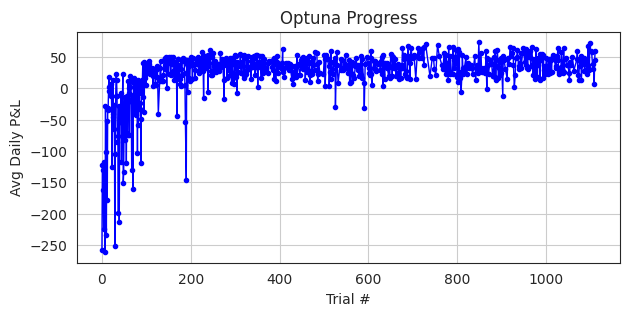

[Results] mean_pnl:-257.8793 mean_excess:-258.3198 improv:-58748.61%
Action counts: {'Buy': 14965, 'Sell': 2942, 'Hold': 117768}
Best trial is: 0 with best_val: -258.3198
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=289.00000, atr_mult=9.59233, vwap_atr_mult=-9.74667, buy_factor=0.66507, sell_factor=0.03840, trailstop_pct=40.40907, sess_start=14:30:00


Trial 1: 100%|██████████| 225/225 [00:40<00:00,  5.53it/s]


[Results] mean_pnl:-121.8768 mean_excess:-122.3173 improv:-27870.76%
Action counts: {'Buy': 5025, 'Sell': 17208, 'Hold': 113442}
Best trial is: 1 with best_val: -122.3173
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=200.00000, atr_mult=19.65043, vwap_atr_mult=3.75889, buy_factor=0.10282, sell_factor=0.36679, trailstop_pct=3.01485, sess_start=13:30:00


Trial 2: 100%|██████████| 225/225 [00:36<00:00,  6.21it/s]


[Results] mean_pnl:-130.4242 mean_excess:-130.8646 improv:-29811.35%
Action counts: {'Buy': 11280, 'Sell': 4259, 'Hold': 120136}
Best trial is: 1 with best_val: -122.3173
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=70.00000, atr_mult=16.29413, vwap_atr_mult=-7.38730, buy_factor=0.11234, sell_factor=0.84898, trailstop_pct=44.08642, sess_start=14:30:00


Trial 3: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]


[Results] mean_pnl:-161.1761 mean_excess:-161.6166 improv:-36793.24%
Action counts: {'Buy': 12670, 'Sell': 2351, 'Hold': 120654}
Best trial is: 1 with best_val: -122.3173
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=46.00000, rsi_max_thresh=161.00000, atr_mult=8.86832, vwap_atr_mult=6.61266, buy_factor=0.99358, sell_factor=0.32393, trailstop_pct=49.65619, sess_start=14:30:00


Trial 4: 100%|██████████| 225/225 [00:40<00:00,  5.50it/s]


[Results] mean_pnl:-223.6249 mean_excess:-224.0653 improv:-50971.53%
Action counts: {'Buy': 2321, 'Sell': 11028, 'Hold': 122326}
Best trial is: 1 with best_val: -122.3173
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=85.00000, rsi_max_thresh=174.00000, atr_mult=15.10120, vwap_atr_mult=9.11277, buy_factor=0.89493, sell_factor=0.25402, trailstop_pct=38.12563, sess_start=13:30:00


Trial 5: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]


[Results] mean_pnl:-117.1394 mean_excess:-117.5799 improv:-26795.19%
Action counts: {'Buy': 761, 'Sell': 4432, 'Hold': 130482}
Best trial is: 5 with best_val: -117.5799
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=255.00000, atr_mult=3.16818, vwap_atr_mult=-8.48301, buy_factor=0.15592, sell_factor=0.36426, trailstop_pct=49.13783, sess_start=13:30:00


Trial 6: 100%|██████████| 225/225 [00:36<00:00,  6.12it/s]


[Results] mean_pnl:-175.9556 mean_excess:-176.3960 improv:-40148.75%
Action counts: {'Buy': 24023, 'Sell': 2521, 'Hold': 109131}
Best trial is: 5 with best_val: -117.5799
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=60.00000, rsi_max_thresh=140.00000, atr_mult=6.18974, vwap_atr_mult=-4.02223, buy_factor=0.86642, sell_factor=0.31399, trailstop_pct=27.22164, sess_start=13:30:00


Trial 7: 100%|██████████| 225/225 [00:35<00:00,  6.30it/s]


[Results] mean_pnl:-260.9247 mean_excess:-261.3651 improv:-59440.03%
Action counts: {'Buy': 4741, 'Sell': 14246, 'Hold': 116688}
Best trial is: 5 with best_val: -117.5799
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=53.00000, rsi_max_thresh=106.00000, atr_mult=19.00030, vwap_atr_mult=4.57337, buy_factor=0.16013, sell_factor=0.46237, trailstop_pct=61.80744, sess_start=13:30:00


Trial 8: 100%|██████████| 225/225 [00:33<00:00,  6.71it/s]


[Results] mean_pnl:-28.5131 mean_excess:-28.9536 improv:-6673.59%
Action counts: {'Buy': 3347, 'Sell': 138, 'Hold': 132190}
Best trial is: 8 with best_val: -28.9536
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=74.00000, rsi_max_thresh=233.00000, atr_mult=2.83993, vwap_atr_mult=-7.27167, buy_factor=0.84208, sell_factor=0.13378, trailstop_pct=29.79979, sess_start=13:30:00


Trial 9: 100%|██████████| 225/225 [00:33<00:00,  6.77it/s]


[Results] mean_pnl:-101.3353 mean_excess:-101.7758 improv:-23207.05%
Action counts: {'Buy': 4797, 'Sell': 2922, 'Hold': 127956}
Best trial is: 8 with best_val: -28.9536
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=99.00000, rsi_max_thresh=122.00000, atr_mult=1.00618, vwap_atr_mult=0.59836, buy_factor=0.37080, sell_factor=0.64357, trailstop_pct=78.04154, sess_start=13:30:00


Trial 10: 100%|██████████| 225/225 [00:35<00:00,  6.40it/s]


[Results] mean_pnl:-232.8275 mean_excess:-233.2680 improv:-53060.88%
Action counts: {'Buy': 11920, 'Sell': 4640, 'Hold': 119115}
Best trial is: 8 with best_val: -28.9536
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=77.00000, rsi_max_thresh=220.00000, atr_mult=2.87675, vwap_atr_mult=-1.67413, buy_factor=0.62471, sell_factor=0.05310, trailstop_pct=61.45790, sess_start=13:30:00


Trial 11: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s]


[Results] mean_pnl:-52.0844 mean_excess:-52.5248 improv:-12025.18%
Action counts: {'Buy': 5857, 'Sell': 2870, 'Hold': 126948}
Best trial is: 8 with best_val: -28.9536
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=48.00000, rsi_max_thresh=111.00000, atr_mult=4.39819, vwap_atr_mult=-0.60854, buy_factor=0.56655, sell_factor=0.58099, trailstop_pct=64.21364, sess_start=13:30:00


Trial 12: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]


[Results] mean_pnl:-177.9452 mean_excess:-178.3857 improv:-40600.47%
Action counts: {'Buy': 7032, 'Sell': 1546, 'Hold': 127097}
Best trial is: 8 with best_val: -28.9536
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=72.00000, rsi_max_thresh=216.00000, atr_mult=27.88381, vwap_atr_mult=1.30063, buy_factor=0.32763, sell_factor=0.71693, trailstop_pct=63.53353, sess_start=13:30:00


Trial 13: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]


[Results] mean_pnl:-34.8451 mean_excess:-35.2855 improv:-8111.19%
Action counts: {'Buy': 980, 'Sell': 69, 'Hold': 134626}
Best trial is: 8 with best_val: -28.9536
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=49.00000, rsi_max_thresh=196.00000, atr_mult=29.52578, vwap_atr_mult=3.79322, buy_factor=0.29092, sell_factor=0.72154, trailstop_pct=60.81864, sess_start=13:30:00


Trial 14: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]


[Results] mean_pnl:-30.9427 mean_excess:-31.3832 improv:-7225.20%
Action counts: {'Buy': 955, 'Sell': 61, 'Hold': 134659}
Best trial is: 8 with best_val: -28.9536
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=46.00000, rsi_max_thresh=98.00000, atr_mult=28.38299, vwap_atr_mult=4.55150, buy_factor=0.00216, sell_factor=0.50421, trailstop_pct=57.97362, sess_start=13:30:00


Trial 15: 100%|██████████| 225/225 [00:33<00:00,  6.69it/s]


[Results] mean_pnl:1.7283 mean_excess:1.2878 improv:192.39%
Action counts: {'Buy': 16489, 'Sell': 69, 'Hold': 119117}
Best trial is: 15 with best_val: 1.2878
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=38.00000, rsi_max_thresh=52.00000, atr_mult=10.50678, vwap_atr_mult=5.72606, buy_factor=0.00428, sell_factor=0.52809, trailstop_pct=54.75010, sess_start=13:30:00


Trial 16: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]


[Results] mean_pnl:18.5869 mean_excess:18.1465 improv:4019.95%
Action counts: {'Buy': 10109, 'Sell': 353, 'Hold': 125213}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=38.00000, rsi_max_thresh=57.00000, atr_mult=10.47667, vwap_atr_mult=9.94961, buy_factor=0.00207, sell_factor=0.99082, trailstop_pct=10.53809, sess_start=13:30:00


Trial 17: 100%|██████████| 225/225 [00:29<00:00,  7.74it/s]


[Results] mean_pnl:-3.2101 mean_excess:-3.6506 improv:-928.83%
Action counts: {'Buy': 10289, 'Sell': 331, 'Hold': 125055}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=38.00000, rsi_max_thresh=39.00000, atr_mult=6.24728, vwap_atr_mult=7.00853, buy_factor=0.02149, sell_factor=0.51508, trailstop_pct=52.27226, sess_start=14:30:00


Trial 18: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


[Results] mean_pnl:5.8002 mean_excess:5.3598 improv:1116.87%
Action counts: {'Buy': 7359, 'Sell': 534, 'Hold': 127782}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=38.00000, rsi_max_thresh=40.00000, atr_mult=5.54503, vwap_atr_mult=7.29582, buy_factor=0.24882, sell_factor=0.48131, trailstop_pct=29.01225, sess_start=14:30:00


Trial 19: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


[Results] mean_pnl:-6.2512 mean_excess:-6.6917 improv:-1619.27%
Action counts: {'Buy': 2924, 'Sell': 694, 'Hold': 132057}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=37.00000, rsi_max_thresh=38.00000, atr_mult=7.32956, vwap_atr_mult=8.24425, buy_factor=0.47611, sell_factor=0.59307, trailstop_pct=70.31215, sess_start=14:30:00


Trial 20: 100%|██████████| 225/225 [00:35<00:00,  6.33it/s]


[Results] mean_pnl:-11.6694 mean_excess:-12.1099 improv:-2849.41%
Action counts: {'Buy': 1157, 'Sell': 439, 'Hold': 134079}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=58.00000, rsi_max_thresh=90.00000, atr_mult=11.13031, vwap_atr_mult=5.70406, buy_factor=0.00450, sell_factor=0.51896, trailstop_pct=51.97796, sess_start=14:30:00


Trial 21: 100%|██████████| 225/225 [00:38<00:00,  5.80it/s]


[Results] mean_pnl:7.5430 mean_excess:7.1025 improv:1512.55%
Action counts: {'Buy': 24947, 'Sell': 289, 'Hold': 110439}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=61.00000, rsi_max_thresh=87.00000, atr_mult=11.37277, vwap_atr_mult=6.10027, buy_factor=0.06061, sell_factor=0.45366, trailstop_pct=51.67298, sess_start=14:30:00


Trial 22: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]


[Results] mean_pnl:-34.1899 mean_excess:-34.6304 improv:-7962.44%
Action counts: {'Buy': 10887, 'Sell': 281, 'Hold': 124507}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=57.00000, atr_mult=4.32623, vwap_atr_mult=3.08512, buy_factor=0.20281, sell_factor=0.68365, trailstop_pct=53.53750, sess_start=14:30:00


Trial 23: 100%|██████████| 225/225 [00:35<00:00,  6.30it/s]


[Results] mean_pnl:-125.7765 mean_excess:-126.2170 improv:-28756.16%
Action counts: {'Buy': 9641, 'Sell': 1410, 'Hold': 124624}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=66.00000, rsi_max_thresh=129.00000, atr_mult=12.62697, vwap_atr_mult=5.86081, buy_factor=0.06169, sell_factor=0.56715, trailstop_pct=35.26586, sess_start=14:30:00


Trial 24: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]


[Results] mean_pnl:-40.4513 mean_excess:-40.8917 improv:-9384.01%
Action counts: {'Buy': 9619, 'Sell': 246, 'Hold': 125810}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=54.00000, rsi_max_thresh=86.00000, atr_mult=7.24863, vwap_atr_mult=2.14864, buy_factor=0.00142, sell_factor=0.19452, trailstop_pct=45.25729, sess_start=14:30:00


Trial 25: 100%|██████████| 225/225 [00:40<00:00,  5.53it/s]


[Results] mean_pnl:14.2364 mean_excess:13.7959 improv:3032.20%
Action counts: {'Buy': 29924, 'Sell': 601, 'Hold': 105150}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=54.00000, rsi_max_thresh=140.00000, atr_mult=7.67401, vwap_atr_mult=2.12446, buy_factor=0.20014, sell_factor=0.22797, trailstop_pct=20.40198, sess_start=14:30:00


Trial 26: 100%|██████████| 225/225 [00:33<00:00,  6.81it/s]


[Results] mean_pnl:-45.6394 mean_excess:-46.0799 improv:-10561.91%
Action counts: {'Buy': 7098, 'Sell': 543, 'Hold': 128034}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=66.00000, rsi_max_thresh=96.00000, atr_mult=4.39809, vwap_atr_mult=-2.78715, buy_factor=0.42618, sell_factor=0.16627, trailstop_pct=42.85930, sess_start=14:30:00


Trial 27: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]


[Results] mean_pnl:-63.8351 mean_excess:-64.2755 improv:-14693.04%
Action counts: {'Buy': 7126, 'Sell': 1395, 'Hold': 127154}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=43.00000, rsi_max_thresh=69.00000, atr_mult=13.03465, vwap_atr_mult=2.19337, buy_factor=0.10403, sell_factor=0.40873, trailstop_pct=45.44074, sess_start=14:30:00


Trial 28: 100%|██████████| 225/225 [00:33<00:00,  6.77it/s]


[Results] mean_pnl:-26.2088 mean_excess:-26.6492 improv:-6150.40%
Action counts: {'Buy': 6821, 'Sell': 234, 'Hold': 128620}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=54.00000, rsi_max_thresh=84.00000, atr_mult=1.66364, vwap_atr_mult=5.23191, buy_factor=0.26788, sell_factor=0.76823, trailstop_pct=69.74796, sess_start=14:30:00


Trial 29: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]


[Results] mean_pnl:-251.0933 mean_excess:-251.5337 improv:-57207.91%
Action counts: {'Buy': 18291, 'Sell': 3902, 'Hold': 113482}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=66.00000, rsi_max_thresh=117.00000, atr_mult=8.39721, vwap_atr_mult=8.02792, buy_factor=0.18919, sell_factor=0.82506, trailstop_pct=34.30178, sess_start=14:30:00


Trial 30: 100%|██████████| 225/225 [00:34<00:00,  6.44it/s]


[Results] mean_pnl:-104.6420 mean_excess:-105.0824 improv:-23957.79%
Action counts: {'Buy': 7520, 'Sell': 472, 'Hold': 127683}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=43.00000, rsi_max_thresh=60.00000, atr_mult=6.40166, vwap_atr_mult=7.15161, buy_factor=0.01036, sell_factor=0.55179, trailstop_pct=54.28833, sess_start=14:30:00


Trial 31: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


[Results] mean_pnl:-11.4612 mean_excess:-11.9017 improv:-2802.14%
Action counts: {'Buy': 14516, 'Sell': 736, 'Hold': 120423}
Best trial is: 16 with best_val: 18.1465
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=30.00000, atr_mult=9.73594, vwap_atr_mult=5.79844, buy_factor=0.06246, sell_factor=0.64085, trailstop_pct=56.54311, sess_start=14:30:00


Trial 32: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]


[Results] mean_pnl:22.5753 mean_excess:22.1349 improv:4925.48%
Action counts: {'Buy': 5497, 'Sell': 327, 'Hold': 129851}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=31.00000, atr_mult=11.13440, vwap_atr_mult=2.47378, buy_factor=0.08176, sell_factor=0.63194, trailstop_pct=57.58450, sess_start=14:30:00


Trial 33: 100%|██████████| 225/225 [00:28<00:00,  7.95it/s]


[Results] mean_pnl:14.0673 mean_excess:13.6268 improv:2993.81%
Action counts: {'Buy': 6047, 'Sell': 289, 'Hold': 129339}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=27.00000, atr_mult=22.61323, vwap_atr_mult=2.66224, buy_factor=0.10689, sell_factor=0.63749, trailstop_pct=68.94960, sess_start=14:30:00


Trial 34: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]


[Results] mean_pnl:-12.5378 mean_excess:-12.9783 improv:-3046.57%
Action counts: {'Buy': 3153, 'Sell': 706, 'Hold': 131816}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=49.00000, atr_mult=15.93996, vwap_atr_mult=0.91009, buy_factor=0.09629, sell_factor=0.76316, trailstop_pct=46.24318, sess_start=14:30:00


Trial 35: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]


[Results] mean_pnl:-85.5674 mean_excess:-86.0078 improv:-19627.11%
Action counts: {'Buy': 6928, 'Sell': 1196, 'Hold': 127551}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=29.00000, atr_mult=9.41704, vwap_atr_mult=-0.21045, buy_factor=0.14537, sell_factor=0.94095, trailstop_pct=41.05060, sess_start=14:30:00


Trial 36: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]


[Results] mean_pnl:-75.7455 mean_excess:-76.1860 improv:-17397.17%
Action counts: {'Buy': 6813, 'Sell': 366, 'Hold': 128496}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=24.00000, atr_mult=14.58695, vwap_atr_mult=-4.83983, buy_factor=0.73370, sell_factor=0.64037, trailstop_pct=57.54508, sess_start=14:30:00


Trial 37: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]


[Results] mean_pnl:-199.0692 mean_excess:-199.5096 improv:-45396.43%
Action counts: {'Buy': 3016, 'Sell': 3355, 'Hold': 129304}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=73.00000, atr_mult=18.81946, vwap_atr_mult=3.65845, buy_factor=0.08619, sell_factor=0.41134, trailstop_pct=56.76259, sess_start=14:30:00


Trial 38: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


[Results] mean_pnl:-27.6704 mean_excess:-28.1109 improv:-6482.26%
Action counts: {'Buy': 4935, 'Sell': 131, 'Hold': 130609}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=296.00000, atr_mult=9.24302, vwap_atr_mult=4.68783, buy_factor=0.23888, sell_factor=0.83223, trailstop_pct=48.03111, sess_start=14:30:00


Trial 39: 100%|██████████| 225/225 [00:43<00:00,  5.13it/s]


[Results] mean_pnl:-213.3570 mean_excess:-213.7974 improv:-48640.31%
Action counts: {'Buy': 14016, 'Sell': 4115, 'Hold': 117544}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=71.00000, atr_mult=7.17896, vwap_atr_mult=1.95410, buy_factor=0.05537, sell_factor=0.29646, trailstop_pct=67.67891, sess_start=14:30:00


Trial 40: 100%|██████████| 225/225 [00:33<00:00,  6.81it/s]


[Results] mean_pnl:-46.3646 mean_excess:-46.8050 improv:-10726.56%
Action counts: {'Buy': 16535, 'Sell': 611, 'Hold': 118529}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=43.00000, rsi_max_thresh=82.00000, atr_mult=10.66985, vwap_atr_mult=5.53826, buy_factor=0.14084, sell_factor=0.53805, trailstop_pct=49.44919, sess_start=14:30:00


Trial 41: 100%|██████████| 225/225 [00:36<00:00,  6.08it/s]


[Results] mean_pnl:-50.6161 mean_excess:-51.0566 improv:-11691.82%
Action counts: {'Buy': 7608, 'Sell': 316, 'Hold': 127751}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=57.00000, rsi_max_thresh=96.00000, atr_mult=13.38447, vwap_atr_mult=3.69657, buy_factor=0.04997, sell_factor=0.61519, trailstop_pct=38.77315, sess_start=14:30:00


Trial 42: 100%|██████████| 225/225 [00:33<00:00,  6.72it/s]


[Results] mean_pnl:-37.2240 mean_excess:-37.6645 improv:-8651.30%
Action counts: {'Buy': 11826, 'Sell': 224, 'Hold': 123625}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=84.00000, rsi_max_thresh=103.00000, atr_mult=10.82213, vwap_atr_mult=8.34445, buy_factor=0.04826, sell_factor=0.00137, trailstop_pct=75.97172, sess_start=14:30:00


Trial 43: 100%|██████████| 225/225 [00:33<00:00,  6.74it/s]


[Results] mean_pnl:-7.3032 mean_excess:-7.7437 improv:-1858.12%
Action counts: {'Buy': 551, 'Sell': 311, 'Hold': 134813}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=51.00000, atr_mult=5.28885, vwap_atr_mult=-1.17036, buy_factor=0.13653, sell_factor=0.42778, trailstop_pct=57.50808, sess_start=13:30:00


Trial 44: 100%|██████████| 225/225 [00:32<00:00,  7.01it/s]


[Results] mean_pnl:-116.8539 mean_excess:-117.2943 improv:-26730.37%
Action counts: {'Buy': 14861, 'Sell': 1135, 'Hold': 119679}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=50.00000, rsi_max_thresh=69.00000, atr_mult=8.47636, vwap_atr_mult=6.48069, buy_factor=0.18083, sell_factor=0.35431, trailstop_pct=65.49903, sess_start=14:30:00


Trial 45: 100%|██████████| 225/225 [00:36<00:00,  6.08it/s]


[Results] mean_pnl:-55.2806 mean_excess:-55.7211 improv:-12750.85%
Action counts: {'Buy': 7142, 'Sell': 459, 'Hold': 128074}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=165.00000, atr_mult=21.68953, vwap_atr_mult=4.82007, buy_factor=0.07815, sell_factor=0.69691, trailstop_pct=44.76338, sess_start=13:30:00


Trial 46: 100%|██████████| 225/225 [00:38<00:00,  5.82it/s]


[Results] mean_pnl:-35.8388 mean_excess:-36.2793 improv:-8336.80%
Action counts: {'Buy': 5249, 'Sell': 109, 'Hold': 130317}
Best trial is: 32 with best_val: 22.1349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=62.00000, rsi_max_thresh=88.00000, atr_mult=18.12355, vwap_atr_mult=1.46474, buy_factor=0.00118, sell_factor=0.76975, trailstop_pct=72.94498, sess_start=14:30:00


Trial 47: 100%|██████████| 225/225 [00:44<00:00,  5.10it/s]


[Results] mean_pnl:23.1426 mean_excess:22.7021 improv:5054.26%
Action counts: {'Buy': 24435, 'Sell': 1253, 'Hold': 109987}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=62.00000, rsi_max_thresh=76.00000, atr_mult=17.79160, vwap_atr_mult=0.73296, buy_factor=0.33423, sell_factor=0.89150, trailstop_pct=75.15489, sess_start=13:30:00


Trial 48: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]


[Results] mean_pnl:-151.1742 mean_excess:-151.6146 improv:-34522.41%
Action counts: {'Buy': 5130, 'Sell': 1719, 'Hold': 128826}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=70.00000, rsi_max_thresh=86.00000, atr_mult=15.22277, vwap_atr_mult=1.68060, buy_factor=0.12521, sell_factor=0.76669, trailstop_pct=72.72701, sess_start=13:30:00


Trial 49: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]


[Results] mean_pnl:-133.4319 mean_excess:-133.8723 improv:-30494.21%
Action counts: {'Buy': 9165, 'Sell': 2504, 'Hold': 124006}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=78.00000, rsi_max_thresh=106.00000, atr_mult=24.45660, vwap_atr_mult=0.16777, buy_factor=0.03704, sell_factor=0.67120, trailstop_pct=60.68241, sess_start=14:30:00


Trial 50: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]


[Results] mean_pnl:-46.7037 mean_excess:-47.1441 improv:-10803.55%
Action counts: {'Buy': 7269, 'Sell': 1020, 'Hold': 127386}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=63.00000, rsi_max_thresh=89.00000, atr_mult=12.13525, vwap_atr_mult=3.04908, buy_factor=0.00870, sell_factor=0.60218, trailstop_pct=54.62539, sess_start=14:30:00


Trial 51: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]


[Results] mean_pnl:-12.7380 mean_excess:-13.1785 improv:-3092.03%
Action counts: {'Buy': 22316, 'Sell': 3459, 'Hold': 109900}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=58.00000, rsi_max_thresh=274.00000, atr_mult=9.93963, vwap_atr_mult=4.47405, buy_factor=0.00842, sell_factor=0.52493, trailstop_pct=78.65067, sess_start=14:30:00


Trial 52: 100%|██████████| 225/225 [00:36<00:00,  6.24it/s]


[Results] mean_pnl:-24.7111 mean_excess:-25.1515 improv:-5810.37%
Action counts: {'Buy': 26304, 'Sell': 4782, 'Hold': 104589}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=52.00000, rsi_max_thresh=65.00000, atr_mult=8.01532, vwap_atr_mult=-1.90081, buy_factor=0.08334, sell_factor=0.73707, trailstop_pct=51.04117, sess_start=14:30:00


Trial 53: 100%|██████████| 225/225 [00:39<00:00,  5.67it/s]


[Results] mean_pnl:-82.6861 mean_excess:-83.1265 improv:-18972.95%
Action counts: {'Buy': 14192, 'Sell': 507, 'Hold': 120976}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=44.00000, atr_mult=6.67401, vwap_atr_mult=3.53688, buy_factor=0.76157, sell_factor=0.48856, trailstop_pct=61.23269, sess_start=14:30:00


Trial 54: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]


[Results] mean_pnl:-13.2403 mean_excess:-13.6807 improv:-3206.05%
Action counts: {'Buy': 1092, 'Sell': 643, 'Hold': 133940}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=57.00000, rsi_max_thresh=77.00000, atr_mult=5.29199, vwap_atr_mult=8.94733, buy_factor=0.04373, sell_factor=0.57102, trailstop_pct=65.14700, sess_start=13:30:00


Trial 55: 100%|██████████| 225/225 [00:34<00:00,  6.55it/s]


[Results] mean_pnl:-118.7703 mean_excess:-119.2107 improv:-27165.46%
Action counts: {'Buy': 22958, 'Sell': 1135, 'Hold': 111582}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=138.00000, atr_mult=17.61032, vwap_atr_mult=6.29301, buy_factor=0.22175, sell_factor=0.10690, trailstop_pct=48.52214, sess_start=14:30:00


Trial 56: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]


[Results] mean_pnl:-12.1272 mean_excess:-12.5677 improv:-2953.35%
Action counts: {'Buy': 1898, 'Sell': 146, 'Hold': 133631}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=41.00000, rsi_max_thresh=55.00000, atr_mult=13.81968, vwap_atr_mult=5.42963, buy_factor=0.14672, sell_factor=0.66065, trailstop_pct=35.70261, sess_start=14:30:00


Trial 57: 100%|██████████| 225/225 [00:33<00:00,  6.71it/s]


[Results] mean_pnl:-70.7013 mean_excess:-71.1417 improv:-16251.94%
Action counts: {'Buy': 4743, 'Sell': 2791, 'Hold': 128141}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=40.00000, rsi_max_thresh=152.00000, atr_mult=11.45485, vwap_atr_mult=1.32007, buy_factor=0.58203, sell_factor=0.81106, trailstop_pct=54.69120, sess_start=13:30:00


Trial 58: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]


[Results] mean_pnl:-74.2519 mean_excess:-74.6923 improv:-17058.06%
Action counts: {'Buy': 2047, 'Sell': 306, 'Hold': 133322}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=96.00000, rsi_max_thresh=115.00000, atr_mult=9.48688, vwap_atr_mult=4.31768, buy_factor=0.96642, sell_factor=0.46178, trailstop_pct=1.24570, sess_start=14:30:00


Trial 59: 100%|██████████| 225/225 [00:35<00:00,  6.28it/s]


[Results] mean_pnl:11.3573 mean_excess:10.9168 improv:2378.54%
Action counts: {'Buy': 339, 'Sell': 390, 'Hold': 134946}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=92.00000, rsi_max_thresh=114.00000, atr_mult=9.41676, vwap_atr_mult=2.70393, buy_factor=0.89731, sell_factor=0.23510, trailstop_pct=17.35823, sess_start=14:30:00


Trial 60: 100%|██████████| 225/225 [00:32<00:00,  7.02it/s]


[Results] mean_pnl:-6.6536 mean_excess:-7.0940 improv:-1710.62%
Action counts: {'Buy': 618, 'Sell': 379, 'Hold': 134678}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=94.00000, rsi_max_thresh=103.00000, atr_mult=12.02356, vwap_atr_mult=4.64133, buy_factor=0.52059, sell_factor=0.45418, trailstop_pct=41.08026, sess_start=14:30:00


Trial 61: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]


[Results] mean_pnl:0.4524 mean_excess:0.0119 improv:-97.29%
Action counts: {'Buy': 914, 'Sell': 265, 'Hold': 134496}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=82.00000, rsi_max_thresh=92.00000, atr_mult=7.10596, vwap_atr_mult=-8.59031, buy_factor=0.96699, sell_factor=0.39322, trailstop_pct=6.68004, sess_start=14:30:00


Trial 62: 100%|██████████| 225/225 [00:34<00:00,  6.51it/s]


[Results] mean_pnl:-74.6403 mean_excess:-75.0807 improv:-17146.24%
Action counts: {'Buy': 1038, 'Sell': 619, 'Hold': 134018}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=98.00000, rsi_max_thresh=124.00000, atr_mult=8.48788, vwap_atr_mult=4.18764, buy_factor=0.02907, sell_factor=0.27959, trailstop_pct=20.18375, sess_start=14:30:00


Trial 63: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]


[Results] mean_pnl:20.4334 mean_excess:19.9929 improv:4439.16%
Action counts: {'Buy': 8911, 'Sell': 456, 'Hold': 126308}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=100.00000, rsi_max_thresh=127.00000, atr_mult=5.63425, vwap_atr_mult=4.35305, buy_factor=0.10726, sell_factor=0.19413, trailstop_pct=13.73682, sess_start=14:30:00


Trial 64: 100%|██████████| 225/225 [00:33<00:00,  6.73it/s]


[Results] mean_pnl:2.0314 mean_excess:1.5909 improv:261.20%
Action counts: {'Buy': 6228, 'Sell': 923, 'Hold': 128524}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=93.00000, rsi_max_thresh=103.00000, atr_mult=7.95687, vwap_atr_mult=2.69704, buy_factor=0.03615, sell_factor=0.27130, trailstop_pct=7.90286, sess_start=14:30:00


Trial 65: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]


[Results] mean_pnl:11.3465 mean_excess:10.9060 improv:2376.09%
Action counts: {'Buy': 10346, 'Sell': 514, 'Hold': 124815}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=89.00000, rsi_max_thresh=97.00000, atr_mult=8.65468, vwap_atr_mult=7.43830, buy_factor=0.68686, sell_factor=0.12249, trailstop_pct=23.64788, sess_start=14:30:00


Trial 66: 100%|██████████| 225/225 [00:27<00:00,  8.16it/s]


[Results] mean_pnl:-18.3198 mean_excess:-18.7602 improv:-4359.30%
Action counts: {'Buy': 721, 'Sell': 436, 'Hold': 134518}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=97.00000, rsi_max_thresh=110.00000, atr_mult=3.50114, vwap_atr_mult=1.22143, buy_factor=0.39196, sell_factor=0.33984, trailstop_pct=30.99755, sess_start=13:30:00


Trial 67: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


[Results] mean_pnl:-129.1448 mean_excess:-129.5852 improv:-29520.88%
Action counts: {'Buy': 7607, 'Sell': 2147, 'Hold': 125921}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=88.00000, rsi_max_thresh=188.00000, atr_mult=5.93084, vwap_atr_mult=3.96770, buy_factor=0.17769, sell_factor=0.18317, trailstop_pct=13.64218, sess_start=14:30:00


Trial 68: 100%|██████████| 225/225 [00:28<00:00,  8.03it/s]


[Results] mean_pnl:-20.7971 mean_excess:-21.2376 improv:-4921.76%
Action counts: {'Buy': 4829, 'Sell': 848, 'Hold': 129998}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=96.00000, rsi_max_thresh=121.00000, atr_mult=10.03345, vwap_atr_mult=3.04104, buy_factor=0.28922, sell_factor=0.08993, trailstop_pct=22.82497, sess_start=14:30:00


Trial 69: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]


[Results] mean_pnl:-10.5731 mean_excess:-11.0135 improv:-2600.50%
Action counts: {'Buy': 3631, 'Sell': 7811, 'Hold': 124233}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=75.00000, rsi_max_thresh=84.00000, atr_mult=1.98619, vwap_atr_mult=0.30506, buy_factor=0.07972, sell_factor=0.79574, trailstop_pct=2.11190, sess_start=14:30:00


Trial 70: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]


[Results] mean_pnl:-160.6988 mean_excess:-161.1392 improv:-36684.86%
Action counts: {'Buy': 22255, 'Sell': 3072, 'Hold': 110348}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=91.00000, rsi_max_thresh=100.00000, atr_mult=7.75352, vwap_atr_mult=2.45606, buy_factor=0.03481, sell_factor=0.26207, trailstop_pct=6.21817, sess_start=14:30:00


Trial 71: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]


[Results] mean_pnl:10.3682 mean_excess:9.9277 improv:2153.97%
Action counts: {'Buy': 11025, 'Sell': 536, 'Hold': 124114}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=97.00000, rsi_max_thresh=106.00000, atr_mult=6.79358, vwap_atr_mult=1.88774, buy_factor=0.02949, sell_factor=0.30266, trailstop_pct=5.97846, sess_start=14:30:00


Trial 72: 100%|██████████| 225/225 [00:34<00:00,  6.45it/s]


[Results] mean_pnl:17.1374 mean_excess:16.6970 improv:3690.86%
Action counts: {'Buy': 14005, 'Sell': 663, 'Hold': 121007}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=97.00000, rsi_max_thresh=110.00000, atr_mult=4.90748, vwap_atr_mult=1.77098, buy_factor=0.00124, sell_factor=0.30390, trailstop_pct=4.71037, sess_start=14:30:00


Trial 73: 100%|██████████| 225/225 [00:38<00:00,  5.89it/s]


[Results] mean_pnl:8.2670 mean_excess:7.8266 improv:1676.94%
Action counts: {'Buy': 18304, 'Sell': 1097, 'Hold': 116274}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=43.00000, atr_mult=6.73816, vwap_atr_mult=-0.43060, buy_factor=0.06590, sell_factor=0.38319, trailstop_pct=1.46268, sess_start=14:30:00


Trial 74: 100%|██████████| 225/225 [00:32<00:00,  6.90it/s]


[Results] mean_pnl:-39.4941 mean_excess:-39.9345 improv:-9166.69%
Action counts: {'Buy': 13640, 'Sell': 669, 'Hold': 121366}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=46.00000, rsi_max_thresh=63.00000, atr_mult=8.86765, vwap_atr_mult=3.33940, buy_factor=0.10367, sell_factor=0.22057, trailstop_pct=10.02687, sess_start=14:30:00


Trial 75: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]


[Results] mean_pnl:-32.6656 mean_excess:-33.1061 improv:-7616.36%
Action counts: {'Buy': 8052, 'Sell': 420, 'Hold': 127203}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=100.00000, rsi_max_thresh=131.00000, atr_mult=10.18906, vwap_atr_mult=5.15995, buy_factor=0.02447, sell_factor=0.87753, trailstop_pct=4.73999, sess_start=14:30:00


Trial 76: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]


[Results] mean_pnl:10.3293 mean_excess:9.8888 improv:2145.15%
Action counts: {'Buy': 8311, 'Sell': 245, 'Hold': 127119}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=87.00000, rsi_max_thresh=95.00000, atr_mult=7.36150, vwap_atr_mult=3.98860, buy_factor=0.06592, sell_factor=0.62621, trailstop_pct=11.12692, sess_start=13:30:00


Trial 77: 100%|██████████| 225/225 [00:26<00:00,  8.42it/s]


[Results] mean_pnl:-41.9893 mean_excess:-42.4298 improv:-9733.21%
Action counts: {'Buy': 8878, 'Sell': 636, 'Hold': 126161}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=29.00000, atr_mult=13.95066, vwap_atr_mult=6.83387, buy_factor=0.16782, sell_factor=0.69588, trailstop_pct=59.29830, sess_start=14:30:00


Trial 78: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


[Results] mean_pnl:8.4471 mean_excess:8.0067 improv:1717.82%
Action counts: {'Buy': 2094, 'Sell': 197, 'Hold': 133384}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=52.00000, atr_mult=12.72692, vwap_atr_mult=5.96127, buy_factor=0.12143, sell_factor=0.32511, trailstop_pct=46.96623, sess_start=14:30:00


Trial 79: 100%|██████████| 225/225 [00:29<00:00,  7.73it/s]


[Results] mean_pnl:6.7459 mean_excess:6.3055 improv:1331.59%
Action counts: {'Buy': 2923, 'Sell': 242, 'Hold': 132510}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=148.00000, atr_mult=16.43747, vwap_atr_mult=2.07802, buy_factor=0.02807, sell_factor=0.43275, trailstop_pct=66.38789, sess_start=14:30:00


Trial 80: 100%|██████████| 225/225 [00:38<00:00,  5.91it/s]


[Results] mean_pnl:-103.1607 mean_excess:-103.6012 improv:-23621.49%
Action counts: {'Buy': 19419, 'Sell': 4543, 'Hold': 111713}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=93.00000, rsi_max_thresh=120.00000, atr_mult=7.94077, vwap_atr_mult=2.65465, buy_factor=0.03340, sell_factor=0.28477, trailstop_pct=4.00329, sess_start=14:30:00


Trial 81: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]


[Results] mean_pnl:13.0910 mean_excess:12.6505 improv:2772.16%
Action counts: {'Buy': 10803, 'Sell': 517, 'Hold': 124355}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=96.00000, rsi_max_thresh=122.00000, atr_mult=4.79333, vwap_atr_mult=1.29670, buy_factor=0.81188, sell_factor=0.29280, trailstop_pct=4.63785, sess_start=14:30:00


Trial 82: 100%|██████████| 225/225 [00:28<00:00,  7.81it/s]


[Results] mean_pnl:-57.5921 mean_excess:-58.0326 improv:-13275.65%
Action counts: {'Buy': 1793, 'Sell': 1204, 'Hold': 132678}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=90.00000, rsi_max_thresh=95.00000, atr_mult=6.23393, vwap_atr_mult=4.08853, buy_factor=0.06531, sell_factor=0.19684, trailstop_pct=1.01133, sess_start=14:30:00


Trial 83: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]


[Results] mean_pnl:4.8560 mean_excess:4.4155 improv:902.49%
Action counts: {'Buy': 7724, 'Sell': 780, 'Hold': 127171}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=98.00000, rsi_max_thresh=106.00000, atr_mult=1.21295, vwap_atr_mult=5.01178, buy_factor=0.00215, sell_factor=0.37024, trailstop_pct=8.68044, sess_start=14:30:00


Trial 84: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]


[Results] mean_pnl:-6.9915 mean_excess:-7.4319 improv:-1787.34%
Action counts: {'Buy': 10461, 'Sell': 1956, 'Hold': 123258}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=94.00000, rsi_max_thresh=100.00000, atr_mult=9.01196, vwap_atr_mult=-0.94694, buy_factor=0.09029, sell_factor=0.15586, trailstop_pct=72.22164, sess_start=14:30:00


Trial 85: 100%|██████████| 225/225 [00:33<00:00,  6.73it/s]


[Results] mean_pnl:-22.8868 mean_excess:-23.3272 improv:-5396.19%
Action counts: {'Buy': 7628, 'Sell': 409, 'Hold': 127638}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=80.00000, rsi_max_thresh=89.00000, atr_mult=6.81894, vwap_atr_mult=0.78188, buy_factor=0.03623, sell_factor=0.24557, trailstop_pct=12.91603, sess_start=13:30:00


Trial 86: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


[Results] mean_pnl:-32.3682 mean_excess:-32.8087 improv:-7548.84%
Action counts: {'Buy': 17550, 'Sell': 725, 'Hold': 117400}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=86.00000, rsi_max_thresh=118.00000, atr_mult=10.76396, vwap_atr_mult=2.46062, buy_factor=0.46539, sell_factor=0.55053, trailstop_pct=55.87077, sess_start=14:30:00


Trial 87: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]


[Results] mean_pnl:-48.7528 mean_excess:-49.1932 improv:-11268.77%
Action counts: {'Buy': 1747, 'Sell': 313, 'Hold': 133615}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=70.00000, rsi_max_thresh=79.00000, atr_mult=8.25690, vwap_atr_mult=3.20538, buy_factor=0.12554, sell_factor=0.47184, trailstop_pct=17.99736, sess_start=14:30:00


Trial 88: 100%|██████████| 225/225 [00:27<00:00,  8.06it/s]


[Results] mean_pnl:-119.1545 mean_excess:-119.5950 improv:-27252.71%
Action counts: {'Buy': 10306, 'Sell': 6801, 'Hold': 118568}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=36.00000, rsi_max_thresh=46.00000, atr_mult=11.71101, vwap_atr_mult=1.66913, buy_factor=0.06150, sell_factor=0.59210, trailstop_pct=62.44249, sess_start=14:30:00


Trial 89: 100%|██████████| 225/225 [00:33<00:00,  6.74it/s]


[Results] mean_pnl:-2.5915 mean_excess:-3.0319 improv:-788.37%
Action counts: {'Buy': 7572, 'Sell': 272, 'Hold': 127831}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=35.00000, atr_mult=26.13771, vwap_atr_mult=7.61992, buy_factor=0.99410, sell_factor=0.72593, trailstop_pct=43.24372, sess_start=13:30:00


Trial 90: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


[Results] mean_pnl:12.8363 mean_excess:12.3958 improv:2714.34%
Action counts: {'Buy': 94, 'Sell': 73, 'Hold': 135508}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=35.00000, atr_mult=26.66567, vwap_atr_mult=7.76645, buy_factor=0.97518, sell_factor=0.74534, trailstop_pct=43.58087, sess_start=13:30:00


Trial 91: 100%|██████████| 225/225 [00:28<00:00,  7.98it/s]


[Results] mean_pnl:9.1726 mean_excess:8.7321 improv:1882.53%
Action counts: {'Buy': 93, 'Sell': 73, 'Hold': 135509}
Best trial is: 47 with best_val: 22.7021
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=35.00000, atr_mult=24.62397, vwap_atr_mult=6.66027, buy_factor=0.98330, sell_factor=0.65329, trailstop_pct=32.66212, sess_start=13:30:00


Trial 92: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]


[Results] mean_pnl:40.2909 mean_excess:39.8504 improv:8947.59%
Action counts: {'Buy': 96, 'Sell': 83, 'Hold': 135496}
Best trial is: 92 with best_val: 39.8504
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=21.83311, vwap_atr_mult=9.05767, buy_factor=0.90460, sell_factor=0.64920, trailstop_pct=26.69531, sess_start=13:30:00


Trial 93: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]


[Results] mean_pnl:-13.0753 mean_excess:-13.5158 improv:-3168.61%
Action counts: {'Buy': 152, 'Sell': 105, 'Hold': 135418}
Best trial is: 92 with best_val: 39.8504
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=43.00000, atr_mult=29.80506, vwap_atr_mult=6.54211, buy_factor=0.94037, sell_factor=0.73078, trailstop_pct=39.03405, sess_start=13:30:00


Trial 94: 100%|██████████| 225/225 [00:29<00:00,  7.75it/s]


[Results] mean_pnl:42.9922 mean_excess:42.5518 improv:9560.90%
Action counts: {'Buy': 126, 'Sell': 60, 'Hold': 135489}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=58.00000, atr_mult=20.21241, vwap_atr_mult=6.61477, buy_factor=0.64073, sell_factor=0.68079, trailstop_pct=31.83848, sess_start=13:30:00


Trial 95: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]


[Results] mean_pnl:-37.3941 mean_excess:-37.8345 improv:-8689.91%
Action counts: {'Buy': 733, 'Sell': 122, 'Hold': 134820}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=44.00000, atr_mult=24.17662, vwap_atr_mult=5.81806, buy_factor=0.91127, sell_factor=0.78982, trailstop_pct=37.44569, sess_start=13:30:00


Trial 96: 100%|██████████| 225/225 [00:25<00:00,  8.88it/s]


[Results] mean_pnl:17.3003 mean_excess:16.8599 improv:3727.85%
Action counts: {'Buy': 155, 'Sell': 86, 'Hold': 135434}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=49.00000, atr_mult=24.91597, vwap_atr_mult=5.79063, buy_factor=0.92289, sell_factor=0.84933, trailstop_pct=38.11715, sess_start=13:30:00


Trial 97: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]


[Results] mean_pnl:22.2802 mean_excess:21.8397 improv:4858.47%
Action counts: {'Buy': 203, 'Sell': 266, 'Hold': 135206}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=50.00000, atr_mult=29.84475, vwap_atr_mult=6.11169, buy_factor=0.86239, sell_factor=0.90692, trailstop_pct=37.62643, sess_start=13:30:00


Trial 98: 100%|██████████| 225/225 [00:25<00:00,  8.70it/s]


[Results] mean_pnl:38.0131 mean_excess:37.5727 improv:8430.46%
Action counts: {'Buy': 215, 'Sell': 163, 'Hold': 135297}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=49.00000, atr_mult=24.21813, vwap_atr_mult=8.49935, buy_factor=0.93142, sell_factor=0.93393, trailstop_pct=37.19019, sess_start=13:30:00


Trial 99: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]


[Results] mean_pnl:5.2310 mean_excess:4.7905 improv:987.64%
Action counts: {'Buy': 160, 'Sell': 157, 'Hold': 135358}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=29.15828, vwap_atr_mult=5.71188, buy_factor=0.85106, sell_factor=0.96748, trailstop_pct=33.93098, sess_start=13:30:00


Trial 100: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]


[Results] mean_pnl:37.1294 mean_excess:36.6889 improv:8229.81%
Action counts: {'Buy': 228, 'Sell': 116, 'Hold': 135331}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=40.00000, atr_mult=29.71663, vwap_atr_mult=5.76465, buy_factor=0.85267, sell_factor=0.85218, trailstop_pct=33.20927, sess_start=13:30:00


Trial 101: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


[Results] mean_pnl:30.9381 mean_excess:30.4976 improv:6824.14%
Action counts: {'Buy': 223, 'Sell': 215, 'Hold': 135237}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=29.50157, vwap_atr_mult=5.73163, buy_factor=0.84909, sell_factor=0.99697, trailstop_pct=33.26935, sess_start=13:30:00


Trial 102: 100%|██████████| 225/225 [00:28<00:00,  7.91it/s]


[Results] mean_pnl:25.5782 mean_excess:25.1377 improv:5607.23%
Action counts: {'Buy': 227, 'Sell': 116, 'Hold': 135332}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=29.98575, vwap_atr_mult=6.93984, buy_factor=0.85821, sell_factor=0.90018, trailstop_pct=33.47520, sess_start=13:30:00


Trial 103: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]


[Results] mean_pnl:41.3183 mean_excess:40.8778 improv:9180.86%
Action counts: {'Buy': 191, 'Sell': 141, 'Hold': 135343}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=40.00000, atr_mult=29.70856, vwap_atr_mult=7.07398, buy_factor=0.86079, sell_factor=0.98187, trailstop_pct=34.59429, sess_start=13:30:00


Trial 104: 100%|██████████| 225/225 [00:26<00:00,  8.35it/s]


[Results] mean_pnl:35.0982 mean_excess:34.6578 improv:7768.66%
Action counts: {'Buy': 194, 'Sell': 95, 'Hold': 135386}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=40.00000, atr_mult=29.19456, vwap_atr_mult=9.63581, buy_factor=0.85210, sell_factor=0.98766, trailstop_pct=33.38354, sess_start=13:30:00


Trial 105: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]


[Results] mean_pnl:39.7346 mean_excess:39.2942 improv:8821.30%
Action counts: {'Buy': 154, 'Sell': 76, 'Hold': 135445}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=29.41472, vwap_atr_mult=9.99704, buy_factor=0.85813, sell_factor=0.97809, trailstop_pct=33.39944, sess_start=13:30:00


Trial 106: 100%|██████████| 225/225 [00:25<00:00,  8.71it/s]


[Results] mean_pnl:33.2742 mean_excess:32.8337 improv:7354.53%
Action counts: {'Buy': 147, 'Sell': 76, 'Hold': 135452}
Best trial is: 94 with best_val: 42.5518
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=38.00000, atr_mult=29.99130, vwap_atr_mult=9.84403, buy_factor=0.85868, sell_factor=0.99863, trailstop_pct=33.32966, sess_start=13:30:00


Trial 107: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]


[Results] mean_pnl:43.2072 mean_excess:42.7667 improv:9609.70%
Action counts: {'Buy': 149, 'Sell': 37, 'Hold': 135489}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=29.78768, vwap_atr_mult=9.91551, buy_factor=0.85332, sell_factor=0.99976, trailstop_pct=33.03335, sess_start=13:30:00


Trial 108: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


[Results] mean_pnl:23.2780 mean_excess:22.8376 improv:5085.02%
Action counts: {'Buy': 149, 'Sell': 38, 'Hold': 135488}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=55.00000, atr_mult=28.07831, vwap_atr_mult=8.80133, buy_factor=0.82009, sell_factor=0.96960, trailstop_pct=28.49427, sess_start=13:30:00


Trial 109:  44%|████▍     | 99/225 [00:12<00:15,  7.96it/s]


[PRUNE] value=-116.226300 thr=15.012572
[Results] mean_pnl:-124.0137 mean_excess:-116.2263 improv:1392.48%
Action counts: {'Buy': 201, 'Sell': 141, 'Hold': 59958}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=41.00000, atr_mult=29.86856, vwap_atr_mult=9.65782, buy_factor=0.87164, sell_factor=0.91541, trailstop_pct=35.04579, sess_start=13:30:00


Trial 110: 100%|██████████| 225/225 [00:27<00:00,  8.27it/s]


[Results] mean_pnl:27.7496 mean_excess:27.3092 improv:6100.24%
Action counts: {'Buy': 155, 'Sell': 109, 'Hold': 135411}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=29.55638, vwap_atr_mult=9.57752, buy_factor=0.86318, sell_factor=0.92588, trailstop_pct=34.26409, sess_start=13:30:00


Trial 111: 100%|██████████| 225/225 [00:28<00:00,  7.85it/s]


[Results] mean_pnl:28.5183 mean_excess:28.0778 improv:6274.76%
Action counts: {'Buy': 154, 'Sell': 111, 'Hold': 135410}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=63.00000, atr_mult=27.16456, vwap_atr_mult=9.67046, buy_factor=0.88387, sell_factor=0.91578, trailstop_pct=35.48328, sess_start=13:30:00


Trial 112:  44%|████▎     | 98/225 [00:14<00:18,  6.77it/s]


[PRUNE] value=-143.986360 thr=13.391660
[Results] mean_pnl:-151.7738 mean_excess:-143.9864 improv:1748.96%
Action counts: {'Buy': 265, 'Sell': 272, 'Hold': 59763}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=23.07310, vwap_atr_mult=9.62373, buy_factor=0.79234, sell_factor=0.96471, trailstop_pct=30.10614, sess_start=13:30:00


Trial 113: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]


[Results] mean_pnl:32.0210 mean_excess:31.5805 improv:7070.00%
Action counts: {'Buy': 195, 'Sell': 93, 'Hold': 135387}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=33.00000, atr_mult=20.54102, vwap_atr_mult=9.44910, buy_factor=0.77651, sell_factor=0.96910, trailstop_pct=40.36211, sess_start=13:30:00


Trial 114: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:20.0764 mean_excess:19.6359 improv:4358.12%
Action counts: {'Buy': 276, 'Sell': 118, 'Hold': 135281}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=47.00000, atr_mult=23.05924, vwap_atr_mult=8.13323, buy_factor=0.81652, sell_factor=0.95607, trailstop_pct=26.49292, sess_start=13:30:00


Trial 115: 100%|██████████| 225/225 [00:25<00:00,  8.67it/s]


[Results] mean_pnl:4.1968 mean_excess:3.7563 improv:752.83%
Action counts: {'Buy': 224, 'Sell': 164, 'Hold': 135287}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=37.00000, atr_mult=25.80411, vwap_atr_mult=6.97981, buy_factor=0.79328, sell_factor=0.91986, trailstop_pct=30.00186, sess_start=13:30:00


Trial 116: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]


[Results] mean_pnl:27.4174 mean_excess:26.9770 improv:6024.82%
Action counts: {'Buy': 229, 'Sell': 174, 'Hold': 135272}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=54.00000, atr_mult=28.00652, vwap_atr_mult=9.33061, buy_factor=0.95130, sell_factor=0.97559, trailstop_pct=32.30757, sess_start=13:30:00


Trial 117:  44%|████▍     | 99/225 [00:14<00:18,  6.67it/s]


[PRUNE] value=-114.015070 thr=13.248412
[Results] mean_pnl:-121.8025 mean_excess:-114.0151 improv:1364.09%
Action counts: {'Buy': 150, 'Sell': 129, 'Hold': 60021}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=41.00000, rsi_max_thresh=61.00000, atr_mult=22.96063, vwap_atr_mult=8.82023, buy_factor=0.83690, sell_factor=0.88983, trailstop_pct=40.00109, sess_start=13:30:00


Trial 118:  44%|████▍     | 99/225 [00:10<00:13,  9.30it/s]


[PRUNE] value=-175.726790 thr=13.248412
[Results] mean_pnl:-183.5142 mean_excess:-175.7268 improv:2156.54%
Action counts: {'Buy': 457, 'Sell': 387, 'Hold': 59456}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=24.00000, atr_mult=26.53236, vwap_atr_mult=9.98347, buy_factor=0.72779, sell_factor=0.85253, trailstop_pct=28.07905, sess_start=13:30:00


Trial 119: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]


[Results] mean_pnl:28.2569 mean_excess:27.8164 improv:6215.41%
Action counts: {'Buy': 194, 'Sell': 163, 'Hold': 135318}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=40.00000, atr_mult=21.47550, vwap_atr_mult=8.55668, buy_factor=0.88093, sell_factor=0.94582, trailstop_pct=34.00649, sess_start=13:30:00


Trial 120: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]


[Results] mean_pnl:7.4567 mean_excess:7.0163 improv:1492.96%
Action counts: {'Buy': 180, 'Sell': 175, 'Hold': 135320}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=29.00000, atr_mult=27.20231, vwap_atr_mult=7.92699, buy_factor=0.71588, sell_factor=0.85592, trailstop_pct=28.31085, sess_start=13:30:00


Trial 121: 100%|██████████| 225/225 [00:29<00:00,  7.76it/s]


[Results] mean_pnl:5.3572 mean_excess:4.9168 improv:1016.30%
Action counts: {'Buy': 238, 'Sell': 198, 'Hold': 135239}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=28.00000, atr_mult=25.65194, vwap_atr_mult=9.94634, buy_factor=0.75868, sell_factor=0.90180, trailstop_pct=24.81548, sess_start=13:30:00


Trial 122: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


[Results] mean_pnl:32.2717 mean_excess:31.8313 improv:7126.94%
Action counts: {'Buy': 194, 'Sell': 123, 'Hold': 135358}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=35.00000, atr_mult=25.07707, vwap_atr_mult=9.25292, buy_factor=0.94355, sell_factor=0.89749, trailstop_pct=25.23369, sess_start=13:30:00


Trial 123: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s]


[Results] mean_pnl:17.7068 mean_excess:17.2663 improv:3820.13%
Action counts: {'Buy': 137, 'Sell': 140, 'Hold': 135398}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=46.00000, atr_mult=28.28790, vwap_atr_mult=7.31785, buy_factor=0.85714, sell_factor=0.97982, trailstop_pct=30.16336, sess_start=13:30:00


Trial 124: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]


[Results] mean_pnl:35.3406 mean_excess:34.9001 improv:7823.68%
Action counts: {'Buy': 195, 'Sell': 100, 'Hold': 135380}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=47.00000, atr_mult=23.79522, vwap_atr_mult=7.16593, buy_factor=0.75488, sell_factor=0.98014, trailstop_pct=32.17263, sess_start=13:30:00


Trial 125: 100%|██████████| 225/225 [00:32<00:00,  6.98it/s]


[Results] mean_pnl:30.6139 mean_excess:30.1734 improv:6750.54%
Action counts: {'Buy': 304, 'Sell': 130, 'Hold': 135241}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=67.00000, atr_mult=27.62931, vwap_atr_mult=6.27097, buy_factor=0.83184, sell_factor=0.95366, trailstop_pct=30.34300, sess_start=13:30:00


Trial 126:  44%|████▍     | 99/225 [00:14<00:18,  6.83it/s]


[PRUNE] value=-141.999950 thr=6.295972
[Results] mean_pnl:-149.7874 mean_excess:-141.9999 improv:1723.45%
Action counts: {'Buy': 339, 'Sell': 267, 'Hold': 59694}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=52.00000, atr_mult=25.47753, vwap_atr_mult=6.75925, buy_factor=0.79326, sell_factor=0.90688, trailstop_pct=35.95625, sess_start=13:30:00


Trial 127: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]


[Results] mean_pnl:-40.0277 mean_excess:-40.4681 improv:-9287.84%
Action counts: {'Buy': 365, 'Sell': 386, 'Hold': 134924}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=58.00000, atr_mult=19.58643, vwap_atr_mult=8.14519, buy_factor=0.89025, sell_factor=0.87059, trailstop_pct=30.81282, sess_start=13:30:00


Trial 128:  44%|████▍     | 99/225 [00:12<00:15,  8.00it/s]


[PRUNE] value=-158.589730 thr=6.014494
[Results] mean_pnl:-166.3772 mean_excess:-158.5897 improv:1936.48%
Action counts: {'Buy': 428, 'Sell': 543, 'Hold': 59329}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=240.00000, atr_mult=28.12105, vwap_atr_mult=7.23837, buy_factor=0.86749, sell_factor=0.95499, trailstop_pct=39.31010, sess_start=13:30:00


Trial 129:  44%|████▍     | 99/225 [00:15<00:19,  6.55it/s]


[PRUNE] value=-147.133630 thr=6.014494
[Results] mean_pnl:-154.9211 mean_excess:-147.1336 improv:1789.37%
Action counts: {'Buy': 351, 'Sell': 269, 'Hold': 59680}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=28.00000, atr_mult=22.38544, vwap_atr_mult=7.48527, buy_factor=0.79541, sell_factor=0.98018, trailstop_pct=36.60332, sess_start=13:30:00


Trial 130: 100%|██████████| 225/225 [00:27<00:00,  8.28it/s]


[Results] mean_pnl:12.1713 mean_excess:11.7308 improv:2563.35%
Action counts: {'Buy': 254, 'Sell': 130, 'Hold': 135291}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=45.00000, atr_mult=23.89500, vwap_atr_mult=7.15715, buy_factor=0.83318, sell_factor=0.97895, trailstop_pct=31.31677, sess_start=13:30:00


Trial 131: 100%|██████████| 225/225 [00:32<00:00,  6.83it/s]


[Results] mean_pnl:32.9835 mean_excess:32.5430 improv:7288.53%
Action counts: {'Buy': 248, 'Sell': 129, 'Hold': 135298}
Best trial is: 107 with best_val: 42.7667
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=46.00000, atr_mult=25.86809, vwap_atr_mult=6.46830, buy_factor=0.83398, sell_factor=0.94654, trailstop_pct=42.05566, sess_start=13:30:00


Trial 132: 100%|██████████| 225/225 [00:27<00:00,  8.17it/s]


[Results] mean_pnl:43.9103 mean_excess:43.4699 improv:9769.35%
Action counts: {'Buy': 236, 'Sell': 174, 'Hold': 135265}
Best trial is: 132 with best_val: 43.4699
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=47.00000, atr_mult=21.08856, vwap_atr_mult=6.43916, buy_factor=0.83615, sell_factor=0.95347, trailstop_pct=24.45917, sess_start=13:30:00


Trial 133: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]


[Results] mean_pnl:19.0377 mean_excess:18.5973 improv:4122.31%
Action counts: {'Buy': 312, 'Sell': 241, 'Hold': 135122}
Best trial is: 132 with best_val: 43.4699
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=45.00000, rsi_max_thresh=54.00000, atr_mult=25.95728, vwap_atr_mult=8.53903, buy_factor=0.77049, sell_factor=0.93567, trailstop_pct=28.99228, sess_start=13:30:00


Trial 134:  44%|████▍     | 99/225 [00:14<00:18,  6.94it/s]


[PRUNE] value=-109.625900 thr=4.920112
[Results] mean_pnl:-117.4133 mean_excess:-109.6259 improv:1307.73%
Action counts: {'Buy': 222, 'Sell': 212, 'Hold': 59866}
Best trial is: 132 with best_val: 43.4699
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=44.00000, atr_mult=23.45891, vwap_atr_mult=8.92232, buy_factor=0.91704, sell_factor=0.99772, trailstop_pct=41.05957, sess_start=13:30:00


Trial 135: 100%|██████████| 225/225 [00:28<00:00,  7.87it/s]


[Results] mean_pnl:12.7011 mean_excess:12.2606 improv:2683.64%
Action counts: {'Buy': 151, 'Sell': 106, 'Hold': 135418}
Best trial is: 132 with best_val: 43.4699
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=42.00000, rsi_max_thresh=50.00000, atr_mult=27.99287, vwap_atr_mult=-5.49764, buy_factor=0.80501, sell_factor=0.97151, trailstop_pct=42.15866, sess_start=13:30:00


Trial 136:  44%|████▍     | 99/225 [00:11<00:15,  8.35it/s]


[PRUNE] value=-138.440580 thr=4.670164
[Results] mean_pnl:-146.2280 mean_excess:-138.4406 improv:1677.74%
Action counts: {'Buy': 252, 'Sell': 134, 'Hold': 59914}
Best trial is: 132 with best_val: 43.4699
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=43.00000, atr_mult=24.86647, vwap_atr_mult=7.62104, buy_factor=0.89536, sell_factor=0.88419, trailstop_pct=38.38276, sess_start=13:30:00


Trial 137: 100%|██████████| 225/225 [00:33<00:00,  6.71it/s]


[Results] mean_pnl:20.9734 mean_excess:20.5329 improv:4561.77%
Action counts: {'Buy': 169, 'Sell': 167, 'Hold': 135339}
Best trial is: 132 with best_val: 43.4699
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=34.00000, atr_mult=19.31755, vwap_atr_mult=6.77304, buy_factor=0.94376, sell_factor=0.93984, trailstop_pct=31.17269, sess_start=13:30:00


Trial 138: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


[Results] mean_pnl:11.8385 mean_excess:11.3981 improv:2487.81%
Action counts: {'Buy': 268, 'Sell': 275, 'Hold': 135132}
Best trial is: 132 with best_val: 43.4699
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=59.00000, atr_mult=26.44442, vwap_atr_mult=9.97570, buy_factor=0.74869, sell_factor=0.82672, trailstop_pct=26.00841, sess_start=13:30:00


Trial 139:  44%|████▍     | 99/225 [00:14<00:18,  6.96it/s]


[PRUNE] value=-137.178450 thr=4.170268
[Results] mean_pnl:-144.9659 mean_excess:-137.1784 improv:1661.53%
Action counts: {'Buy': 343, 'Sell': 349, 'Hold': 59608}
Best trial is: 132 with best_val: 43.4699
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=37.00000, atr_mult=29.72423, vwap_atr_mult=6.27658, buy_factor=0.83160, sell_factor=0.97717, trailstop_pct=21.35403, sess_start=13:30:00


Trial 140: 100%|██████████| 225/225 [00:28<00:00,  8.03it/s]


[Results] mean_pnl:44.9199 mean_excess:44.4794 improv:9998.55%
Action counts: {'Buy': 210, 'Sell': 103, 'Hold': 135362}
Best trial is: 140 with best_val: 44.4794
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=38.00000, atr_mult=29.93614, vwap_atr_mult=6.29567, buy_factor=0.82609, sell_factor=0.98505, trailstop_pct=20.56312, sess_start=13:30:00


Trial 141: 100%|██████████| 225/225 [00:27<00:00,  8.23it/s]


[Results] mean_pnl:48.0490 mean_excess:47.6085 improv:10708.99%
Action counts: {'Buy': 205, 'Sell': 102, 'Hold': 135368}
Best trial is: 141 with best_val: 47.6085
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=36.00000, atr_mult=28.29183, vwap_atr_mult=5.31707, buy_factor=0.82632, sell_factor=0.98994, trailstop_pct=22.37622, sess_start=13:30:00


Trial 142: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]


[Results] mean_pnl:38.2005 mean_excess:37.7601 improv:8473.00%
Action counts: {'Buy': 240, 'Sell': 126, 'Hold': 135309}
Best trial is: 141 with best_val: 47.6085
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=36.00000, atr_mult=29.73444, vwap_atr_mult=5.37321, buy_factor=0.82643, sell_factor=0.99166, trailstop_pct=20.86611, sess_start=13:30:00


Trial 143: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]


[Results] mean_pnl:30.4906 mean_excess:30.0501 improv:6722.54%
Action counts: {'Buy': 231, 'Sell': 117, 'Hold': 135327}
Best trial is: 141 with best_val: 47.6085
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=46.00000, atr_mult=27.92616, vwap_atr_mult=6.17814, buy_factor=0.85884, sell_factor=0.98411, trailstop_pct=21.33776, sess_start=13:30:00


Trial 144: 100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


[Results] mean_pnl:49.4836 mean_excess:49.0431 improv:11034.69%
Action counts: {'Buy': 222, 'Sell': 111, 'Hold': 135342}
Best trial is: 144 with best_val: 49.0431
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=72.00000, atr_mult=29.97555, vwap_atr_mult=6.19224, buy_factor=0.87188, sell_factor=0.93046, trailstop_pct=21.40083, sess_start=13:30:00


Trial 145:  44%|████▍     | 99/225 [00:17<00:21,  5.77it/s]


[PRUNE] value=-142.142980 thr=3.691464
[Results] mean_pnl:-149.9304 mean_excess:-142.1430 improv:1725.29%
Action counts: {'Buy': 304, 'Sell': 237, 'Hold': 59759}
Best trial is: 144 with best_val: 49.0431
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=50.00000, atr_mult=27.84867, vwap_atr_mult=4.97573, buy_factor=0.84927, sell_factor=0.99490, trailstop_pct=19.50625, sess_start=13:30:00


Trial 146: 100%|██████████| 225/225 [00:33<00:00,  6.78it/s]


[Results] mean_pnl:1.0512 mean_excess:0.6108 improv:38.67%
Action counts: {'Buy': 266, 'Sell': 142, 'Hold': 135267}
Best trial is: 144 with best_val: 49.0431
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=37.00000, atr_mult=27.80322, vwap_atr_mult=6.27526, buy_factor=0.97528, sell_factor=0.95122, trailstop_pct=17.28241, sess_start=13:30:00


Trial 147: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]


[Results] mean_pnl:46.8013 mean_excess:46.3608 improv:10425.71%
Action counts: {'Buy': 113, 'Sell': 165, 'Hold': 135397}
Best trial is: 144 with best_val: 49.0431
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=55.00000, atr_mult=27.16891, vwap_atr_mult=6.31749, buy_factor=0.97139, sell_factor=0.95543, trailstop_pct=16.75063, sess_start=13:30:00


Trial 148:  44%|████▍     | 99/225 [00:17<00:22,  5.69it/s]


[PRUNE] value=-125.367970 thr=3.504472
[Results] mean_pnl:-133.1554 mean_excess:-125.3680 improv:1509.87%
Action counts: {'Buy': 140, 'Sell': 197, 'Hold': 59963}
Best trial is: 144 with best_val: 49.0431
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=31.00000, atr_mult=25.49792, vwap_atr_mult=6.63371, buy_factor=0.99788, sell_factor=0.93748, trailstop_pct=16.33883, sess_start=13:30:00


Trial 149: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]


[Results] mean_pnl:42.1463 mean_excess:41.7058 improv:9368.84%
Action counts: {'Buy': 120, 'Sell': 176, 'Hold': 135379}
Best trial is: 144 with best_val: 49.0431
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=24.00000, atr_mult=25.15177, vwap_atr_mult=5.30886, buy_factor=0.92907, sell_factor=0.92844, trailstop_pct=16.27683, sess_start=13:30:00


Trial 150: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]


[Results] mean_pnl:23.0480 mean_excess:22.6075 improv:5032.78%
Action counts: {'Buy': 215, 'Sell': 217, 'Hold': 135243}
Best trial is: 144 with best_val: 49.0431
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=30.00000, atr_mult=27.76034, vwap_atr_mult=6.69242, buy_factor=0.99570, sell_factor=0.94341, trailstop_pct=15.05685, sess_start=13:30:00


Trial 151: 100%|██████████| 225/225 [00:24<00:00,  9.30it/s]


[Results] mean_pnl:48.1706 mean_excess:47.7301 improv:10736.59%
Action counts: {'Buy': 107, 'Sell': 157, 'Hold': 135411}
Best trial is: 144 with best_val: 49.0431
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=23.00000, atr_mult=27.99483, vwap_atr_mult=6.60756, buy_factor=0.99814, sell_factor=0.94403, trailstop_pct=14.96494, sess_start=13:30:00


Trial 152: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]


[Results] mean_pnl:50.9754 mean_excess:50.5349 improv:11373.39%
Action counts: {'Buy': 104, 'Sell': 158, 'Hold': 135413}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=32.00000, atr_mult=26.46759, vwap_atr_mult=6.47546, buy_factor=0.99321, sell_factor=0.94128, trailstop_pct=14.97058, sess_start=13:30:00


Trial 153: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]


[Results] mean_pnl:42.4432 mean_excess:42.0028 improv:9436.26%
Action counts: {'Buy': 117, 'Sell': 172, 'Hold': 135386}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=31.00000, atr_mult=26.70090, vwap_atr_mult=6.69427, buy_factor=0.99676, sell_factor=0.91292, trailstop_pct=18.18704, sess_start=13:30:00


Trial 154: 100%|██████████| 225/225 [00:33<00:00,  6.65it/s]


[Results] mean_pnl:40.1170 mean_excess:39.6765 improv:8908.11%
Action counts: {'Buy': 115, 'Sell': 169, 'Hold': 135391}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=25.00000, atr_mult=21.85174, vwap_atr_mult=6.43921, buy_factor=0.99950, sell_factor=0.94084, trailstop_pct=15.04417, sess_start=13:30:00


Trial 155: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:21.2000 mean_excess:20.7595 improv:4613.22%
Action counts: {'Buy': 80, 'Sell': 226, 'Hold': 135369}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=26.38589, vwap_atr_mult=6.03925, buy_factor=0.98127, sell_factor=0.87145, trailstop_pct=18.72871, sess_start=13:30:00


Trial 156: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:50.1210 mean_excess:49.6806 improv:11179.42%
Action counts: {'Buy': 122, 'Sell': 236, 'Hold': 135317}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=22.00000, atr_mult=26.33238, vwap_atr_mult=6.62427, buy_factor=0.98207, sell_factor=0.87179, trailstop_pct=18.48864, sess_start=13:30:00


Trial 157: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:39.2358 mean_excess:38.7954 improv:8708.05%
Action counts: {'Buy': 118, 'Sell': 225, 'Hold': 135332}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=24.59721, vwap_atr_mult=6.08127, buy_factor=0.95282, sell_factor=0.91914, trailstop_pct=15.46912, sess_start=13:30:00


Trial 158: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:48.9185 mean_excess:48.4780 improv:10906.39%
Action counts: {'Buy': 202, 'Sell': 197, 'Hold': 135276}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=24.10758, vwap_atr_mult=6.04919, buy_factor=0.95744, sell_factor=0.90119, trailstop_pct=11.85078, sess_start=13:30:00


Trial 159: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]


[Results] mean_pnl:50.8395 mean_excess:50.3990 improv:11342.53%
Action counts: {'Buy': 193, 'Sell': 203, 'Hold': 135279}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=24.38841, vwap_atr_mult=6.17231, buy_factor=0.96038, sell_factor=0.87082, trailstop_pct=12.10644, sess_start=13:30:00


Trial 160: 100%|██████████| 225/225 [00:28<00:00,  7.87it/s]


[Results] mean_pnl:43.4793 mean_excess:43.0388 improv:9671.48%
Action counts: {'Buy': 137, 'Sell': 256, 'Hold': 135282}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=23.00000, atr_mult=24.14758, vwap_atr_mult=5.95598, buy_factor=0.95463, sell_factor=0.87731, trailstop_pct=14.93372, sess_start=13:30:00


Trial 161: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]


[Results] mean_pnl:27.3877 mean_excess:26.9472 improv:6018.07%
Action counts: {'Buy': 204, 'Sell': 208, 'Hold': 135263}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=30.00000, atr_mult=22.06776, vwap_atr_mult=6.09393, buy_factor=0.96189, sell_factor=0.89478, trailstop_pct=12.26224, sess_start=13:30:00


Trial 162: 100%|██████████| 225/225 [00:28<00:00,  7.77it/s]


[Results] mean_pnl:24.2506 mean_excess:23.8102 improv:5305.84%
Action counts: {'Buy': 157, 'Sell': 230, 'Hold': 135288}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=31.00000, atr_mult=24.23120, vwap_atr_mult=4.79322, buy_factor=0.98075, sell_factor=0.92221, trailstop_pct=15.40787, sess_start=13:30:00


Trial 163: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


[Results] mean_pnl:13.0981 mean_excess:12.6577 improv:2773.78%
Action counts: {'Buy': 172, 'Sell': 258, 'Hold': 135245}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=22.00000, atr_mult=20.32972, vwap_atr_mult=6.80667, buy_factor=0.93369, sell_factor=0.94229, trailstop_pct=10.10696, sess_start=13:30:00


Trial 164: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]


[Results] mean_pnl:24.8748 mean_excess:24.4344 improv:5447.56%
Action counts: {'Buy': 232, 'Sell': 247, 'Hold': 135196}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=31.00000, atr_mult=25.39890, vwap_atr_mult=6.29899, buy_factor=0.98009, sell_factor=0.82831, trailstop_pct=11.77874, sess_start=13:30:00


Trial 165: 100%|██████████| 225/225 [00:27<00:00,  8.23it/s]


[Results] mean_pnl:40.6499 mean_excess:40.2095 improv:9029.11%
Action counts: {'Buy': 124, 'Sell': 237, 'Hold': 135314}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=25.87355, vwap_atr_mult=5.63157, buy_factor=0.96251, sell_factor=0.82672, trailstop_pct=11.53204, sess_start=13:30:00


Trial 166: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]


[Results] mean_pnl:19.2367 mean_excess:18.7962 improv:4167.47%
Action counts: {'Buy': 133, 'Sell': 259, 'Hold': 135283}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=32.00000, atr_mult=22.62080, vwap_atr_mult=6.20600, buy_factor=0.90885, sell_factor=0.85941, trailstop_pct=13.21468, sess_start=13:30:00


Trial 167: 100%|██████████| 225/225 [00:26<00:00,  8.53it/s]


[Results] mean_pnl:34.5159 mean_excess:34.0755 improv:7636.46%
Action counts: {'Buy': 217, 'Sell': 279, 'Hold': 135179}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=26.79303, vwap_atr_mult=7.63547, buy_factor=0.95283, sell_factor=0.89044, trailstop_pct=14.15525, sess_start=13:30:00


Trial 168: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


[Results] mean_pnl:14.7391 mean_excess:14.2986 improv:3146.34%
Action counts: {'Buy': 157, 'Sell': 157, 'Hold': 135361}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=22.00000, atr_mult=18.48064, vwap_atr_mult=5.41054, buy_factor=0.99950, sell_factor=0.91554, trailstop_pct=8.72889, sess_start=13:30:00


Trial 169: 100%|██████████| 225/225 [00:28<00:00,  7.77it/s]


[Results] mean_pnl:-44.1383 mean_excess:-44.5787 improv:-10221.10%
Action counts: {'Buy': 131, 'Sell': 372, 'Hold': 135172}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=33.00000, atr_mult=23.33228, vwap_atr_mult=6.91123, buy_factor=0.97594, sell_factor=0.79445, trailstop_pct=19.20142, sess_start=13:30:00


Trial 170: 100%|██████████| 225/225 [00:32<00:00,  6.82it/s]


[Results] mean_pnl:31.6781 mean_excess:31.2377 improv:6992.16%
Action counts: {'Buy': 133, 'Sell': 269, 'Hold': 135273}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=35.00000, atr_mult=24.86485, vwap_atr_mult=6.43208, buy_factor=0.98407, sell_factor=0.95210, trailstop_pct=16.97345, sess_start=13:30:00


Trial 171: 100%|██████████| 225/225 [00:29<00:00,  7.74it/s]


[Results] mean_pnl:46.4525 mean_excess:46.0121 improv:10346.52%
Action counts: {'Buy': 127, 'Sell': 188, 'Hold': 135360}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=35.00000, atr_mult=24.71869, vwap_atr_mult=6.43061, buy_factor=0.94097, sell_factor=0.95333, trailstop_pct=16.56817, sess_start=13:30:00


Trial 172: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]


[Results] mean_pnl:47.3923 mean_excess:46.9519 improv:10559.90%
Action counts: {'Buy': 194, 'Sell': 190, 'Hold': 135291}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=36.00000, atr_mult=27.41039, vwap_atr_mult=5.88093, buy_factor=0.93901, sell_factor=0.95343, trailstop_pct=16.66114, sess_start=13:30:00


Trial 173: 100%|██████████| 225/225 [00:27<00:00,  8.23it/s]


[Results] mean_pnl:20.0205 mean_excess:19.5800 improv:4345.42%
Action counts: {'Buy': 182, 'Sell': 184, 'Hold': 135309}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=36.00000, atr_mult=24.38089, vwap_atr_mult=7.07384, buy_factor=0.92085, sell_factor=0.93524, trailstop_pct=17.53049, sess_start=13:30:00


Trial 174: 100%|██████████| 225/225 [00:26<00:00,  8.34it/s]


[Results] mean_pnl:37.3413 mean_excess:36.9009 improv:8277.93%
Action counts: {'Buy': 188, 'Sell': 184, 'Hold': 135303}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=43.00000, atr_mult=21.13747, vwap_atr_mult=6.38053, buy_factor=0.96330, sell_factor=0.96185, trailstop_pct=20.33100, sess_start=13:30:00


Trial 175: 100%|██████████| 225/225 [00:29<00:00,  7.76it/s]


[Results] mean_pnl:15.7329 mean_excess:15.2924 improv:3371.98%
Action counts: {'Buy': 167, 'Sell': 167, 'Hold': 135341}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=37.00000, atr_mult=27.23517, vwap_atr_mult=5.54154, buy_factor=0.99942, sell_factor=0.90407, trailstop_pct=22.12259, sess_start=13:30:00


Trial 176: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s]


[Results] mean_pnl:7.0936 mean_excess:6.6531 improv:1410.51%
Action counts: {'Buy': 68, 'Sell': 194, 'Hold': 135413}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=2.56264, vwap_atr_mult=7.41298, buy_factor=0.94658, sell_factor=0.94269, trailstop_pct=16.28903, sess_start=13:30:00


Trial 177:  44%|████▍     | 99/225 [00:17<00:21,  5.77it/s]


[PRUNE] value=-114.245550 thr=5.704976
[Results] mean_pnl:-122.0330 mean_excess:-114.2456 improv:1367.05%
Action counts: {'Buy': 563, 'Sell': 546, 'Hold': 59191}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=32.00000, atr_mult=22.77057, vwap_atr_mult=5.03973, buy_factor=0.90814, sell_factor=0.92734, trailstop_pct=14.22494, sess_start=13:30:00


Trial 178: 100%|██████████| 225/225 [00:24<00:00,  9.10it/s]


[Results] mean_pnl:4.4453 mean_excess:4.0048 improv:809.25%
Action counts: {'Buy': 262, 'Sell': 269, 'Hold': 135144}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=25.43322, vwap_atr_mult=5.95684, buy_factor=0.97316, sell_factor=0.96169, trailstop_pct=19.23901, sess_start=13:30:00


Trial 179: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]


[Results] mean_pnl:30.8689 mean_excess:30.4285 improv:6808.44%
Action counts: {'Buy': 126, 'Sell': 127, 'Hold': 135422}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=23.00000, atr_mult=27.71753, vwap_atr_mult=7.90921, buy_factor=0.92998, sell_factor=0.90569, trailstop_pct=15.65322, sess_start=13:30:00


Trial 180: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


[Results] mean_pnl:20.9092 mean_excess:20.4687 improv:4547.19%
Action counts: {'Buy': 141, 'Sell': 145, 'Hold': 135389}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=25.92795, vwap_atr_mult=6.55130, buy_factor=0.97468, sell_factor=0.88085, trailstop_pct=11.79055, sess_start=13:30:00


Trial 181: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


[Results] mean_pnl:43.4890 mean_excess:43.0485 improv:9673.69%
Action counts: {'Buy': 120, 'Sell': 174, 'Hold': 135381}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=39.00000, atr_mult=25.42417, vwap_atr_mult=6.49844, buy_factor=0.95899, sell_factor=0.95086, trailstop_pct=12.69227, sess_start=13:30:00


Trial 182: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]


[Results] mean_pnl:44.8554 mean_excess:44.4150 improv:9983.93%
Action counts: {'Buy': 122, 'Sell': 176, 'Hold': 135377}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=44.00000, atr_mult=24.81443, vwap_atr_mult=6.53765, buy_factor=0.95283, sell_factor=0.95899, trailstop_pct=12.36528, sess_start=13:30:00


Trial 183: 100%|██████████| 225/225 [00:25<00:00,  8.97it/s]


[Results] mean_pnl:48.7234 mean_excess:48.2829 improv:10862.10%
Action counts: {'Buy': 189, 'Sell': 139, 'Hold': 135347}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=44.00000, atr_mult=23.50910, vwap_atr_mult=6.08136, buy_factor=0.95417, sell_factor=0.95993, trailstop_pct=10.43856, sess_start=13:30:00


Trial 184: 100%|██████████| 225/225 [00:28<00:00,  8.04it/s]


[Results] mean_pnl:44.4708 mean_excess:44.0304 improv:9896.60%
Action counts: {'Buy': 209, 'Sell': 147, 'Hold': 135319}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=44.00000, atr_mult=23.35366, vwap_atr_mult=6.04808, buy_factor=0.94276, sell_factor=0.96484, trailstop_pct=9.62593, sess_start=13:30:00


Trial 185: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


[Results] mean_pnl:47.4773 mean_excess:47.0369 improv:10579.19%
Action counts: {'Buy': 209, 'Sell': 144, 'Hold': 135322}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=45.00000, atr_mult=20.97655, vwap_atr_mult=6.04444, buy_factor=0.95640, sell_factor=0.99852, trailstop_pct=10.03835, sess_start=13:30:00


Trial 186: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s]


[Results] mean_pnl:23.9698 mean_excess:23.5294 improv:5242.08%
Action counts: {'Buy': 252, 'Sell': 87, 'Hold': 135336}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=38.00000, atr_mult=23.38366, vwap_atr_mult=5.55249, buy_factor=0.95960, sell_factor=0.96477, trailstop_pct=7.69344, sess_start=13:30:00


Trial 187: 100%|██████████| 225/225 [00:32<00:00,  6.98it/s]


[Results] mean_pnl:5.5654 mean_excess:5.1249 improv:1063.56%
Action counts: {'Buy': 156, 'Sell': 163, 'Hold': 135356}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=49.00000, atr_mult=17.17055, vwap_atr_mult=4.58061, buy_factor=0.89550, sell_factor=0.96684, trailstop_pct=12.54869, sess_start=13:30:00


Trial 188: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


[Results] mean_pnl:-54.0922 mean_excess:-54.5326 improv:-12481.02%
Action counts: {'Buy': 452, 'Sell': 315, 'Hold': 134908}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=277.00000, atr_mult=22.17195, vwap_atr_mult=6.07991, buy_factor=0.92040, sell_factor=0.95427, trailstop_pct=10.83871, sess_start=13:30:00


Trial 189:  44%|████▍     | 99/225 [00:11<00:14,  8.50it/s]


[PRUNE] value=-188.094800 thr=6.577450
[Results] mean_pnl:-195.8822 mean_excess:-188.0948 improv:2315.36%
Action counts: {'Buy': 478, 'Sell': 456, 'Hold': 59366}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=3.74982, vwap_atr_mult=5.15591, buy_factor=0.94068, sell_factor=0.92032, trailstop_pct=8.49453, sess_start=13:30:00


Trial 190: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]


[Results] mean_pnl:-146.5145 mean_excess:-146.9550 improv:-33464.48%
Action counts: {'Buy': 1439, 'Sell': 1470, 'Hold': 132766}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=43.00000, atr_mult=24.28449, vwap_atr_mult=6.43868, buy_factor=0.97342, sell_factor=0.97156, trailstop_pct=13.26376, sess_start=13:30:00


Trial 191: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


[Results] mean_pnl:46.0765 mean_excess:45.6360 improv:10261.14%
Action counts: {'Buy': 134, 'Sell': 134, 'Hold': 135407}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=43.00000, atr_mult=24.60919, vwap_atr_mult=7.14763, buy_factor=0.97291, sell_factor=0.97665, trailstop_pct=12.90024, sess_start=13:30:00


Trial 192: 100%|██████████| 225/225 [00:32<00:00,  6.83it/s]


[Results] mean_pnl:38.5707 mean_excess:38.1302 improv:8557.04%
Action counts: {'Buy': 126, 'Sell': 123, 'Hold': 135426}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=36.00000, atr_mult=20.02404, vwap_atr_mult=5.90356, buy_factor=0.97686, sell_factor=0.99989, trailstop_pct=13.62321, sess_start=13:30:00


Trial 193: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


[Results] mean_pnl:-5.2174 mean_excess:-5.6579 improv:-1384.56%
Action counts: {'Buy': 193, 'Sell': 101, 'Hold': 135381}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=47.00000, atr_mult=23.30353, vwap_atr_mult=6.43934, buy_factor=0.95417, sell_factor=0.95878, trailstop_pct=11.31235, sess_start=13:30:00


Trial 194: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]


[Results] mean_pnl:35.8990 mean_excess:35.4585 improv:7950.46%
Action counts: {'Buy': 207, 'Sell': 147, 'Hold': 135321}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=40.00000, atr_mult=24.43832, vwap_atr_mult=6.85270, buy_factor=0.92959, sell_factor=0.97609, trailstop_pct=17.61153, sess_start=13:30:00


Trial 195: 100%|██████████| 225/225 [00:25<00:00,  8.99it/s]


[Results] mean_pnl:36.6323 mean_excess:36.1918 improv:8116.95%
Action counts: {'Buy': 191, 'Sell': 128, 'Hold': 135356}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=27.65031, vwap_atr_mult=5.68980, buy_factor=0.97755, sell_factor=0.92449, trailstop_pct=9.12266, sess_start=13:30:00


Trial 196: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s]


[Results] mean_pnl:35.5719 mean_excess:35.1314 improv:7876.19%
Action counts: {'Buy': 122, 'Sell': 180, 'Hold': 135373}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=36.00000, atr_mult=21.93515, vwap_atr_mult=6.22651, buy_factor=0.94695, sell_factor=0.87213, trailstop_pct=13.90353, sess_start=13:30:00


Trial 197: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]


[Results] mean_pnl:16.9012 mean_excess:16.4608 improv:3637.23%
Action counts: {'Buy': 231, 'Sell': 295, 'Hold': 135149}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=50.00000, atr_mult=25.28585, vwap_atr_mult=7.38180, buy_factor=0.96155, sell_factor=0.94605, trailstop_pct=11.93751, sess_start=13:30:00


Trial 198: 100%|██████████| 225/225 [00:28<00:00,  7.97it/s]


[Results] mean_pnl:12.4606 mean_excess:12.0201 improv:2629.03%
Action counts: {'Buy': 122, 'Sell': 190, 'Hold': 135363}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=41.00000, atr_mult=26.26329, vwap_atr_mult=6.51841, buy_factor=0.89264, sell_factor=0.97341, trailstop_pct=6.60825, sess_start=13:30:00


Trial 199: 100%|██████████| 225/225 [00:25<00:00,  8.83it/s]


[Results] mean_pnl:41.0267 mean_excess:40.5863 improv:9114.66%
Action counts: {'Buy': 175, 'Sell': 117, 'Hold': 135383}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=54.00000, atr_mult=23.63132, vwap_atr_mult=7.01402, buy_factor=0.91481, sell_factor=0.88813, trailstop_pct=10.14106, sess_start=13:30:00


Trial 200:  44%|████▍     | 99/225 [00:14<00:18,  6.83it/s]


[PRUNE] value=-148.329710 thr=6.996180
[Results] mean_pnl:-156.1171 mean_excess:-148.3297 improv:1804.73%
Action counts: {'Buy': 213, 'Sell': 266, 'Hold': 59821}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=44.00000, atr_mult=27.68260, vwap_atr_mult=6.52321, buy_factor=0.94239, sell_factor=0.95014, trailstop_pct=18.32916, sess_start=13:30:00


Trial 201: 100%|██████████| 225/225 [00:25<00:00,  8.80it/s]


[Results] mean_pnl:50.6110 mean_excess:50.1705 improv:11290.66%
Action counts: {'Buy': 162, 'Sell': 159, 'Hold': 135354}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=207.00000, atr_mult=28.35833, vwap_atr_mult=6.68698, buy_factor=0.98201, sell_factor=0.95113, trailstop_pct=18.26916, sess_start=13:30:00


Trial 202:  44%|████▍     | 99/225 [00:13<00:17,  7.24it/s]


[PRUNE] value=-148.692780 thr=6.912434
[Results] mean_pnl:-156.4802 mean_excess:-148.6928 improv:1809.39%
Action counts: {'Buy': 194, 'Sell': 281, 'Hold': 59825}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=43.00000, atr_mult=26.83553, vwap_atr_mult=6.10077, buy_factor=0.93806, sell_factor=0.93221, trailstop_pct=20.12702, sess_start=13:30:00


Trial 203: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]


[Results] mean_pnl:41.1926 mean_excess:40.7522 improv:9152.32%
Action counts: {'Buy': 181, 'Sell': 180, 'Hold': 135314}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=36.00000, atr_mult=24.99501, vwap_atr_mult=5.51782, buy_factor=0.95813, sell_factor=0.97564, trailstop_pct=14.37353, sess_start=13:30:00


Trial 204: 100%|██████████| 225/225 [00:27<00:00,  8.06it/s]


[Results] mean_pnl:14.4085 mean_excess:13.9681 improv:3071.29%
Action counts: {'Buy': 162, 'Sell': 147, 'Hold': 135366}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=27.00000, atr_mult=28.13085, vwap_atr_mult=6.33862, buy_factor=0.98391, sell_factor=0.91438, trailstop_pct=16.29279, sess_start=13:30:00


Trial 205: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]


[Results] mean_pnl:49.1918 mean_excess:48.7513 improv:10968.45%
Action counts: {'Buy': 112, 'Sell': 163, 'Hold': 135400}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=25.00000, atr_mult=23.25243, vwap_atr_mult=6.42429, buy_factor=0.98200, sell_factor=0.90713, trailstop_pct=23.30053, sess_start=13:30:00


Trial 206: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]


[Results] mean_pnl:37.9671 mean_excess:37.5267 improv:8420.01%
Action counts: {'Buy': 140, 'Sell': 207, 'Hold': 135328}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=28.00000, atr_mult=27.67621, vwap_atr_mult=6.85623, buy_factor=0.96465, sell_factor=0.92066, trailstop_pct=15.90276, sess_start=13:30:00


Trial 207: 100%|██████████| 225/225 [00:26<00:00,  8.61it/s]


[Results] mean_pnl:38.7605 mean_excess:38.3200 improv:8600.14%
Action counts: {'Buy': 106, 'Sell': 157, 'Hold': 135412}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=182.00000, atr_mult=21.44653, vwap_atr_mult=5.94731, buy_factor=0.99820, sell_factor=0.94647, trailstop_pct=17.36503, sess_start=13:30:00


Trial 208:  44%|████▍     | 99/225 [00:14<00:18,  6.95it/s]


[PRUNE] value=-186.412180 thr=6.912434
[Results] mean_pnl:-194.1996 mean_excess:-186.4122 improv:2293.75%
Action counts: {'Buy': 182, 'Sell': 489, 'Hold': 59629}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=25.27666, vwap_atr_mult=7.25190, buy_factor=0.92783, sell_factor=0.88675, trailstop_pct=12.71890, sess_start=13:30:00


Trial 209: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]


[Results] mean_pnl:29.7178 mean_excess:29.2773 improv:6547.09%
Action counts: {'Buy': 170, 'Sell': 169, 'Hold': 135336}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=26.38617, vwap_atr_mult=5.63092, buy_factor=0.98234, sell_factor=0.92957, trailstop_pct=18.66780, sess_start=13:30:00


Trial 210: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]


[Results] mean_pnl:16.3159 mean_excess:15.8755 improv:3504.35%
Action counts: {'Buy': 130, 'Sell': 196, 'Hold': 135349}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=38.00000, atr_mult=28.42435, vwap_atr_mult=-3.42916, buy_factor=0.94568, sell_factor=0.96463, trailstop_pct=15.17580, sess_start=13:30:00


Trial 211:  44%|████▍     | 99/225 [00:13<00:17,  7.26it/s]


[PRUNE] value=-118.805410 thr=6.744942
[Results] mean_pnl:-126.5928 mean_excess:-118.8054 improv:1425.60%
Action counts: {'Buy': 169, 'Sell': 112, 'Hold': 60019}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=46.00000, atr_mult=29.81494, vwap_atr_mult=6.13535, buy_factor=0.96495, sell_factor=0.98655, trailstop_pct=20.82039, sess_start=13:30:00


Trial 212: 100%|██████████| 225/225 [00:28<00:00,  7.85it/s]


[Results] mean_pnl:47.2136 mean_excess:46.7731 improv:10519.31%
Action counts: {'Buy': 109, 'Sell': 103, 'Hold': 135463}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=46.00000, atr_mult=28.21610, vwap_atr_mult=-9.78125, buy_factor=0.97061, sell_factor=0.95122, trailstop_pct=21.51781, sess_start=13:30:00


Trial 213:  44%|████▎     | 98/225 [00:14<00:18,  6.76it/s]


[PRUNE] value=-141.018120 thr=6.661196
[Results] mean_pnl:-148.8056 mean_excess:-141.0181 improv:1710.84%
Action counts: {'Buy': 174, 'Sell': 253, 'Hold': 59873}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=35.00000, atr_mult=26.35422, vwap_atr_mult=6.23456, buy_factor=0.95771, sell_factor=0.98210, trailstop_pct=19.85254, sess_start=13:30:00


Trial 214: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]


[Results] mean_pnl:38.5328 mean_excess:38.0924 improv:8548.45%
Action counts: {'Buy': 160, 'Sell': 120, 'Hold': 135395}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=52.00000, atr_mult=24.00264, vwap_atr_mult=6.27529, buy_factor=0.99991, sell_factor=0.91383, trailstop_pct=17.37823, sess_start=13:30:00


Trial 215:  44%|████▍     | 99/225 [00:14<00:18,  6.98it/s]


[PRUNE] value=-90.794270 thr=6.577450
[Results] mean_pnl:-98.5817 mean_excess:-90.7943 improv:1065.91%
Action counts: {'Buy': 58, 'Sell': 162, 'Hold': 60080}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=42.00000, atr_mult=29.92479, vwap_atr_mult=6.63950, buy_factor=0.93539, sell_factor=0.95785, trailstop_pct=11.44262, sess_start=13:30:00


Trial 216: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


[Results] mean_pnl:50.8674 mean_excess:50.4270 improv:11348.88%
Action counts: {'Buy': 150, 'Sell': 135, 'Hold': 135390}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=43.00000, atr_mult=29.94886, vwap_atr_mult=6.73734, buy_factor=0.93539, sell_factor=0.95803, trailstop_pct=10.42659, sess_start=13:30:00


Trial 217: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s]


[Results] mean_pnl:48.3346 mean_excess:47.8942 improv:10773.84%
Action counts: {'Buy': 146, 'Sell': 127, 'Hold': 135402}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=44.00000, atr_mult=29.68247, vwap_atr_mult=6.82070, buy_factor=0.91196, sell_factor=0.96034, trailstop_pct=9.98622, sess_start=13:30:00


Trial 218: 100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


[Results] mean_pnl:38.0700 mean_excess:37.6296 improv:8443.37%
Action counts: {'Buy': 149, 'Sell': 97, 'Hold': 135429}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=42.00000, atr_mult=28.34299, vwap_atr_mult=7.52982, buy_factor=0.92319, sell_factor=0.98424, trailstop_pct=21.23722, sess_start=13:30:00


Trial 219: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]


[Results] mean_pnl:24.8381 mean_excess:24.3976 improv:5439.21%
Action counts: {'Buy': 147, 'Sell': 96, 'Hold': 135432}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=58.00000, atr_mult=27.56892, vwap_atr_mult=5.17669, buy_factor=0.93429, sell_factor=0.94292, trailstop_pct=14.33791, sess_start=13:30:00


Trial 220:  44%|████▍     | 99/225 [00:13<00:17,  7.37it/s]


[PRUNE] value=-137.916530 thr=6.552546
[Results] mean_pnl:-145.7040 mean_excess:-137.9165 improv:1671.01%
Action counts: {'Buy': 228, 'Sell': 249, 'Hold': 59823}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=48.00000, atr_mult=26.67333, vwap_atr_mult=6.47968, buy_factor=0.94598, sell_factor=0.96430, trailstop_pct=7.66533, sess_start=13:30:00


Trial 221: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]


[Results] mean_pnl:43.3664 mean_excess:42.9260 improv:9645.86%
Action counts: {'Buy': 174, 'Sell': 115, 'Hold': 135386}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=34.00000, atr_mult=29.79281, vwap_atr_mult=6.76696, buy_factor=0.97730, sell_factor=0.93261, trailstop_pct=10.90816, sess_start=13:30:00


Trial 222: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]


[Results] mean_pnl:43.8812 mean_excess:43.4407 improv:9762.74%
Action counts: {'Buy': 101, 'Sell': 143, 'Hold': 135431}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=40.00000, atr_mult=29.98881, vwap_atr_mult=7.07058, buy_factor=0.53812, sell_factor=0.93946, trailstop_pct=10.66055, sess_start=13:30:00


Trial 223: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]


[Results] mean_pnl:38.3878 mean_excess:37.9473 improv:8515.52%
Action counts: {'Buy': 360, 'Sell': 138, 'Hold': 135177}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=45.00000, atr_mult=27.91890, vwap_atr_mult=5.81004, buy_factor=0.97828, sell_factor=0.99999, trailstop_pct=16.17247, sess_start=13:30:00


Trial 224: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]


[Results] mean_pnl:29.8838 mean_excess:29.4434 improv:6584.78%
Action counts: {'Buy': 121, 'Sell': 61, 'Hold': 135493}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=29.75956, vwap_atr_mult=6.69689, buy_factor=0.94372, sell_factor=0.93047, trailstop_pct=12.89266, sess_start=13:30:00


Trial 225: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]


[Results] mean_pnl:46.6781 mean_excess:46.2376 improv:10397.74%
Action counts: {'Buy': 150, 'Sell': 143, 'Hold': 135382}
Best trial is: 152 with best_val: 50.5349
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=40.00000, atr_mult=27.84245, vwap_atr_mult=6.02993, buy_factor=0.94509, sell_factor=0.96656, trailstop_pct=14.65213, sess_start=13:30:00


Trial 226: 100%|██████████| 225/225 [00:24<00:00,  9.30it/s]


[Results] mean_pnl:58.6428 mean_excess:58.2024 improv:13114.19%
Action counts: {'Buy': 169, 'Sell': 113, 'Hold': 135393}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=40.00000, atr_mult=29.87779, vwap_atr_mult=5.51941, buy_factor=0.90261, sell_factor=0.97671, trailstop_pct=13.91826, sess_start=13:30:00


Trial 227: 100%|██████████| 225/225 [00:25<00:00,  8.74it/s]


[Results] mean_pnl:28.5544 mean_excess:28.1139 improv:6282.95%
Action counts: {'Buy': 172, 'Sell': 115, 'Hold': 135388}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=28.08080, vwap_atr_mult=5.83134, buy_factor=0.94300, sell_factor=0.95798, trailstop_pct=18.95700, sess_start=13:30:00


Trial 228: 100%|██████████| 225/225 [00:27<00:00,  8.17it/s]


[Results] mean_pnl:33.1247 mean_excess:32.6843 improv:7320.59%
Action counts: {'Buy': 175, 'Sell': 150, 'Hold': 135350}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=51.00000, atr_mult=26.66053, vwap_atr_mult=6.07284, buy_factor=0.92211, sell_factor=0.98224, trailstop_pct=13.07379, sess_start=13:30:00


Trial 229: 100%|██████████| 225/225 [00:28<00:00,  7.80it/s]


[Results] mean_pnl:-15.8980 mean_excess:-16.3384 improv:-3809.45%
Action counts: {'Buy': 225, 'Sell': 187, 'Hold': 135263}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=24.89580, vwap_atr_mult=7.05412, buy_factor=0.94883, sell_factor=0.91391, trailstop_pct=16.39335, sess_start=13:30:00


Trial 230: 100%|██████████| 225/225 [00:33<00:00,  6.75it/s]


[Results] mean_pnl:35.9956 mean_excess:35.5551 improv:7972.40%
Action counts: {'Buy': 179, 'Sell': 176, 'Hold': 135320}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=47.00000, atr_mult=26.30254, vwap_atr_mult=6.60797, buy_factor=0.96098, sell_factor=0.95049, trailstop_pct=15.13342, sess_start=13:30:00


Trial 231: 100%|██████████| 225/225 [00:27<00:00,  8.31it/s]


[Results] mean_pnl:38.9743 mean_excess:38.5338 improv:8648.67%
Action counts: {'Buy': 118, 'Sell': 173, 'Hold': 135384}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=36.00000, atr_mult=28.31041, vwap_atr_mult=6.21215, buy_factor=0.93492, sell_factor=0.96097, trailstop_pct=18.01695, sess_start=13:30:00


Trial 232: 100%|██████████| 225/225 [00:27<00:00,  8.29it/s]


[Results] mean_pnl:49.7785 mean_excess:49.3381 improv:11101.65%
Action counts: {'Buy': 165, 'Sell': 110, 'Hold': 135400}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=36.00000, atr_mult=29.95772, vwap_atr_mult=6.13378, buy_factor=0.92505, sell_factor=0.96451, trailstop_pct=17.17377, sess_start=13:30:00


Trial 233: 100%|██████████| 225/225 [00:27<00:00,  8.22it/s]


[Results] mean_pnl:52.1191 mean_excess:51.6786 improv:11633.06%
Action counts: {'Buy': 156, 'Sell': 102, 'Hold': 135417}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=27.72476, vwap_atr_mult=6.44968, buy_factor=0.90485, sell_factor=0.97537, trailstop_pct=17.21264, sess_start=13:30:00


Trial 234: 100%|██████████| 225/225 [00:29<00:00,  7.73it/s]


[Results] mean_pnl:51.1609 mean_excess:50.7204 improv:11415.51%
Action counts: {'Buy': 163, 'Sell': 107, 'Hold': 135405}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=29.98974, vwap_atr_mult=5.89856, buy_factor=0.88317, sell_factor=0.98068, trailstop_pct=17.58082, sess_start=13:30:00


Trial 235: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]


[Results] mean_pnl:33.2490 mean_excess:32.8085 improv:7348.80%
Action counts: {'Buy': 163, 'Sell': 110, 'Hold': 135402}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=28.11986, vwap_atr_mult=6.85033, buy_factor=0.90135, sell_factor=0.99787, trailstop_pct=20.44898, sess_start=13:30:00


Trial 236: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]


[Results] mean_pnl:40.0757 mean_excess:39.6352 improv:8898.73%
Action counts: {'Buy': 155, 'Sell': 104, 'Hold': 135416}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=43.00000, atr_mult=27.92206, vwap_atr_mult=6.43097, buy_factor=0.92214, sell_factor=0.97031, trailstop_pct=23.07127, sess_start=13:30:00


Trial 237: 100%|██████████| 225/225 [00:28<00:00,  7.98it/s]


[Results] mean_pnl:48.6520 mean_excess:48.2116 improv:10845.89%
Action counts: {'Buy': 165, 'Sell': 109, 'Hold': 135401}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=44.00000, atr_mult=28.18490, vwap_atr_mult=7.38868, buy_factor=0.91991, sell_factor=0.92482, trailstop_pct=18.72047, sess_start=13:30:00


Trial 238: 100%|██████████| 225/225 [00:25<00:00,  8.70it/s]


[Results] mean_pnl:36.1023 mean_excess:35.6618 improv:7996.62%
Action counts: {'Buy': 149, 'Sell': 149, 'Hold': 135377}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=50.00000, atr_mult=27.39696, vwap_atr_mult=5.53106, buy_factor=0.92976, sell_factor=0.96639, trailstop_pct=16.97468, sess_start=13:30:00


Trial 239: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s]


[Results] mean_pnl:-6.2584 mean_excess:-6.6989 improv:-1620.90%
Action counts: {'Buy': 193, 'Sell': 138, 'Hold': 135344}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=41.00000, atr_mult=27.64022, vwap_atr_mult=6.65042, buy_factor=0.89497, sell_factor=0.93777, trailstop_pct=15.50167, sess_start=13:30:00


Trial 240: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]


[Results] mean_pnl:53.0498 mean_excess:52.6093 improv:11844.35%
Action counts: {'Buy': 160, 'Sell': 157, 'Hold': 135358}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=27.98076, vwap_atr_mult=6.48077, buy_factor=0.88672, sell_factor=0.96795, trailstop_pct=15.41324, sess_start=13:30:00


Trial 241: 100%|██████████| 225/225 [00:28<00:00,  7.76it/s]


[Results] mean_pnl:53.5441 mean_excess:53.1036 improv:11956.58%
Action counts: {'Buy': 159, 'Sell': 106, 'Hold': 135410}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=39.00000, atr_mult=28.16676, vwap_atr_mult=6.87104, buy_factor=0.89238, sell_factor=0.93532, trailstop_pct=15.58720, sess_start=13:30:00


Trial 242: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]


[Results] mean_pnl:39.9231 mean_excess:39.4827 improv:8864.10%
Action counts: {'Buy': 154, 'Sell': 155, 'Hold': 135366}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=43.00000, atr_mult=27.98573, vwap_atr_mult=6.13758, buy_factor=0.88248, sell_factor=0.93862, trailstop_pct=18.11270, sess_start=13:30:00


Trial 243: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]


[Results] mean_pnl:52.2171 mean_excess:51.7767 improv:11655.31%
Action counts: {'Buy': 166, 'Sell': 164, 'Hold': 135345}
Best trial is: 226 with best_val: 58.2024
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=28.20003, vwap_atr_mult=6.03319, buy_factor=0.87712, sell_factor=0.93081, trailstop_pct=19.06793, sess_start=13:30:00


Trial 244: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]


[Results] mean_pnl:61.1183 mean_excess:60.6779 improv:13676.23%
Action counts: {'Buy': 184, 'Sell': 165, 'Hold': 135326}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=46.00000, atr_mult=27.45904, vwap_atr_mult=5.92511, buy_factor=0.89386, sell_factor=0.90481, trailstop_pct=23.31861, sess_start=13:30:00


Trial 245: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]


[Results] mean_pnl:27.7640 mean_excess:27.3236 improv:6103.51%
Action counts: {'Buy': 177, 'Sell': 180, 'Hold': 135318}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=26.78940, vwap_atr_mult=5.31808, buy_factor=0.88829, sell_factor=0.96669, trailstop_pct=19.33809, sess_start=13:30:00


Trial 246: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]


[Results] mean_pnl:20.8956 mean_excess:20.4551 improv:4544.11%
Action counts: {'Buy': 200, 'Sell': 137, 'Hold': 135338}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=53.00000, atr_mult=28.39803, vwap_atr_mult=6.27416, buy_factor=0.88231, sell_factor=0.94293, trailstop_pct=18.75307, sess_start=13:30:00


Trial 247:  44%|████▍     | 99/225 [00:13<00:17,  7.22it/s]


[PRUNE] value=-93.948910 thr=4.992130
[Results] mean_pnl:-101.7364 mean_excess:-93.9489 improv:1106.42%
Action counts: {'Buy': 129, 'Sell': 170, 'Hold': 60001}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=41.00000, atr_mult=26.39289, vwap_atr_mult=5.80714, buy_factor=0.90658, sell_factor=0.92081, trailstop_pct=17.67732, sess_start=13:30:00


Trial 248: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]


[Results] mean_pnl:21.7521 mean_excess:21.3117 improv:4738.58%
Action counts: {'Buy': 191, 'Sell': 193, 'Hold': 135291}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=28.32423, vwap_atr_mult=6.20919, buy_factor=0.91074, sell_factor=0.98476, trailstop_pct=20.05431, sess_start=13:30:00


Trial 249: 100%|██████████| 225/225 [00:27<00:00,  8.05it/s]


[Results] mean_pnl:49.5431 mean_excess:49.1027 improv:11048.21%
Action counts: {'Buy': 165, 'Sell': 110, 'Hold': 135400}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=48.00000, atr_mult=29.72975, vwap_atr_mult=6.02020, buy_factor=0.87305, sell_factor=0.98983, trailstop_pct=22.60867, sess_start=13:30:00


Trial 250: 100%|██████████| 225/225 [00:28<00:00,  7.96it/s]


[Results] mean_pnl:57.3402 mean_excess:56.8998 improv:12818.45%
Action counts: {'Buy': 211, 'Sell': 105, 'Hold': 135359}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=54.00000, atr_mult=26.18526, vwap_atr_mult=7.12924, buy_factor=0.88190, sell_factor=0.99596, trailstop_pct=23.46417, sess_start=13:30:00


Trial 251:  44%|████▎     | 98/225 [00:10<00:13,  9.18it/s]


[PRUNE] value=-111.600120 thr=5.063302
[Results] mean_pnl:-119.3876 mean_excess:-111.6001 improv:1333.08%
Action counts: {'Buy': 167, 'Sell': 147, 'Hold': 59986}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=49.00000, atr_mult=28.19511, vwap_atr_mult=5.61688, buy_factor=0.91108, sell_factor=0.96757, trailstop_pct=21.83006, sess_start=13:30:00


Trial 252: 100%|██████████| 225/225 [00:33<00:00,  6.73it/s]


[Results] mean_pnl:35.5099 mean_excess:35.0695 improv:7862.13%
Action counts: {'Buy': 176, 'Sell': 120, 'Hold': 135379}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=29.97664, vwap_atr_mult=4.89898, buy_factor=0.87623, sell_factor=0.96866, trailstop_pct=15.14140, sess_start=13:30:00


Trial 253: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]


[Results] mean_pnl:28.6595 mean_excess:28.2190 improv:6306.82%
Action counts: {'Buy': 189, 'Sell': 125, 'Hold': 135361}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=36.00000, atr_mult=26.01625, vwap_atr_mult=6.67319, buy_factor=0.91125, sell_factor=0.94208, trailstop_pct=19.79675, sess_start=13:30:00


Trial 254: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]


[Results] mean_pnl:41.3782 mean_excess:40.9377 improv:9194.46%
Action counts: {'Buy': 176, 'Sell': 172, 'Hold': 135327}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=27.81949, vwap_atr_mult=5.98372, buy_factor=0.87330, sell_factor=0.99997, trailstop_pct=18.55239, sess_start=13:30:00


Trial 255: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:43.7535 mean_excess:43.3130 improv:9733.73%
Action counts: {'Buy': 224, 'Sell': 58, 'Hold': 135393}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=44.00000, atr_mult=29.98541, vwap_atr_mult=7.70218, buy_factor=0.90887, sell_factor=0.91704, trailstop_pct=15.81710, sess_start=13:30:00


Trial 256: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]


[Results] mean_pnl:34.6430 mean_excess:34.2025 improv:7665.30%
Action counts: {'Buy': 135, 'Sell': 129, 'Hold': 135411}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=25.45672, vwap_atr_mult=5.33026, buy_factor=0.92570, sell_factor=0.98084, trailstop_pct=22.11475, sess_start=13:30:00


Trial 257: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s]


[Results] mean_pnl:25.6742 mean_excess:25.2337 improv:5629.03%
Action counts: {'Buy': 207, 'Sell': 142, 'Hold': 135326}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=27.15139, vwap_atr_mult=6.33116, buy_factor=0.87215, sell_factor=0.95612, trailstop_pct=17.01437, sess_start=13:30:00


Trial 258: 100%|██████████| 225/225 [00:28<00:00,  7.91it/s]


[Results] mean_pnl:35.7925 mean_excess:35.3521 improv:7926.30%
Action counts: {'Buy': 233, 'Sell': 168, 'Hold': 135274}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=25.13393, vwap_atr_mult=6.98300, buy_factor=0.89689, sell_factor=0.89878, trailstop_pct=20.24257, sess_start=13:30:00


Trial 259: 100%|██████████| 225/225 [00:33<00:00,  6.72it/s]


[Results] mean_pnl:29.8993 mean_excess:29.4588 improv:6588.29%
Action counts: {'Buy': 180, 'Sell': 181, 'Hold': 135314}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=27.96304, vwap_atr_mult=5.84778, buy_factor=0.92988, sell_factor=0.93756, trailstop_pct=14.57189, sess_start=13:30:00


Trial 260: 100%|██████████| 225/225 [00:26<00:00,  8.63it/s]


[Results] mean_pnl:29.3961 mean_excess:28.9557 improv:6474.06%
Action counts: {'Buy': 176, 'Sell': 180, 'Hold': 135319}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=34.00000, atr_mult=26.17323, vwap_atr_mult=6.61253, buy_factor=0.91755, sell_factor=0.97510, trailstop_pct=18.53448, sess_start=13:30:00


Trial 261: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]


[Results] mean_pnl:39.2852 mean_excess:38.8448 improv:8719.28%
Action counts: {'Buy': 178, 'Sell': 118, 'Hold': 135379}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=49.00000, atr_mult=1.55957, vwap_atr_mult=6.20093, buy_factor=0.90261, sell_factor=0.95750, trailstop_pct=16.14805, sess_start=13:30:00


Trial 262:  44%|████▍     | 99/225 [00:10<00:13,  9.20it/s]


[PRUNE] value=-110.502600 thr=3.748678
[Results] mean_pnl:-118.2900 mean_excess:-110.5026 improv:1318.98%
Action counts: {'Buy': 700, 'Sell': 483, 'Hold': 59117}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=58.00000, atr_mult=29.96592, vwap_atr_mult=-1.86731, buy_factor=0.93158, sell_factor=0.93069, trailstop_pct=19.72080, sess_start=13:30:00


Trial 263:  44%|████▍     | 99/225 [00:15<00:19,  6.53it/s]


[PRUNE] value=-141.079840 thr=3.748678
[Results] mean_pnl:-148.8673 mean_excess:-141.0798 improv:1711.63%
Action counts: {'Buy': 207, 'Sell': 215, 'Hold': 59878}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=33.00000, atr_mult=27.89447, vwap_atr_mult=5.56393, buy_factor=0.87207, sell_factor=0.98537, trailstop_pct=15.00151, sess_start=13:30:00


Trial 264: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]


[Results] mean_pnl:27.7328 mean_excess:27.2923 improv:6096.41%
Action counts: {'Buy': 237, 'Sell': 122, 'Hold': 135316}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=24.16673, vwap_atr_mult=7.25058, buy_factor=0.93854, sell_factor=0.95781, trailstop_pct=16.80292, sess_start=13:30:00


Trial 265: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]


[Results] mean_pnl:36.0303 mean_excess:35.5899 improv:7980.28%
Action counts: {'Buy': 183, 'Sell': 161, 'Hold': 135331}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=26.45692, vwap_atr_mult=6.59180, buy_factor=0.89376, sell_factor=0.90923, trailstop_pct=24.40597, sess_start=13:30:00


Trial 266: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]


[Results] mean_pnl:38.9644 mean_excess:38.5239 improv:8646.42%
Action counts: {'Buy': 174, 'Sell': 172, 'Hold': 135329}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=28.15898, vwap_atr_mult=6.09507, buy_factor=0.92405, sell_factor=0.93615, trailstop_pct=14.21079, sess_start=13:30:00


Trial 267: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]


[Results] mean_pnl:57.3861 mean_excess:56.9456 improv:12828.87%
Action counts: {'Buy': 167, 'Sell': 166, 'Hold': 135342}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=51.00000, rsi_max_thresh=56.00000, atr_mult=28.19249, vwap_atr_mult=5.05180, buy_factor=0.40919, sell_factor=0.93072, trailstop_pct=13.88449, sess_start=13:30:00


Trial 268:  44%|████▎     | 98/225 [00:13<00:17,  7.42it/s]


[PRUNE] value=-109.782440 thr=3.805892
[Results] mean_pnl:-117.5699 mean_excess:-109.7824 improv:1309.74%
Action counts: {'Buy': 468, 'Sell': 216, 'Hold': 59616}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=48.00000, atr_mult=28.16671, vwap_atr_mult=5.76439, buy_factor=0.91593, sell_factor=0.98237, trailstop_pct=18.10156, sess_start=13:30:00


Trial 269: 100%|██████████| 225/225 [00:26<00:00,  8.49it/s]


[Results] mean_pnl:33.5577 mean_excess:33.1173 improv:7418.90%
Action counts: {'Buy': 176, 'Sell': 120, 'Hold': 135379}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=26.64018, vwap_atr_mult=6.03718, buy_factor=0.59976, sell_factor=0.90942, trailstop_pct=21.46491, sess_start=13:30:00


Trial 270: 100%|██████████| 225/225 [00:26<00:00,  8.65it/s]


[Results] mean_pnl:47.3466 mean_excess:46.9061 improv:10549.51%
Action counts: {'Buy': 408, 'Sell': 180, 'Hold': 135087}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=168.00000, atr_mult=28.23715, vwap_atr_mult=6.88885, buy_factor=0.87715, sell_factor=0.94074, trailstop_pct=11.51119, sess_start=13:30:00


Trial 271:  44%|████▍     | 99/225 [00:11<00:14,  8.61it/s]


[PRUNE] value=-147.593680 thr=3.691464
[Results] mean_pnl:-155.3811 mean_excess:-147.5937 improv:1795.28%
Action counts: {'Buy': 275, 'Sell': 282, 'Hold': 59743}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=46.00000, atr_mult=29.83556, vwap_atr_mult=6.21815, buy_factor=0.85195, sell_factor=0.96175, trailstop_pct=14.28232, sess_start=13:30:00


Trial 272: 100%|██████████| 225/225 [00:23<00:00,  9.47it/s]


[Results] mean_pnl:44.6355 mean_excess:44.1951 improv:9934.00%
Action counts: {'Buy': 210, 'Sell': 103, 'Hold': 135362}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=25.55074, vwap_atr_mult=-5.79585, buy_factor=0.90245, sell_factor=0.89251, trailstop_pct=8.51180, sess_start=13:30:00


Trial 273:  44%|████▍     | 99/225 [00:13<00:17,  7.25it/s]


[PRUNE] value=-139.131100 thr=3.634250
[Results] mean_pnl:-146.9185 mean_excess:-139.1311 improv:1686.61%
Action counts: {'Buy': 233, 'Sell': 236, 'Hold': 59831}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=22.88856, vwap_atr_mult=5.33558, buy_factor=0.93508, sell_factor=0.97988, trailstop_pct=22.71708, sess_start=13:30:00


Trial 274: 100%|██████████| 225/225 [00:28<00:00,  7.94it/s]


[Results] mean_pnl:12.7769 mean_excess:12.3364 improv:2700.85%
Action counts: {'Buy': 245, 'Sell': 171, 'Hold': 135259}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=51.00000, atr_mult=26.68053, vwap_atr_mult=6.59024, buy_factor=0.91961, sell_factor=0.92490, trailstop_pct=19.38575, sess_start=13:30:00


Trial 275: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


[Results] mean_pnl:-15.9507 mean_excess:-16.3912 improv:-3821.44%
Action counts: {'Buy': 218, 'Sell': 271, 'Hold': 135186}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=24.64713, vwap_atr_mult=7.29527, buy_factor=0.94773, sell_factor=0.99999, trailstop_pct=13.87270, sess_start=13:30:00


Trial 276: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


[Results] mean_pnl:36.6879 mean_excess:36.2475 improv:8129.59%
Action counts: {'Buy': 178, 'Sell': 61, 'Hold': 135436}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=33.00000, atr_mult=28.10454, vwap_atr_mult=5.96916, buy_factor=0.88716, sell_factor=0.94730, trailstop_pct=15.71581, sess_start=13:30:00


Trial 277: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


[Results] mean_pnl:46.2096 mean_excess:45.7692 improv:10291.38%
Action counts: {'Buy': 167, 'Sell': 169, 'Hold': 135339}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=29.69959, vwap_atr_mult=-8.92975, buy_factor=0.90984, sell_factor=0.96687, trailstop_pct=17.84159, sess_start=13:30:00


Trial 278:  44%|████▍     | 99/225 [00:16<00:20,  6.02it/s]


[PRUNE] value=-142.874750 thr=3.525498
[Results] mean_pnl:-150.6622 mean_excess:-142.8747 improv:1734.68%
Action counts: {'Buy': 222, 'Sell': 150, 'Hold': 59928}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=64.00000, atr_mult=26.16884, vwap_atr_mult=5.68299, buy_factor=0.94054, sell_factor=0.92440, trailstop_pct=20.48081, sess_start=13:30:00


Trial 279:  44%|████▍     | 99/225 [00:13<00:16,  7.57it/s]


[PRUNE] value=-128.599970 thr=3.525498
[Results] mean_pnl:-136.3874 mean_excess:-128.6000 improv:1551.38%
Action counts: {'Buy': 276, 'Sell': 287, 'Hold': 59737}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=34.00000, atr_mult=28.43820, vwap_atr_mult=6.36371, buy_factor=0.87374, sell_factor=0.94524, trailstop_pct=11.50848, sess_start=13:30:00


Trial 280: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


[Results] mean_pnl:48.5594 mean_excess:48.1189 improv:10824.87%
Action counts: {'Buy': 216, 'Sell': 162, 'Hold': 135297}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=28.28106, vwap_atr_mult=6.92090, buy_factor=0.85846, sell_factor=0.89391, trailstop_pct=12.38386, sess_start=13:30:00


Trial 281: 100%|██████████| 225/225 [00:29<00:00,  7.73it/s]


[Results] mean_pnl:38.6280 mean_excess:38.1876 improv:8570.07%
Action counts: {'Buy': 203, 'Sell': 154, 'Hold': 135318}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=29.70542, vwap_atr_mult=7.77420, buy_factor=0.87100, sell_factor=0.94143, trailstop_pct=15.39962, sess_start=13:30:00


Trial 282: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:16.8833 mean_excess:16.4428 improv:3633.16%
Action counts: {'Buy': 179, 'Sell': 131, 'Hold': 135365}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=28.00000, atr_mult=26.84477, vwap_atr_mult=6.37594, buy_factor=0.84287, sell_factor=0.91519, trailstop_pct=12.32202, sess_start=13:30:00


Trial 283: 100%|██████████| 225/225 [00:28<00:00,  7.95it/s]


[Results] mean_pnl:37.5824 mean_excess:37.1419 improv:8332.66%
Action counts: {'Buy': 235, 'Sell': 177, 'Hold': 135263}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=43.00000, atr_mult=28.12925, vwap_atr_mult=6.75224, buy_factor=0.89340, sell_factor=0.94763, trailstop_pct=17.66793, sess_start=13:30:00


Trial 284: 100%|██████████| 225/225 [00:33<00:00,  6.66it/s]


[Results] mean_pnl:45.5547 mean_excess:45.1142 improv:10142.68%
Action counts: {'Buy': 155, 'Sell': 155, 'Hold': 135365}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=29.84710, vwap_atr_mult=6.34819, buy_factor=0.68954, sell_factor=0.99978, trailstop_pct=14.08072, sess_start=13:30:00


Trial 285: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]


[Results] mean_pnl:43.7370 mean_excess:43.2966 improv:9730.00%
Action counts: {'Buy': 307, 'Sell': 53, 'Hold': 135315}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=48.00000, rsi_max_thresh=55.00000, atr_mult=25.44571, vwap_atr_mult=7.28642, buy_factor=0.88308, sell_factor=0.97953, trailstop_pct=16.25695, sess_start=13:30:00


Trial 286:  44%|████▍     | 99/225 [00:14<00:18,  6.84it/s]


[PRUNE] value=-120.412230 thr=3.152800
[Results] mean_pnl:-128.1997 mean_excess:-120.4122 improv:1446.24%
Action counts: {'Buy': 200, 'Sell': 169, 'Hold': 59931}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=29.00000, atr_mult=26.86173, vwap_atr_mult=6.71731, buy_factor=0.45684, sell_factor=0.93213, trailstop_pct=20.98195, sess_start=13:30:00


Trial 287: 100%|██████████| 225/225 [00:26<00:00,  8.34it/s]


[Results] mean_pnl:29.5809 mean_excess:29.1405 improv:6516.02%
Action counts: {'Buy': 529, 'Sell': 169, 'Hold': 134977}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=39.00000, atr_mult=24.77314, vwap_atr_mult=5.58417, buy_factor=0.92077, sell_factor=0.96710, trailstop_pct=19.31307, sess_start=13:30:00


Trial 288: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


[Results] mean_pnl:20.8670 mean_excess:20.4266 improv:4537.63%
Action counts: {'Buy': 211, 'Sell': 146, 'Hold': 135318}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=31.00000, atr_mult=29.90260, vwap_atr_mult=6.19008, buy_factor=0.86698, sell_factor=0.90574, trailstop_pct=11.67202, sess_start=13:30:00


Trial 289: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


[Results] mean_pnl:47.9748 mean_excess:47.5343 improv:10692.13%
Action counts: {'Buy': 206, 'Sell': 148, 'Hold': 135321}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=35.00000, atr_mult=27.32307, vwap_atr_mult=7.02415, buy_factor=0.99564, sell_factor=0.94934, trailstop_pct=13.40652, sess_start=13:30:00


Trial 290: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]


[Results] mean_pnl:25.5266 mean_excess:25.0861 improv:5595.52%
Action counts: {'Buy': 112, 'Sell': 162, 'Hold': 135401}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=28.08098, vwap_atr_mult=5.12746, buy_factor=0.95687, sell_factor=0.98042, trailstop_pct=23.18618, sess_start=13:30:00


Trial 291: 100%|██████████| 225/225 [00:26<00:00,  8.39it/s]


[Results] mean_pnl:37.6044 mean_excess:37.1639 improv:8337.65%
Action counts: {'Buy': 182, 'Sell': 131, 'Hold': 135362}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=50.00000, atr_mult=25.60872, vwap_atr_mult=5.76860, buy_factor=0.90559, sell_factor=0.92710, trailstop_pct=17.37774, sess_start=13:30:00


Trial 292: 100%|██████████| 225/225 [00:28<00:00,  7.96it/s]


[Results] mean_pnl:9.5777 mean_excess:9.1373 improv:1974.51%
Action counts: {'Buy': 201, 'Sell': 211, 'Hold': 135263}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=43.00000, atr_mult=23.70765, vwap_atr_mult=6.45853, buy_factor=0.92863, sell_factor=0.95745, trailstop_pct=15.22402, sess_start=13:30:00


Trial 293: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


[Results] mean_pnl:45.8006 mean_excess:45.3601 improv:10198.51%
Action counts: {'Buy': 203, 'Sell': 185, 'Hold': 135287}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=24.00000, atr_mult=26.52381, vwap_atr_mult=6.04598, buy_factor=0.96421, sell_factor=0.94134, trailstop_pct=25.80359, sess_start=13:30:00


Trial 294: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


[Results] mean_pnl:49.4009 mean_excess:48.9605 improv:11015.92%
Action counts: {'Buy': 122, 'Sell': 180, 'Hold': 135373}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=24.00000, atr_mult=1.03601, vwap_atr_mult=4.72433, buy_factor=0.96270, sell_factor=0.91690, trailstop_pct=25.27870, sess_start=13:30:00


Trial 295:  44%|████▍     | 99/225 [00:12<00:16,  7.72it/s]


[PRUNE] value=-179.062200 thr=3.291004
[Results] mean_pnl:-186.8496 mean_excess:-179.0622 improv:2199.37%
Action counts: {'Buy': 616, 'Sell': 871, 'Hold': 58813}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=24.96728, vwap_atr_mult=5.93877, buy_factor=0.99166, sell_factor=0.88595, trailstop_pct=13.39670, sess_start=13:30:00


Trial 296: 100%|██████████| 225/225 [00:28<00:00,  7.82it/s]


[Results] mean_pnl:16.6862 mean_excess:16.2457 improv:3588.41%
Action counts: {'Buy': 135, 'Sell': 202, 'Hold': 135338}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=26.00000, atr_mult=26.75272, vwap_atr_mult=7.51675, buy_factor=0.96262, sell_factor=0.93856, trailstop_pct=26.50309, sess_start=13:30:00


Trial 297: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s]


[Results] mean_pnl:18.3985 mean_excess:17.9580 improv:3977.17%
Action counts: {'Buy': 107, 'Sell': 157, 'Hold': 135411}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=22.75603, vwap_atr_mult=5.48167, buy_factor=0.93750, sell_factor=0.94563, trailstop_pct=22.03925, sess_start=13:30:00


Trial 298: 100%|██████████| 225/225 [00:24<00:00,  9.10it/s]


[Results] mean_pnl:6.7501 mean_excess:6.3096 improv:1332.54%
Action counts: {'Buy': 240, 'Sell': 251, 'Hold': 135184}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=26.64305, vwap_atr_mult=6.69186, buy_factor=0.98215, sell_factor=0.90536, trailstop_pct=16.19758, sess_start=13:30:00


Trial 299: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]


[Results] mean_pnl:39.3973 mean_excess:38.9568 improv:8744.71%
Action counts: {'Buy': 115, 'Sell': 169, 'Hold': 135391}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=27.61731, vwap_atr_mult=6.20322, buy_factor=0.95145, sell_factor=0.96461, trailstop_pct=10.89731, sess_start=13:30:00


Trial 300: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]


[Results] mean_pnl:52.6859 mean_excess:52.2454 improv:11761.74%
Action counts: {'Buy': 168, 'Sell': 111, 'Hold': 135396}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=24.37806, vwap_atr_mult=6.04331, buy_factor=0.91629, sell_factor=0.96619, trailstop_pct=10.30645, sess_start=13:30:00


Trial 301: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]


[Results] mean_pnl:51.9035 mean_excess:51.4631 improv:11584.12%
Action counts: {'Buy': 203, 'Sell': 138, 'Hold': 135334}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=23.58037, vwap_atr_mult=5.14016, buy_factor=0.36553, sell_factor=0.97401, trailstop_pct=9.10634, sess_start=13:30:00


Trial 302: 100%|██████████| 225/225 [00:32<00:00,  6.88it/s]


[Results] mean_pnl:22.3606 mean_excess:21.9201 improv:4876.72%
Action counts: {'Buy': 910, 'Sell': 172, 'Hold': 134593}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=25.00000, atr_mult=24.93614, vwap_atr_mult=5.93644, buy_factor=0.90172, sell_factor=0.96616, trailstop_pct=11.15592, sess_start=13:30:00


Trial 303: 100%|██████████| 225/225 [00:28<00:00,  7.94it/s]


[Results] mean_pnl:18.9297 mean_excess:18.4892 improv:4097.77%
Action counts: {'Buy': 198, 'Sell': 137, 'Hold': 135340}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=24.00000, atr_mult=21.78140, vwap_atr_mult=5.46298, buy_factor=0.91878, sell_factor=0.92931, trailstop_pct=23.87468, sess_start=13:30:00


Trial 304: 100%|██████████| 225/225 [00:28<00:00,  7.91it/s]


[Results] mean_pnl:-7.1202 mean_excess:-7.5606 improv:-1816.56%
Action counts: {'Buy': 264, 'Sell': 271, 'Hold': 135140}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=24.56737, vwap_atr_mult=6.20460, buy_factor=0.95241, sell_factor=0.98791, trailstop_pct=7.14436, sess_start=13:30:00


Trial 305: 100%|██████████| 225/225 [00:35<00:00,  6.29it/s]


[Results] mean_pnl:42.9431 mean_excess:42.5026 improv:9549.74%
Action counts: {'Buy': 201, 'Sell': 133, 'Hold': 135341}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=25.69948, vwap_atr_mult=5.78932, buy_factor=0.89444, sell_factor=0.96168, trailstop_pct=18.26486, sess_start=13:30:00


Trial 306: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]


[Results] mean_pnl:26.1456 mean_excess:25.7052 improv:5736.07%
Action counts: {'Buy': 195, 'Sell': 133, 'Hold': 135347}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=25.00000, atr_mult=27.48860, vwap_atr_mult=-2.62260, buy_factor=0.92451, sell_factor=0.92277, trailstop_pct=12.23637, sess_start=13:30:00


Trial 307:  44%|████▍     | 99/225 [00:12<00:16,  7.63it/s]


[PRUNE] value=-128.195550 thr=3.525498
[Results] mean_pnl:-135.9830 mean_excess:-128.1955 improv:1546.18%
Action counts: {'Buy': 167, 'Sell': 156, 'Hold': 59977}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=67.00000, rsi_max_thresh=71.00000, atr_mult=23.87651, vwap_atr_mult=6.13873, buy_factor=0.94685, sell_factor=0.94523, trailstop_pct=9.12143, sess_start=13:30:00


Trial 308:  44%|████▍     | 99/225 [00:14<00:18,  6.80it/s]


[PRUNE] value=-163.315780 thr=3.525498
[Results] mean_pnl:-171.1032 mean_excess:-163.3158 improv:1997.17%
Action counts: {'Buy': 257, 'Sell': 297, 'Hold': 59746}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=224.00000, atr_mult=26.29135, vwap_atr_mult=6.30095, buy_factor=0.88831, sell_factor=0.90021, trailstop_pct=19.82498, sess_start=13:30:00


Trial 309:  44%|████▍     | 99/225 [00:12<00:16,  7.75it/s]


[PRUNE] value=-139.022670 thr=3.525498
[Results] mean_pnl:-146.8101 mean_excess:-139.0227 improv:1685.22%
Action counts: {'Buy': 303, 'Sell': 310, 'Hold': 59687}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=45.00000, atr_mult=28.49109, vwap_atr_mult=5.62675, buy_factor=0.90516, sell_factor=0.98026, trailstop_pct=14.29374, sess_start=13:30:00


Trial 310: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]


[Results] mean_pnl:36.6043 mean_excess:36.1639 improv:8110.60%
Action counts: {'Buy': 176, 'Sell': 120, 'Hold': 135379}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=259.00000, atr_mult=22.96055, vwap_atr_mult=5.24459, buy_factor=0.96404, sell_factor=0.96297, trailstop_pct=17.29439, sess_start=13:30:00


Trial 311:  44%|████▍     | 99/225 [00:13<00:17,  7.19it/s]


[PRUNE] value=-184.977920 thr=3.498310
[Results] mean_pnl:-192.7654 mean_excess:-184.9779 improv:2275.34%
Action counts: {'Buy': 304, 'Sell': 300, 'Hold': 59696}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=25.94329, vwap_atr_mult=6.04654, buy_factor=0.92358, sell_factor=0.03642, trailstop_pct=10.94712, sess_start=13:30:00


Trial 312: 100%|██████████| 225/225 [00:27<00:00,  8.09it/s]


[Results] mean_pnl:54.3550 mean_excess:53.9145 improv:12140.69%
Action counts: {'Buy': 170, 'Sell': 2971, 'Hold': 132534}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=25.39418, vwap_atr_mult=5.93242, buy_factor=0.92188, sell_factor=0.87526, trailstop_pct=18.89383, sess_start=13:30:00


Trial 313: 100%|██████████| 225/225 [00:28<00:00,  8.03it/s]


[Results] mean_pnl:24.0086 mean_excess:23.5681 improv:5250.88%
Action counts: {'Buy': 189, 'Sell': 196, 'Hold': 135290}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=30.00000, atr_mult=21.83516, vwap_atr_mult=4.61569, buy_factor=0.94126, sell_factor=0.99873, trailstop_pct=22.51827, sess_start=13:30:00


Trial 314:  44%|████▍     | 99/225 [00:13<00:16,  7.47it/s]


[PRUNE] value=-53.921970 thr=3.579874
[Results] mean_pnl:-61.7094 mean_excess:-53.9220 improv:592.42%
Action counts: {'Buy': 98, 'Sell': 33, 'Hold': 60169}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=24.00000, atr_mult=24.03816, vwap_atr_mult=5.68945, buy_factor=0.97027, sell_factor=0.08156, trailstop_pct=16.01242, sess_start=13:30:00


Trial 315: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]


[Results] mean_pnl:24.2929 mean_excess:23.8524 improv:5315.43%
Action counts: {'Buy': 147, 'Sell': 2451, 'Hold': 133077}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=31.00000, atr_mult=26.44857, vwap_atr_mult=6.46655, buy_factor=0.92145, sell_factor=0.70227, trailstop_pct=10.38185, sess_start=13:30:00


Trial 316: 100%|██████████| 225/225 [00:23<00:00,  9.48it/s]


[Results] mean_pnl:42.1349 mean_excess:41.6944 improv:9366.25%
Action counts: {'Buy': 174, 'Sell': 321, 'Hold': 135180}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=55.00000, rsi_max_thresh=61.00000, atr_mult=26.90497, vwap_atr_mult=7.05262, buy_factor=0.94363, sell_factor=0.97950, trailstop_pct=14.27952, sess_start=13:30:00


Trial 317:  44%|████▍     | 99/225 [00:12<00:15,  7.88it/s]


[PRUNE] value=-140.875270 thr=3.525498
[Results] mean_pnl:-148.6627 mean_excess:-140.8753 improv:1709.01%
Action counts: {'Buy': 231, 'Sell': 179, 'Hold': 59890}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=27.00000, atr_mult=25.36224, vwap_atr_mult=6.05488, buy_factor=0.95714, sell_factor=0.13318, trailstop_pct=20.28177, sess_start=13:30:00


Trial 318: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]


[Results] mean_pnl:52.5407 mean_excess:52.1003 improv:11728.78%
Action counts: {'Buy': 163, 'Sell': 1596, 'Hold': 133916}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=27.00000, atr_mult=22.79736, vwap_atr_mult=5.34587, buy_factor=0.96730, sell_factor=0.03199, trailstop_pct=20.22498, sess_start=13:30:00


Trial 319: 100%|██████████| 225/225 [00:28<00:00,  7.98it/s]


[Results] mean_pnl:21.6901 mean_excess:21.2496 improv:4724.49%
Action counts: {'Buy': 166, 'Sell': 4187, 'Hold': 131322}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=31.00000, atr_mult=24.39620, vwap_atr_mult=6.06046, buy_factor=0.95007, sell_factor=0.92072, trailstop_pct=18.27333, sess_start=13:30:00


Trial 320: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]


[Results] mean_pnl:52.6642 mean_excess:52.2237 improv:11756.81%
Action counts: {'Buy': 203, 'Sell': 201, 'Hold': 135271}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=30.00000, atr_mult=21.01160, vwap_atr_mult=5.78459, buy_factor=0.98126, sell_factor=0.03275, trailstop_pct=18.15585, sess_start=13:30:00


Trial 321: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]


[Results] mean_pnl:16.1031 mean_excess:15.6626 improv:3456.03%
Action counts: {'Buy': 175, 'Sell': 4555, 'Hold': 130945}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=22.00000, atr_mult=24.41893, vwap_atr_mult=4.93175, buy_factor=0.95449, sell_factor=0.11746, trailstop_pct=19.03610, sess_start=13:30:00


Trial 322: 100%|██████████| 225/225 [00:28<00:00,  7.86it/s]


[Results] mean_pnl:21.7331 mean_excess:21.2926 improv:4734.25%
Action counts: {'Buy': 216, 'Sell': 2088, 'Hold': 133371}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=22.00000, atr_mult=2.56592, vwap_atr_mult=6.03302, buy_factor=0.93711, sell_factor=0.85768, trailstop_pct=20.69789, sess_start=13:30:00


Trial 323:  44%|████▍     | 99/225 [00:14<00:18,  6.83it/s]


[PRUNE] value=-99.178630 thr=3.691464
[Results] mean_pnl:-106.9661 mean_excess:-99.1786 improv:1173.57%
Action counts: {'Buy': 656, 'Sell': 818, 'Hold': 58826}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=29.00000, atr_mult=22.53262, vwap_atr_mult=5.48509, buy_factor=0.30924, sell_factor=0.14798, trailstop_pct=16.87152, sess_start=13:30:00


Trial 324: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]


[Results] mean_pnl:23.1514 mean_excess:22.7110 improv:5056.28%
Action counts: {'Buy': 1044, 'Sell': 1885, 'Hold': 132746}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=31.00000, atr_mult=25.77043, vwap_atr_mult=6.00242, buy_factor=0.90941, sell_factor=0.01709, trailstop_pct=17.71700, sess_start=13:30:00


Trial 325: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]


[Results] mean_pnl:49.3964 mean_excess:48.9559 improv:11014.90%
Action counts: {'Buy': 167, 'Sell': 3646, 'Hold': 131862}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=30.00000, atr_mult=26.18992, vwap_atr_mult=5.97496, buy_factor=0.90176, sell_factor=0.13944, trailstop_pct=18.27348, sess_start=13:30:00


Trial 326: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]


[Results] mean_pnl:36.4250 mean_excess:35.9845 improv:8069.89%
Action counts: {'Buy': 186, 'Sell': 1496, 'Hold': 133993}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=28.35186, vwap_atr_mult=5.20928, buy_factor=0.90889, sell_factor=0.01897, trailstop_pct=19.96925, sess_start=13:30:00


Trial 327: 100%|██████████| 225/225 [00:26<00:00,  8.63it/s]


[Results] mean_pnl:29.1468 mean_excess:28.7064 improv:6417.46%
Action counts: {'Buy': 166, 'Sell': 2948, 'Hold': 132561}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=32.00000, atr_mult=25.91672, vwap_atr_mult=6.88221, buy_factor=0.87453, sell_factor=0.06397, trailstop_pct=21.46007, sess_start=13:30:00


Trial 328: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]


[Results] mean_pnl:31.9582 mean_excess:31.5178 improv:7055.76%
Action counts: {'Buy': 205, 'Sell': 2283, 'Hold': 133187}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=33.00000, atr_mult=28.00879, vwap_atr_mult=6.20078, buy_factor=0.89400, sell_factor=0.21467, trailstop_pct=17.60720, sess_start=13:30:00


Trial 329: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]


[Results] mean_pnl:51.3516 mean_excess:50.9112 improv:11458.82%
Action counts: {'Buy': 165, 'Sell': 937, 'Hold': 134573}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=33.00000, atr_mult=29.81070, vwap_atr_mult=5.69596, buy_factor=0.88659, sell_factor=0.09906, trailstop_pct=18.65625, sess_start=13:30:00


Trial 330: 100%|██████████| 225/225 [00:32<00:00,  7.01it/s]


[Results] mean_pnl:33.9204 mean_excess:33.4800 improv:7501.26%
Action counts: {'Buy': 167, 'Sell': 1515, 'Hold': 133993}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=154.00000, atr_mult=26.66543, vwap_atr_mult=6.05484, buy_factor=0.85476, sell_factor=0.01039, trailstop_pct=17.24833, sess_start=13:30:00


Trial 331:  44%|████▎     | 98/225 [00:12<00:16,  7.55it/s]


[PRUNE] value=-100.847050 thr=3.429208
[Results] mean_pnl:-108.6345 mean_excess:-100.8471 improv:1195.00%
Action counts: {'Buy': 257, 'Sell': 1526, 'Hold': 58517}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=34.00000, atr_mult=4.09851, vwap_atr_mult=6.57823, buy_factor=0.89863, sell_factor=0.19986, trailstop_pct=20.69735, sess_start=13:30:00


Trial 332:  88%|████████▊ | 199/225 [00:27<00:03,  7.18it/s]

[PRUNE] value=-50.667700 thr=50.956864
[Results] mean_pnl:-92.4659 mean_excess:-50.6677 improv:21.22%
Action counts: {'Buy': 974, 'Sell': 4959, 'Hold': 114667}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=24.29796, vwap_atr_mult=4.94386, buy_factor=0.91935, sell_factor=0.00795, trailstop_pct=19.20184, sess_start=13:30:00



Trial 333:  44%|████▍     | 99/225 [00:15<00:19,  6.35it/s]

[PRUNE] value=-55.124930 thr=3.429208
[Results] mean_pnl:-62.9124 mean_excess:-55.1249 improv:607.87%
Action counts: {'Buy': 70, 'Sell': 1892, 'Hold': 58338}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=34.00000, atr_mult=27.92382, vwap_atr_mult=5.45841, buy_factor=0.88988, sell_factor=0.05375, trailstop_pct=16.90405, sess_start=13:30:00



Trial 334: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]


[Results] mean_pnl:32.2151 mean_excess:31.7746 improv:7114.07%
Action counts: {'Buy': 178, 'Sell': 2359, 'Hold': 133138}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=25.45180, vwap_atr_mult=6.15989, buy_factor=0.86433, sell_factor=0.17281, trailstop_pct=21.58562, sess_start=13:30:00


Trial 335: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]


[Results] mean_pnl:44.0600 mean_excess:43.6195 improv:9803.32%
Action counts: {'Buy': 234, 'Sell': 1292, 'Hold': 134149}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=39.00000, atr_mult=29.86229, vwap_atr_mult=4.39477, buy_factor=0.92653, sell_factor=0.02496, trailstop_pct=6.23481, sess_start=13:30:00


Trial 336: 100%|██████████| 225/225 [00:29<00:00,  7.74it/s]


[Results] mean_pnl:15.8001 mean_excess:15.3597 improv:3387.24%
Action counts: {'Buy': 178, 'Sell': 2466, 'Hold': 133031}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=35.00000, atr_mult=27.18751, vwap_atr_mult=7.09387, buy_factor=0.90380, sell_factor=0.03982, trailstop_pct=15.37229, sess_start=13:30:00


Trial 337: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]


[Results] mean_pnl:35.5543 mean_excess:35.1138 improv:7872.20%
Action counts: {'Buy': 158, 'Sell': 2533, 'Hold': 132984}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=300.00000, atr_mult=23.37792, vwap_atr_mult=5.76476, buy_factor=0.93445, sell_factor=0.23773, trailstop_pct=18.30922, sess_start=13:30:00


Trial 338:  44%|████▍     | 99/225 [00:15<00:19,  6.59it/s]


[PRUNE] value=-156.126600 thr=3.152800
[Results] mean_pnl:-163.9140 mean_excess:-156.1266 improv:1904.85%
Action counts: {'Buy': 393, 'Sell': 1525, 'Hold': 58382}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=29.98403, vwap_atr_mult=6.50173, buy_factor=0.83956, sell_factor=0.12986, trailstop_pct=19.70165, sess_start=13:30:00


Trial 339: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]


[Results] mean_pnl:49.5609 mean_excess:49.1205 improv:11052.25%
Action counts: {'Buy': 190, 'Sell': 1159, 'Hold': 134326}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=29.93773, vwap_atr_mult=6.72514, buy_factor=0.85099, sell_factor=0.06265, trailstop_pct=79.86213, sess_start=13:30:00


Trial 340: 100%|██████████| 225/225 [00:28<00:00,  7.92it/s]


[Results] mean_pnl:40.6649 mean_excess:40.2244 improv:9032.51%
Action counts: {'Buy': 178, 'Sell': 1694, 'Hold': 133803}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=41.00000, atr_mult=27.75270, vwap_atr_mult=7.39863, buy_factor=0.84154, sell_factor=0.48827, trailstop_pct=20.15570, sess_start=13:30:00


Trial 341: 100%|██████████| 225/225 [00:28<00:00,  7.91it/s]


[Results] mean_pnl:34.0445 mean_excess:33.6041 improv:7529.43%
Action counts: {'Buy': 199, 'Sell': 467, 'Hold': 135009}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=39.00000, atr_mult=27.85971, vwap_atr_mult=6.42371, buy_factor=0.87689, sell_factor=0.25671, trailstop_pct=21.72257, sess_start=13:30:00


Trial 342: 100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


[Results] mean_pnl:48.7554 mean_excess:48.3150 improv:10869.37%
Action counts: {'Buy': 177, 'Sell': 820, 'Hold': 134678}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=47.00000, atr_mult=28.24612, vwap_atr_mult=6.68799, buy_factor=0.81031, sell_factor=0.12314, trailstop_pct=24.47329, sess_start=13:30:00


Trial 343: 100%|██████████| 225/225 [00:32<00:00,  7.01it/s]


[Results] mean_pnl:51.3611 mean_excess:50.9206 improv:11460.96%
Action counts: {'Buy': 204, 'Sell': 1371, 'Hold': 134100}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=48.00000, atr_mult=29.96191, vwap_atr_mult=7.05915, buy_factor=0.83516, sell_factor=0.12161, trailstop_pct=22.89734, sess_start=13:30:00


Trial 344: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]


[Results] mean_pnl:36.8593 mean_excess:36.4188 improv:8168.48%
Action counts: {'Buy': 182, 'Sell': 1205, 'Hold': 134288}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=40.00000, atr_mult=28.26087, vwap_atr_mult=7.80406, buy_factor=0.85869, sell_factor=0.10026, trailstop_pct=13.10392, sess_start=13:30:00


Trial 345: 100%|██████████| 225/225 [00:26<00:00,  8.61it/s]


[Results] mean_pnl:21.6244 mean_excess:21.1839 improv:4709.57%
Action counts: {'Buy': 175, 'Sell': 1503, 'Hold': 133997}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=15.21811, vwap_atr_mult=-7.05028, buy_factor=0.80855, sell_factor=0.08357, trailstop_pct=8.91338, sess_start=13:30:00


Trial 346:  44%|████▍     | 99/225 [00:13<00:17,  7.39it/s]


[PRUNE] value=-102.242740 thr=3.032094
[Results] mean_pnl:-110.0302 mean_excess:-102.2427 improv:1212.92%
Action counts: {'Buy': 895, 'Sell': 3786, 'Hold': 55619}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=50.00000, atr_mult=29.90299, vwap_atr_mult=6.75519, buy_factor=0.87391, sell_factor=0.12851, trailstop_pct=15.86495, sess_start=13:30:00


Trial 347: 100%|██████████| 225/225 [00:32<00:00,  7.00it/s]


[Results] mean_pnl:33.9247 mean_excess:33.4843 improv:7502.23%
Action counts: {'Buy': 183, 'Sell': 1247, 'Hold': 134245}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=46.00000, atr_mult=27.94667, vwap_atr_mult=6.45707, buy_factor=0.82816, sell_factor=0.19255, trailstop_pct=19.59537, sess_start=13:30:00


Trial 348: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]


[Results] mean_pnl:54.0234 mean_excess:53.5830 improv:12065.41%
Action counts: {'Buy': 214, 'Sell': 1011, 'Hold': 134450}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=43.00000, rsi_max_thresh=52.00000, atr_mult=25.28565, vwap_atr_mult=7.29453, buy_factor=0.81048, sell_factor=0.19155, trailstop_pct=19.44013, sess_start=13:30:00


Trial 349:  44%|████▍     | 99/225 [00:13<00:16,  7.42it/s]


[PRUNE] value=-82.681480 thr=3.000938
[Results] mean_pnl:-90.4689 mean_excess:-82.6815 improv:961.73%
Action counts: {'Buy': 133, 'Sell': 901, 'Hold': 59266}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=45.00000, atr_mult=28.20620, vwap_atr_mult=6.57993, buy_factor=0.81695, sell_factor=0.11563, trailstop_pct=14.89355, sess_start=13:30:00


Trial 350: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]


[Results] mean_pnl:52.7569 mean_excess:52.3165 improv:11777.87%
Action counts: {'Buy': 207, 'Sell': 1413, 'Hold': 134055}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=46.00000, atr_mult=27.18552, vwap_atr_mult=8.16618, buy_factor=0.80901, sell_factor=0.15183, trailstop_pct=14.39540, sess_start=13:30:00


Trial 351: 100%|██████████| 225/225 [00:28<00:00,  7.78it/s]


[Results] mean_pnl:3.1011 mean_excess:2.6606 improv:504.07%
Action counts: {'Buy': 188, 'Sell': 1199, 'Hold': 134288}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=42.00000, atr_mult=28.46872, vwap_atr_mult=6.84267, buy_factor=0.82414, sell_factor=0.17286, trailstop_pct=12.87155, sess_start=13:30:00


Trial 352: 100%|██████████| 225/225 [00:26<00:00,  8.47it/s]


[Results] mean_pnl:40.7046 mean_excess:40.2642 improv:9041.52%
Action counts: {'Buy': 202, 'Sell': 1058, 'Hold': 134415}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=39.00000, atr_mult=25.51174, vwap_atr_mult=6.55454, buy_factor=0.77880, sell_factor=0.14197, trailstop_pct=16.35658, sess_start=13:30:00


Trial 353: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]


[Results] mean_pnl:42.4254 mean_excess:41.9850 improv:9432.22%
Action counts: {'Buy': 277, 'Sell': 1455, 'Hold': 133943}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=49.00000, atr_mult=23.71951, vwap_atr_mult=7.20027, buy_factor=0.83358, sell_factor=0.11177, trailstop_pct=10.38047, sess_start=13:30:00


Trial 354: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]


[Results] mean_pnl:34.5066 mean_excess:34.0662 improv:7634.34%
Action counts: {'Buy': 239, 'Sell': 1816, 'Hold': 133620}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=45.00000, atr_mult=29.97071, vwap_atr_mult=6.50924, buy_factor=0.83711, sell_factor=0.20731, trailstop_pct=14.87353, sess_start=13:30:00


Trial 355: 100%|██████████| 225/225 [00:32<00:00,  6.83it/s]


[Results] mean_pnl:52.0958 mean_excess:51.6554 improv:11627.77%
Action counts: {'Buy': 193, 'Sell': 844, 'Hold': 134638}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=40.00000, rsi_max_thresh=48.00000, atr_mult=3.31571, vwap_atr_mult=6.92128, buy_factor=0.79330, sell_factor=0.19864, trailstop_pct=14.56324, sess_start=13:30:00


Trial 356:  44%|████▍     | 99/225 [00:13<00:16,  7.61it/s]


[PRUNE] value=-54.076620 thr=2.747380
[Results] mean_pnl:-61.8641 mean_excess:-54.0766 improv:594.41%
Action counts: {'Buy': 653, 'Sell': 2686, 'Hold': 56961}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=45.00000, atr_mult=26.58094, vwap_atr_mult=6.43748, buy_factor=0.81480, sell_factor=0.22946, trailstop_pct=11.80612, sess_start=13:30:00


Trial 357: 100%|██████████| 225/225 [00:28<00:00,  7.81it/s]


[Results] mean_pnl:38.9218 mean_excess:38.4814 improv:8636.76%
Action counts: {'Buy': 232, 'Sell': 971, 'Hold': 134472}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=54.00000, atr_mult=28.20082, vwap_atr_mult=5.72013, buy_factor=0.85045, sell_factor=0.18879, trailstop_pct=14.09068, sess_start=13:30:00


Trial 358:  44%|████▍     | 99/225 [00:13<00:16,  7.53it/s]


[PRUNE] value=-109.857940 thr=2.742032
[Results] mean_pnl:-117.6454 mean_excess:-109.8579 improv:1310.71%
Action counts: {'Buy': 185, 'Sell': 932, 'Hold': 59183}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=42.00000, atr_mult=24.94565, vwap_atr_mult=7.67543, buy_factor=0.82099, sell_factor=0.21686, trailstop_pct=15.72943, sess_start=13:30:00


Trial 359: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]


[Results] mean_pnl:17.3310 mean_excess:16.8906 improv:3734.82%
Action counts: {'Buy': 216, 'Sell': 1040, 'Hold': 134419}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=40.00000, rsi_max_thresh=48.00000, atr_mult=26.93169, vwap_atr_mult=6.72744, buy_factor=0.88451, sell_factor=0.07717, trailstop_pct=13.13733, sess_start=13:30:00


Trial 360: 100%|██████████| 225/225 [00:27<00:00,  8.29it/s]


[Results] mean_pnl:42.3650 mean_excess:41.9246 improv:9418.51%
Action counts: {'Buy': 169, 'Sell': 1935, 'Hold': 133571}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=46.00000, atr_mult=28.28100, vwap_atr_mult=6.25468, buy_factor=0.79418, sell_factor=0.17550, trailstop_pct=17.04753, sess_start=13:30:00


Trial 361: 100%|██████████| 225/225 [00:34<00:00,  6.43it/s]


[Results] mean_pnl:51.7277 mean_excess:51.2872 improv:11544.19%
Action counts: {'Buy': 237, 'Sell': 1100, 'Hold': 134338}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=46.00000, atr_mult=22.00723, vwap_atr_mult=7.28985, buy_factor=0.79549, sell_factor=0.14518, trailstop_pct=16.40942, sess_start=13:30:00


Trial 362: 100%|██████████| 225/225 [00:28<00:00,  7.97it/s]


[Results] mean_pnl:24.7761 mean_excess:24.3356 improv:5425.13%
Action counts: {'Buy': 256, 'Sell': 1645, 'Hold': 133774}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=56.00000, atr_mult=26.01378, vwap_atr_mult=5.37956, buy_factor=0.77868, sell_factor=0.15093, trailstop_pct=11.40357, sess_start=13:30:00


Trial 363:  44%|████▍     | 99/225 [00:13<00:17,  7.30it/s]


[PRUNE] value=-134.128420 thr=2.720640
[Results] mean_pnl:-141.9159 mean_excess:-134.1284 improv:1622.37%
Action counts: {'Buy': 280, 'Sell': 1310, 'Hold': 58710}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=45.00000, atr_mult=23.90169, vwap_atr_mult=6.23336, buy_factor=0.82185, sell_factor=0.16266, trailstop_pct=14.66046, sess_start=13:30:00


Trial 364: 100%|██████████| 225/225 [00:28<00:00,  7.92it/s]


[Results] mean_pnl:41.0884 mean_excess:40.6480 improv:9128.67%
Action counts: {'Buy': 270, 'Sell': 1464, 'Hold': 133941}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=50.00000, atr_mult=28.12732, vwap_atr_mult=6.98525, buy_factor=0.84545, sell_factor=0.22079, trailstop_pct=7.96762, sess_start=13:30:00


Trial 365: 100%|██████████| 225/225 [00:33<00:00,  6.77it/s]


[Results] mean_pnl:28.2669 mean_excess:27.8264 improv:6217.68%
Action counts: {'Buy': 207, 'Sell': 974, 'Hold': 134494}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=40.00000, rsi_max_thresh=48.00000, atr_mult=29.88787, vwap_atr_mult=6.59506, buy_factor=0.73630, sell_factor=0.17397, trailstop_pct=12.93319, sess_start=13:30:00


Trial 366: 100%|██████████| 225/225 [00:31<00:00,  7.26it/s]


[Results] mean_pnl:46.7145 mean_excess:46.2741 improv:10406.01%
Action counts: {'Buy': 245, 'Sell': 969, 'Hold': 134461}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=2.05992, vwap_atr_mult=5.75570, buy_factor=0.86058, sell_factor=0.16772, trailstop_pct=17.13788, sess_start=13:30:00


Trial 367:  44%|████▍     | 99/225 [00:13<00:17,  7.37it/s]


[PRUNE] value=-80.838920 thr=2.731336
[Results] mean_pnl:-88.6264 mean_excess:-80.8389 improv:938.07%
Action counts: {'Buy': 854, 'Sell': 3777, 'Hold': 55669}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=59.00000, atr_mult=26.32521, vwap_atr_mult=6.20661, buy_factor=0.79258, sell_factor=0.25738, trailstop_pct=15.05663, sess_start=13:30:00


Trial 368:  44%|████▍     | 99/225 [00:14<00:18,  6.96it/s]


[PRUNE] value=-136.091400 thr=2.731336
[Results] mean_pnl:-143.8788 mean_excess:-136.0914 improv:1647.58%
Action counts: {'Buy': 303, 'Sell': 1064, 'Hold': 58933}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=44.00000, atr_mult=20.16577, vwap_atr_mult=6.63197, buy_factor=0.77353, sell_factor=0.19282, trailstop_pct=10.17725, sess_start=13:30:00


Trial 369: 100%|██████████| 225/225 [00:25<00:00,  8.74it/s]


[Results] mean_pnl:32.3914 mean_excess:31.9510 improv:7154.11%
Action counts: {'Buy': 370, 'Sell': 1543, 'Hold': 133762}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=41.00000, rsi_max_thresh=53.00000, atr_mult=24.80329, vwap_atr_mult=5.88484, buy_factor=0.81985, sell_factor=0.21275, trailstop_pct=16.88603, sess_start=13:30:00


Trial 370:  44%|████▍     | 99/225 [00:13<00:16,  7.54it/s]


[PRUNE] value=-96.983570 thr=2.794976
[Results] mean_pnl:-104.7710 mean_excess:-96.9836 improv:1145.38%
Action counts: {'Buy': 190, 'Sell': 1036, 'Hold': 59074}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=134.00000, atr_mult=28.13774, vwap_atr_mult=7.48668, buy_factor=0.49032, sell_factor=0.11849, trailstop_pct=13.43567, sess_start=13:30:00


Trial 371:  44%|████▎     | 98/225 [00:14<00:19,  6.57it/s]


[PRUNE] value=-133.908690 thr=2.794976
[Results] mean_pnl:-141.6961 mean_excess:-133.9087 improv:1619.55%
Action counts: {'Buy': 678, 'Sell': 1293, 'Hold': 58329}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=42.00000, rsi_max_thresh=51.00000, atr_mult=22.83166, vwap_atr_mult=5.25340, buy_factor=0.87983, sell_factor=0.10499, trailstop_pct=15.52544, sess_start=13:30:00


Trial 372:  44%|████▍     | 99/225 [00:12<00:15,  8.16it/s]


[PRUNE] value=-48.288650 thr=2.794976
[Results] mean_pnl:-56.0761 mean_excess:-48.2887 improv:520.08%
Action counts: {'Buy': 106, 'Sell': 1197, 'Hold': 58997}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=59.00000, rsi_max_thresh=64.00000, atr_mult=29.93331, vwap_atr_mult=6.98075, buy_factor=0.86080, sell_factor=0.21017, trailstop_pct=18.10009, sess_start=13:30:00


Trial 373:  44%|████▍     | 99/225 [00:14<00:18,  6.77it/s]


[PRUNE] value=-124.244480 thr=2.794976
[Results] mean_pnl:-132.0319 mean_excess:-124.2445 improv:1495.45%
Action counts: {'Buy': 189, 'Sell': 781, 'Hold': 59330}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=46.00000, atr_mult=26.65046, vwap_atr_mult=6.22345, buy_factor=0.83116, sell_factor=0.17832, trailstop_pct=12.36431, sess_start=13:30:00


Trial 374: 100%|██████████| 225/225 [00:28<00:00,  7.76it/s]


[Results] mean_pnl:39.9098 mean_excess:39.4693 improv:8861.06%
Action counts: {'Buy': 236, 'Sell': 1195, 'Hold': 134244}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=42.00000, atr_mult=24.69199, vwap_atr_mult=5.56857, buy_factor=0.89593, sell_factor=0.33296, trailstop_pct=15.13457, sess_start=13:30:00


Trial 375: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]


[Results] mean_pnl:24.4659 mean_excess:24.0254 improv:5354.70%
Action counts: {'Buy': 211, 'Sell': 874, 'Hold': 134590}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=38.00000, atr_mult=28.05275, vwap_atr_mult=6.48894, buy_factor=0.25599, sell_factor=0.16180, trailstop_pct=4.96732, sess_start=13:30:00


Trial 376: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]


[Results] mean_pnl:41.9827 mean_excess:41.5423 improv:9331.71%
Action counts: {'Buy': 867, 'Sell': 1139, 'Hold': 133669}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=40.00000, atr_mult=26.23052, vwap_atr_mult=6.11490, buy_factor=0.94931, sell_factor=0.10064, trailstop_pct=9.91354, sess_start=13:30:00


Trial 377: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]


[Results] mean_pnl:44.0992 mean_excess:43.6588 improv:9812.24%
Action counts: {'Buy': 166, 'Sell': 1789, 'Hold': 133720}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=27.76510, vwap_atr_mult=-0.93257, buy_factor=0.92548, sell_factor=0.52141, trailstop_pct=18.05669, sess_start=13:30:00


Trial 378:  44%|████▍     | 99/225 [00:11<00:15,  8.29it/s]


[PRUNE] value=-107.392900 thr=2.731336
[Results] mean_pnl:-115.1803 mean_excess:-107.3929 improv:1279.05%
Action counts: {'Buy': 144, 'Sell': 320, 'Hold': 59836}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=78.00000, rsi_max_thresh=81.00000, atr_mult=24.19914, vwap_atr_mult=5.80558, buy_factor=0.80286, sell_factor=0.36718, trailstop_pct=16.77311, sess_start=13:30:00


Trial 379:  44%|████▍     | 99/225 [00:12<00:16,  7.64it/s]


[PRUNE] value=-106.463150 thr=2.731336
[Results] mean_pnl:-114.2506 mean_excess:-106.4631 improv:1267.11%
Action counts: {'Buy': 213, 'Sell': 701, 'Hold': 59386}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=46.00000, rsi_max_thresh=53.00000, atr_mult=1.67086, vwap_atr_mult=6.87191, buy_factor=0.65084, sell_factor=0.43278, trailstop_pct=11.11294, sess_start=13:30:00


Trial 380:  44%|████▍     | 99/225 [00:12<00:16,  7.73it/s]


[PRUNE] value=-223.079500 thr=2.731336
[Results] mean_pnl:-230.8669 mean_excess:-223.0795 improv:2764.61%
Action counts: {'Buy': 1784, 'Sell': 4494, 'Hold': 54022}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=39.00000, atr_mult=25.94746, vwap_atr_mult=6.47352, buy_factor=0.84570, sell_factor=0.24128, trailstop_pct=14.19546, sess_start=13:30:00


Trial 381: 100%|██████████| 225/225 [00:27<00:00,  8.22it/s]


[Results] mean_pnl:44.1546 mean_excess:43.7141 improv:9824.81%
Action counts: {'Buy': 232, 'Sell': 949, 'Hold': 134494}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=29.94498, vwap_atr_mult=4.85062, buy_factor=0.89378, sell_factor=0.18689, trailstop_pct=18.60523, sess_start=13:30:00


Trial 382:  44%|████▍     | 99/225 [00:12<00:15,  8.04it/s]


[PRUNE] value=-50.852090 thr=2.725988
[Results] mean_pnl:-58.6395 mean_excess:-50.8521 improv:553.00%
Action counts: {'Buy': 70, 'Sell': 418, 'Hold': 59812}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=84.00000, rsi_max_thresh=87.00000, atr_mult=27.33075, vwap_atr_mult=7.16439, buy_factor=0.91231, sell_factor=0.13445, trailstop_pct=16.51973, sess_start=13:30:00


Trial 383:  44%|████▍     | 99/225 [00:10<00:13,  9.25it/s]


[PRUNE] value=-118.422350 thr=2.725988
[Results] mean_pnl:-126.2098 mean_excess:-118.4223 improv:1420.68%
Action counts: {'Buy': 107, 'Sell': 903, 'Hold': 59290}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=47.00000, atr_mult=29.95562, vwap_atr_mult=5.46812, buy_factor=0.97064, sell_factor=0.08330, trailstop_pct=12.80296, sess_start=13:30:00


Trial 384: 100%|██████████| 225/225 [00:28<00:00,  7.87it/s]


[Results] mean_pnl:34.6301 mean_excess:34.1896 improv:7662.37%
Action counts: {'Buy': 116, 'Sell': 1629, 'Hold': 133930}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=34.00000, atr_mult=22.28452, vwap_atr_mult=6.01343, buy_factor=0.87228, sell_factor=0.89151, trailstop_pct=8.71395, sess_start=13:30:00


Trial 385: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:30.0513 mean_excess:29.6109 improv:6622.82%
Action counts: {'Buy': 300, 'Sell': 227, 'Hold': 135148}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=44.00000, atr_mult=25.43509, vwap_atr_mult=6.45286, buy_factor=0.94130, sell_factor=0.16286, trailstop_pct=14.40592, sess_start=13:30:00


Trial 386: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:45.9262 mean_excess:45.4857 improv:10227.02%
Action counts: {'Buy': 173, 'Sell': 1320, 'Hold': 134182}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=28.11287, vwap_atr_mult=6.80605, buy_factor=0.99519, sell_factor=0.55970, trailstop_pct=17.54172, sess_start=13:30:00


Trial 387: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]


[Results] mean_pnl:47.9556 mean_excess:47.5152 improv:10687.79%
Action counts: {'Buy': 104, 'Sell': 381, 'Hold': 135190}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=39.00000, atr_mult=23.60469, vwap_atr_mult=5.86546, buy_factor=0.95532, sell_factor=0.27569, trailstop_pct=15.36413, sess_start=13:30:00


Trial 388: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


[Results] mean_pnl:15.7683 mean_excess:15.3279 improv:3380.02%
Action counts: {'Buy': 200, 'Sell': 1084, 'Hold': 134391}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=26.00000, atr_mult=26.65462, vwap_atr_mult=6.28793, buy_factor=0.92445, sell_factor=0.22733, trailstop_pct=18.98808, sess_start=13:30:00


Trial 389: 100%|██████████| 225/225 [00:28<00:00,  7.89it/s]


[Results] mean_pnl:38.5694 mean_excess:38.1290 improv:8556.76%
Action counts: {'Buy': 179, 'Sell': 982, 'Hold': 134514}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=73.00000, rsi_max_thresh=76.00000, atr_mult=28.43755, vwap_atr_mult=7.50755, buy_factor=0.88611, sell_factor=0.20280, trailstop_pct=11.47341, sess_start=13:30:00


Trial 390:  44%|████▍     | 99/225 [00:12<00:16,  7.66it/s]


[PRUNE] value=-121.047100 thr=2.720640
[Results] mean_pnl:-128.8345 mean_excess:-121.0471 improv:1454.39%
Action counts: {'Buy': 134, 'Sell': 767, 'Hold': 59399}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=25.08326, vwap_atr_mult=0.17214, buy_factor=0.90736, sell_factor=0.06421, trailstop_pct=13.19881, sess_start=13:30:00


Trial 391:  44%|████▍     | 99/225 [00:13<00:17,  7.08it/s]


[PRUNE] value=-75.098060 thr=2.720640
[Results] mean_pnl:-82.8855 mean_excess:-75.0981 improv:864.35%
Action counts: {'Buy': 136, 'Sell': 1320, 'Hold': 58844}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=41.00000, atr_mult=27.06908, vwap_atr_mult=5.48921, buy_factor=0.97328, sell_factor=0.92439, trailstop_pct=24.16586, sess_start=13:30:00


Trial 392: 100%|██████████| 225/225 [00:24<00:00,  9.06it/s]


[Results] mean_pnl:11.7779 mean_excess:11.3375 improv:2474.04%
Action counts: {'Buy': 131, 'Sell': 196, 'Hold': 135348}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=58.00000, atr_mult=23.93417, vwap_atr_mult=6.70775, buy_factor=0.84149, sell_factor=0.90647, trailstop_pct=20.59907, sess_start=13:30:00


Trial 393:  44%|████▍     | 99/225 [00:11<00:15,  8.31it/s]


[PRUNE] value=-162.939330 thr=2.662608
[Results] mean_pnl:-170.7268 mean_excess:-162.9393 improv:1992.33%
Action counts: {'Buy': 371, 'Sell': 336, 'Hold': 59593}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=28.48658, vwap_atr_mult=5.13348, buy_factor=0.93613, sell_factor=0.13006, trailstop_pct=16.35688, sess_start=13:30:00


Trial 394: 100%|██████████| 225/225 [00:27<00:00,  8.09it/s]


[Results] mean_pnl:42.3220 mean_excess:41.8816 improv:9408.74%
Action counts: {'Buy': 183, 'Sell': 1459, 'Hold': 134033}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=41.00000, rsi_max_thresh=49.00000, atr_mult=25.47266, vwap_atr_mult=6.00728, buy_factor=0.70246, sell_factor=0.14933, trailstop_pct=7.21848, sess_start=13:30:00


Trial 395: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


[Results] mean_pnl:52.3238 mean_excess:51.8834 improv:11679.54%
Action counts: {'Buy': 340, 'Sell': 1450, 'Hold': 133885}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=53.00000, atr_mult=22.61857, vwap_atr_mult=7.12764, buy_factor=0.74839, sell_factor=0.15694, trailstop_pct=6.87511, sess_start=13:30:00


Trial 396:  44%|████▎     | 98/225 [00:12<00:16,  7.91it/s]


[PRUNE] value=-105.346330 thr=2.731336
[Results] mean_pnl:-113.1338 mean_excess:-105.3463 improv:1252.77%
Action counts: {'Buy': 232, 'Sell': 1409, 'Hold': 58659}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=40.00000, rsi_max_thresh=48.00000, atr_mult=21.07352, vwap_atr_mult=6.25048, buy_factor=0.78088, sell_factor=0.18903, trailstop_pct=8.45675, sess_start=13:30:00


Trial 397: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


[Results] mean_pnl:24.3255 mean_excess:23.8850 improv:5322.82%
Action counts: {'Buy': 377, 'Sell': 1541, 'Hold': 133757}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=45.00000, atr_mult=29.91873, vwap_atr_mult=5.82735, buy_factor=0.70996, sell_factor=0.14092, trailstop_pct=5.37560, sess_start=13:30:00


Trial 398: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]


[Results] mean_pnl:36.9347 mean_excess:36.4943 improv:8185.62%
Action counts: {'Buy': 274, 'Sell': 1232, 'Hold': 134169}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=44.00000, rsi_max_thresh=52.00000, atr_mult=25.42749, vwap_atr_mult=7.80479, buy_factor=0.61257, sell_factor=0.12172, trailstop_pct=7.29391, sess_start=14:30:00


Trial 399:  44%|████▍     | 99/225 [00:13<00:17,  7.41it/s]

[PRUNE] value=-53.876880 thr=2.747380
[Results] mean_pnl:-61.6643 mean_excess:-53.8769 improv:591.84%
Action counts: {'Buy': 171, 'Sell': 1035, 'Hold': 59094}
Best trial is: 244 with best_val: 60.6779


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=5.09262, vwap_atr_mult=-4.33343, buy_factor=0.86680, sell_factor=0.40483, trailstop_pct=9.98484, sess_start=13:30:00


Trial 400:  44%|████▍     | 99/225 [00:14<00:19,  6.62it/s]


[PRUNE] value=-377.060920 thr=2.747380
[Results] mean_pnl:-384.8484 mean_excess:-377.0609 improv:4741.91%
Action counts: {'Buy': 2158, 'Sell': 5366, 'Hold': 52776}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=197.00000, atr_mult=26.92988, vwap_atr_mult=6.60404, buy_factor=0.52560, sell_factor=0.15706, trailstop_pct=11.55036, sess_start=13:30:00


Trial 401:  44%|████▎     | 98/225 [00:13<00:18,  7.03it/s]


[PRUNE] value=-137.962420 thr=2.747380
[Results] mean_pnl:-145.7499 mean_excess:-137.9624 improv:1671.60%
Action counts: {'Buy': 662, 'Sell': 1336, 'Hold': 58302}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=48.00000, atr_mult=5.79358, vwap_atr_mult=5.63409, buy_factor=0.82082, sell_factor=0.59278, trailstop_pct=3.12577, sess_start=13:30:00


Trial 402:  44%|████▍     | 99/225 [00:13<00:17,  7.35it/s]


[PRUNE] value=-80.931750 thr=2.747380
[Results] mean_pnl:-88.7192 mean_excess:-80.9317 improv:939.26%
Action counts: {'Buy': 527, 'Sell': 837, 'Hold': 58936}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=57.00000, atr_mult=28.22353, vwap_atr_mult=6.12404, buy_factor=0.69345, sell_factor=0.20841, trailstop_pct=13.76353, sess_start=13:30:00


Trial 403:  44%|████▍     | 99/225 [00:15<00:20,  6.23it/s]


[PRUNE] value=-143.029570 thr=2.747380
[Results] mean_pnl:-150.8170 mean_excess:-143.0296 improv:1736.67%
Action counts: {'Buy': 310, 'Sell': 968, 'Hold': 59022}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=41.00000, rsi_max_thresh=49.00000, atr_mult=24.58156, vwap_atr_mult=7.02209, buy_factor=0.89041, sell_factor=0.10748, trailstop_pct=10.09766, sess_start=13:30:00


Trial 404: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]


[Results] mean_pnl:33.0733 mean_excess:32.6328 improv:7308.92%
Action counts: {'Buy': 185, 'Sell': 1818, 'Hold': 133672}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=41.00000, atr_mult=26.35830, vwap_atr_mult=6.44843, buy_factor=0.80732, sell_factor=0.75282, trailstop_pct=6.04886, sess_start=13:30:00


Trial 405: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]


[Results] mean_pnl:41.3984 mean_excess:40.9579 improv:9199.04%
Action counts: {'Buy': 231, 'Sell': 275, 'Hold': 135169}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=38.00000, atr_mult=29.93864, vwap_atr_mult=5.12063, buy_factor=0.86359, sell_factor=0.17259, trailstop_pct=15.36985, sess_start=13:30:00


Trial 406: 100%|██████████| 225/225 [00:26<00:00,  8.63it/s]


[Results] mean_pnl:41.1326 mean_excess:40.6921 improv:9138.69%
Action counts: {'Buy': 219, 'Sell': 1096, 'Hold': 134360}
Best trial is: 244 with best_val: 60.6779
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=45.00000, atr_mult=28.02554, vwap_atr_mult=6.03065, buy_factor=0.91966, sell_factor=0.13665, trailstop_pct=12.32049, sess_start=13:30:00


Trial 407: 100%|██████████| 225/225 [00:26<00:00,  8.37it/s]


[Results] mean_pnl:62.9043 mean_excess:62.4638 improv:14081.71%
Action counts: {'Buy': 165, 'Sell': 1323, 'Hold': 134187}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=40.00000, rsi_max_thresh=48.00000, atr_mult=25.06222, vwap_atr_mult=5.57536, buy_factor=0.75635, sell_factor=0.17969, trailstop_pct=11.94783, sess_start=13:30:00


Trial 408: 100%|██████████| 225/225 [00:28<00:00,  7.80it/s]


[Results] mean_pnl:26.1441 mean_excess:25.7037 improv:5735.73%
Action counts: {'Buy': 323, 'Sell': 1411, 'Hold': 133941}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=54.00000, atr_mult=28.17477, vwap_atr_mult=5.90492, buy_factor=0.90792, sell_factor=0.14192, trailstop_pct=9.34316, sess_start=13:30:00


Trial 409:  44%|████▍     | 99/225 [00:12<00:15,  8.17it/s]


[PRUNE] value=-107.544950 thr=2.747380
[Results] mean_pnl:-115.3324 mean_excess:-107.5450 improv:1281.01%
Action counts: {'Buy': 155, 'Sell': 1027, 'Hold': 59118}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=41.00000, rsi_max_thresh=50.00000, atr_mult=26.40585, vwap_atr_mult=6.09232, buy_factor=0.83975, sell_factor=0.11640, trailstop_pct=12.51276, sess_start=13:30:00


Trial 410: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]


[Results] mean_pnl:32.5198 mean_excess:32.0794 improv:7183.26%
Action counts: {'Buy': 239, 'Sell': 1745, 'Hold': 133691}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=44.00000, atr_mult=22.92935, vwap_atr_mult=5.39959, buy_factor=0.88008, sell_factor=0.10265, trailstop_pct=11.10448, sess_start=13:30:00


Trial 411: 100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


[Results] mean_pnl:18.9530 mean_excess:18.5126 improv:4103.07%
Action counts: {'Buy': 240, 'Sell': 2347, 'Hold': 133088}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=42.00000, rsi_max_thresh=50.00000, atr_mult=19.18714, vwap_atr_mult=4.79772, buy_factor=0.55734, sell_factor=0.14253, trailstop_pct=3.38549, sess_start=13:30:00


Trial 412:  44%|████▍     | 99/225 [00:14<00:18,  6.70it/s]


[PRUNE] value=-43.137150 thr=2.890168
[Results] mean_pnl:-50.9246 mean_excess:-43.1372 improv:453.93%
Action counts: {'Buy': 303, 'Sell': 914, 'Hold': 59083}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=60.00000, atr_mult=28.17996, vwap_atr_mult=6.77099, buy_factor=0.91477, sell_factor=0.09078, trailstop_pct=13.57243, sess_start=13:30:00


Trial 413:  44%|████▍     | 99/225 [00:14<00:18,  6.66it/s]


[PRUNE] value=-131.045220 thr=2.890168
[Results] mean_pnl:-138.8327 mean_excess:-131.0452 improv:1582.78%
Action counts: {'Buy': 223, 'Sell': 1249, 'Hold': 58828}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=42.00000, atr_mult=29.96974, vwap_atr_mult=3.89199, buy_factor=0.89059, sell_factor=0.15714, trailstop_pct=7.61285, sess_start=13:30:00


Trial 414:  44%|████▍     | 99/225 [00:13<00:16,  7.52it/s]


[PRUNE] value=-65.109420 thr=2.890168
[Results] mean_pnl:-72.8969 mean_excess:-65.1094 improv:736.08%
Action counts: {'Buy': 77, 'Sell': 480, 'Hold': 59743}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=42.00000, atr_mult=24.00538, vwap_atr_mult=6.27130, buy_factor=0.84891, sell_factor=0.12895, trailstop_pct=13.76843, sess_start=13:30:00


Trial 415: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]


[Results] mean_pnl:41.3940 mean_excess:40.9535 improv:9198.04%
Action counts: {'Buy': 258, 'Sell': 1714, 'Hold': 133703}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=144.00000, atr_mult=26.45501, vwap_atr_mult=5.87889, buy_factor=0.91668, sell_factor=0.18409, trailstop_pct=9.57691, sess_start=13:30:00


Trial 416:  44%|████▍     | 99/225 [00:15<00:19,  6.54it/s]


[PRUNE] value=-135.766620 thr=3.016516
[Results] mean_pnl:-143.5541 mean_excess:-135.7666 improv:1643.41%
Action counts: {'Buy': 295, 'Sell': 1325, 'Hold': 58680}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=48.00000, atr_mult=25.24698, vwap_atr_mult=-6.32167, buy_factor=0.86892, sell_factor=0.16156, trailstop_pct=15.07593, sess_start=14:30:00


Trial 417:  44%|████▍     | 99/225 [00:09<00:12,  9.92it/s]

[PRUNE] value=-129.246360 thr=3.016516
[Results] mean_pnl:-137.0338 mean_excess:-129.2464 improv:1559.68%
Action counts: {'Buy': 313, 'Sell': 1215, 'Hold': 58772}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=39.00000, atr_mult=28.26703, vwap_atr_mult=7.34211, buy_factor=0.93194, sell_factor=0.13686, trailstop_pct=12.15980, sess_start=13:30:00



Trial 418: 100%|██████████| 225/225 [00:33<00:00,  6.81it/s]


[Results] mean_pnl:38.3654 mean_excess:37.9249 improv:8510.42%
Action counts: {'Buy': 147, 'Sell': 1257, 'Hold': 134271}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=26.88354, vwap_atr_mult=6.54121, buy_factor=0.66765, sell_factor=0.20729, trailstop_pct=16.64535, sess_start=13:30:00


Trial 419: 100%|██████████| 225/225 [00:32<00:00,  7.02it/s]


[Results] mean_pnl:40.2868 mean_excess:39.8464 improv:8946.67%
Action counts: {'Buy': 330, 'Sell': 999, 'Hold': 134346}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=39.00000, atr_mult=29.92994, vwap_atr_mult=5.65712, buy_factor=0.80147, sell_factor=0.12083, trailstop_pct=14.67513, sess_start=13:30:00


Trial 420: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]


[Results] mean_pnl:32.2560 mean_excess:31.8155 improv:7123.36%
Action counts: {'Buy': 213, 'Sell': 1346, 'Hold': 134116}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=44.00000, atr_mult=21.89999, vwap_atr_mult=6.90638, buy_factor=0.90038, sell_factor=0.04437, trailstop_pct=8.44006, sess_start=13:30:00


Trial 421: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]


[Results] mean_pnl:29.4077 mean_excess:28.9672 improv:6476.69%
Action counts: {'Buy': 198, 'Sell': 3477, 'Hold': 132000}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=38.00000, atr_mult=23.78537, vwap_atr_mult=6.24620, buy_factor=0.83102, sell_factor=0.62157, trailstop_pct=11.13600, sess_start=13:30:00


Trial 422: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]


[Results] mean_pnl:36.8778 mean_excess:36.4374 improv:8172.69%
Action counts: {'Buy': 273, 'Sell': 439, 'Hold': 134963}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=25.60454, vwap_atr_mult=5.97229, buy_factor=0.88214, sell_factor=0.93345, trailstop_pct=13.02416, sess_start=13:30:00


Trial 423: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]


[Results] mean_pnl:38.4311 mean_excess:37.9907 improv:8525.35%
Action counts: {'Buy': 186, 'Sell': 188, 'Hold': 135301}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=81.00000, rsi_max_thresh=84.00000, atr_mult=28.14990, vwap_atr_mult=5.09938, buy_factor=0.92730, sell_factor=0.95438, trailstop_pct=15.20465, sess_start=13:30:00


Trial 424:  44%|████▍     | 99/225 [00:14<00:17,  7.07it/s]

[PRUNE] value=-137.972140 thr=3.000938
[Results] mean_pnl:-145.7596 mean_excess:-137.9721 improv:1671.73%
Action counts: {'Buy': 116, 'Sell': 131, 'Hold': 60053}
Best trial is: 407 with best_val: 62.4638


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=55.00000, atr_mult=27.44041, vwap_atr_mult=6.49613, buy_factor=0.90114, sell_factor=0.17361, trailstop_pct=16.28276, sess_start=13:30:00


Trial 425:  44%|████▍     | 99/225 [00:13<00:17,  7.11it/s]


[PRUNE] value=-117.835630 thr=3.000938
[Results] mean_pnl:-125.6231 mean_excess:-117.8356 improv:1413.15%
Action counts: {'Buy': 182, 'Sell': 1067, 'Hold': 59051}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=42.00000, atr_mult=25.34487, vwap_atr_mult=4.40548, buy_factor=0.85691, sell_factor=0.97253, trailstop_pct=51.50752, sess_start=13:30:00


Trial 426:  44%|████▍     | 99/225 [00:14<00:17,  7.06it/s]


[PRUNE] value=-50.970730 thr=3.000938
[Results] mean_pnl:-58.7582 mean_excess:-50.9707 improv:554.52%
Action counts: {'Buy': 112, 'Sell': 56, 'Hold': 60132}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=29.92312, vwap_atr_mult=8.07300, buy_factor=0.94978, sell_factor=0.23483, trailstop_pct=17.53767, sess_start=13:30:00


Trial 427:  44%|████▍     | 99/225 [00:12<00:16,  7.67it/s]


[PRUNE] value=-59.979130 thr=3.000938
[Results] mean_pnl:-67.7666 mean_excess:-59.9791 improv:670.20%
Action counts: {'Buy': 33, 'Sell': 22, 'Hold': 60245}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=26.84292, vwap_atr_mult=5.47862, buy_factor=0.91573, sell_factor=0.99794, trailstop_pct=10.65530, sess_start=13:30:00


Trial 428: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]


[Results] mean_pnl:14.4993 mean_excess:14.0588 improv:3091.90%
Action counts: {'Buy': 197, 'Sell': 137, 'Hold': 135341}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=40.00000, atr_mult=23.46946, vwap_atr_mult=7.11930, buy_factor=0.87553, sell_factor=0.09512, trailstop_pct=13.95905, sess_start=13:30:00


Trial 429: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]


[Results] mean_pnl:36.6624 mean_excess:36.2220 improv:8123.79%
Action counts: {'Buy': 204, 'Sell': 2054, 'Hold': 133417}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=70.00000, rsi_max_thresh=73.00000, atr_mult=27.78070, vwap_atr_mult=6.10874, buy_factor=0.94920, sell_factor=0.93473, trailstop_pct=19.48351, sess_start=13:30:00


Trial 430:  44%|████▍     | 99/225 [00:14<00:18,  6.67it/s]


[PRUNE] value=-120.892080 thr=2.937764
[Results] mean_pnl:-128.6795 mean_excess:-120.8921 improv:1452.40%
Action counts: {'Buy': 153, 'Sell': 180, 'Hold': 59967}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=32.00000, atr_mult=13.78483, vwap_atr_mult=6.76332, buy_factor=0.33970, sell_factor=0.95607, trailstop_pct=22.12555, sess_start=13:30:00


Trial 431: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]


[Results] mean_pnl:7.6885 mean_excess:7.2481 improv:1545.59%
Action counts: {'Buy': 1541, 'Sell': 357, 'Hold': 133777}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=25.29659, vwap_atr_mult=5.83195, buy_factor=0.78768, sell_factor=0.07365, trailstop_pct=12.58585, sess_start=13:30:00


Trial 432: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]


[Results] mean_pnl:26.1612 mean_excess:25.7207 improv:5739.60%
Action counts: {'Buy': 287, 'Sell': 2431, 'Hold': 132957}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=41.00000, rsi_max_thresh=49.00000, atr_mult=20.81903, vwap_atr_mult=6.41361, buy_factor=0.93072, sell_factor=0.94076, trailstop_pct=17.43168, sess_start=13:30:00


Trial 433: 100%|██████████| 225/225 [00:25<00:00,  8.75it/s]


[Results] mean_pnl:18.1536 mean_excess:17.7132 improv:3921.58%
Action counts: {'Buy': 248, 'Sell': 252, 'Hold': 135175}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=38.00000, atr_mult=28.02665, vwap_atr_mult=7.38010, buy_factor=0.89603, sell_factor=0.97388, trailstop_pct=15.50035, sess_start=13:30:00


Trial 434: 100%|██████████| 225/225 [00:28<00:00,  7.93it/s]


[Results] mean_pnl:36.4445 mean_excess:36.0040 improv:8074.32%
Action counts: {'Buy': 149, 'Sell': 100, 'Hold': 135426}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=47.00000, atr_mult=29.95611, vwap_atr_mult=5.38898, buy_factor=0.82223, sell_factor=0.91572, trailstop_pct=10.54817, sess_start=13:30:00


Trial 435: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]


[Results] mean_pnl:34.1878 mean_excess:33.7473 improv:7561.95%
Action counts: {'Buy': 226, 'Sell': 169, 'Hold': 135280}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=26.00000, atr_mult=2.93752, vwap_atr_mult=6.77442, buy_factor=0.84596, sell_factor=0.15621, trailstop_pct=20.87167, sess_start=14:30:00


Trial 436:  88%|████████▊ | 199/225 [00:25<00:03,  7.89it/s]


[PRUNE] value=-13.816960 thr=52.542630
[Results] mean_pnl:-55.6151 mean_excess:-13.8170 improv:-66.94%
Action counts: {'Buy': 1283, 'Sell': 5884, 'Hold': 113433}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=63.00000, atr_mult=26.13214, vwap_atr_mult=6.13507, buy_factor=0.76327, sell_factor=0.13424, trailstop_pct=14.14541, sess_start=13:30:00


Trial 437:  44%|████▍     | 99/225 [00:15<00:20,  6.25it/s]


[PRUNE] value=-132.546720 thr=3.047672
[Results] mean_pnl:-140.3342 mean_excess:-132.5467 improv:1602.06%
Action counts: {'Buy': 380, 'Sell': 1417, 'Hold': 58503}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=23.63523, vwap_atr_mult=5.61211, buy_factor=0.91375, sell_factor=0.19130, trailstop_pct=18.56159, sess_start=13:30:00


Trial 438: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]


[Results] mean_pnl:19.0296 mean_excess:18.5891 improv:4120.45%
Action counts: {'Buy': 226, 'Sell': 1444, 'Hold': 134005}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=28.31043, vwap_atr_mult=6.48737, buy_factor=0.95344, sell_factor=0.96304, trailstop_pct=16.60929, sess_start=13:30:00


Trial 439: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


[Results] mean_pnl:53.8137 mean_excess:53.3733 improv:12017.81%
Action counts: {'Buy': 159, 'Sell': 106, 'Hold': 135410}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=38.00000, atr_mult=28.42680, vwap_atr_mult=7.65120, buy_factor=0.93173, sell_factor=0.98750, trailstop_pct=46.83485, sess_start=13:30:00


Trial 440: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]


[Results] mean_pnl:21.3850 mean_excess:20.9445 improv:4655.22%
Action counts: {'Buy': 145, 'Sell': 96, 'Hold': 135434}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=28.15552, vwap_atr_mult=7.01868, buy_factor=0.86512, sell_factor=0.96458, trailstop_pct=16.99915, sess_start=13:30:00


Trial 441: 100%|██████████| 225/225 [00:27<00:00,  8.31it/s]


[Results] mean_pnl:37.2791 mean_excess:36.8386 improv:8263.79%
Action counts: {'Buy': 202, 'Sell': 104, 'Hold': 135369}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=26.69095, vwap_atr_mult=6.44559, buy_factor=0.89295, sell_factor=0.66948, trailstop_pct=19.45971, sess_start=13:30:00


Trial 442: 100%|██████████| 225/225 [00:26<00:00,  8.45it/s]


[Results] mean_pnl:38.8466 mean_excess:38.4061 improv:8619.68%
Action counts: {'Buy': 176, 'Sell': 330, 'Hold': 135169}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=57.00000, atr_mult=28.41994, vwap_atr_mult=6.71792, buy_factor=0.95674, sell_factor=0.99980, trailstop_pct=16.11020, sess_start=13:30:00


Trial 443:  44%|████▍     | 99/225 [00:11<00:14,  8.61it/s]


[PRUNE] value=-152.534520 thr=2.937764
[Results] mean_pnl:-160.3220 mean_excess:-152.5345 improv:1858.72%
Action counts: {'Buy': 153, 'Sell': 86, 'Hold': 60061}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=244.00000, atr_mult=29.92176, vwap_atr_mult=6.33521, buy_factor=0.80831, sell_factor=0.95811, trailstop_pct=17.88986, sess_start=13:30:00


Trial 444:  44%|████▍     | 99/225 [00:15<00:20,  6.27it/s]


[PRUNE] value=-145.044070 thr=2.937764
[Results] mean_pnl:-152.8315 mean_excess:-145.0441 improv:1762.54%
Action counts: {'Buy': 316, 'Sell': 171, 'Hold': 59813}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=65.00000, rsi_max_thresh=69.00000, atr_mult=26.41435, vwap_atr_mult=7.28868, buy_factor=0.87861, sell_factor=0.97402, trailstop_pct=15.68342, sess_start=13:30:00


Trial 445:  44%|████▍     | 99/225 [00:11<00:14,  8.48it/s]

[PRUNE] value=-138.868090 thr=2.937764
[Results] mean_pnl:-146.6555 mean_excess:-138.8681 improv:1683.23%
Action counts: {'Buy': 196, 'Sell': 162, 'Hold': 59942}
Best trial is: 407 with best_val: 62.4638


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=25.37776, vwap_atr_mult=5.86329, buy_factor=0.91129, sell_factor=0.94261, trailstop_pct=21.04166, sess_start=13:30:00


Trial 446: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]


[Results] mean_pnl:22.2628 mean_excess:21.8224 improv:4854.53%
Action counts: {'Buy': 145, 'Sell': 76, 'Hold': 135454}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=44.00000, rsi_max_thresh=52.00000, atr_mult=27.97937, vwap_atr_mult=6.82828, buy_factor=0.93968, sell_factor=0.11495, trailstop_pct=18.88783, sess_start=13:30:00


Trial 447:  44%|████▍     | 99/225 [00:13<00:17,  7.16it/s]


[PRUNE] value=-81.303630 thr=2.890168
[Results] mean_pnl:-89.0911 mean_excess:-81.3036 improv:944.04%
Action counts: {'Buy': 96, 'Sell': 952, 'Hold': 59252}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=179.00000, atr_mult=26.69793, vwap_atr_mult=6.25794, buy_factor=0.84031, sell_factor=0.17790, trailstop_pct=16.97823, sess_start=13:30:00


Trial 448:  44%|████▍     | 99/225 [00:10<00:13,  9.19it/s]


[PRUNE] value=-137.868700 thr=2.890168
[Results] mean_pnl:-145.6561 mean_excess:-137.8687 improv:1670.40%
Action counts: {'Buy': 366, 'Sell': 1320, 'Hold': 58614}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=40.00000, atr_mult=28.49352, vwap_atr_mult=5.10135, buy_factor=0.97078, sell_factor=0.97563, trailstop_pct=76.10414, sess_start=13:30:00


Trial 449: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]


[Results] mean_pnl:45.1815 mean_excess:44.7410 improv:10057.95%
Action counts: {'Buy': 129, 'Sell': 130, 'Hold': 135416}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=24.56884, vwap_atr_mult=6.62596, buy_factor=0.85829, sell_factor=0.95305, trailstop_pct=14.73053, sess_start=13:30:00


Trial 450: 100%|██████████| 225/225 [00:32<00:00,  6.83it/s]


[Results] mean_pnl:48.0204 mean_excess:47.5800 improv:10702.50%
Action counts: {'Buy': 256, 'Sell': 188, 'Hold': 135231}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=29.91483, vwap_atr_mult=5.92353, buy_factor=0.89702, sell_factor=0.20996, trailstop_pct=24.76573, sess_start=13:30:00


Trial 451: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


[Results] mean_pnl:35.5967 mean_excess:35.1563 improv:7881.83%
Action counts: {'Buy': 162, 'Sell': 931, 'Hold': 134582}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=26.58201, vwap_atr_mult=7.07738, buy_factor=0.92154, sell_factor=0.15130, trailstop_pct=22.66830, sess_start=13:30:00


Trial 452: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]


[Results] mean_pnl:30.3752 mean_excess:29.9348 improv:6696.35%
Action counts: {'Buy': 166, 'Sell': 1296, 'Hold': 134213}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=46.00000, atr_mult=29.92343, vwap_atr_mult=6.31634, buy_factor=0.94386, sell_factor=0.30592, trailstop_pct=19.82586, sess_start=13:30:00


Trial 453: 100%|██████████| 225/225 [00:28<00:00,  8.00it/s]


[Results] mean_pnl:50.8156 mean_excess:50.3751 improv:11337.11%
Action counts: {'Buy': 150, 'Sell': 639, 'Hold': 134886}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=54.00000, atr_mult=25.02288, vwap_atr_mult=-8.19972, buy_factor=0.87826, sell_factor=0.92813, trailstop_pct=13.52712, sess_start=13:30:00


Trial 454:  44%|████▍     | 99/225 [00:13<00:17,  7.13it/s]


[PRUNE] value=-152.404690 thr=2.890168
[Results] mean_pnl:-160.1921 mean_excess:-152.4047 improv:1857.06%
Action counts: {'Buy': 321, 'Sell': 309, 'Hold': 59670}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=41.00000, atr_mult=27.19225, vwap_atr_mult=5.58944, buy_factor=0.96295, sell_factor=0.97436, trailstop_pct=17.23530, sess_start=14:30:00


Trial 455:  44%|████▍     | 99/225 [00:14<00:18,  6.86it/s]


[PRUNE] value=-48.088050 thr=2.890168
[Results] mean_pnl:-55.8755 mean_excess:-48.0880 improv:517.51%
Action counts: {'Buy': 50, 'Sell': 48, 'Hold': 60202}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=55.00000, rsi_max_thresh=61.00000, atr_mult=28.27357, vwap_atr_mult=5.98446, buy_factor=0.91091, sell_factor=0.05548, trailstop_pct=15.73061, sess_start=13:30:00


Trial 456:  44%|████▍     | 99/225 [00:10<00:13,  9.66it/s]


[PRUNE] value=-119.551390 thr=2.890168
[Results] mean_pnl:-127.3388 mean_excess:-119.5514 improv:1435.18%
Action counts: {'Buy': 192, 'Sell': 1283, 'Hold': 58825}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=39.00000, atr_mult=22.61773, vwap_atr_mult=6.60544, buy_factor=0.99937, sell_factor=0.94291, trailstop_pct=18.04104, sess_start=13:30:00


Trial 457: 100%|██████████| 225/225 [00:28<00:00,  7.91it/s]


[Results] mean_pnl:42.5963 mean_excess:42.1558 improv:9471.00%
Action counts: {'Buy': 72, 'Sell': 208, 'Hold': 135395}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=35.00000, atr_mult=25.84961, vwap_atr_mult=7.63996, buy_factor=0.82044, sell_factor=0.50369, trailstop_pct=12.53422, sess_start=13:30:00


Trial 458: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


[Results] mean_pnl:13.5976 mean_excess:13.1572 improv:2887.18%
Action counts: {'Buy': 209, 'Sell': 455, 'Hold': 135011}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=49.00000, rsi_max_thresh=55.00000, atr_mult=16.53055, vwap_atr_mult=7.15540, buy_factor=0.92821, sell_factor=0.99975, trailstop_pct=27.21138, sess_start=13:30:00


Trial 459:  44%|████▍     | 99/225 [00:14<00:18,  6.68it/s]


[PRUNE] value=-115.028480 thr=3.000938
[Results] mean_pnl:-122.8159 mean_excess:-115.0285 improv:1377.10%
Action counts: {'Buy': 422, 'Sell': 188, 'Hold': 59690}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=46.00000, atr_mult=28.23374, vwap_atr_mult=5.26684, buy_factor=0.71706, sell_factor=0.08531, trailstop_pct=7.07171, sess_start=13:30:00


Trial 460: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]


[Results] mean_pnl:40.7044 mean_excess:40.2639 improv:9041.48%
Action counts: {'Buy': 290, 'Sell': 1851, 'Hold': 133534}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=29.94798, vwap_atr_mult=6.19476, buy_factor=0.89254, sell_factor=0.95666, trailstop_pct=4.84046, sess_start=13:30:00


Trial 461: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]


[Results] mean_pnl:48.9753 mean_excess:48.5348 improv:10919.29%
Action counts: {'Buy': 156, 'Sell': 143, 'Hold': 135376}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=24.00000, atr_mult=24.57754, vwap_atr_mult=5.73862, buy_factor=0.86060, sell_factor=0.24584, trailstop_pct=14.63557, sess_start=13:30:00


Trial 462: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]


[Results] mean_pnl:26.3961 mean_excess:25.9556 improv:5792.94%
Action counts: {'Buy': 267, 'Sell': 1132, 'Hold': 134276}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=40.00000, atr_mult=26.68313, vwap_atr_mult=6.81652, buy_factor=0.94938, sell_factor=0.13040, trailstop_pct=9.06288, sess_start=13:30:00


Trial 463: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


[Results] mean_pnl:31.8460 mean_excess:31.4056 improv:7030.28%
Action counts: {'Buy': 158, 'Sell': 1425, 'Hold': 134092}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=285.00000, atr_mult=26.59042, vwap_atr_mult=6.44253, buy_factor=0.83434, sell_factor=0.77799, trailstop_pct=20.07682, sess_start=13:30:00


Trial 464:  44%|████▍     | 99/225 [00:14<00:18,  6.64it/s]


[PRUNE] value=-140.354290 thr=2.842572
[Results] mean_pnl:-148.1417 mean_excess:-140.3543 improv:1702.32%
Action counts: {'Buy': 384, 'Sell': 451, 'Hold': 59465}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=40.00000, rsi_max_thresh=49.00000, atr_mult=23.91989, vwap_atr_mult=4.74586, buy_factor=0.78768, sell_factor=0.22003, trailstop_pct=16.40932, sess_start=13:30:00


Trial 465:  44%|████▍     | 99/225 [00:12<00:16,  7.72it/s]


[PRUNE] value=-73.613200 thr=2.842572
[Results] mean_pnl:-81.4006 mean_excess:-73.6132 improv:845.28%
Action counts: {'Buy': 87, 'Sell': 32, 'Hold': 60181}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=29.97104, vwap_atr_mult=5.95121, buy_factor=0.97983, sell_factor=0.17135, trailstop_pct=18.29243, sess_start=13:30:00


Trial 466: 100%|██████████| 225/225 [00:27<00:00,  8.24it/s]


[Results] mean_pnl:40.6006 mean_excess:40.1602 improv:9017.91%
Action counts: {'Buy': 107, 'Sell': 1032, 'Hold': 134536}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=27.95212, vwap_atr_mult=6.51851, buy_factor=0.90950, sell_factor=0.92744, trailstop_pct=11.70410, sess_start=13:30:00


Trial 467: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


[Results] mean_pnl:51.4142 mean_excess:50.9738 improv:11473.03%
Action counts: {'Buy': 162, 'Sell': 159, 'Hold': 135354}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=46.00000, atr_mult=25.09740, vwap_atr_mult=5.49159, buy_factor=0.21819, sell_factor=0.90628, trailstop_pct=13.64614, sess_start=13:30:00


Trial 468: 100%|██████████| 225/225 [00:26<00:00,  8.46it/s]


[Results] mean_pnl:22.2581 mean_excess:21.8177 improv:4853.46%
Action counts: {'Buy': 1229, 'Sell': 216, 'Hold': 134230}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=42.00000, atr_mult=22.37335, vwap_atr_mult=6.26920, buy_factor=0.87674, sell_factor=0.00180, trailstop_pct=21.18105, sess_start=13:30:00


Trial 469: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


[Results] mean_pnl:9.8052 mean_excess:9.3647 improv:2026.15%
Action counts: {'Buy': 179, 'Sell': 5583, 'Hold': 129913}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=42.00000, rsi_max_thresh=49.00000, atr_mult=26.98852, vwap_atr_mult=6.83171, buy_factor=0.90201, sell_factor=0.92529, trailstop_pct=15.20143, sess_start=13:30:00


Trial 470: 100%|██████████| 225/225 [00:25<00:00,  8.73it/s]


[Results] mean_pnl:28.5208 mean_excess:28.0804 improv:6275.34%
Action counts: {'Buy': 166, 'Sell': 165, 'Hold': 135344}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=44.00000, atr_mult=25.15808, vwap_atr_mult=5.78528, buy_factor=0.91671, sell_factor=0.10917, trailstop_pct=16.85091, sess_start=13:30:00


Trial 471: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s]


[Results] mean_pnl:23.3889 mean_excess:22.9484 improv:5110.18%
Action counts: {'Buy': 199, 'Sell': 1955, 'Hold': 133521}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=53.00000, atr_mult=27.95856, vwap_atr_mult=7.44364, buy_factor=0.88577, sell_factor=0.93012, trailstop_pct=12.65201, sess_start=13:30:00


Trial 472:  44%|████▍     | 99/225 [00:13<00:17,  7.35it/s]


[PRUNE] value=-91.801930 thr=2.725988
[Results] mean_pnl:-99.5894 mean_excess:-91.8019 improv:1078.85%
Action counts: {'Buy': 126, 'Sell': 168, 'Hold': 60006}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=45.00000, atr_mult=23.23663, vwap_atr_mult=6.38334, buy_factor=0.84863, sell_factor=0.14540, trailstop_pct=19.01296, sess_start=13:30:00


Trial 473: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]


[Results] mean_pnl:43.7332 mean_excess:43.2928 improv:9729.14%
Action counts: {'Buy': 265, 'Sell': 1628, 'Hold': 133782}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=40.00000, atr_mult=26.41678, vwap_atr_mult=5.28727, buy_factor=0.90789, sell_factor=0.91379, trailstop_pct=14.31923, sess_start=13:30:00


Trial 474: 100%|██████████| 225/225 [00:33<00:00,  6.71it/s]


[Results] mean_pnl:22.7933 mean_excess:22.3528 improv:4974.96%
Action counts: {'Buy': 202, 'Sell': 208, 'Hold': 135265}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=48.00000, atr_mult=28.17337, vwap_atr_mult=7.00080, buy_factor=0.80943, sell_factor=0.19430, trailstop_pct=11.77053, sess_start=14:30:00


Trial 475: 100%|██████████| 225/225 [00:28<00:00,  7.82it/s]


[Results] mean_pnl:36.9935 mean_excess:36.5530 improv:8198.96%
Action counts: {'Buy': 202, 'Sell': 998, 'Hold': 134475}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=25.36951, vwap_atr_mult=6.07312, buy_factor=0.86293, sell_factor=0.94942, trailstop_pct=23.06060, sess_start=13:30:00


Trial 476: 100%|██████████| 225/225 [00:29<00:00,  7.75it/s]


[Results] mean_pnl:48.1397 mean_excess:47.6993 improv:10729.59%
Action counts: {'Buy': 244, 'Sell': 185, 'Hold': 135246}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=53.00000, atr_mult=27.96740, vwap_atr_mult=0.80958, buy_factor=0.93402, sell_factor=0.97238, trailstop_pct=16.12596, sess_start=13:30:00


Trial 477:  44%|████▍     | 99/225 [00:11<00:14,  8.80it/s]


[PRUNE] value=-114.840940 thr=2.842572
[Results] mean_pnl:-122.6284 mean_excess:-114.8409 improv:1374.69%
Action counts: {'Buy': 148, 'Sell': 128, 'Hold': 60024}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=189.00000, atr_mult=24.64444, vwap_atr_mult=6.54672, buy_factor=0.88494, sell_factor=0.98408, trailstop_pct=17.20310, sess_start=13:30:00


Trial 478:  44%|████▍     | 99/225 [00:14<00:18,  6.82it/s]


[PRUNE] value=-164.605340 thr=2.842572
[Results] mean_pnl:-172.3928 mean_excess:-164.6053 improv:2013.73%
Action counts: {'Buy': 373, 'Sell': 263, 'Hold': 59664}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=47.00000, atr_mult=27.07401, vwap_atr_mult=5.68310, buy_factor=0.92226, sell_factor=0.16268, trailstop_pct=9.77508, sess_start=13:30:00


Trial 479: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]


[Results] mean_pnl:28.9692 mean_excess:28.5287 improv:6377.13%
Action counts: {'Buy': 185, 'Sell': 1359, 'Hold': 134131}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=39.00000, atr_mult=28.40905, vwap_atr_mult=6.08695, buy_factor=0.95994, sell_factor=0.88855, trailstop_pct=19.21417, sess_start=13:30:00


Trial 480: 100%|██████████| 225/225 [00:29<00:00,  7.73it/s]


[Results] mean_pnl:57.4965 mean_excess:57.0560 improv:12853.93%
Action counts: {'Buy': 115, 'Sell': 165, 'Hold': 135395}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=58.00000, atr_mult=29.97449, vwap_atr_mult=5.97933, buy_factor=0.95338, sell_factor=0.87639, trailstop_pct=21.80623, sess_start=13:30:00


Trial 481:  44%|████▍     | 99/225 [00:13<00:17,  7.26it/s]


[PRUNE] value=-137.252120 thr=2.985360
[Results] mean_pnl:-145.0396 mean_excess:-137.2521 improv:1662.48%
Action counts: {'Buy': 191, 'Sell': 207, 'Hold': 59902}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=37.00000, atr_mult=25.99207, vwap_atr_mult=4.94235, buy_factor=0.90402, sell_factor=0.91756, trailstop_pct=19.86849, sess_start=13:30:00


Trial 482:  44%|████▍     | 99/225 [00:11<00:14,  8.44it/s]


[PRUNE] value=-45.451560 thr=2.985360
[Results] mean_pnl:-53.2390 mean_excess:-45.4516 improv:483.65%
Action counts: {'Buy': 79, 'Sell': 78, 'Hold': 60143}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=52.00000, atr_mult=23.56859, vwap_atr_mult=5.41951, buy_factor=0.77131, sell_factor=0.89039, trailstop_pct=24.04596, sess_start=13:30:00


Trial 483:  44%|████▍     | 99/225 [00:10<00:13,  9.37it/s]


[PRUNE] value=-66.705370 thr=2.985360
[Results] mean_pnl:-74.4928 mean_excess:-66.7054 improv:756.58%
Action counts: {'Buy': 191, 'Sell': 167, 'Hold': 59942}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=41.00000, atr_mult=28.25487, vwap_atr_mult=6.20683, buy_factor=0.44050, sell_factor=0.93443, trailstop_pct=68.07787, sess_start=13:30:00


Trial 484: 100%|██████████| 225/225 [00:24<00:00,  9.05it/s]


[Results] mean_pnl:57.1237 mean_excess:56.6832 improv:12769.30%
Action counts: {'Buy': 484, 'Sell': 66, 'Hold': 135125}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=44.00000, atr_mult=28.30540, vwap_atr_mult=5.67443, buy_factor=0.46888, sell_factor=0.90267, trailstop_pct=68.02298, sess_start=13:30:00


Trial 485: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


[Results] mean_pnl:38.7832 mean_excess:38.3428 improv:8605.29%
Action counts: {'Buy': 537, 'Sell': 177, 'Hold': 134961}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=40.00000, atr_mult=21.18603, vwap_atr_mult=6.06276, buy_factor=0.43368, sell_factor=0.46000, trailstop_pct=7.88464, sess_start=13:30:00


Trial 486: 100%|██████████| 225/225 [00:26<00:00,  8.48it/s]


[Results] mean_pnl:12.1151 mean_excess:11.6746 improv:2550.59%
Action counts: {'Buy': 599, 'Sell': 114, 'Hold': 134962}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=37.00000, rsi_max_thresh=47.00000, atr_mult=26.72104, vwap_atr_mult=5.27580, buy_factor=0.40623, sell_factor=0.88956, trailstop_pct=44.92634, sess_start=13:30:00


Trial 487: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]


[Results] mean_pnl:23.5900 mean_excess:23.1496 improv:5155.85%
Action counts: {'Buy': 578, 'Sell': 72, 'Hold': 135025}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=40.00000, rsi_max_thresh=50.00000, atr_mult=28.52739, vwap_atr_mult=6.20284, buy_factor=0.82143, sell_factor=0.93361, trailstop_pct=69.31926, sess_start=13:30:00


Trial 488: 100%|██████████| 225/225 [00:27<00:00,  8.09it/s]


[Results] mean_pnl:42.3047 mean_excess:41.8643 improv:9404.81%
Action counts: {'Buy': 182, 'Sell': 66, 'Hold': 135427}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=58.00000, atr_mult=25.16705, vwap_atr_mult=5.75879, buy_factor=0.44365, sell_factor=0.91909, trailstop_pct=65.37818, sess_start=13:30:00


Trial 489:  44%|████▍     | 99/225 [00:15<00:19,  6.52it/s]


[PRUNE] value=-112.608880 thr=2.747380
[Results] mean_pnl:-120.3963 mean_excess:-112.6089 improv:1346.03%
Action counts: {'Buy': 307, 'Sell': 30, 'Hold': 59963}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=38.00000, rsi_max_thresh=46.00000, atr_mult=29.93855, vwap_atr_mult=6.58398, buy_factor=0.56746, sell_factor=0.12835, trailstop_pct=50.07075, sess_start=13:30:00


Trial 490:  44%|████▍     | 99/225 [00:14<00:18,  6.99it/s]


[PRUNE] value=-59.193020 thr=2.747380
[Results] mean_pnl:-66.9805 mean_excess:-59.1930 improv:660.11%
Action counts: {'Buy': 89, 'Sell': 22, 'Hold': 60189}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=36.00000, atr_mult=26.55582, vwap_atr_mult=6.18140, buy_factor=0.84141, sell_factor=0.54382, trailstop_pct=61.79719, sess_start=13:30:00


Trial 491: 100%|██████████| 225/225 [00:28<00:00,  7.83it/s]


[Results] mean_pnl:25.4182 mean_excess:24.9778 improv:5570.92%
Action counts: {'Buy': 189, 'Sell': 74, 'Hold': 135412}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=207.00000, atr_mult=23.80361, vwap_atr_mult=6.85213, buy_factor=0.64174, sell_factor=0.93787, trailstop_pct=58.53148, sess_start=13:30:00


Trial 492:  44%|████▍     | 99/225 [00:14<00:18,  6.88it/s]


[PRUNE] value=-106.877050 thr=2.742032
[Results] mean_pnl:-114.6645 mean_excess:-106.8770 improv:1272.43%
Action counts: {'Buy': 198, 'Sell': 32, 'Hold': 60070}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=28.49204, vwap_atr_mult=-2.52096, buy_factor=0.50665, sell_factor=0.09012, trailstop_pct=53.65994, sess_start=13:30:00


Trial 493:  44%|████▍     | 99/225 [00:12<00:16,  7.84it/s]


[PRUNE] value=-84.927420 thr=2.742032
[Results] mean_pnl:-92.7149 mean_excess:-84.9274 improv:990.57%
Action counts: {'Buy': 130, 'Sell': 25, 'Hold': 60145}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=26.07373, vwap_atr_mult=4.66828, buy_factor=0.49846, sell_factor=0.84872, trailstop_pct=20.80365, sess_start=13:30:00


Trial 494:  44%|████▍     | 99/225 [00:10<00:13,  9.02it/s]


[PRUNE] value=-53.670850 thr=2.742032
[Results] mean_pnl:-61.4583 mean_excess:-53.6708 improv:589.20%
Action counts: {'Buy': 185, 'Sell': 27, 'Hold': 60088}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=65.00000, atr_mult=29.94564, vwap_atr_mult=5.82608, buy_factor=0.94614, sell_factor=0.18532, trailstop_pct=18.99857, sess_start=13:30:00


Trial 495:  44%|████▍     | 99/225 [00:12<00:16,  7.66it/s]


[PRUNE] value=-92.761230 thr=2.742032
[Results] mean_pnl:-100.5487 mean_excess:-92.7612 improv:1091.16%
Action counts: {'Buy': 47, 'Sell': 22, 'Hold': 60231}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=40.00000, atr_mult=27.21554, vwap_atr_mult=5.31376, buy_factor=0.45692, sell_factor=0.15366, trailstop_pct=22.34448, sess_start=14:30:00


Trial 496:  44%|████▍     | 99/225 [00:12<00:15,  8.01it/s]


[PRUNE] value=-43.445420 thr=2.742032
[Results] mean_pnl:-51.2329 mean_excess:-43.4454 improv:457.89%
Action counts: {'Buy': 233, 'Sell': 536, 'Hold': 59531}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=42.00000, rsi_max_thresh=53.00000, atr_mult=1.42950, vwap_atr_mult=6.31834, buy_factor=0.74396, sell_factor=0.91127, trailstop_pct=74.77099, sess_start=13:30:00


Trial 497:  44%|████▍     | 99/225 [00:12<00:16,  7.69it/s]


[PRUNE] value=-237.884230 thr=2.742032
[Results] mean_pnl:-245.6717 mean_excess:-237.8842 improv:2954.72%
Action counts: {'Buy': 1665, 'Sell': 1630, 'Hold': 57005}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=48.00000, atr_mult=24.29184, vwap_atr_mult=3.47357, buy_factor=0.40327, sell_factor=0.94591, trailstop_pct=19.04556, sess_start=13:30:00


Trial 498:  44%|████▍     | 99/225 [00:13<00:17,  7.16it/s]


[PRUNE] value=-85.529110 thr=2.742032
[Results] mean_pnl:-93.3165 mean_excess:-85.5291 improv:998.30%
Action counts: {'Buy': 377, 'Sell': 111, 'Hold': 59812}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=22.67506, vwap_atr_mult=7.10364, buy_factor=0.42466, sell_factor=0.21505, trailstop_pct=5.64734, sess_start=13:30:00


Trial 499: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]


[Results] mean_pnl:23.5770 mean_excess:23.1365 improv:5152.89%
Action counts: {'Buy': 631, 'Sell': 1155, 'Hold': 133889}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=61.00000, rsi_max_thresh=66.00000, atr_mult=28.11165, vwap_atr_mult=5.65012, buy_factor=0.79898, sell_factor=0.10838, trailstop_pct=11.09565, sess_start=13:30:00


Trial 500:  44%|████▍     | 99/225 [00:14<00:18,  6.70it/s]


[PRUNE] value=-126.440290 thr=2.736684
[Results] mean_pnl:-134.2277 mean_excess:-126.4403 improv:1523.64%
Action counts: {'Buy': 235, 'Sell': 1172, 'Hold': 58893}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=29.99673, vwap_atr_mult=6.53794, buy_factor=0.96788, sell_factor=0.92751, trailstop_pct=25.64418, sess_start=13:30:00


Trial 501: 100%|██████████| 225/225 [00:25<00:00,  8.91it/s]


[Results] mean_pnl:52.8777 mean_excess:52.4372 improv:11805.29%
Action counts: {'Buy': 101, 'Sell': 143, 'Hold': 135431}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=28.36382, vwap_atr_mult=6.73806, buy_factor=0.96859, sell_factor=0.88408, trailstop_pct=25.41680, sess_start=13:30:00


Trial 502: 100%|██████████| 225/225 [00:33<00:00,  6.80it/s]


[Results] mean_pnl:47.4115 mean_excess:46.9711 improv:10564.26%
Action counts: {'Buy': 105, 'Sell': 154, 'Hold': 135416}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=12.31942, vwap_atr_mult=8.07988, buy_factor=0.96668, sell_factor=0.89973, trailstop_pct=26.93626, sess_start=13:30:00


Trial 503: 100%|██████████| 225/225 [00:24<00:00,  9.24it/s]


[Results] mean_pnl:4.7002 mean_excess:4.2597 improv:867.13%
Action counts: {'Buy': 179, 'Sell': 183, 'Hold': 135313}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=56.00000, atr_mult=25.90776, vwap_atr_mult=7.41974, buy_factor=0.95687, sell_factor=0.92397, trailstop_pct=28.26102, sess_start=13:30:00


Trial 504:  44%|████▍     | 99/225 [00:13<00:16,  7.44it/s]


[PRUNE] value=-145.069110 thr=2.747380
[Results] mean_pnl:-152.8565 mean_excess:-145.0691 improv:1762.86%
Action counts: {'Buy': 154, 'Sell': 252, 'Hold': 59894}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=28.33348, vwap_atr_mult=6.49667, buy_factor=0.94378, sell_factor=0.93119, trailstop_pct=25.51189, sess_start=13:30:00


Trial 505: 100%|██████████| 225/225 [00:28<00:00,  7.92it/s]


[Results] mean_pnl:53.5818 mean_excess:53.1414 improv:11965.16%
Action counts: {'Buy': 160, 'Sell': 156, 'Hold': 135359}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=29.77909, vwap_atr_mult=-1.40107, buy_factor=0.38089, sell_factor=0.92753, trailstop_pct=24.06370, sess_start=13:30:00


Trial 506:  44%|████▍     | 99/225 [00:14<00:17,  7.01it/s]


[PRUNE] value=-114.110700 thr=2.742032
[Results] mean_pnl:-121.8981 mean_excess:-114.1107 improv:1365.32%
Action counts: {'Buy': 458, 'Sell': 122, 'Hold': 59720}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=34.00000, atr_mult=26.45997, vwap_atr_mult=6.08894, buy_factor=0.98258, sell_factor=0.94473, trailstop_pct=26.42117, sess_start=13:30:00


Trial 507: 100%|██████████| 225/225 [00:27<00:00,  8.33it/s]


[Results] mean_pnl:46.4972 mean_excess:46.0567 improv:10356.66%
Action counts: {'Buy': 123, 'Sell': 181, 'Hold': 135371}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=24.98646, vwap_atr_mult=6.50504, buy_factor=0.94380, sell_factor=0.89406, trailstop_pct=23.04700, sess_start=13:30:00


Trial 508: 100%|██████████| 225/225 [00:27<00:00,  8.04it/s]


[Results] mean_pnl:48.1984 mean_excess:47.7579 improv:10742.90%
Action counts: {'Buy': 186, 'Sell': 184, 'Hold': 135305}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=38.00000, atr_mult=28.22103, vwap_atr_mult=5.07994, buy_factor=0.96064, sell_factor=0.91241, trailstop_pct=28.02613, sess_start=13:30:00


Trial 509:  44%|████▍     | 99/225 [00:13<00:16,  7.43it/s]


[PRUNE] value=-53.683190 thr=3.016516
[Results] mean_pnl:-61.4706 mean_excess:-53.6832 improv:589.36%
Action counts: {'Buy': 50, 'Sell': 74, 'Hold': 60176}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=35.00000, atr_mult=29.82572, vwap_atr_mult=-0.20693, buy_factor=0.93653, sell_factor=0.95217, trailstop_pct=21.72537, sess_start=13:30:00


Trial 510:  44%|████▍     | 99/225 [00:13<00:16,  7.45it/s]


[PRUNE] value=-101.804090 thr=3.016516
[Results] mean_pnl:-109.5915 mean_excess:-101.8041 improv:1207.29%
Action counts: {'Buy': 113, 'Sell': 106, 'Hold': 60081}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=38.00000, atr_mult=26.09621, vwap_atr_mult=7.10058, buy_factor=0.97144, sell_factor=0.86642, trailstop_pct=9.19748, sess_start=13:30:00


Trial 511: 100%|██████████| 225/225 [00:27<00:00,  8.20it/s]


[Results] mean_pnl:35.3794 mean_excess:34.9390 improv:7832.50%
Action counts: {'Buy': 114, 'Sell': 221, 'Hold': 135340}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=34.00000, atr_mult=21.89685, vwap_atr_mult=5.78609, buy_factor=0.93027, sell_factor=0.93691, trailstop_pct=55.37804, sess_start=13:30:00


Trial 512: 100%|██████████| 225/225 [00:29<00:00,  7.71it/s]


[Results] mean_pnl:3.7360 mean_excess:3.2956 improv:648.23%
Action counts: {'Buy': 247, 'Sell': 249, 'Hold': 135179}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=27.27785, vwap_atr_mult=6.23664, buy_factor=0.35005, sell_factor=0.96571, trailstop_pct=13.22580, sess_start=14:30:00


Trial 513: 100%|██████████| 225/225 [00:27<00:00,  8.17it/s]


[Results] mean_pnl:26.3954 mean_excess:25.9549 improv:5792.77%
Action counts: {'Buy': 716, 'Sell': 115, 'Hold': 134844}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=4.18736, vwap_atr_mult=6.49431, buy_factor=0.94769, sell_factor=0.92227, trailstop_pct=25.03530, sess_start=13:30:00


Trial 514:  44%|████▍     | 99/225 [00:13<00:17,  7.38it/s]


[PRUNE] value=-61.864650 thr=2.937764
[Results] mean_pnl:-69.6521 mean_excess:-61.8647 improv:694.42%
Action counts: {'Buy': 478, 'Sell': 464, 'Hold': 59358}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=24.09455, vwap_atr_mult=5.48963, buy_factor=0.98229, sell_factor=0.95787, trailstop_pct=11.49867, sess_start=13:30:00


Trial 515: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]


[Results] mean_pnl:15.9418 mean_excess:15.5014 improv:3419.42%
Action counts: {'Buy': 153, 'Sell': 189, 'Hold': 135333}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=29.99907, vwap_atr_mult=6.05653, buy_factor=0.92306, sell_factor=0.90425, trailstop_pct=48.01233, sess_start=13:30:00


Trial 516: 100%|██████████| 225/225 [00:27<00:00,  8.24it/s]


[Results] mean_pnl:60.4278 mean_excess:59.9873 improv:13519.45%
Action counts: {'Buy': 157, 'Sell': 151, 'Hold': 135367}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=29.99112, vwap_atr_mult=5.94348, buy_factor=0.48416, sell_factor=0.88107, trailstop_pct=20.07374, sess_start=13:30:00


Trial 517: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]


[Results] mean_pnl:42.7178 mean_excess:42.2773 improv:9498.59%
Action counts: {'Buy': 414, 'Sell': 59, 'Hold': 135202}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=28.28836, vwap_atr_mult=5.44504, buy_factor=0.92847, sell_factor=0.85285, trailstop_pct=71.04697, sess_start=13:30:00


Trial 518: 100%|██████████| 225/225 [00:28<00:00,  7.86it/s]


[Results] mean_pnl:31.7579 mean_excess:31.3175 improv:7010.29%
Action counts: {'Buy': 180, 'Sell': 242, 'Hold': 135253}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=33.00000, atr_mult=29.97590, vwap_atr_mult=5.05788, buy_factor=0.95656, sell_factor=0.91061, trailstop_pct=47.36781, sess_start=13:30:00


Trial 519:  44%|████▍     | 99/225 [00:14<00:18,  6.97it/s]


[PRUNE] value=-51.218800 thr=2.985360
[Results] mean_pnl:-59.0062 mean_excess:-51.2188 improv:557.71%
Action counts: {'Buy': 59, 'Sell': 65, 'Hold': 60176}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=32.00000, atr_mult=25.96919, vwap_atr_mult=5.89741, buy_factor=0.92701, sell_factor=0.35575, trailstop_pct=57.69483, sess_start=13:30:00


Trial 520: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]


[Results] mean_pnl:22.9132 mean_excess:22.4728 improv:5002.19%
Action counts: {'Buy': 190, 'Sell': 727, 'Hold': 134758}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=26.93674, vwap_atr_mult=4.09376, buy_factor=0.96717, sell_factor=0.90059, trailstop_pct=59.74365, sess_start=13:30:00


Trial 521:  44%|████▍     | 99/225 [00:14<00:18,  6.76it/s]


[PRUNE] value=-62.877490 thr=2.937764
[Results] mean_pnl:-70.6649 mean_excess:-62.8775 improv:707.42%
Action counts: {'Buy': 60, 'Sell': 89, 'Hold': 60151}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=34.00000, atr_mult=24.94296, vwap_atr_mult=6.16278, buy_factor=0.93925, sell_factor=0.93862, trailstop_pct=21.45152, sess_start=13:30:00


Trial 522: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]


[Results] mean_pnl:42.1023 mean_excess:41.6618 improv:9358.85%
Action counts: {'Buy': 192, 'Sell': 190, 'Hold': 135293}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=28.17595, vwap_atr_mult=6.87047, buy_factor=0.98116, sell_factor=0.96208, trailstop_pct=71.25432, sess_start=13:30:00


Trial 523: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]


[Results] mean_pnl:41.3030 mean_excess:40.8626 improv:9177.39%
Action counts: {'Buy': 104, 'Sell': 104, 'Hold': 135467}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=35.00000, atr_mult=2.31054, vwap_atr_mult=5.73657, buy_factor=0.95368, sell_factor=0.98351, trailstop_pct=53.02283, sess_start=13:30:00


Trial 524:  44%|████▍     | 99/225 [00:15<00:19,  6.36it/s]


[PRUNE] value=-122.006990 thr=3.016516
[Results] mean_pnl:-129.7944 mean_excess:-122.0070 improv:1466.71%
Action counts: {'Buy': 718, 'Sell': 489, 'Hold': 59093}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=29.96342, vwap_atr_mult=6.29419, buy_factor=0.92562, sell_factor=0.89678, trailstop_pct=73.40671, sess_start=13:30:00


Trial 525: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]


[Results] mean_pnl:49.0953 mean_excess:48.6548 improv:10946.54%
Action counts: {'Buy': 156, 'Sell': 148, 'Hold': 135371}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=11.17667, vwap_atr_mult=5.55791, buy_factor=0.94640, sell_factor=0.93990, trailstop_pct=18.06632, sess_start=13:30:00


Trial 526: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


[Results] mean_pnl:-29.9775 mean_excess:-30.4180 improv:-7006.06%
Action counts: {'Buy': 569, 'Sell': 581, 'Hold': 134525}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=127.00000, atr_mult=26.84118, vwap_atr_mult=6.75118, buy_factor=0.92179, sell_factor=0.96348, trailstop_pct=15.74313, sess_start=13:30:00


Trial 527:  44%|████▍     | 99/225 [00:10<00:13,  9.38it/s]


[PRUNE] value=-141.663580 thr=3.063250
[Results] mean_pnl:-149.4510 mean_excess:-141.6636 improv:1719.13%
Action counts: {'Buy': 300, 'Sell': 211, 'Hold': 59789}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=34.00000, atr_mult=23.25709, vwap_atr_mult=6.01861, buy_factor=0.96421, sell_factor=0.92299, trailstop_pct=48.36299, sess_start=13:30:00


Trial 528: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:37.5096 mean_excess:37.0692 improv:8316.14%
Action counts: {'Buy': 145, 'Sell': 216, 'Hold': 135314}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=41.00000, atr_mult=25.35681, vwap_atr_mult=6.45835, buy_factor=0.98670, sell_factor=0.98357, trailstop_pct=25.24458, sess_start=13:30:00


Trial 529: 100%|██████████| 225/225 [00:26<00:00,  8.35it/s]


[Results] mean_pnl:57.7580 mean_excess:57.3176 improv:12913.31%
Action counts: {'Buy': 92, 'Sell': 64, 'Hold': 135519}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=41.00000, atr_mult=21.62214, vwap_atr_mult=7.10731, buy_factor=0.99933, sell_factor=0.98803, trailstop_pct=29.34038, sess_start=13:30:00


Trial 530: 100%|██████████| 225/225 [00:29<00:00,  7.76it/s]


[Results] mean_pnl:37.0690 mean_excess:36.6285 improv:8216.10%
Action counts: {'Buy': 57, 'Sell': 84, 'Hold': 135534}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=160.00000, atr_mult=20.52381, vwap_atr_mult=7.35959, buy_factor=0.98117, sell_factor=0.98041, trailstop_pct=23.75115, sess_start=13:30:00


Trial 531:  44%|████▍     | 99/225 [00:12<00:16,  7.82it/s]


[PRUNE] value=-52.223940 thr=3.099070
[Results] mean_pnl:-60.0114 mean_excess:-52.2239 improv:570.62%
Action counts: {'Buy': 82, 'Sell': 40, 'Hold': 60178}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=33.00000, atr_mult=24.33835, vwap_atr_mult=8.45572, buy_factor=0.97676, sell_factor=0.99658, trailstop_pct=26.56863, sess_start=13:30:00


Trial 532: 100%|██████████| 225/225 [00:27<00:00,  8.23it/s]


[Results] mean_pnl:8.6814 mean_excess:8.2409 improv:1771.01%
Action counts: {'Buy': 96, 'Sell': 70, 'Hold': 135509}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=6.27655, vwap_atr_mult=6.62507, buy_factor=0.98507, sell_factor=0.96535, trailstop_pct=77.86654, sess_start=13:30:00


Trial 533:  66%|██████▌   | 149/225 [00:17<00:08,  8.50it/s]

[PRUNE] value=-56.201280 thr=8.020637
[Results] mean_pnl:-17.2478 mean_excess:-56.2013 improv:-244.28%
Action counts: {'Buy': 260, 'Sell': 200, 'Hold': 89990}
Best trial is: 407 with best_val: 62.4638


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=25.38741, vwap_atr_mult=5.19000, buy_factor=0.95775, sell_factor=0.94980, trailstop_pct=29.36948, sess_start=14:30:00


Trial 534:  44%|████▍     | 99/225 [00:14<00:18,  6.97it/s]


[PRUNE] value=-46.326700 thr=3.081160
[Results] mean_pnl:-54.1141 mean_excess:-46.3267 improv:494.89%
Action counts: {'Buy': 41, 'Sell': 28, 'Hold': 60231}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=76.00000, rsi_max_thresh=79.00000, atr_mult=23.27074, vwap_atr_mult=6.39763, buy_factor=0.94199, sell_factor=0.71772, trailstop_pct=23.62816, sess_start=13:30:00


Trial 535:  44%|████▍     | 99/225 [00:14<00:18,  6.84it/s]


[PRUNE] value=-123.946290 thr=3.081160
[Results] mean_pnl:-131.7337 mean_excess:-123.9463 improv:1491.62%
Action counts: {'Buy': 101, 'Sell': 34, 'Hold': 60165}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=51.00000, atr_mult=26.26383, vwap_atr_mult=5.88281, buy_factor=0.98514, sell_factor=0.96144, trailstop_pct=23.43876, sess_start=13:30:00


Trial 536:  44%|████▍     | 99/225 [00:14<00:18,  6.67it/s]


[PRUNE] value=-61.682650 thr=3.081160
[Results] mean_pnl:-69.4701 mean_excess:-61.6827 improv:692.08%
Action counts: {'Buy': 46, 'Sell': 26, 'Hold': 60228}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=37.00000, atr_mult=19.10874, vwap_atr_mult=4.71328, buy_factor=0.99620, sell_factor=0.99961, trailstop_pct=28.04989, sess_start=13:30:00


Trial 537:  44%|████▍     | 99/225 [00:12<00:15,  7.88it/s]


[PRUNE] value=-61.827000 thr=3.081160
[Results] mean_pnl:-69.6144 mean_excess:-61.8270 improv:693.93%
Action counts: {'Buy': 67, 'Sell': 33, 'Hold': 60200}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=36.00000, atr_mult=25.03421, vwap_atr_mult=6.91068, buy_factor=0.95703, sell_factor=0.94403, trailstop_pct=24.54192, sess_start=13:30:00


Trial 538: 100%|██████████| 225/225 [00:28<00:00,  7.88it/s]


[Results] mean_pnl:46.4089 mean_excess:45.9684 improv:10336.61%
Action counts: {'Buy': 122, 'Sell': 76, 'Hold': 135477}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=31.00000, atr_mult=29.91768, vwap_atr_mult=5.51476, buy_factor=0.91433, sell_factor=0.97658, trailstop_pct=25.92110, sess_start=13:30:00


Trial 539: 100%|██████████| 225/225 [00:25<00:00,  8.95it/s]


[Results] mean_pnl:28.9510 mean_excess:28.5105 improv:6372.99%
Action counts: {'Buy': 133, 'Sell': 57, 'Hold': 135485}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=27.14288, vwap_atr_mult=6.40090, buy_factor=0.93709, sell_factor=0.91325, trailstop_pct=22.09805, sess_start=13:30:00


Trial 540: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


[Results] mean_pnl:44.9302 mean_excess:44.4897 improv:10000.89%
Action counts: {'Buy': 140, 'Sell': 69, 'Hold': 135466}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=44.00000, atr_mult=28.05283, vwap_atr_mult=5.96637, buy_factor=0.59407, sell_factor=0.38627, trailstop_pct=2.38667, sess_start=13:30:00


Trial 541: 100%|██████████| 225/225 [00:27<00:00,  8.16it/s]


[Results] mean_pnl:33.1800 mean_excess:32.7396 improv:7333.15%
Action counts: {'Buy': 398, 'Sell': 616, 'Hold': 134661}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=258.00000, atr_mult=22.66808, vwap_atr_mult=6.86709, buy_factor=0.97158, sell_factor=0.93285, trailstop_pct=25.64201, sess_start=13:30:00


Trial 542:  44%|████▍     | 99/225 [00:13<00:17,  7.27it/s]


[PRUNE] value=-182.019270 thr=3.016516
[Results] mean_pnl:-189.8067 mean_excess:-182.0193 improv:2237.34%
Action counts: {'Buy': 313, 'Sell': 438, 'Hold': 59549}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=230.00000, atr_mult=24.74353, vwap_atr_mult=7.68027, buy_factor=0.90064, sell_factor=0.83865, trailstop_pct=20.15148, sess_start=13:30:00


Trial 543:  44%|████▍     | 99/225 [00:11<00:14,  8.60it/s]


[PRUNE] value=-100.027430 thr=3.016516
[Results] mean_pnl:-107.8149 mean_excess:-100.0274 improv:1184.47%
Action counts: {'Buy': 93, 'Sell': 30, 'Hold': 60177}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=43.00000, atr_mult=26.70787, vwap_atr_mult=6.20950, buy_factor=0.27797, sell_factor=0.87531, trailstop_pct=67.63893, sess_start=13:30:00


Trial 544: 100%|██████████| 225/225 [00:33<00:00,  6.73it/s]


[Results] mean_pnl:28.8696 mean_excess:28.4291 improv:6354.51%
Action counts: {'Buy': 928, 'Sell': 187, 'Hold': 134560}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=53.00000, rsi_max_thresh=60.00000, atr_mult=28.10357, vwap_atr_mult=5.66977, buy_factor=0.92601, sell_factor=0.96917, trailstop_pct=37.14165, sess_start=13:30:00


Trial 545:  44%|████▍     | 99/225 [00:13<00:16,  7.48it/s]


[PRUNE] value=-149.569600 thr=3.000938
[Results] mean_pnl:-157.3570 mean_excess:-149.5696 improv:1820.65%
Action counts: {'Buy': 215, 'Sell': 172, 'Hold': 59913}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=48.00000, atr_mult=3.81376, vwap_atr_mult=6.56049, buy_factor=0.95166, sell_factor=0.95170, trailstop_pct=42.15474, sess_start=13:30:00


Trial 546:  88%|████████▊ | 199/225 [00:28<00:03,  7.09it/s]


[PRUNE] value=-58.807490 thr=53.256602
[Results] mean_pnl:-100.6057 mean_excess:-58.8075 improv:40.69%
Action counts: {'Buy': 1000, 'Sell': 1013, 'Hold': 118587}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=31.00000, atr_mult=29.99254, vwap_atr_mult=7.28378, buy_factor=0.89305, sell_factor=0.92367, trailstop_pct=64.16346, sess_start=13:30:00


Trial 547: 100%|██████████| 225/225 [00:27<00:00,  8.19it/s]


[Results] mean_pnl:38.8874 mean_excess:38.4470 improv:8628.96%
Action counts: {'Buy': 140, 'Sell': 135, 'Hold': 135400}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=25.39474, vwap_atr_mult=5.09796, buy_factor=0.96672, sell_factor=0.90490, trailstop_pct=6.82892, sess_start=13:30:00


Trial 548:  44%|████▍     | 99/225 [00:11<00:14,  8.66it/s]


[PRUNE] value=-50.723440 thr=2.985360
[Results] mean_pnl:-58.5109 mean_excess:-50.7234 improv:551.35%
Action counts: {'Buy': 52, 'Sell': 78, 'Hold': 60170}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=23.51989, vwap_atr_mult=6.03231, buy_factor=0.99878, sell_factor=0.04237, trailstop_pct=21.32269, sess_start=13:30:00


Trial 549: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]


[Results] mean_pnl:52.8055 mean_excess:52.3651 improv:11788.91%
Action counts: {'Buy': 73, 'Sell': 3306, 'Hold': 132296}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=50.00000, atr_mult=27.85833, vwap_atr_mult=6.58311, buy_factor=0.99605, sell_factor=0.04810, trailstop_pct=22.71157, sess_start=13:30:00


Trial 550: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]


[Results] mean_pnl:32.0179 mean_excess:31.5774 improv:7069.30%
Action counts: {'Buy': 99, 'Sell': 2394, 'Hold': 133182}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=53.00000, atr_mult=26.67441, vwap_atr_mult=5.98485, buy_factor=0.99690, sell_factor=0.04056, trailstop_pct=22.15228, sess_start=13:30:00


Trial 551:  44%|████▍     | 99/225 [00:15<00:20,  6.20it/s]


[PRUNE] value=-74.299970 thr=3.032094
[Results] mean_pnl:-82.0874 mean_excess:-74.3000 improv:854.10%
Action counts: {'Buy': 82, 'Sell': 1405, 'Hold': 58813}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=45.00000, atr_mult=23.23900, vwap_atr_mult=5.55875, buy_factor=0.98230, sell_factor=0.03012, trailstop_pct=25.40996, sess_start=14:30:00


Trial 552:  44%|████▍     | 99/225 [00:10<00:13,  9.57it/s]


[PRUNE] value=-38.054390 thr=3.032094
[Results] mean_pnl:-45.8418 mean_excess:-38.0544 improv:388.66%
Action counts: {'Buy': 52, 'Sell': 1551, 'Hold': 58697}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=51.00000, atr_mult=29.94247, vwap_atr_mult=7.00003, buy_factor=0.97127, sell_factor=0.01550, trailstop_pct=21.17917, sess_start=13:30:00


Trial 553:  44%|████▍     | 99/225 [00:15<00:20,  6.28it/s]


[PRUNE] value=-89.136220 thr=3.032094
[Results] mean_pnl:-96.9237 mean_excess:-89.1362 improv:1044.62%
Action counts: {'Buy': 22, 'Sell': 22, 'Hold': 60256}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=110.00000, atr_mult=7.25978, vwap_atr_mult=6.31703, buy_factor=0.96947, sell_factor=0.06231, trailstop_pct=19.61352, sess_start=13:30:00


Trial 554:  44%|████▍     | 99/225 [00:15<00:19,  6.54it/s]


[PRUNE] value=-180.064400 thr=3.032094
[Results] mean_pnl:-187.8518 mean_excess:-180.0644 improv:2212.24%
Action counts: {'Buy': 1191, 'Sell': 9050, 'Hold': 50059}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=26.34661, vwap_atr_mult=5.89460, buy_factor=0.98208, sell_factor=0.05948, trailstop_pct=63.14866, sess_start=13:30:00


Trial 555: 100%|██████████| 225/225 [00:28<00:00,  7.91it/s]


[Results] mean_pnl:24.2517 mean_excess:23.8112 improv:5306.07%
Action counts: {'Buy': 127, 'Sell': 2518, 'Hold': 133030}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=28.40860, vwap_atr_mult=-3.42039, buy_factor=0.94977, sell_factor=0.81444, trailstop_pct=27.41864, sess_start=13:30:00


Trial 556:  44%|████▍     | 99/225 [00:13<00:17,  7.24it/s]


[PRUNE] value=-118.660420 thr=3.016516
[Results] mean_pnl:-126.4479 mean_excess:-118.6604 improv:1423.74%
Action counts: {'Buy': 169, 'Sell': 204, 'Hold': 59927}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=24.37001, vwap_atr_mult=6.60181, buy_factor=0.99512, sell_factor=0.07564, trailstop_pct=20.90234, sess_start=13:30:00


Trial 557: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]


[Results] mean_pnl:45.7736 mean_excess:45.3331 improv:10192.38%
Action counts: {'Buy': 122, 'Sell': 2287, 'Hold': 133266}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=50.00000, atr_mult=22.01837, vwap_atr_mult=5.24950, buy_factor=0.96182, sell_factor=0.03241, trailstop_pct=25.09645, sess_start=13:30:00


Trial 558: 100%|██████████| 225/225 [00:27<00:00,  8.25it/s]


[Results] mean_pnl:8.2537 mean_excess:7.8132 improv:1673.91%
Action counts: {'Buy': 189, 'Sell': 4568, 'Hold': 130918}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=45.00000, atr_mult=26.59737, vwap_atr_mult=6.21285, buy_factor=0.99902, sell_factor=0.87687, trailstop_pct=18.35127, sess_start=13:30:00


Trial 559: 100%|██████████| 225/225 [00:26<00:00,  8.48it/s]


[Results] mean_pnl:38.2469 mean_excess:37.8064 improv:8483.53%
Action counts: {'Buy': 61, 'Sell': 181, 'Hold': 135433}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=57.00000, atr_mult=28.27240, vwap_atr_mult=7.10125, buy_factor=0.94231, sell_factor=0.89805, trailstop_pct=22.72607, sess_start=13:30:00


Trial 560:  44%|████▍     | 99/225 [00:16<00:20,  6.13it/s]


[PRUNE] value=-152.634320 thr=2.937764
[Results] mean_pnl:-160.4218 mean_excess:-152.6343 improv:1860.01%
Action counts: {'Buy': 205, 'Sell': 240, 'Hold': 59855}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=25.81643, vwap_atr_mult=5.66182, buy_factor=0.87383, sell_factor=0.00725, trailstop_pct=19.98519, sess_start=13:30:00


Trial 561: 100%|██████████| 225/225 [00:34<00:00,  6.60it/s]


[Results] mean_pnl:10.8858 mean_excess:10.4454 improv:2271.50%
Action counts: {'Buy': 180, 'Sell': 4007, 'Hold': 131488}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=28.42271, vwap_atr_mult=7.81791, buy_factor=0.94207, sell_factor=0.93725, trailstop_pct=20.88701, sess_start=13:30:00


Trial 562: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]


[Results] mean_pnl:24.7847 mean_excess:24.3442 improv:5427.09%
Action counts: {'Buy': 129, 'Sell': 65, 'Hold': 135481}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=34.00000, atr_mult=24.72889, vwap_atr_mult=6.75335, buy_factor=0.96690, sell_factor=0.07392, trailstop_pct=18.61393, sess_start=13:30:00


Trial 563: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]


[Results] mean_pnl:41.6608 mean_excess:41.2203 improv:9258.61%
Action counts: {'Buy': 128, 'Sell': 2267, 'Hold': 133280}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=29.88879, vwap_atr_mult=6.27672, buy_factor=0.92343, sell_factor=0.04537, trailstop_pct=15.90305, sess_start=13:30:00


Trial 564: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]


[Results] mean_pnl:41.2623 mean_excess:40.8218 improv:9168.14%
Action counts: {'Buy': 144, 'Sell': 2025, 'Hold': 133506}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=46.00000, atr_mult=27.09135, vwap_atr_mult=5.94379, buy_factor=0.90640, sell_factor=0.91788, trailstop_pct=24.41793, sess_start=13:30:00


Trial 565: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]


[Results] mean_pnl:21.8570 mean_excess:21.4166 improv:4762.40%
Action counts: {'Buy': 181, 'Sell': 183, 'Hold': 135311}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=54.00000, atr_mult=29.97316, vwap_atr_mult=7.30283, buy_factor=0.95128, sell_factor=0.94798, trailstop_pct=17.83896, sess_start=13:30:00


Trial 566:  44%|████▍     | 99/225 [00:13<00:17,  7.40it/s]


[PRUNE] value=-110.139450 thr=2.742032
[Results] mean_pnl:-117.9269 mean_excess:-110.1394 improv:1314.32%
Action counts: {'Buy': 138, 'Sell': 165, 'Hold': 59997}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=47.00000, atr_mult=24.00923, vwap_atr_mult=2.25893, buy_factor=0.87168, sell_factor=0.97976, trailstop_pct=14.33487, sess_start=13:30:00


Trial 567:  44%|████▍     | 99/225 [00:13<00:16,  7.44it/s]


[PRUNE] value=-73.144740 thr=2.742032
[Results] mean_pnl:-80.9322 mean_excess:-73.1447 improv:839.27%
Action counts: {'Buy': 167, 'Sell': 83, 'Hold': 60050}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=26.10046, vwap_atr_mult=5.44479, buy_factor=0.97740, sell_factor=0.92911, trailstop_pct=39.91928, sess_start=13:30:00


Trial 568: 100%|██████████| 225/225 [00:24<00:00,  9.02it/s]


[Results] mean_pnl:16.5113 mean_excess:16.0708 improv:3548.70%
Action counts: {'Buy': 138, 'Sell': 207, 'Hold': 135330}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=28.06755, vwap_atr_mult=1.31938, buy_factor=0.92482, sell_factor=0.95721, trailstop_pct=22.55977, sess_start=13:30:00


Trial 569:  44%|████▍     | 99/225 [00:12<00:16,  7.70it/s]


[PRUNE] value=-82.681940 thr=2.736684
[Results] mean_pnl:-90.4694 mean_excess:-82.6819 improv:961.73%
Action counts: {'Buy': 103, 'Sell': 72, 'Hold': 60125}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=22.88725, vwap_atr_mult=4.86364, buy_factor=0.42242, sell_factor=0.89503, trailstop_pct=19.43525, sess_start=13:30:00


Trial 570:  44%|████▎     | 98/225 [00:10<00:14,  9.03it/s]


[PRUNE] value=-39.177050 thr=2.736684
[Results] mean_pnl:-46.9645 mean_excess:-39.1771 improv:403.08%
Action counts: {'Buy': 246, 'Sell': 35, 'Hold': 60019}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=33.00000, atr_mult=25.58390, vwap_atr_mult=6.70974, buy_factor=0.67450, sell_factor=0.99649, trailstop_pct=31.17838, sess_start=14:30:00


Trial 571: 100%|██████████| 225/225 [00:24<00:00,  9.05it/s]


[Results] mean_pnl:35.8236 mean_excess:35.3831 improv:7933.34%
Action counts: {'Buy': 337, 'Sell': 117, 'Hold': 135221}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=46.00000, atr_mult=29.98205, vwap_atr_mult=6.32921, buy_factor=0.93838, sell_factor=0.93682, trailstop_pct=16.27853, sess_start=13:30:00


Trial 572: 100%|██████████| 225/225 [00:28<00:00,  8.02it/s]


[Results] mean_pnl:49.0694 mean_excess:48.6289 improv:10940.65%
Action counts: {'Buy': 157, 'Sell': 148, 'Hold': 135370}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=37.00000, atr_mult=4.56871, vwap_atr_mult=5.88860, buy_factor=0.38421, sell_factor=0.86279, trailstop_pct=26.41712, sess_start=13:30:00


Trial 573:  44%|████▎     | 98/225 [00:14<00:18,  6.81it/s]


[PRUNE] value=-66.457260 thr=2.725988
[Results] mean_pnl:-74.2447 mean_excess:-66.4573 improv:753.39%
Action counts: {'Buy': 1581, 'Sell': 597, 'Hold': 58122}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=50.00000, atr_mult=27.19383, vwap_atr_mult=4.50531, buy_factor=0.89210, sell_factor=0.97687, trailstop_pct=20.84388, sess_start=13:30:00


Trial 574:  44%|████▍     | 99/225 [00:15<00:19,  6.47it/s]


[PRUNE] value=-59.015300 thr=2.725988
[Results] mean_pnl:-66.8027 mean_excess:-59.0153 improv:657.83%
Action counts: {'Buy': 84, 'Sell': 55, 'Hold': 60161}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=20.01102, vwap_atr_mult=6.93410, buy_factor=0.97247, sell_factor=0.91601, trailstop_pct=17.60625, sess_start=13:30:00


Trial 575: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]


[Results] mean_pnl:35.3631 mean_excess:34.9226 improv:7828.79%
Action counts: {'Buy': 162, 'Sell': 244, 'Hold': 135269}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=27.87089, vwap_atr_mult=6.46389, buy_factor=0.52932, sell_factor=0.43793, trailstop_pct=1.02605, sess_start=13:30:00


Trial 576: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


[Results] mean_pnl:37.5549 mean_excess:37.1145 improv:8326.42%
Action counts: {'Buy': 757, 'Sell': 999, 'Hold': 133919}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=45.00000, atr_mult=25.19151, vwap_atr_mult=5.58708, buy_factor=0.91510, sell_factor=0.96910, trailstop_pct=49.91900, sess_start=13:30:00


Trial 577: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]


[Results] mean_pnl:29.9377 mean_excess:29.4973 improv:6597.03%
Action counts: {'Buy': 202, 'Sell': 140, 'Hold': 135333}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=59.00000, atr_mult=26.81343, vwap_atr_mult=6.22109, buy_factor=0.95928, sell_factor=0.95156, trailstop_pct=60.54292, sess_start=13:30:00


Trial 578:  44%|████▍     | 99/225 [00:13<00:16,  7.43it/s]


[PRUNE] value=-113.765180 thr=2.890168
[Results] mean_pnl:-121.5526 mean_excess:-113.7652 improv:1360.88%
Action counts: {'Buy': 56, 'Sell': 27, 'Hold': 60217}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=23.29863, vwap_atr_mult=5.91505, buy_factor=0.86682, sell_factor=0.02433, trailstop_pct=14.82107, sess_start=13:30:00


Trial 579: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]


[Results] mean_pnl:20.3445 mean_excess:19.9040 improv:4418.99%
Action counts: {'Buy': 239, 'Sell': 4400, 'Hold': 131036}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=47.00000, rsi_max_thresh=54.00000, atr_mult=28.11398, vwap_atr_mult=5.29613, buy_factor=0.99871, sell_factor=0.08895, trailstop_pct=13.74873, sess_start=13:30:00


Trial 580:  44%|████▍     | 99/225 [00:10<00:13,  9.66it/s]


[PRUNE] value=-100.680210 thr=2.842572
[Results] mean_pnl:-108.4676 mean_excess:-100.6802 improv:1192.85%
Action counts: {'Buy': 68, 'Sell': 1150, 'Hold': 59082}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=9.22701, vwap_atr_mult=-4.98708, buy_factor=0.93382, sell_factor=0.91000, trailstop_pct=44.68345, sess_start=13:30:00


Trial 581:  44%|████▍     | 99/225 [00:17<00:21,  5.82it/s]


[PRUNE] value=-280.884150 thr=2.842572
[Results] mean_pnl:-288.6716 mean_excess:-280.8842 improv:3506.89%
Action counts: {'Buy': 1263, 'Sell': 1240, 'Hold': 57797}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=25.57349, vwap_atr_mult=7.33381, buy_factor=0.88779, sell_factor=0.93419, trailstop_pct=19.16512, sess_start=13:30:00


Trial 582: 100%|██████████| 225/225 [00:25<00:00,  8.84it/s]


[Results] mean_pnl:30.8028 mean_excess:30.3624 improv:6793.44%
Action counts: {'Buy': 164, 'Sell': 165, 'Hold': 135346}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=47.00000, atr_mult=28.51558, vwap_atr_mult=6.67242, buy_factor=0.90727, sell_factor=0.32218, trailstop_pct=24.23283, sess_start=13:30:00


Trial 583: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


[Results] mean_pnl:52.2199 mean_excess:51.7795 improv:11655.95%
Action counts: {'Buy': 157, 'Sell': 638, 'Hold': 134880}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=50.00000, atr_mult=23.93389, vwap_atr_mult=6.80984, buy_factor=0.90108, sell_factor=0.05266, trailstop_pct=24.64246, sess_start=13:30:00


Trial 584: 100%|██████████| 225/225 [00:28<00:00,  7.94it/s]


[Results] mean_pnl:21.2094 mean_excess:20.7690 improv:4615.36%
Action counts: {'Buy': 192, 'Sell': 3113, 'Hold': 132370}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=21.50412, vwap_atr_mult=7.60332, buy_factor=0.91294, sell_factor=0.28674, trailstop_pct=23.57064, sess_start=13:30:00


Trial 585: 100%|██████████| 225/225 [00:29<00:00,  7.71it/s]


[Results] mean_pnl:16.5842 mean_excess:16.1437 improv:3565.25%
Action counts: {'Buy': 199, 'Sell': 979, 'Hold': 134497}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=26.66957, vwap_atr_mult=6.06859, buy_factor=0.94296, sell_factor=0.95422, trailstop_pct=25.80162, sess_start=13:30:00


Trial 586: 100%|██████████| 225/225 [00:33<00:00,  6.76it/s]


[Results] mean_pnl:47.0460 mean_excess:46.6055 improv:10481.27%
Action counts: {'Buy': 181, 'Sell': 180, 'Hold': 135314}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=57.00000, rsi_max_thresh=63.00000, atr_mult=24.68311, vwap_atr_mult=6.97626, buy_factor=0.92165, sell_factor=0.41922, trailstop_pct=28.47993, sess_start=13:30:00


Trial 587:  44%|████▍     | 99/225 [00:14<00:17,  7.00it/s]


[PRUNE] value=-97.739160 thr=2.842572
[Results] mean_pnl:-105.5266 mean_excess:-97.7392 improv:1155.09%
Action counts: {'Buy': 93, 'Sell': 30, 'Hold': 60177}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=29.00000, atr_mult=1.11612, vwap_atr_mult=6.54623, buy_factor=0.95161, sell_factor=0.99996, trailstop_pct=27.09399, sess_start=13:30:00


Trial 588:  44%|████▍     | 99/225 [00:14<00:18,  6.86it/s]


[PRUNE] value=-120.527740 thr=2.842572
[Results] mean_pnl:-128.3152 mean_excess:-120.5277 improv:1447.72%
Action counts: {'Buy': 678, 'Sell': 248, 'Hold': 59374}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=68.00000, rsi_max_thresh=72.00000, atr_mult=28.10280, vwap_atr_mult=5.81557, buy_factor=0.92937, sell_factor=0.00119, trailstop_pct=22.60248, sess_start=13:30:00


Trial 589:  44%|████▍     | 99/225 [00:11<00:14,  8.41it/s]


[PRUNE] value=-89.307040 thr=2.842572
[Results] mean_pnl:-97.0945 mean_excess:-89.3070 improv:1046.81%
Action counts: {'Buy': 98, 'Sell': 1350, 'Hold': 58852}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=17.40754, vwap_atr_mult=6.28158, buy_factor=0.90739, sell_factor=0.10086, trailstop_pct=23.88335, sess_start=13:30:00


Trial 590: 100%|██████████| 225/225 [00:27<00:00,  8.27it/s]


[Results] mean_pnl:8.3766 mean_excess:7.9361 improv:1701.81%
Action counts: {'Buy': 320, 'Sell': 2987, 'Hold': 132368}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=48.00000, atr_mult=10.04603, vwap_atr_mult=5.44078, buy_factor=0.97714, sell_factor=0.88622, trailstop_pct=24.68512, sess_start=13:30:00


Trial 591: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]


[Results] mean_pnl:-30.6474 mean_excess:-31.0878 improv:-7158.14%
Action counts: {'Buy': 435, 'Sell': 644, 'Hold': 134596}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=55.00000, atr_mult=25.73471, vwap_atr_mult=4.90157, buy_factor=0.61966, sell_factor=0.97933, trailstop_pct=21.83687, sess_start=14:30:00


Trial 592:  44%|████▎     | 98/225 [00:12<00:16,  7.81it/s]


[PRUNE] value=-99.159760 thr=3.063250
[Results] mean_pnl:-106.9472 mean_excess:-99.1598 improv:1173.33%
Action counts: {'Buy': 324, 'Sell': 160, 'Hold': 59816}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=27.82717, vwap_atr_mult=7.15650, buy_factor=0.96256, sell_factor=0.65066, trailstop_pct=21.54294, sess_start=13:30:00


Trial 593: 100%|██████████| 225/225 [00:28<00:00,  7.82it/s]


[Results] mean_pnl:39.6957 mean_excess:39.2552 improv:8812.46%
Action counts: {'Buy': 104, 'Sell': 297, 'Hold': 135274}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=270.00000, atr_mult=29.98933, vwap_atr_mult=6.67519, buy_factor=0.88876, sell_factor=0.32065, trailstop_pct=56.71120, sess_start=13:30:00


Trial 594:  44%|████▍     | 99/225 [00:13<00:17,  7.33it/s]


[PRUNE] value=-132.536980 thr=3.047672
[Results] mean_pnl:-140.3244 mean_excess:-132.5370 improv:1601.93%
Action counts: {'Buy': 248, 'Sell': 755, 'Hold': 59297}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=45.00000, atr_mult=23.07640, vwap_atr_mult=2.78646, buy_factor=0.94018, sell_factor=0.92501, trailstop_pct=20.80940, sess_start=13:30:00


Trial 595:  44%|████▍     | 99/225 [00:10<00:13,  9.12it/s]


[PRUNE] value=-76.455870 thr=3.047672
[Results] mean_pnl:-84.2433 mean_excess:-76.4559 improv:881.78%
Action counts: {'Buy': 91, 'Sell': 34, 'Hold': 60175}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=53.00000, atr_mult=26.89936, vwap_atr_mult=6.10055, buy_factor=0.91770, sell_factor=0.95624, trailstop_pct=4.28074, sess_start=13:30:00


Trial 596:  44%|████▍     | 99/225 [00:12<00:15,  8.11it/s]


[PRUNE] value=-99.696950 thr=3.047672
[Results] mean_pnl:-107.4844 mean_excess:-99.6970 improv:1180.23%
Action counts: {'Buy': 140, 'Sell': 161, 'Hold': 59999}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=5.44413, vwap_atr_mult=5.72186, buy_factor=0.95836, sell_factor=0.90125, trailstop_pct=19.78995, sess_start=13:30:00


Trial 597:  44%|████▎     | 98/225 [00:13<00:17,  7.08it/s]


[PRUNE] value=-109.847680 thr=3.047672
[Results] mean_pnl:-117.6351 mean_excess:-109.8477 improv:1310.57%
Action counts: {'Buy': 299, 'Sell': 431, 'Hold': 59570}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=35.00000, atr_mult=24.93379, vwap_atr_mult=6.47101, buy_factor=0.93414, sell_factor=0.33202, trailstop_pct=23.50688, sess_start=13:30:00


Trial 598: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]


[Results] mean_pnl:50.2150 mean_excess:49.7746 improv:11200.76%
Action counts: {'Buy': 185, 'Sell': 765, 'Hold': 134725}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=63.00000, rsi_max_thresh=67.00000, atr_mult=28.27052, vwap_atr_mult=7.04611, buy_factor=0.89369, sell_factor=0.94026, trailstop_pct=26.40841, sess_start=13:30:00


Trial 599:  44%|████▍     | 99/225 [00:15<00:19,  6.54it/s]


[PRUNE] value=-158.870180 thr=3.116980
[Results] mean_pnl:-166.6576 mean_excess:-158.8702 improv:1940.08%
Action counts: {'Buy': 183, 'Sell': 224, 'Hold': 59893}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=48.00000, atr_mult=26.45714, vwap_atr_mult=6.17161, buy_factor=0.98677, sell_factor=0.97881, trailstop_pct=17.93720, sess_start=13:30:00


Trial 600: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


[Results] mean_pnl:40.9365 mean_excess:40.4961 improv:9094.18%
Action counts: {'Buy': 121, 'Sell': 120, 'Hold': 135434}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=30.00000, atr_mult=24.30247, vwap_atr_mult=5.31615, buy_factor=0.91083, sell_factor=0.92285, trailstop_pct=22.49268, sess_start=13:30:00


Trial 601: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]


[Results] mean_pnl:24.2379 mean_excess:23.7974 improv:5302.93%
Action counts: {'Buy': 225, 'Sell': 228, 'Hold': 135222}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=28.12743, vwap_atr_mult=5.73473, buy_factor=0.95311, sell_factor=0.95837, trailstop_pct=66.40146, sess_start=13:30:00


Trial 602: 100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


[Results] mean_pnl:33.2851 mean_excess:32.8447 improv:7357.02%
Action counts: {'Buy': 176, 'Sell': 121, 'Hold': 135378}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=26.10290, vwap_atr_mult=6.72656, buy_factor=0.87804, sell_factor=0.26360, trailstop_pct=20.19061, sess_start=13:30:00


Trial 603:  66%|██████▌   | 149/225 [00:17<00:09,  8.41it/s]


[PRUNE] value=-30.558140 thr=8.240793
[Results] mean_pnl:8.3953 mean_excess:-30.5581 improv:-178.45%
Action counts: {'Buy': 87, 'Sell': 43, 'Hold': 90320}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=34.00000, atr_mult=21.50252, vwap_atr_mult=7.46662, buy_factor=0.97747, sell_factor=0.94251, trailstop_pct=16.88780, sess_start=13:30:00


Trial 604: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]


[Results] mean_pnl:21.6985 mean_excess:21.2581 improv:4726.40%
Action counts: {'Buy': 137, 'Sell': 199, 'Hold': 135339}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=35.00000, rsi_max_thresh=45.00000, atr_mult=28.26730, vwap_atr_mult=6.42389, buy_factor=0.93366, sell_factor=0.07030, trailstop_pct=24.55858, sess_start=13:30:00


Trial 605: 100%|██████████| 225/225 [00:33<00:00,  6.77it/s]


[Results] mean_pnl:48.7461 mean_excess:48.3057 improv:10867.26%
Action counts: {'Buy': 151, 'Sell': 1897, 'Hold': 133627}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=31.00000, atr_mult=29.97558, vwap_atr_mult=6.01251, buy_factor=0.91619, sell_factor=0.11487, trailstop_pct=18.69843, sess_start=13:30:00


Trial 606: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s]


[Results] mean_pnl:60.2037 mean_excess:59.7633 improv:13468.59%
Action counts: {'Buy': 152, 'Sell': 1285, 'Hold': 134238}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=29.00000, atr_mult=23.66369, vwap_atr_mult=5.60560, buy_factor=0.90540, sell_factor=0.09795, trailstop_pct=21.13782, sess_start=13:30:00


Trial 607: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:23.2235 mean_excess:22.7831 improv:5072.64%
Action counts: {'Buy': 221, 'Sell': 2250, 'Hold': 133204}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=30.00000, atr_mult=25.86078, vwap_atr_mult=7.99040, buy_factor=0.45580, sell_factor=0.10197, trailstop_pct=29.98523, sess_start=13:30:00


Trial 608: 100%|██████████| 225/225 [00:33<00:00,  6.69it/s]


[Results] mean_pnl:5.2376 mean_excess:4.7971 improv:989.14%
Action counts: {'Buy': 458, 'Sell': 1688, 'Hold': 133529}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=31.00000, atr_mult=29.94366, vwap_atr_mult=5.10106, buy_factor=0.99974, sell_factor=0.12550, trailstop_pct=18.92797, sess_start=13:30:00


Trial 609:  44%|████▍     | 99/225 [00:13<00:17,  7.37it/s]


[PRUNE] value=-58.472860 thr=3.063250
[Results] mean_pnl:-66.2603 mean_excess:-58.4729 improv:650.86%
Action counts: {'Buy': 24, 'Sell': 548, 'Hold': 59728}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=26.83985, vwap_atr_mult=5.96105, buy_factor=0.96359, sell_factor=0.13818, trailstop_pct=23.04891, sess_start=14:30:00


Trial 610:  44%|████▍     | 99/225 [00:11<00:14,  8.63it/s]


[PRUNE] value=-49.275480 thr=3.063250
[Results] mean_pnl:-57.0629 mean_excess:-49.2755 improv:532.76%
Action counts: {'Buy': 47, 'Sell': 555, 'Hold': 59698}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=28.00000, atr_mult=28.14389, vwap_atr_mult=6.58389, buy_factor=0.87779, sell_factor=0.11439, trailstop_pct=27.51663, sess_start=13:30:00


Trial 611:  44%|████▍     | 99/225 [00:10<00:13,  9.65it/s]


[PRUNE] value=-58.813450 thr=3.063250
[Results] mean_pnl:-66.6009 mean_excess:-58.8135 improv:655.23%
Action counts: {'Buy': 43, 'Sell': 26, 'Hold': 60231}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=25.01453, vwap_atr_mult=6.11604, buy_factor=0.90104, sell_factor=0.07641, trailstop_pct=19.05548, sess_start=13:30:00


Trial 612: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]


[Results] mean_pnl:44.3911 mean_excess:43.9506 improv:9878.49%
Action counts: {'Buy': 189, 'Sell': 2269, 'Hold': 133217}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=41.00000, rsi_max_thresh=49.00000, atr_mult=22.90299, vwap_atr_mult=6.75882, buy_factor=0.55008, sell_factor=0.11415, trailstop_pct=43.58600, sess_start=13:30:00


Trial 613: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]


[Results] mean_pnl:32.9478 mean_excess:32.5074 improv:7280.43%
Action counts: {'Buy': 481, 'Sell': 1894, 'Hold': 133300}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=172.00000, atr_mult=26.88877, vwap_atr_mult=5.57759, buy_factor=0.94303, sell_factor=0.34922, trailstop_pct=20.25823, sess_start=13:30:00


Trial 614:  44%|████▍     | 99/225 [00:14<00:18,  6.68it/s]


[PRUNE] value=-140.911110 thr=3.032094
[Results] mean_pnl:-148.6985 mean_excess:-140.9111 improv:1709.47%
Action counts: {'Buy': 289, 'Sell': 908, 'Hold': 59103}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=36.00000, rsi_max_thresh=45.00000, atr_mult=28.20221, vwap_atr_mult=7.03502, buy_factor=0.91972, sell_factor=0.08715, trailstop_pct=76.40531, sess_start=13:30:00


Trial 615: 100%|██████████| 225/225 [00:27<00:00,  8.22it/s]


[Results] mean_pnl:41.5034 mean_excess:41.0629 improv:9222.88%
Action counts: {'Buy': 150, 'Sell': 1648, 'Hold': 133877}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=39.00000, rsi_max_thresh=48.00000, atr_mult=24.97131, vwap_atr_mult=6.36274, buy_factor=0.86758, sell_factor=0.13559, trailstop_pct=18.18802, sess_start=13:30:00


Trial 616: 100%|██████████| 225/225 [00:29<00:00,  7.72it/s]


[Results] mean_pnl:44.2435 mean_excess:43.8031 improv:9845.00%
Action counts: {'Buy': 236, 'Sell': 1589, 'Hold': 133850}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=29.97499, vwap_atr_mult=5.89595, buy_factor=0.96611, sell_factor=0.03448, trailstop_pct=35.42456, sess_start=13:30:00


Trial 617: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


[Results] mean_pnl:27.3756 mean_excess:26.9352 improv:6015.33%
Action counts: {'Buy': 108, 'Sell': 2282, 'Hold': 133285}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=26.60859, vwap_atr_mult=5.18586, buy_factor=0.92810, sell_factor=0.89096, trailstop_pct=22.12213, sess_start=13:30:00


Trial 618: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]


[Results] mean_pnl:29.5586 mean_excess:29.1181 improv:6510.94%
Action counts: {'Buy': 205, 'Sell': 207, 'Hold': 135263}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=23.99428, vwap_atr_mult=6.25114, buy_factor=0.88993, sell_factor=0.05756, trailstop_pct=25.55726, sess_start=13:30:00


Trial 619:  44%|████▍     | 99/225 [00:12<00:16,  7.87it/s]


[PRUNE] value=-64.304470 thr=2.937764
[Results] mean_pnl:-72.0919 mean_excess:-64.3045 improv:725.75%
Action counts: {'Buy': 40, 'Sell': 32, 'Hold': 60228}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=37.00000, atr_mult=28.16282, vwap_atr_mult=-7.78583, buy_factor=0.94608, sell_factor=0.57556, trailstop_pct=12.95367, sess_start=13:30:00


Trial 620:  44%|████▍     | 99/225 [00:13<00:17,  7.21it/s]


[PRUNE] value=-137.306210 thr=2.937764
[Results] mean_pnl:-145.0937 mean_excess:-137.3062 improv:1663.18%
Action counts: {'Buy': 229, 'Sell': 430, 'Hold': 59641}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=52.00000, atr_mult=22.06089, vwap_atr_mult=7.35928, buy_factor=0.70046, sell_factor=0.48525, trailstop_pct=15.72057, sess_start=13:30:00


Trial 621:  44%|████▎     | 98/225 [00:13<00:17,  7.14it/s]


[PRUNE] value=-77.695290 thr=2.937764
[Results] mean_pnl:-85.4827 mean_excess:-77.6953 improv:897.70%
Action counts: {'Buy': 199, 'Sell': 513, 'Hold': 59588}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=37.00000, rsi_max_thresh=46.00000, atr_mult=25.98631, vwap_atr_mult=6.75537, buy_factor=0.97988, sell_factor=0.14303, trailstop_pct=21.75129, sess_start=13:30:00


Trial 622: 100%|██████████| 225/225 [00:27<00:00,  8.33it/s]


[Results] mean_pnl:38.6384 mean_excess:38.1979 improv:8572.41%
Action counts: {'Buy': 118, 'Sell': 1377, 'Hold': 134180}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=29.89809, vwap_atr_mult=4.34891, buy_factor=0.85795, sell_factor=0.87039, trailstop_pct=17.88494, sess_start=13:30:00


Trial 623:  44%|████▍     | 99/225 [00:13<00:17,  7.35it/s]


[PRUNE] value=-51.310440 thr=2.890168
[Results] mean_pnl:-59.0979 mean_excess:-51.3104 improv:558.89%
Action counts: {'Buy': 99, 'Sell': 89, 'Hold': 60112}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=51.00000, rsi_max_thresh=57.00000, atr_mult=28.17311, vwap_atr_mult=5.81717, buy_factor=0.72858, sell_factor=0.91246, trailstop_pct=16.37886, sess_start=13:30:00


Trial 624:  44%|████▍     | 99/225 [00:12<00:15,  8.14it/s]


[PRUNE] value=-144.999660 thr=2.890168
[Results] mean_pnl:-152.7871 mean_excess:-144.9997 improv:1761.97%
Action counts: {'Buy': 291, 'Sell': 238, 'Hold': 59771}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=29.00000, atr_mult=25.28047, vwap_atr_mult=6.38117, buy_factor=0.91530, sell_factor=0.12464, trailstop_pct=20.62852, sess_start=13:30:00


Trial 625: 100%|██████████| 225/225 [00:28<00:00,  7.87it/s]


[Results] mean_pnl:40.4448 mean_excess:40.0044 improv:8982.55%
Action counts: {'Buy': 184, 'Sell': 1668, 'Hold': 133823}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=26.92464, vwap_atr_mult=-0.67137, buy_factor=0.96065, sell_factor=0.09198, trailstop_pct=23.75257, sess_start=13:30:00


Trial 626:  44%|████▎     | 98/225 [00:11<00:15,  8.40it/s]


[PRUNE] value=-101.219320 thr=2.842572
[Results] mean_pnl:-109.0068 mean_excess:-101.2193 improv:1199.78%
Action counts: {'Buy': 100, 'Sell': 1015, 'Hold': 59185}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=29.96179, vwap_atr_mult=5.41727, buy_factor=0.93592, sell_factor=0.92969, trailstop_pct=13.91012, sess_start=13:30:00


Trial 627: 100%|██████████| 225/225 [00:29<00:00,  7.71it/s]


[Results] mean_pnl:28.7264 mean_excess:28.2860 improv:6322.01%
Action counts: {'Buy': 133, 'Sell': 59, 'Hold': 135483}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=87.00000, rsi_max_thresh=90.00000, atr_mult=24.31685, vwap_atr_mult=6.99685, buy_factor=0.89625, sell_factor=0.29528, trailstop_pct=19.02492, sess_start=13:30:00


Trial 628:  44%|████▍     | 99/225 [00:12<00:15,  7.91it/s]


[PRUNE] value=-76.677590 thr=2.794976
[Results] mean_pnl:-84.4650 mean_excess:-76.6776 improv:884.63%
Action counts: {'Buy': 102, 'Sell': 538, 'Hold': 59660}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=35.00000, atr_mult=26.85030, vwap_atr_mult=6.04230, buy_factor=0.97804, sell_factor=0.90599, trailstop_pct=15.40740, sess_start=14:30:00


Trial 629: 100%|██████████| 225/225 [00:26<00:00,  8.39it/s]


[Results] mean_pnl:43.3226 mean_excess:42.8822 improv:9635.92%
Action counts: {'Buy': 122, 'Sell': 180, 'Hold': 135373}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=28.47165, vwap_atr_mult=6.43767, buy_factor=0.91344, sell_factor=0.98227, trailstop_pct=26.26054, sess_start=13:30:00


Trial 630: 100%|██████████| 225/225 [00:29<00:00,  7.73it/s]


[Results] mean_pnl:50.4124 mean_excess:49.9720 improv:11245.58%
Action counts: {'Buy': 161, 'Sell': 108, 'Hold': 135406}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=117.00000, atr_mult=22.45098, vwap_atr_mult=5.74124, buy_factor=0.99883, sell_factor=0.11185, trailstop_pct=17.26138, sess_start=13:30:00


Trial 631:  44%|████▍     | 99/225 [00:15<00:19,  6.48it/s]


[PRUNE] value=-149.710500 thr=2.742032
[Results] mean_pnl:-157.4979 mean_excess:-149.7105 improv:1822.46%
Action counts: {'Buy': 174, 'Sell': 2152, 'Hold': 57974}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=34.00000, rsi_max_thresh=43.00000, atr_mult=25.56576, vwap_atr_mult=4.91726, buy_factor=0.88036, sell_factor=0.96380, trailstop_pct=19.55515, sess_start=13:30:00


Trial 632: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]


[Results] mean_pnl:23.5427 mean_excess:23.1022 improv:5145.11%
Action counts: {'Buy': 225, 'Sell': 155, 'Hold': 135295}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=38.00000, rsi_max_thresh=47.00000, atr_mult=14.65283, vwap_atr_mult=7.59627, buy_factor=0.95698, sell_factor=0.93586, trailstop_pct=21.71995, sess_start=13:30:00


Trial 633: 100%|██████████| 225/225 [00:27<00:00,  8.22it/s]


[Results] mean_pnl:3.8281 mean_excess:3.3876 improv:669.12%
Action counts: {'Buy': 269, 'Sell': 337, 'Hold': 135069}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=28.22731, vwap_atr_mult=6.68932, buy_factor=0.93710, sell_factor=0.15292, trailstop_pct=12.93065, sess_start=13:30:00


Trial 634: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]


[Results] mean_pnl:53.3311 mean_excess:52.8906 improv:11908.22%
Action counts: {'Buy': 152, 'Sell': 1184, 'Hold': 134339}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=33.00000, atr_mult=28.08606, vwap_atr_mult=7.28248, buy_factor=0.94378, sell_factor=0.13697, trailstop_pct=12.08178, sess_start=13:30:00


Trial 635: 100%|██████████| 225/225 [00:28<00:00,  7.78it/s]


[Results] mean_pnl:38.1988 mean_excess:37.7584 improv:8472.62%
Action counts: {'Buy': 145, 'Sell': 1268, 'Hold': 134262}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=20.69577, vwap_atr_mult=6.91673, buy_factor=0.93240, sell_factor=0.15020, trailstop_pct=10.31682, sess_start=13:30:00


Trial 636:  66%|██████▌   | 149/225 [00:19<00:09,  7.84it/s]


[PRUNE] value=-39.085667 thr=8.348533
[Results] mean_pnl:-0.1322 mean_excess:-39.0857 improv:-200.34%
Action counts: {'Buy': 84, 'Sell': 66, 'Hold': 90300}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=29.00000, atr_mult=24.13964, vwap_atr_mult=7.86905, buy_factor=0.96139, sell_factor=0.16372, trailstop_pct=8.31453, sess_start=13:30:00


Trial 637: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]


[Results] mean_pnl:14.7071 mean_excess:14.2667 improv:3139.09%
Action counts: {'Buy': 117, 'Sell': 1364, 'Hold': 134194}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=37.00000, atr_mult=26.56508, vwap_atr_mult=6.68705, buy_factor=0.97513, sell_factor=0.15709, trailstop_pct=12.91742, sess_start=13:30:00


Trial 638: 100%|██████████| 225/225 [00:28<00:00,  7.78it/s]


[Results] mean_pnl:40.2210 mean_excess:39.7805 improv:8931.72%
Action counts: {'Buy': 115, 'Sell': 1266, 'Hold': 134294}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=35.00000, atr_mult=28.45691, vwap_atr_mult=7.12372, buy_factor=0.93705, sell_factor=0.12360, trailstop_pct=10.86706, sess_start=13:30:00


Trial 639: 100%|██████████| 225/225 [00:27<00:00,  8.23it/s]


[Results] mean_pnl:39.8267 mean_excess:39.3862 improv:8842.20%
Action counts: {'Buy': 148, 'Sell': 1341, 'Hold': 134186}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=7.87137, vwap_atr_mult=6.57504, buy_factor=0.95204, sell_factor=0.15476, trailstop_pct=12.99537, sess_start=13:30:00


Trial 640:  88%|████████▊ | 199/225 [00:30<00:03,  6.61it/s]


[PRUNE] value=10.464585 thr=53.385406
[Results] mean_pnl:-31.3336 mean_excess:10.4646 improv:-125.04%
Action counts: {'Buy': 523, 'Sell': 3913, 'Hold': 116164}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=43.00000, rsi_max_thresh=52.00000, atr_mult=25.98429, vwap_atr_mult=-9.01637, buy_factor=0.91606, sell_factor=0.14078, trailstop_pct=14.45316, sess_start=13:30:00


Trial 641:  44%|████▍     | 99/225 [00:13<00:17,  7.12it/s]


[PRUNE] value=-131.402800 thr=2.731336
[Results] mean_pnl:-139.1902 mean_excess:-131.4028 improv:1587.37%
Action counts: {'Buy': 265, 'Sell': 1389, 'Hold': 58646}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=28.00000, atr_mult=27.16085, vwap_atr_mult=6.22193, buy_factor=0.92614, sell_factor=0.37411, trailstop_pct=9.37865, sess_start=13:30:00


Trial 642: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]


[Results] mean_pnl:40.4822 mean_excess:40.0418 improv:8991.04%
Action counts: {'Buy': 177, 'Sell': 632, 'Hold': 134866}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=37.00000, atr_mult=23.55231, vwap_atr_mult=6.79092, buy_factor=0.51075, sell_factor=0.09824, trailstop_pct=12.21294, sess_start=13:30:00


Trial 643: 100%|██████████| 225/225 [00:29<00:00,  7.76it/s]


[Results] mean_pnl:32.1346 mean_excess:31.6942 improv:7095.81%
Action counts: {'Buy': 509, 'Sell': 2025, 'Hold': 133141}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=28.30045, vwap_atr_mult=6.04893, buy_factor=0.97643, sell_factor=0.07114, trailstop_pct=6.35992, sess_start=13:30:00


Trial 644:  44%|████▍     | 99/225 [00:15<00:19,  6.52it/s]


[PRUNE] value=-70.553790 thr=2.720640
[Results] mean_pnl:-78.3412 mean_excess:-70.5538 improv:805.99%
Action counts: {'Buy': 26, 'Sell': 26, 'Hold': 60248}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=246.00000, atr_mult=29.83323, vwap_atr_mult=5.55974, buy_factor=0.95104, sell_factor=0.17150, trailstop_pct=14.64615, sess_start=13:30:00


Trial 645:  44%|████▍     | 99/225 [00:15<00:19,  6.45it/s]


[PRUNE] value=-128.777030 thr=2.720640
[Results] mean_pnl:-136.5645 mean_excess:-128.7770 improv:1553.65%
Action counts: {'Buy': 218, 'Sell': 1021, 'Hold': 59061}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=31.00000, atr_mult=25.02694, vwap_atr_mult=7.50280, buy_factor=0.93306, sell_factor=0.12320, trailstop_pct=24.42381, sess_start=13:30:00


Trial 646: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:19.4663 mean_excess:19.0258 improv:4219.60%
Action counts: {'Buy': 166, 'Sell': 1626, 'Hold': 133883}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=39.00000, atr_mult=26.52347, vwap_atr_mult=6.42226, buy_factor=0.98485, sell_factor=0.99888, trailstop_pct=73.03579, sess_start=13:30:00


Trial 647: 100%|██████████| 225/225 [00:28<00:00,  7.94it/s]


[Results] mean_pnl:36.4257 mean_excess:35.9852 improv:8070.04%
Action counts: {'Buy': 119, 'Sell': 60, 'Hold': 135496}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=91.00000, rsi_max_thresh=94.00000, atr_mult=28.19523, vwap_atr_mult=6.95039, buy_factor=0.90606, sell_factor=0.04039, trailstop_pct=13.29216, sess_start=14:30:00


Trial 648: 100%|██████████| 225/225 [00:28<00:00,  7.91it/s]


[Results] mean_pnl:17.2206 mean_excess:16.7802 improv:3709.75%
Action counts: {'Buy': 182, 'Sell': 2593, 'Hold': 132900}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=21.00000, rsi_max_thresh=26.00000, atr_mult=25.13112, vwap_atr_mult=5.97378, buy_factor=0.95889, sell_factor=0.13839, trailstop_pct=28.12303, sess_start=13:30:00


Trial 649: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]


[Results] mean_pnl:34.0649 mean_excess:33.6244 improv:7534.04%
Action counts: {'Buy': 134, 'Sell': 1587, 'Hold': 133954}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=36.00000, atr_mult=22.59847, vwap_atr_mult=-2.20957, buy_factor=0.92102, sell_factor=0.88259, trailstop_pct=11.01619, sess_start=13:30:00


Trial 650:  44%|████▍     | 99/225 [00:16<00:20,  6.11it/s]


[PRUNE] value=-137.302740 thr=2.588128
[Results] mean_pnl:-145.0902 mean_excess:-137.3027 improv:1663.13%
Action counts: {'Buy': 253, 'Sell': 240, 'Hold': 59807}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=28.71741, vwap_atr_mult=6.54044, buy_factor=0.94589, sell_factor=0.16175, trailstop_pct=15.83289, sess_start=13:30:00


Trial 651: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]


[Results] mean_pnl:54.8464 mean_excess:54.4059 improv:12252.26%
Action counts: {'Buy': 149, 'Sell': 1108, 'Hold': 134418}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=38.00000, atr_mult=26.69838, vwap_atr_mult=5.29278, buy_factor=0.97091, sell_factor=0.68969, trailstop_pct=15.41269, sess_start=13:30:00


Trial 652:  44%|████▍     | 99/225 [00:12<00:16,  7.65it/s]


[PRUNE] value=-53.150880 thr=2.555000
[Results] mean_pnl:-60.9383 mean_excess:-53.1509 improv:582.52%
Action counts: {'Buy': 39, 'Sell': 27, 'Hold': 60234}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=28.70464, vwap_atr_mult=6.27913, buy_factor=0.95049, sell_factor=0.18436, trailstop_pct=15.43328, sess_start=13:30:00


Trial 653: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]


[Results] mean_pnl:52.4685 mean_excess:52.0281 improv:11712.39%
Action counts: {'Buy': 152, 'Sell': 1036, 'Hold': 134487}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=29.84913, vwap_atr_mult=8.41231, buy_factor=0.32699, sell_factor=0.19582, trailstop_pct=16.15079, sess_start=13:30:00


Trial 654: 100%|██████████| 225/225 [00:29<00:00,  7.74it/s]


[Results] mean_pnl:20.6452 mean_excess:20.2048 improv:4487.27%
Action counts: {'Buy': 580, 'Sell': 856, 'Hold': 134239}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=28.47103, vwap_atr_mult=6.38000, buy_factor=0.95198, sell_factor=0.17339, trailstop_pct=14.34856, sess_start=13:30:00


Trial 655: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


[Results] mean_pnl:50.3837 mean_excess:49.9432 improv:11239.05%
Action counts: {'Buy': 153, 'Sell': 1098, 'Hold': 134424}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=33.00000, atr_mult=29.87924, vwap_atr_mult=7.29364, buy_factor=0.99992, sell_factor=0.18261, trailstop_pct=16.11251, sess_start=13:30:00


Trial 656: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]


[Results] mean_pnl:36.1377 mean_excess:35.6972 improv:8004.65%
Action counts: {'Buy': 49, 'Sell': 930, 'Hold': 134696}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=27.37573, vwap_atr_mult=6.62379, buy_factor=0.97994, sell_factor=0.16079, trailstop_pct=14.22606, sess_start=13:30:00


Trial 657: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]


[Results] mean_pnl:46.7191 mean_excess:46.2787 improv:10407.06%
Action counts: {'Buy': 113, 'Sell': 1188, 'Hold': 134374}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=35.00000, atr_mult=28.28913, vwap_atr_mult=5.77687, buy_factor=0.94681, sell_factor=0.97400, trailstop_pct=16.70981, sess_start=13:30:00


Trial 658: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]


[Results] mean_pnl:33.4490 mean_excess:33.0086 improv:7394.23%
Action counts: {'Buy': 176, 'Sell': 120, 'Hold': 135379}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=29.91749, vwap_atr_mult=6.25962, buy_factor=0.47753, sell_factor=0.17602, trailstop_pct=13.73572, sess_start=13:30:00


Trial 659: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


[Results] mean_pnl:47.7756 mean_excess:47.3352 improv:10646.92%
Action counts: {'Buy': 467, 'Sell': 983, 'Hold': 134225}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=37.00000, atr_mult=26.91739, vwap_atr_mult=6.98406, buy_factor=0.96648, sell_factor=0.01879, trailstop_pct=12.65419, sess_start=13:30:00


Trial 660: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]


[Results] mean_pnl:32.9977 mean_excess:32.5572 improv:7291.75%
Action counts: {'Buy': 112, 'Sell': 3140, 'Hold': 132423}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=41.00000, atr_mult=29.92670, vwap_atr_mult=6.46492, buy_factor=0.94197, sell_factor=0.73854, trailstop_pct=15.46692, sess_start=13:30:00


Trial 661: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]


[Results] mean_pnl:47.7214 mean_excess:47.2809 improv:10634.61%
Action counts: {'Buy': 123, 'Sell': 59, 'Hold': 135493}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=31.00000, atr_mult=26.22719, vwap_atr_mult=5.65654, buy_factor=0.96496, sell_factor=0.11394, trailstop_pct=17.26223, sess_start=13:30:00


Trial 662: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]


[Results] mean_pnl:19.4835 mean_excess:19.0431 improv:4223.52%
Action counts: {'Buy': 130, 'Sell': 1783, 'Hold': 133762}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=28.00000, rsi_max_thresh=35.00000, atr_mult=1.83540, vwap_atr_mult=6.17306, buy_factor=0.99953, sell_factor=0.16034, trailstop_pct=14.87625, sess_start=13:30:00


Trial 663:  44%|████▍     | 99/225 [00:15<00:19,  6.38it/s]


[PRUNE] value=-54.579210 thr=2.430480
[Results] mean_pnl:-62.3666 mean_excess:-54.5792 improv:600.86%
Action counts: {'Buy': 254, 'Sell': 3651, 'Hold': 56395}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=28.17931, vwap_atr_mult=-3.21927, buy_factor=0.93697, sell_factor=0.95101, trailstop_pct=12.23074, sess_start=13:30:00


Trial 664:  44%|████▍     | 99/225 [00:12<00:16,  7.72it/s]


[PRUNE] value=-119.547680 thr=2.430480
[Results] mean_pnl:-127.3351 mean_excess:-119.5477 improv:1435.13%
Action counts: {'Buy': 162, 'Sell': 162, 'Hold': 59976}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=24.62181, vwap_atr_mult=7.04137, buy_factor=0.97590, sell_factor=0.98393, trailstop_pct=52.22295, sess_start=13:30:00


Trial 665: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]


[Results] mean_pnl:36.2225 mean_excess:35.7821 improv:8023.92%
Action counts: {'Buy': 125, 'Sell': 122, 'Hold': 135428}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=141.00000, atr_mult=29.96584, vwap_atr_mult=6.00137, buy_factor=0.95250, sell_factor=0.90905, trailstop_pct=17.40495, sess_start=13:30:00


Trial 666:  44%|████▍     | 99/225 [00:13<00:17,  7.26it/s]


[PRUNE] value=-143.497300 thr=2.126368
[Results] mean_pnl:-151.2847 mean_excess:-143.4973 improv:1742.68%
Action counts: {'Buy': 247, 'Sell': 240, 'Hold': 59813}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=26.90899, vwap_atr_mult=6.62413, buy_factor=0.93345, sell_factor=0.19660, trailstop_pct=15.98822, sess_start=14:30:00


Trial 667: 100%|██████████| 225/225 [00:29<00:00,  7.75it/s]


[Results] mean_pnl:39.0961 mean_excess:38.6556 improv:8676.33%
Action counts: {'Buy': 171, 'Sell': 1060, 'Hold': 134444}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=24.00000, rsi_max_thresh=29.00000, atr_mult=25.40054, vwap_atr_mult=5.43726, buy_factor=0.18605, sell_factor=0.96020, trailstop_pct=38.40149, sess_start=13:30:00


Trial 668: 100%|██████████| 225/225 [00:28<00:00,  7.78it/s]


[Results] mean_pnl:24.8380 mean_excess:24.3976 improv:5439.20%
Action counts: {'Buy': 1333, 'Sell': 142, 'Hold': 134200}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=28.15218, vwap_atr_mult=7.68499, buy_factor=0.97805, sell_factor=0.61531, trailstop_pct=13.89394, sess_start=13:30:00


Trial 669: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]


[Results] mean_pnl:14.5397 mean_excess:14.0993 improv:3101.09%
Action counts: {'Buy': 89, 'Sell': 69, 'Hold': 135517}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=32.00000, rsi_max_thresh=43.00000, atr_mult=1.36672, vwap_atr_mult=6.32704, buy_factor=0.92210, sell_factor=0.14126, trailstop_pct=18.54128, sess_start=13:30:00


Trial 670:  66%|██████▌   | 149/225 [00:21<00:10,  7.04it/s]


[PRUNE] value=-107.763500 thr=8.369645
[Results] mean_pnl:-68.8100 mean_excess:-107.7635 improv:-376.65%
Action counts: {'Buy': 956, 'Sell': 5655, 'Hold': 83839}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=29.00000, rsi_max_thresh=35.00000, atr_mult=26.97726, vwap_atr_mult=4.73365, buy_factor=0.95151, sell_factor=0.92469, trailstop_pct=12.37407, sess_start=13:30:00


Trial 671:  44%|████▍     | 99/225 [00:13<00:17,  7.31it/s]


[PRUNE] value=-63.325220 thr=1.214032
[Results] mean_pnl:-71.1127 mean_excess:-63.3252 improv:713.17%
Action counts: {'Buy': 81, 'Sell': 79, 'Hold': 60140}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=23.30892, vwap_atr_mult=6.85607, buy_factor=0.96611, sell_factor=0.94547, trailstop_pct=16.98195, sess_start=13:30:00


Trial 672: 100%|██████████| 225/225 [00:26<00:00,  8.36it/s]


[Results] mean_pnl:33.2661 mean_excess:32.8256 improv:7352.70%
Action counts: {'Buy': 133, 'Sell': 201, 'Hold': 135341}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=31.00000, rsi_max_thresh=38.00000, atr_mult=28.12939, vwap_atr_mult=9.01523, buy_factor=0.93595, sell_factor=0.85499, trailstop_pct=15.51031, sess_start=13:30:00


Trial 673: 100%|██████████| 225/225 [00:26<00:00,  8.34it/s]


[Results] mean_pnl:16.7349 mean_excess:16.2944 improv:3599.47%
Action counts: {'Buy': 125, 'Sell': 167, 'Hold': 135383}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=44.00000, atr_mult=29.95121, vwap_atr_mult=5.77717, buy_factor=0.91858, sell_factor=0.89210, trailstop_pct=45.84986, sess_start=13:30:00


Trial 674: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]


[Results] mean_pnl:32.8455 mean_excess:32.4051 improv:7257.21%
Action counts: {'Buy': 168, 'Sell': 163, 'Hold': 135344}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=23.00000, rsi_max_thresh=28.00000, atr_mult=25.48555, vwap_atr_mult=7.36195, buy_factor=0.98410, sell_factor=0.79206, trailstop_pct=19.01676, sess_start=13:30:00


Trial 675: 100%|██████████| 225/225 [00:25<00:00,  8.97it/s]


[Results] mean_pnl:32.5093 mean_excess:32.0688 improv:7180.87%
Action counts: {'Buy': 112, 'Sell': 236, 'Hold': 135327}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=25.00000, rsi_max_thresh=29.00000, atr_mult=26.84511, vwap_atr_mult=5.96509, buy_factor=0.95280, sell_factor=0.05577, trailstop_pct=13.67494, sess_start=13:30:00


Trial 676: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]


[Results] mean_pnl:36.8915 mean_excess:36.4510 improv:8175.80%
Action counts: {'Buy': 158, 'Sell': 2398, 'Hold': 133119}
Best trial is: 407 with best_val: 62.4638
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=36.00000, atr_mult=24.59422, vwap_atr_mult=6.60166, buy_factor=0.90504, sell_factor=0.97955, trailstop_pct=17.98127, sess_start=13:30:00


Trial 677: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]


[Results] mean_pnl:63.9564 mean_excess:63.5160 improv:14320.59%
Action counts: {'Buy': 147, 'Sell': 70, 'Hold': 135458}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=22.08538, vwap_atr_mult=0.54752, buy_factor=0.89964, sell_factor=0.98278, trailstop_pct=19.67917, sess_start=13:30:00


Trial 678:  44%|████▍     | 99/225 [00:11<00:14,  8.91it/s]


[PRUNE] value=-82.787720 thr=2.430480
[Results] mean_pnl:-90.5752 mean_excess:-82.7877 improv:963.09%
Action counts: {'Buy': 102, 'Sell': 35, 'Hold': 60163}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=37.00000, atr_mult=19.48984, vwap_atr_mult=7.15390, buy_factor=0.36513, sell_factor=0.98985, trailstop_pct=17.98130, sess_start=13:30:00


Trial 679:  88%|████████▊ | 199/225 [00:29<00:03,  6.74it/s]


[PRUNE] value=0.795800 thr=53.474870
[Results] mean_pnl:-41.0024 mean_excess:0.7958 improv:-101.90%
Action counts: {'Buy': 752, 'Sell': 89, 'Hold': 119759}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=27.00000, atr_mult=23.78474, vwap_atr_mult=6.72979, buy_factor=0.90145, sell_factor=0.96713, trailstop_pct=19.98983, sess_start=13:30:00


Trial 680: 100%|██████████| 225/225 [00:28<00:00,  8.02it/s]


[Results] mean_pnl:46.9939 mean_excess:46.5535 improv:10469.44%
Action counts: {'Buy': 151, 'Sell': 75, 'Hold': 135449}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=30.00000, atr_mult=23.55378, vwap_atr_mult=6.63099, buy_factor=0.89316, sell_factor=0.99988, trailstop_pct=20.49540, sess_start=13:30:00


Trial 681: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


[Results] mean_pnl:53.4550 mean_excess:53.0146 improv:11936.37%
Action counts: {'Buy': 154, 'Sell': 50, 'Hold': 135471}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=31.00000, atr_mult=22.94783, vwap_atr_mult=7.48542, buy_factor=0.88158, sell_factor=0.98851, trailstop_pct=18.20576, sess_start=13:30:00


Trial 682: 100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


[Results] mean_pnl:23.3351 mean_excess:22.8947 improv:5097.98%
Action counts: {'Buy': 156, 'Sell': 77, 'Hold': 135442}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=22.22761, vwap_atr_mult=7.98675, buy_factor=0.86351, sell_factor=0.99476, trailstop_pct=21.74146, sess_start=13:30:00


Trial 683:  88%|████████▊ | 199/225 [00:28<00:03,  7.04it/s]


[PRUNE] value=-0.724760 thr=53.636346
[Results] mean_pnl:-42.5229 mean_excess:-0.7248 improv:-98.27%
Action counts: {'Buy': 189, 'Sell': 73, 'Hold': 120338}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=32.00000, atr_mult=24.03548, vwap_atr_mult=7.10045, buy_factor=0.88027, sell_factor=0.99848, trailstop_pct=17.23094, sess_start=13:30:00


Trial 684: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]


[Results] mean_pnl:50.2827 mean_excess:49.8422 improv:11216.12%
Action counts: {'Buy': 148, 'Sell': 48, 'Hold': 135479}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=19.99520, vwap_atr_mult=6.72958, buy_factor=0.89305, sell_factor=0.96926, trailstop_pct=10.91854, sess_start=13:30:00


Trial 685: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]


[Results] mean_pnl:27.8060 mean_excess:27.3655 improv:6113.03%
Action counts: {'Buy': 191, 'Sell': 97, 'Hold': 135387}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=47.00000, atr_mult=21.33472, vwap_atr_mult=6.60040, buy_factor=0.90944, sell_factor=0.97039, trailstop_pct=20.63501, sess_start=13:30:00


Trial 686: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


[Results] mean_pnl:20.4531 mean_excess:20.0126 improv:4443.64%
Action counts: {'Buy': 185, 'Sell': 91, 'Hold': 135399}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=29.00000, atr_mult=18.34399, vwap_atr_mult=7.15931, buy_factor=0.14793, sell_factor=0.98187, trailstop_pct=16.80128, sess_start=14:30:00


Trial 687:  88%|████████▊ | 199/225 [00:26<00:03,  7.62it/s]


[PRUNE] value=11.296340 thr=53.715558
[Results] mean_pnl:-30.5018 mean_excess:11.2963 improv:-127.03%
Action counts: {'Buy': 1639, 'Sell': 89, 'Hold': 118872}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=30.00000, rsi_max_thresh=38.00000, atr_mult=20.96289, vwap_atr_mult=6.82012, buy_factor=0.85400, sell_factor=0.94897, trailstop_pct=18.70313, sess_start=13:30:00


Trial 688: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:17.1907 mean_excess:16.7503 improv:3702.96%
Action counts: {'Buy': 296, 'Sell': 234, 'Hold': 135145}
Best trial is: 677 with best_val: 63.5160
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=34.00000, atr_mult=24.17691, vwap_atr_mult=6.32894, buy_factor=0.89430, sell_factor=0.99686, trailstop_pct=55.43809, sess_start=13:30:00


Trial 689: 100%|██████████| 225/225 [00:27<00:00,  8.32it/s]


[Results] mean_pnl:68.1332 mean_excess:67.6928 improv:15268.89%
Action counts: {'Buy': 148, 'Sell': 72, 'Hold': 135455}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=101.00000, atr_mult=24.12689, vwap_atr_mult=7.45985, buy_factor=0.87496, sell_factor=0.99444, trailstop_pct=49.46683, sess_start=13:30:00


Trial 690:  44%|████▍     | 99/225 [00:11<00:14,  8.54it/s]


[PRUNE] value=-103.803520 thr=2.731336
[Results] mean_pnl:-111.5910 mean_excess:-103.8035 improv:1232.96%
Action counts: {'Buy': 124, 'Sell': 31, 'Hold': 60145}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=51.00000, atr_mult=25.36610, vwap_atr_mult=1.71914, buy_factor=0.88982, sell_factor=0.99932, trailstop_pct=46.29934, sess_start=13:30:00


Trial 691:  44%|████▍     | 99/225 [00:13<00:17,  7.09it/s]


[PRUNE] value=-90.914000 thr=2.731336
[Results] mean_pnl:-98.7014 mean_excess:-90.9140 improv:1067.44%
Action counts: {'Buy': 83, 'Sell': 27, 'Hold': 60190}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=45.00000, atr_mult=13.17939, vwap_atr_mult=6.48674, buy_factor=0.85923, sell_factor=0.97574, trailstop_pct=40.59825, sess_start=13:30:00


Trial 692: 100%|██████████| 225/225 [00:27<00:00,  8.15it/s]


[Results] mean_pnl:47.0007 mean_excess:46.5602 improv:10470.98%
Action counts: {'Buy': 377, 'Sell': 145, 'Hold': 135153}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=37.00000, atr_mult=26.03981, vwap_atr_mult=6.99039, buy_factor=0.89414, sell_factor=0.99775, trailstop_pct=43.63019, sess_start=13:30:00


Trial 693: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]


[Results] mean_pnl:40.4362 mean_excess:39.9958 improv:8980.59%
Action counts: {'Buy': 141, 'Sell': 64, 'Hold': 135470}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=43.00000, atr_mult=23.26856, vwap_atr_mult=7.74687, buy_factor=0.90582, sell_factor=0.96941, trailstop_pct=53.43152, sess_start=13:30:00


Trial 694: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]


[Results] mean_pnl:14.8264 mean_excess:14.3860 improv:3166.17%
Action counts: {'Buy': 154, 'Sell': 77, 'Hold': 135444}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=26.99525, vwap_atr_mult=6.34321, buy_factor=0.88125, sell_factor=0.98094, trailstop_pct=61.37678, sess_start=13:30:00


Trial 695: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


[Results] mean_pnl:51.2802 mean_excess:50.8398 improv:11442.60%
Action counts: {'Buy': 139, 'Sell': 64, 'Hold': 135472}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=213.00000, atr_mult=2.56706, vwap_atr_mult=6.75428, buy_factor=0.90575, sell_factor=0.96573, trailstop_pct=47.59809, sess_start=13:30:00


Trial 696:  44%|████▍     | 99/225 [00:13<00:17,  7.09it/s]


[PRUNE] value=-412.676240 thr=2.736684
[Results] mean_pnl:-420.4637 mean_excess:-412.6762 improv:5199.25%
Action counts: {'Buy': 2286, 'Sell': 1119, 'Hold': 56895}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=44.00000, atr_mult=29.97842, vwap_atr_mult=6.35599, buy_factor=0.85983, sell_factor=0.99615, trailstop_pct=54.95077, sess_start=13:30:00


Trial 697: 100%|██████████| 225/225 [00:23<00:00,  9.57it/s]


[Results] mean_pnl:64.5240 mean_excess:64.0835 improv:14449.44%
Action counts: {'Buy': 165, 'Sell': 54, 'Hold': 135456}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=49.00000, atr_mult=29.93585, vwap_atr_mult=7.22318, buy_factor=0.86779, sell_factor=0.99925, trailstop_pct=55.51000, sess_start=13:30:00


Trial 698: 100%|██████████| 225/225 [00:29<00:00,  7.73it/s]


[Results] mean_pnl:49.4640 mean_excess:49.0235 improv:11030.24%
Action counts: {'Buy': 164, 'Sell': 40, 'Hold': 135471}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=52.00000, atr_mult=29.97907, vwap_atr_mult=6.58647, buy_factor=0.84509, sell_factor=0.99681, trailstop_pct=51.95690, sess_start=13:30:00


Trial 699:  44%|████▎     | 98/225 [00:13<00:17,  7.10it/s]


[PRUNE] value=-114.673740 thr=2.725988
[Results] mean_pnl:-122.4612 mean_excess:-114.6737 improv:1372.55%
Action counts: {'Buy': 83, 'Sell': 22, 'Hold': 60195}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=44.00000, atr_mult=28.28711, vwap_atr_mult=7.00669, buy_factor=0.84945, sell_factor=0.99906, trailstop_pct=55.70922, sess_start=13:30:00


Trial 700: 100%|██████████| 225/225 [00:28<00:00,  7.78it/s]


[Results] mean_pnl:48.9472 mean_excess:48.5068 improv:10912.92%
Action counts: {'Buy': 176, 'Sell': 43, 'Hold': 135456}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=45.00000, atr_mult=26.93561, vwap_atr_mult=6.32365, buy_factor=0.86178, sell_factor=0.98284, trailstop_pct=45.11158, sess_start=13:30:00


Trial 701: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]


[Results] mean_pnl:51.8518 mean_excess:51.4113 improv:11572.36%
Action counts: {'Buy': 189, 'Sell': 65, 'Hold': 135421}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=55.00000, atr_mult=3.16634, vwap_atr_mult=5.95483, buy_factor=0.83550, sell_factor=0.97793, trailstop_pct=50.27716, sess_start=13:30:00


Trial 702:  44%|████▍     | 99/225 [00:11<00:14,  8.70it/s]


[PRUNE] value=-254.717860 thr=2.711016
[Results] mean_pnl:-262.5053 mean_excess:-254.7179 improv:3170.88%
Action counts: {'Buy': 1572, 'Sell': 775, 'Hold': 57953}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=49.00000, atr_mult=25.46907, vwap_atr_mult=6.55446, buy_factor=0.87124, sell_factor=0.95815, trailstop_pct=22.90621, sess_start=13:30:00


Trial 703: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]


[Results] mean_pnl:54.1854 mean_excess:53.7449 improv:12102.18%
Action counts: {'Buy': 185, 'Sell': 68, 'Hold': 135422}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=56.00000, atr_mult=21.30624, vwap_atr_mult=6.83406, buy_factor=0.86446, sell_factor=0.96165, trailstop_pct=48.49033, sess_start=13:30:00


Trial 704:  44%|████▎     | 98/225 [00:13<00:17,  7.34it/s]


[PRUNE] value=-113.394690 thr=2.701392
[Results] mean_pnl:-121.1821 mean_excess:-113.3947 improv:1356.12%
Action counts: {'Buy': 148, 'Sell': 37, 'Hold': 60115}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=159.00000, atr_mult=24.34815, vwap_atr_mult=5.66079, buy_factor=0.87329, sell_factor=0.99955, trailstop_pct=55.79818, sess_start=13:30:00


Trial 705:  44%|████▍     | 99/225 [00:14<00:18,  6.71it/s]


[PRUNE] value=-103.758310 thr=2.701392
[Results] mean_pnl:-111.5458 mean_excess:-103.7583 improv:1232.38%
Action counts: {'Buy': 124, 'Sell': 30, 'Hold': 60146}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=149.00000, atr_mult=22.38387, vwap_atr_mult=6.31255, buy_factor=0.88624, sell_factor=0.96151, trailstop_pct=58.37082, sess_start=13:30:00


Trial 706:  44%|████▍     | 99/225 [00:16<00:20,  6.10it/s]


[PRUNE] value=-111.471400 thr=2.701392
[Results] mean_pnl:-119.2588 mean_excess:-111.4714 improv:1331.43%
Action counts: {'Buy': 111, 'Sell': 36, 'Hold': 60153}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=50.00000, atr_mult=24.81505, vwap_atr_mult=7.61771, buy_factor=0.88321, sell_factor=0.97644, trailstop_pct=53.57299, sess_start=14:30:00


Trial 707: 100%|██████████| 225/225 [00:28<00:00,  7.81it/s]


[Results] mean_pnl:15.5551 mean_excess:15.1146 improv:3331.61%
Action counts: {'Buy': 149, 'Sell': 73, 'Hold': 135453}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=51.00000, atr_mult=25.54649, vwap_atr_mult=7.23542, buy_factor=0.89079, sell_factor=0.94505, trailstop_pct=69.10338, sess_start=13:30:00


Trial 708:  44%|████▍     | 99/225 [00:12<00:16,  7.66it/s]


[PRUNE] value=-64.534400 thr=2.691768
[Results] mean_pnl:-72.3218 mean_excess:-64.5344 improv:728.70%
Action counts: {'Buy': 66, 'Sell': 27, 'Hold': 60207}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=42.00000, atr_mult=8.73070, vwap_atr_mult=5.98038, buy_factor=0.85119, sell_factor=0.95432, trailstop_pct=58.30893, sess_start=13:30:00


Trial 709:  88%|████████▊ | 199/225 [00:25<00:03,  7.94it/s]


[PRUNE] value=9.156905 thr=54.128108
[Results] mean_pnl:-32.6413 mean_excess:9.1569 improv:-121.91%
Action counts: {'Buy': 542, 'Sell': 261, 'Hold': 119797}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=42.00000, atr_mult=23.50333, vwap_atr_mult=6.59409, buy_factor=0.90801, sell_factor=0.97412, trailstop_pct=64.77068, sess_start=13:30:00


Trial 710: 100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


[Results] mean_pnl:51.1912 mean_excess:50.7508 improv:11422.39%
Action counts: {'Buy': 154, 'Sell': 76, 'Hold': 135445}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=57.00000, atr_mult=25.54971, vwap_atr_mult=5.36151, buy_factor=0.87088, sell_factor=0.99897, trailstop_pct=58.96048, sess_start=13:30:00


Trial 711:  44%|████▍     | 99/225 [00:11<00:15,  8.39it/s]


[PRUNE] value=-113.054460 thr=2.725988
[Results] mean_pnl:-120.8419 mean_excess:-113.0545 improv:1351.75%
Action counts: {'Buy': 112, 'Sell': 27, 'Hold': 60161}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=47.00000, atr_mult=6.72717, vwap_atr_mult=8.26659, buy_factor=0.89767, sell_factor=0.94914, trailstop_pct=51.53898, sess_start=13:30:00


Trial 712:  66%|██████▌   | 149/225 [00:22<00:11,  6.62it/s]


[PRUNE] value=-80.574327 thr=8.758752
[Results] mean_pnl:-41.6209 mean_excess:-80.5743 improv:-306.85%
Action counts: {'Buy': 296, 'Sell': 210, 'Hold': 89944}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=40.00000, atr_mult=27.95569, vwap_atr_mult=6.20416, buy_factor=0.89007, sell_factor=0.98202, trailstop_pct=63.11258, sess_start=13:30:00


Trial 713: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]


[Results] mean_pnl:64.7560 mean_excess:64.3156 improv:14502.14%
Action counts: {'Buy': 133, 'Sell': 61, 'Hold': 135481}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=61.00000, atr_mult=28.21461, vwap_atr_mult=6.98296, buy_factor=0.87754, sell_factor=0.97527, trailstop_pct=53.84704, sess_start=13:30:00


Trial 714:  44%|████▍     | 99/225 [00:12<00:16,  7.83it/s]


[PRUNE] value=-120.073110 thr=2.747380
[Results] mean_pnl:-127.8605 mean_excess:-120.0731 improv:1441.88%
Action counts: {'Buy': 81, 'Sell': 26, 'Hold': 60193}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=38.00000, atr_mult=27.34151, vwap_atr_mult=6.40851, buy_factor=0.86013, sell_factor=0.98282, trailstop_pct=62.07974, sess_start=13:30:00


Trial 715: 100%|██████████| 225/225 [00:28<00:00,  7.80it/s]


[Results] mean_pnl:48.3189 mean_excess:47.8784 improv:10770.26%
Action counts: {'Buy': 185, 'Sell': 64, 'Hold': 135426}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=48.00000, atr_mult=28.49749, vwap_atr_mult=6.65654, buy_factor=0.89412, sell_factor=0.95889, trailstop_pct=65.70310, sess_start=13:30:00


Trial 716: 100%|██████████| 225/225 [00:24<00:00,  9.20it/s]


[Results] mean_pnl:59.9013 mean_excess:59.4609 improv:13399.92%
Action counts: {'Buy': 132, 'Sell': 61, 'Hold': 135482}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=61.00000, atr_mult=26.70119, vwap_atr_mult=7.42466, buy_factor=0.88809, sell_factor=0.96581, trailstop_pct=63.00100, sess_start=13:30:00


Trial 717:  44%|████▍     | 99/225 [00:15<00:19,  6.48it/s]


[PRUNE] value=-116.480330 thr=2.736684
[Results] mean_pnl:-124.2678 mean_excess:-116.4803 improv:1395.75%
Action counts: {'Buy': 85, 'Sell': 27, 'Hold': 60188}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=56.00000, atr_mult=26.73998, vwap_atr_mult=6.84746, buy_factor=0.85452, sell_factor=0.97792, trailstop_pct=66.30286, sess_start=13:30:00


Trial 718:  44%|████▍     | 99/225 [00:14<00:18,  6.88it/s]


[PRUNE] value=-124.491090 thr=2.736684
[Results] mean_pnl:-132.2785 mean_excess:-124.4911 improv:1498.61%
Action counts: {'Buy': 112, 'Sell': 27, 'Hold': 60161}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=51.00000, atr_mult=28.20826, vwap_atr_mult=6.14463, buy_factor=0.89526, sell_factor=0.95554, trailstop_pct=68.00611, sess_start=13:30:00


Trial 719:  44%|████▍     | 99/225 [00:12<00:15,  7.99it/s]


[PRUNE] value=-53.578380 thr=2.736684
[Results] mean_pnl:-61.3658 mean_excess:-53.5784 improv:588.01%
Action counts: {'Buy': 63, 'Sell': 26, 'Hold': 60211}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=187.00000, atr_mult=25.65301, vwap_atr_mult=5.66059, buy_factor=0.87795, sell_factor=0.97959, trailstop_pct=64.22601, sess_start=13:30:00


Trial 720:  44%|████▍     | 99/225 [00:13<00:17,  7.13it/s]


[PRUNE] value=-104.399980 thr=2.736684
[Results] mean_pnl:-112.1874 mean_excess:-104.4000 improv:1240.62%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=47.00000, atr_mult=28.47341, vwap_atr_mult=7.15698, buy_factor=0.90695, sell_factor=0.99820, trailstop_pct=63.75952, sess_start=13:30:00


Trial 721: 100%|██████████| 225/225 [00:28<00:00,  7.80it/s]


[Results] mean_pnl:48.4949 mean_excess:48.0545 improv:10810.23%
Action counts: {'Buy': 132, 'Sell': 56, 'Hold': 135487}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=52.00000, atr_mult=26.67643, vwap_atr_mult=6.51975, buy_factor=0.87873, sell_factor=0.96292, trailstop_pct=67.23626, sess_start=13:30:00


Trial 722:  44%|████▍     | 99/225 [00:11<00:14,  8.96it/s]


[PRUNE] value=-101.714770 thr=2.731336
[Results] mean_pnl:-109.5022 mean_excess:-101.7148 improv:1206.14%
Action counts: {'Buy': 74, 'Sell': 27, 'Hold': 60199}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=44.00000, atr_mult=28.48911, vwap_atr_mult=6.18633, buy_factor=0.89992, sell_factor=0.94808, trailstop_pct=66.33448, sess_start=13:30:00


Trial 723: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]


[Results] mean_pnl:63.8614 mean_excess:63.4209 improv:14299.01%
Action counts: {'Buy': 133, 'Sell': 66, 'Hold': 135476}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=55.00000, atr_mult=29.95975, vwap_atr_mult=5.69080, buy_factor=0.91469, sell_factor=0.98166, trailstop_pct=65.65854, sess_start=13:30:00


Trial 724:  44%|████▍     | 99/225 [00:09<00:12, 10.19it/s]


[PRUNE] value=-123.425690 thr=2.794976
[Results] mean_pnl:-131.2131 mean_excess:-123.4257 improv:1484.93%
Action counts: {'Buy': 69, 'Sell': 22, 'Hold': 60209}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=47.00000, atr_mult=29.93198, vwap_atr_mult=5.13950, buy_factor=0.84958, sell_factor=0.99878, trailstop_pct=68.70533, sess_start=13:30:00


Trial 725: 100%|██████████| 225/225 [00:32<00:00,  7.02it/s]


[Results] mean_pnl:37.7157 mean_excess:37.2752 improv:8362.92%
Action counts: {'Buy': 182, 'Sell': 45, 'Hold': 135448}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=49.00000, atr_mult=29.98594, vwap_atr_mult=6.10661, buy_factor=0.89501, sell_factor=0.95345, trailstop_pct=68.93178, sess_start=13:30:00


Trial 726: 100%|██████████| 225/225 [00:27<00:00,  8.21it/s]


[Results] mean_pnl:65.7703 mean_excess:65.3298 improv:14732.41%
Action counts: {'Buy': 124, 'Sell': 58, 'Hold': 135493}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=62.00000, atr_mult=28.35239, vwap_atr_mult=5.31464, buy_factor=0.86070, sell_factor=0.94660, trailstop_pct=69.96012, sess_start=14:30:00


Trial 727:  44%|████▍     | 99/225 [00:13<00:17,  7.09it/s]


[PRUNE] value=-114.649880 thr=2.937764
[Results] mean_pnl:-122.4373 mean_excess:-114.6499 improv:1372.24%
Action counts: {'Buy': 105, 'Sell': 26, 'Hold': 60169}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=58.00000, atr_mult=26.79018, vwap_atr_mult=5.80442, buy_factor=0.89299, sell_factor=0.95408, trailstop_pct=70.94171, sess_start=13:30:00


Trial 728:  44%|████▍     | 99/225 [00:13<00:17,  7.37it/s]


[PRUNE] value=-113.505940 thr=2.937764
[Results] mean_pnl:-121.2934 mean_excess:-113.5059 improv:1357.55%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 689 with best_val: 67.6928
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=49.00000, atr_mult=29.95424, vwap_atr_mult=6.08994, buy_factor=0.87514, sell_factor=0.96538, trailstop_pct=66.34616, sess_start=13:30:00


Trial 729: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]


[Results] mean_pnl:71.6082 mean_excess:71.1677 improv:16057.83%
Action counts: {'Buy': 147, 'Sell': 54, 'Hold': 135474}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=49.00000, atr_mult=29.83263, vwap_atr_mult=-3.93059, buy_factor=0.86214, sell_factor=0.93414, trailstop_pct=64.94160, sess_start=13:30:00


Trial 730:  44%|████▍     | 99/225 [00:15<00:19,  6.31it/s]


[PRUNE] value=-118.346460 thr=3.032094
[Results] mean_pnl:-126.1339 mean_excess:-118.3465 improv:1419.71%
Action counts: {'Buy': 89, 'Sell': 22, 'Hold': 60189}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=54.00000, atr_mult=29.92226, vwap_atr_mult=4.83556, buy_factor=0.84440, sell_factor=0.94611, trailstop_pct=69.47476, sess_start=13:30:00


Trial 731:  44%|████▍     | 99/225 [00:13<00:17,  7.29it/s]


[PRUNE] value=-120.103250 thr=3.032094
[Results] mean_pnl:-127.8907 mean_excess:-120.1032 improv:1442.27%
Action counts: {'Buy': 92, 'Sell': 22, 'Hold': 60186}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=64.00000, atr_mult=28.41665, vwap_atr_mult=5.48909, buy_factor=0.86979, sell_factor=0.94633, trailstop_pct=66.93439, sess_start=13:30:00


Trial 732:  44%|████▍     | 99/225 [00:14<00:17,  7.04it/s]


[PRUNE] value=-116.134240 thr=3.032094
[Results] mean_pnl:-123.9217 mean_excess:-116.1342 improv:1391.30%
Action counts: {'Buy': 104, 'Sell': 25, 'Hold': 60171}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=45.00000, rsi_max_thresh=53.00000, atr_mult=28.07133, vwap_atr_mult=6.11445, buy_factor=0.83797, sell_factor=0.95903, trailstop_pct=65.87895, sess_start=13:30:00


Trial 733:  44%|████▍     | 99/225 [00:12<00:16,  7.68it/s]


[PRUNE] value=-101.494170 thr=3.032094
[Results] mean_pnl:-109.2816 mean_excess:-101.4942 improv:1203.31%
Action counts: {'Buy': 101, 'Sell': 26, 'Hold': 60173}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=49.00000, atr_mult=28.37952, vwap_atr_mult=-6.70345, buy_factor=0.87845, sell_factor=0.96706, trailstop_pct=65.81241, sess_start=13:30:00


Trial 734:  44%|████▍     | 99/225 [00:12<00:15,  7.95it/s]


[PRUNE] value=-112.216640 thr=3.032094
[Results] mean_pnl:-120.0041 mean_excess:-112.2166 improv:1341.00%
Action counts: {'Buy': 81, 'Sell': 26, 'Hold': 60193}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=55.00000, atr_mult=28.35364, vwap_atr_mult=5.79008, buy_factor=0.90438, sell_factor=0.93669, trailstop_pct=66.40023, sess_start=13:30:00


Trial 735:  44%|████▍     | 99/225 [00:13<00:16,  7.50it/s]


[PRUNE] value=-126.762820 thr=3.032094
[Results] mean_pnl:-134.5503 mean_excess:-126.7628 improv:1527.79%
Action counts: {'Buy': 81, 'Sell': 26, 'Hold': 60193}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=48.00000, atr_mult=29.93772, vwap_atr_mult=5.06449, buy_factor=0.87294, sell_factor=0.96913, trailstop_pct=68.13926, sess_start=13:30:00


Trial 736:  44%|████▍     | 99/225 [00:11<00:14,  8.45it/s]


[PRUNE] value=-44.436440 thr=3.032094
[Results] mean_pnl:-52.2239 mean_excess:-44.4364 improv:470.62%
Action counts: {'Buy': 70, 'Sell': 22, 'Hold': 60208}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=60.00000, atr_mult=26.30895, vwap_atr_mult=6.06368, buy_factor=0.91586, sell_factor=0.93225, trailstop_pct=67.75109, sess_start=13:30:00


Trial 737:  44%|████▍     | 99/225 [00:13<00:17,  7.07it/s]


[PRUNE] value=-117.196040 thr=3.032094
[Results] mean_pnl:-124.9835 mean_excess:-117.1960 improv:1404.94%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=51.00000, atr_mult=29.88937, vwap_atr_mult=5.40902, buy_factor=0.89095, sell_factor=0.95989, trailstop_pct=70.53304, sess_start=13:30:00


Trial 738:  44%|████▍     | 99/225 [00:12<00:16,  7.72it/s]


[PRUNE] value=-43.476140 thr=3.032094
[Results] mean_pnl:-51.2636 mean_excess:-43.4761 improv:458.29%
Action counts: {'Buy': 56, 'Sell': 22, 'Hold': 60222}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=45.00000, atr_mult=26.79227, vwap_atr_mult=5.78724, buy_factor=0.84463, sell_factor=0.97400, trailstop_pct=63.00028, sess_start=13:30:00


Trial 739: 100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


[Results] mean_pnl:19.3859 mean_excess:18.9454 improv:4201.35%
Action counts: {'Buy': 197, 'Sell': 67, 'Hold': 135411}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=59.00000, atr_mult=29.94398, vwap_atr_mult=6.18833, buy_factor=0.42785, sell_factor=0.94736, trailstop_pct=67.40736, sess_start=13:30:00


Trial 740:  44%|████▍     | 99/225 [00:13<00:17,  7.09it/s]


[PRUNE] value=-113.562480 thr=3.016516
[Results] mean_pnl:-121.3499 mean_excess:-113.5625 improv:1358.28%
Action counts: {'Buy': 253, 'Sell': 22, 'Hold': 60025}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=46.00000, atr_mult=27.29881, vwap_atr_mult=5.58127, buy_factor=0.91385, sell_factor=0.98099, trailstop_pct=69.51111, sess_start=13:30:00


Trial 741:  44%|████▍     | 99/225 [00:13<00:16,  7.51it/s]

[PRUNE] value=-41.060570 thr=3.016516
[Results] mean_pnl:-48.8480 mean_excess:-41.0606 improv:427.27%
Action counts: {'Buy': 57, 'Sell': 26, 'Hold': 60217}
Best trial is: 729 with best_val: 71.1677


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=53.00000, atr_mult=25.67065, vwap_atr_mult=6.14373, buy_factor=0.86859, sell_factor=0.92579, trailstop_pct=68.38118, sess_start=13:30:00


Trial 742:  44%|████▍     | 99/225 [00:15<00:19,  6.43it/s]


[PRUNE] value=-103.841550 thr=3.016516
[Results] mean_pnl:-111.6290 mean_excess:-103.8415 improv:1233.45%
Action counts: {'Buy': 105, 'Sell': 27, 'Hold': 60168}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=84.00000, rsi_max_thresh=87.00000, atr_mult=15.66470, vwap_atr_mult=5.16357, buy_factor=0.89510, sell_factor=0.96290, trailstop_pct=65.47007, sess_start=13:30:00


Trial 743:  44%|████▍     | 99/225 [00:15<00:19,  6.47it/s]


[PRUNE] value=-118.736100 thr=3.016516
[Results] mean_pnl:-126.5235 mean_excess:-118.7361 improv:1424.71%
Action counts: {'Buy': 180, 'Sell': 77, 'Hold': 60043}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=45.00000, atr_mult=27.48805, vwap_atr_mult=5.97126, buy_factor=0.91663, sell_factor=0.94168, trailstop_pct=71.53863, sess_start=13:30:00


Trial 744: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]


[Results] mean_pnl:47.9722 mean_excess:47.5317 improv:10691.55%
Action counts: {'Buy': 137, 'Sell': 69, 'Hold': 135469}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=51.00000, atr_mult=29.91967, vwap_atr_mult=6.29480, buy_factor=0.88147, sell_factor=0.97634, trailstop_pct=66.83216, sess_start=13:30:00


Trial 745:  44%|████▎     | 98/225 [00:12<00:16,  7.92it/s]


[PRUNE] value=-46.101010 thr=3.000938
[Results] mean_pnl:-53.8885 mean_excess:-46.1010 improv:491.99%
Action counts: {'Buy': 56, 'Sell': 22, 'Hold': 60222}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=133.00000, atr_mult=28.17375, vwap_atr_mult=5.63163, buy_factor=0.85885, sell_factor=0.95260, trailstop_pct=64.88211, sess_start=13:30:00


Trial 746:  44%|████▍     | 99/225 [00:16<00:20,  6.08it/s]


[PRUNE] value=-111.272680 thr=3.000938
[Results] mean_pnl:-119.0601 mean_excess:-111.2727 improv:1328.87%
Action counts: {'Buy': 108, 'Sell': 26, 'Hold': 60166}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=25.63075, vwap_atr_mult=6.28648, buy_factor=0.90250, sell_factor=0.92474, trailstop_pct=69.32989, sess_start=14:30:00


Trial 747: 100%|██████████| 225/225 [00:28<00:00,  7.87it/s]


[Results] mean_pnl:47.9495 mean_excess:47.5091 improv:10686.40%
Action counts: {'Buy': 145, 'Sell': 72, 'Hold': 135458}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=66.00000, atr_mult=27.11425, vwap_atr_mult=4.40115, buy_factor=0.91901, sell_factor=0.97949, trailstop_pct=60.14552, sess_start=13:30:00


Trial 748:  44%|████▍     | 99/225 [00:14<00:18,  6.86it/s]


[PRUNE] value=-114.952140 thr=2.985360
[Results] mean_pnl:-122.7396 mean_excess:-114.9521 improv:1376.12%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=43.00000, atr_mult=29.99041, vwap_atr_mult=5.83535, buy_factor=0.83583, sell_factor=0.95482, trailstop_pct=66.72953, sess_start=13:30:00


Trial 749: 100%|██████████| 225/225 [00:28<00:00,  8.00it/s]


[Results] mean_pnl:30.7025 mean_excess:30.2621 improv:6770.66%
Action counts: {'Buy': 171, 'Sell': 59, 'Hold': 135445}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=71.00000, rsi_max_thresh=75.00000, atr_mult=25.25625, vwap_atr_mult=6.38309, buy_factor=0.88411, sell_factor=0.91450, trailstop_pct=63.82561, sess_start=13:30:00


Trial 750:  44%|████▍     | 99/225 [00:14<00:17,  7.02it/s]


[PRUNE] value=-107.068750 thr=2.937764
[Results] mean_pnl:-114.8562 mean_excess:-107.0687 improv:1274.89%
Action counts: {'Buy': 90, 'Sell': 29, 'Hold': 60181}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=58.00000, atr_mult=28.23343, vwap_atr_mult=5.29296, buy_factor=0.30441, sell_factor=0.93783, trailstop_pct=60.63114, sess_start=13:30:00


Trial 751:  44%|████▍     | 99/225 [00:12<00:16,  7.64it/s]


[PRUNE] value=-110.800750 thr=2.937764
[Results] mean_pnl:-118.5882 mean_excess:-110.8007 improv:1322.81%
Action counts: {'Buy': 406, 'Sell': 26, 'Hold': 59868}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=49.00000, atr_mult=26.06648, vwap_atr_mult=5.92855, buy_factor=0.89927, sell_factor=0.96536, trailstop_pct=69.14192, sess_start=13:30:00


Trial 752: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]


[Results] mean_pnl:22.1250 mean_excess:21.6845 improv:4823.23%
Action counts: {'Buy': 146, 'Sell': 68, 'Hold': 135461}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=44.00000, atr_mult=29.96845, vwap_atr_mult=3.68990, buy_factor=0.86528, sell_factor=0.98123, trailstop_pct=71.86376, sess_start=13:30:00


Trial 753:  44%|████▍     | 99/225 [00:13<00:16,  7.52it/s]


[PRUNE] value=-58.959560 thr=2.890168
[Results] mean_pnl:-66.7470 mean_excess:-58.9596 improv:657.11%
Action counts: {'Buy': 74, 'Sell': 22, 'Hold': 60204}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=53.00000, atr_mult=27.42628, vwap_atr_mult=6.38131, buy_factor=0.92382, sell_factor=0.98357, trailstop_pct=61.87027, sess_start=13:30:00


Trial 754:  44%|████▎     | 98/225 [00:12<00:15,  8.00it/s]


[PRUNE] value=-111.241770 thr=2.890168
[Results] mean_pnl:-119.0292 mean_excess:-111.2418 improv:1328.48%
Action counts: {'Buy': 81, 'Sell': 27, 'Hold': 60192}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=58.00000, atr_mult=24.89772, vwap_atr_mult=5.55893, buy_factor=0.89673, sell_factor=0.99940, trailstop_pct=65.29887, sess_start=13:30:00


Trial 755:  44%|████▍     | 99/225 [00:10<00:13,  9.14it/s]


[PRUNE] value=-110.960990 thr=2.890168
[Results] mean_pnl:-118.7484 mean_excess:-110.9610 improv:1324.87%
Action counts: {'Buy': 94, 'Sell': 30, 'Hold': 60176}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=42.00000, atr_mult=28.01258, vwap_atr_mult=6.08250, buy_factor=0.83180, sell_factor=0.95660, trailstop_pct=63.42334, sess_start=13:30:00


Trial 756: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]


[Results] mean_pnl:69.4274 mean_excess:68.9869 improv:15562.71%
Action counts: {'Buy': 177, 'Sell': 65, 'Hold': 135433}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=29.97466, vwap_atr_mult=4.87725, buy_factor=0.81667, sell_factor=0.92446, trailstop_pct=63.36169, sess_start=13:30:00


Trial 757:  44%|████▍     | 99/225 [00:13<00:17,  7.33it/s]


[PRUNE] value=-42.734310 thr=3.016516
[Results] mean_pnl:-50.5217 mean_excess:-42.7343 improv:448.76%
Action counts: {'Buy': 69, 'Sell': 22, 'Hold': 60209}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=26.89151, vwap_atr_mult=5.85827, buy_factor=0.84889, sell_factor=0.94912, trailstop_pct=67.16104, sess_start=13:30:00


Trial 758:  44%|████▍     | 99/225 [00:13<00:17,  7.33it/s]

[PRUNE] value=-35.015310 thr=3.016516
[Results] mean_pnl:-42.8027 mean_excess:-35.0153 improv:349.64%
Action counts: {'Buy': 75, 'Sell': 27, 'Hold': 60198}
Best trial is: 729 with best_val: 71.1677


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=48.00000, atr_mult=28.36095, vwap_atr_mult=5.36740, buy_factor=0.82814, sell_factor=0.52996, trailstop_pct=62.23225, sess_start=13:30:00


Trial 759:  44%|████▎     | 98/225 [00:14<00:18,  6.80it/s]


[PRUNE] value=-55.872150 thr=3.016516
[Results] mean_pnl:-63.6596 mean_excess:-55.8721 improv:617.46%
Action counts: {'Buy': 73, 'Sell': 26, 'Hold': 60201}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=95.00000, rsi_max_thresh=97.00000, atr_mult=25.13657, vwap_atr_mult=6.09977, buy_factor=0.85987, sell_factor=0.93499, trailstop_pct=64.27018, sess_start=13:30:00


Trial 760: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]


[Results] mean_pnl:51.3827 mean_excess:50.9422 improv:11465.86%
Action counts: {'Buy': 199, 'Sell': 78, 'Hold': 135398}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=45.00000, atr_mult=26.86084, vwap_atr_mult=5.67095, buy_factor=0.82976, sell_factor=0.91004, trailstop_pct=63.46745, sess_start=13:30:00


Trial 761:  44%|████▍     | 99/225 [00:12<00:16,  7.76it/s]


[PRUNE] value=-43.626880 thr=3.081160
[Results] mean_pnl:-51.4143 mean_excess:-43.6269 improv:460.22%
Action counts: {'Buy': 76, 'Sell': 27, 'Hold': 60197}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=52.00000, atr_mult=28.27195, vwap_atr_mult=6.19893, buy_factor=0.83374, sell_factor=0.95839, trailstop_pct=64.99382, sess_start=13:30:00


Trial 762:  44%|████▍     | 99/225 [00:12<00:16,  7.76it/s]


[PRUNE] value=-99.568340 thr=3.081160
[Results] mean_pnl:-107.3558 mean_excess:-99.5683 improv:1178.58%
Action counts: {'Buy': 93, 'Sell': 26, 'Hold': 60181}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=74.00000, rsi_max_thresh=78.00000, atr_mult=24.97085, vwap_atr_mult=6.62684, buy_factor=0.91864, sell_factor=0.96340, trailstop_pct=67.92182, sess_start=13:30:00


Trial 763:  44%|████▍     | 99/225 [00:12<00:15,  7.92it/s]


[PRUNE] value=-95.676490 thr=3.081160
[Results] mean_pnl:-103.4639 mean_excess:-95.6765 improv:1128.60%
Action counts: {'Buy': 90, 'Sell': 30, 'Hold': 60180}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=26.66675, vwap_atr_mult=5.17110, buy_factor=0.57705, sell_factor=0.93637, trailstop_pct=61.68620, sess_start=13:30:00


Trial 764:  44%|████▍     | 99/225 [00:13<00:17,  7.35it/s]


[PRUNE] value=-40.101690 thr=3.081160
[Results] mean_pnl:-47.8891 mean_excess:-40.1017 improv:414.95%
Action counts: {'Buy': 134, 'Sell': 27, 'Hold': 60139}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=288.00000, atr_mult=28.18258, vwap_atr_mult=5.99491, buy_factor=0.85168, sell_factor=0.98052, trailstop_pct=56.73623, sess_start=14:30:00


Trial 765:  44%|████▍     | 99/225 [00:12<00:16,  7.62it/s]


[PRUNE] value=-101.677190 thr=3.081160
[Results] mean_pnl:-109.4646 mean_excess:-101.6772 improv:1205.66%
Action counts: {'Buy': 108, 'Sell': 26, 'Hold': 60166}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=50.00000, atr_mult=24.60150, vwap_atr_mult=6.46793, buy_factor=0.88073, sell_factor=0.91189, trailstop_pct=59.84951, sess_start=13:30:00


Trial 766: 100%|██████████| 225/225 [00:28<00:00,  7.80it/s]


[Results] mean_pnl:36.9598 mean_excess:36.5194 improv:8191.32%
Action counts: {'Buy': 153, 'Sell': 81, 'Hold': 135441}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=55.00000, atr_mult=27.96814, vwap_atr_mult=6.86968, buy_factor=0.91928, sell_factor=0.95196, trailstop_pct=70.80305, sess_start=13:30:00


Trial 767:  44%|████▍     | 99/225 [00:13<00:17,  7.19it/s]


[PRUNE] value=-125.790080 thr=3.152800
[Results] mean_pnl:-133.5775 mean_excess:-125.7901 improv:1515.29%
Action counts: {'Buy': 83, 'Sell': 26, 'Hold': 60191}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=40.00000, atr_mult=29.94179, vwap_atr_mult=5.80522, buy_factor=0.86986, sell_factor=0.97830, trailstop_pct=66.23076, sess_start=13:30:00


Trial 768: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]


[Results] mean_pnl:30.4350 mean_excess:29.9945 improv:6709.92%
Action counts: {'Buy': 173, 'Sell': 56, 'Hold': 135446}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=46.00000, atr_mult=26.25695, vwap_atr_mult=3.18539, buy_factor=0.90656, sell_factor=0.93237, trailstop_pct=72.98022, sess_start=13:30:00


Trial 769:  44%|████▍     | 99/225 [00:13<00:17,  7.24it/s]


[PRUNE] value=-48.223530 thr=3.134890
[Results] mean_pnl:-56.0110 mean_excess:-48.2235 improv:519.25%
Action counts: {'Buy': 71, 'Sell': 27, 'Hold': 60202}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=60.00000, atr_mult=28.35870, vwap_atr_mult=5.49754, buy_factor=0.44737, sell_factor=0.96140, trailstop_pct=64.19746, sess_start=13:30:00


Trial 770:  44%|████▍     | 99/225 [00:14<00:17,  7.05it/s]


[PRUNE] value=-118.532510 thr=3.134890
[Results] mean_pnl:-126.3200 mean_excess:-118.5325 improv:1422.10%
Action counts: {'Buy': 270, 'Sell': 26, 'Hold': 60004}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=25.96862, vwap_atr_mult=6.26973, buy_factor=0.92671, sell_factor=0.99903, trailstop_pct=68.00321, sess_start=13:30:00


Trial 771: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]


[Results] mean_pnl:56.0980 mean_excess:55.6575 improv:12536.41%
Action counts: {'Buy': 142, 'Sell': 47, 'Hold': 135486}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=46.00000, atr_mult=24.44987, vwap_atr_mult=4.94494, buy_factor=0.88774, sell_factor=0.98773, trailstop_pct=68.55215, sess_start=13:30:00


Trial 772: 100%|██████████| 225/225 [00:24<00:00,  9.16it/s]


[Results] mean_pnl:31.3669 mean_excess:30.9265 improv:6921.51%
Action counts: {'Buy': 171, 'Sell': 77, 'Hold': 135427}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=41.00000, atr_mult=25.62391, vwap_atr_mult=6.13297, buy_factor=0.39223, sell_factor=0.99773, trailstop_pct=69.63792, sess_start=13:30:00


Trial 773: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]


[Results] mean_pnl:53.5890 mean_excess:53.1486 improv:11966.79%
Action counts: {'Buy': 565, 'Sell': 65, 'Hold': 135045}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=49.00000, atr_mult=24.04233, vwap_atr_mult=5.65165, buy_factor=0.84534, sell_factor=0.99849, trailstop_pct=66.83403, sess_start=13:30:00


Trial 774: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]


[Results] mean_pnl:23.9148 mean_excess:23.4743 improv:5229.58%
Action counts: {'Buy': 211, 'Sell': 54, 'Hold': 135410}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=45.00000, atr_mult=26.27057, vwap_atr_mult=6.14798, buy_factor=0.92287, sell_factor=0.97876, trailstop_pct=67.81764, sess_start=13:30:00


Trial 775: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]


[Results] mean_pnl:54.1390 mean_excess:53.6986 improv:12091.66%
Action counts: {'Buy': 142, 'Sell': 66, 'Hold': 135467}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=36.00000, rsi_max_thresh=49.00000, atr_mult=23.00813, vwap_atr_mult=5.43397, buy_factor=0.90164, sell_factor=0.97874, trailstop_pct=68.52703, sess_start=13:30:00


Trial 776:  44%|████▍     | 99/225 [00:14<00:18,  6.85it/s]


[PRUNE] value=-38.128180 thr=3.047672
[Results] mean_pnl:-45.9156 mean_excess:-38.1282 improv:389.61%
Action counts: {'Buy': 67, 'Sell': 31, 'Hold': 60202}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=36.00000, rsi_max_thresh=47.00000, atr_mult=23.88378, vwap_atr_mult=5.97349, buy_factor=0.87356, sell_factor=0.98357, trailstop_pct=66.05986, sess_start=13:30:00


Trial 777: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


[Results] mean_pnl:40.1176 mean_excess:39.6771 improv:8908.24%
Action counts: {'Buy': 206, 'Sell': 76, 'Hold': 135393}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=55.00000, atr_mult=25.77388, vwap_atr_mult=4.51221, buy_factor=0.91110, sell_factor=0.99810, trailstop_pct=70.10470, sess_start=13:30:00


Trial 778:  44%|████▍     | 99/225 [00:15<00:19,  6.32it/s]


[PRUNE] value=-123.375920 thr=3.032094
[Results] mean_pnl:-131.1634 mean_excess:-123.3759 improv:1484.29%
Action counts: {'Buy': 85, 'Sell': 27, 'Hold': 60188}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=22.19389, vwap_atr_mult=5.08431, buy_factor=0.89194, sell_factor=0.97854, trailstop_pct=66.78051, sess_start=13:30:00


Trial 779:  44%|████▍     | 99/225 [00:13<00:16,  7.59it/s]


[PRUNE] value=-54.130520 thr=3.032094
[Results] mean_pnl:-61.9180 mean_excess:-54.1305 improv:595.10%
Action counts: {'Buy': 71, 'Sell': 32, 'Hold': 60197}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=36.00000, rsi_max_thresh=50.00000, atr_mult=25.69902, vwap_atr_mult=5.76498, buy_factor=0.92354, sell_factor=0.96665, trailstop_pct=67.47072, sess_start=13:30:00


Trial 780: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]


[Results] mean_pnl:14.0061 mean_excess:13.5656 improv:2979.92%
Action counts: {'Buy': 154, 'Sell': 70, 'Hold': 135451}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=43.00000, atr_mult=24.35216, vwap_atr_mult=6.10431, buy_factor=0.85884, sell_factor=0.99894, trailstop_pct=64.87257, sess_start=13:30:00


Trial 781: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


[Results] mean_pnl:66.1559 mean_excess:65.7155 improv:14819.96%
Action counts: {'Buy': 197, 'Sell': 49, 'Hold': 135429}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=21.25278, vwap_atr_mult=6.01205, buy_factor=0.87604, sell_factor=0.99771, trailstop_pct=64.34009, sess_start=13:30:00


Trial 782: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]


[Results] mean_pnl:27.4052 mean_excess:26.9647 improv:6022.04%
Action counts: {'Buy': 218, 'Sell': 94, 'Hold': 135363}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=22.72723, vwap_atr_mult=5.24110, buy_factor=0.86535, sell_factor=0.98165, trailstop_pct=62.32915, sess_start=13:30:00


Trial 783: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]


[Results] mean_pnl:22.4212 mean_excess:21.9808 improv:4890.49%
Action counts: {'Buy': 239, 'Sell': 85, 'Hold': 135351}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=51.00000, atr_mult=23.71290, vwap_atr_mult=5.49639, buy_factor=0.90042, sell_factor=0.98329, trailstop_pct=65.74691, sess_start=13:30:00


Trial 784:  44%|████▎     | 98/225 [00:12<00:15,  8.07it/s]


[PRUNE] value=-41.281850 thr=3.134890
[Results] mean_pnl:-49.0693 mean_excess:-41.2818 improv:430.11%
Action counts: {'Buy': 72, 'Sell': 31, 'Hold': 60197}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=44.00000, atr_mult=24.09911, vwap_atr_mult=6.18807, buy_factor=0.92394, sell_factor=0.96689, trailstop_pct=64.81724, sess_start=13:30:00


Trial 785: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]


[Results] mean_pnl:52.5874 mean_excess:52.1470 improv:11739.39%
Action counts: {'Buy': 151, 'Sell': 73, 'Hold': 135451}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=52.00000, atr_mult=22.96911, vwap_atr_mult=5.79980, buy_factor=0.88724, sell_factor=0.99834, trailstop_pct=66.90524, sess_start=14:30:00


Trial 786:  44%|████▍     | 99/225 [00:12<00:15,  8.14it/s]


[PRUNE] value=-107.987210 thr=3.176110
[Results] mean_pnl:-115.7746 mean_excess:-107.9872 improv:1286.68%
Action counts: {'Buy': 84, 'Sell': 30, 'Hold': 60186}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=41.00000, atr_mult=20.08129, vwap_atr_mult=6.27168, buy_factor=0.85855, sell_factor=0.99885, trailstop_pct=68.56601, sess_start=13:30:00


Trial 787: 100%|██████████| 225/225 [00:33<00:00,  6.81it/s]


[Results] mean_pnl:25.4432 mean_excess:25.0027 improv:5576.59%
Action counts: {'Buy': 260, 'Sell': 67, 'Hold': 135348}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=24.79173, vwap_atr_mult=4.74811, buy_factor=0.92431, sell_factor=0.96444, trailstop_pct=72.29936, sess_start=13:30:00


Trial 788:  44%|████▍     | 99/225 [00:11<00:14,  8.89it/s]


[PRUNE] value=-35.181850 thr=3.215122
[Results] mean_pnl:-42.9693 mean_excess:-35.1819 improv:351.78%
Action counts: {'Buy': 65, 'Sell': 28, 'Hold': 60207}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=56.00000, atr_mult=21.99079, vwap_atr_mult=5.46686, buy_factor=0.90114, sell_factor=0.98140, trailstop_pct=70.26504, sess_start=13:30:00


Trial 789:  44%|████▍     | 99/225 [00:13<00:17,  7.14it/s]


[PRUNE] value=-119.882280 thr=3.215122
[Results] mean_pnl:-127.6697 mean_excess:-119.8823 improv:1439.43%
Action counts: {'Buy': 109, 'Sell': 36, 'Hold': 60155}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=47.00000, atr_mult=26.19727, vwap_atr_mult=5.94317, buy_factor=0.88059, sell_factor=0.99838, trailstop_pct=64.25852, sess_start=13:30:00


Trial 790: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]


[Results] mean_pnl:22.9287 mean_excess:22.4883 improv:5005.71%
Action counts: {'Buy': 145, 'Sell': 50, 'Hold': 135480}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=24.68708, vwap_atr_mult=6.65613, buy_factor=0.92393, sell_factor=0.99961, trailstop_pct=68.10430, sess_start=13:30:00


Trial 791: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]


[Results] mean_pnl:65.8381 mean_excess:65.3976 improv:14747.80%
Action counts: {'Buy': 145, 'Sell': 47, 'Hold': 135483}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=39.00000, atr_mult=24.84468, vwap_atr_mult=6.93032, buy_factor=0.90400, sell_factor=0.98169, trailstop_pct=62.32193, sess_start=13:30:00


Trial 792: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]


[Results] mean_pnl:50.3183 mean_excess:49.8779 improv:11224.21%
Action counts: {'Buy': 144, 'Sell': 68, 'Hold': 135463}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=99.00000, rsi_max_thresh=101.00000, atr_mult=22.66732, vwap_atr_mult=6.72471, buy_factor=0.86101, sell_factor=0.95847, trailstop_pct=65.95028, sess_start=13:30:00


Trial 793: 100%|██████████| 225/225 [00:28<00:00,  7.97it/s]


[Results] mean_pnl:44.8956 mean_excess:44.4552 improv:9993.05%
Action counts: {'Buy': 213, 'Sell': 85, 'Hold': 135377}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=38.00000, atr_mult=21.65481, vwap_atr_mult=6.51588, buy_factor=0.88540, sell_factor=0.99771, trailstop_pct=63.35203, sess_start=13:30:00


Trial 794: 100%|██████████| 225/225 [00:28<00:00,  7.96it/s]


[Results] mean_pnl:31.9463 mean_excess:31.5058 improv:7053.05%
Action counts: {'Buy': 175, 'Sell': 87, 'Hold': 135413}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=40.00000, atr_mult=24.00281, vwap_atr_mult=6.97360, buy_factor=0.84657, sell_factor=0.96367, trailstop_pct=69.56406, sess_start=13:30:00


Trial 795: 100%|██████████| 225/225 [00:27<00:00,  8.32it/s]


[Results] mean_pnl:40.2034 mean_excess:39.7629 improv:8927.72%
Action counts: {'Buy': 197, 'Sell': 72, 'Hold': 135406}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=41.00000, atr_mult=26.83861, vwap_atr_mult=6.41044, buy_factor=0.92671, sell_factor=0.94859, trailstop_pct=60.34682, sess_start=13:30:00


Trial 796: 100%|██████████| 225/225 [00:26<00:00,  8.52it/s]


[Results] mean_pnl:48.4462 mean_excess:48.0057 improv:10799.16%
Action counts: {'Buy': 142, 'Sell': 70, 'Hold': 135463}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=36.00000, atr_mult=24.63613, vwap_atr_mult=6.73869, buy_factor=0.90761, sell_factor=0.98347, trailstop_pct=65.32748, sess_start=13:30:00


Trial 797: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]


[Results] mean_pnl:61.2670 mean_excess:60.8266 improv:13709.99%
Action counts: {'Buy': 144, 'Sell': 69, 'Hold': 135462}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=20.03536, vwap_atr_mult=7.33580, buy_factor=0.91173, sell_factor=0.99851, trailstop_pct=65.38147, sess_start=13:30:00


Trial 798: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


[Results] mean_pnl:45.3959 mean_excess:44.9555 improv:10106.64%
Action counts: {'Buy': 186, 'Sell': 61, 'Hold': 135428}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=35.00000, atr_mult=23.55309, vwap_atr_mult=6.77805, buy_factor=0.92717, sell_factor=0.99976, trailstop_pct=67.62026, sess_start=13:30:00


Trial 799: 100%|██████████| 225/225 [00:29<00:00,  7.74it/s]


[Results] mean_pnl:50.1866 mean_excess:49.7462 improv:11194.31%
Action counts: {'Buy': 151, 'Sell': 50, 'Hold': 135474}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=22.50664, vwap_atr_mult=5.71347, buy_factor=0.90292, sell_factor=0.97797, trailstop_pct=64.83865, sess_start=13:30:00


Trial 800: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


[Results] mean_pnl:17.9241 mean_excess:17.4836 improv:3869.46%
Action counts: {'Buy': 176, 'Sell': 88, 'Hold': 135411}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=37.00000, atr_mult=20.95308, vwap_atr_mult=6.96402, buy_factor=0.92979, sell_factor=0.97673, trailstop_pct=62.96067, sess_start=13:30:00


Trial 801: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]


[Results] mean_pnl:9.8524 mean_excess:9.4119 improv:2036.87%
Action counts: {'Buy': 185, 'Sell': 91, 'Hold': 135399}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=36.00000, atr_mult=24.32962, vwap_atr_mult=6.20659, buy_factor=0.90674, sell_factor=0.99941, trailstop_pct=66.38022, sess_start=13:30:00


Trial 802: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]


[Results] mean_pnl:62.5671 mean_excess:62.1266 improv:14005.15%
Action counts: {'Buy': 148, 'Sell': 49, 'Hold': 135478}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=37.00000, atr_mult=21.30584, vwap_atr_mult=6.30618, buy_factor=0.40834, sell_factor=0.99909, trailstop_pct=66.67329, sess_start=13:30:00


Trial 803: 100%|██████████| 225/225 [00:33<00:00,  6.80it/s]


[Results] mean_pnl:22.9304 mean_excess:22.4900 improv:5006.09%
Action counts: {'Buy': 724, 'Sell': 63, 'Hold': 134888}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=30.00000, atr_mult=23.85398, vwap_atr_mult=7.15878, buy_factor=0.24475, sell_factor=0.99874, trailstop_pct=68.54394, sess_start=13:30:00


Trial 804: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]


[Results] mean_pnl:27.0232 mean_excess:26.5828 improv:5935.32%
Action counts: {'Buy': 928, 'Sell': 49, 'Hold': 134698}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=36.00000, atr_mult=24.31783, vwap_atr_mult=6.70226, buy_factor=0.88462, sell_factor=0.98079, trailstop_pct=65.47629, sess_start=14:30:00


Trial 805: 100%|██████████| 225/225 [00:26<00:00,  8.38it/s]


[Results] mean_pnl:57.8121 mean_excess:57.3716 improv:12925.58%
Action counts: {'Buy': 147, 'Sell': 70, 'Hold': 135458}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=22.55472, vwap_atr_mult=7.69853, buy_factor=0.88556, sell_factor=0.98062, trailstop_pct=65.67311, sess_start=14:30:00


Trial 806: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


[Results] mean_pnl:16.2150 mean_excess:15.7745 improv:3481.42%
Action counts: {'Buy': 161, 'Sell': 81, 'Hold': 135433}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=35.00000, atr_mult=19.65766, vwap_atr_mult=6.79837, buy_factor=0.88791, sell_factor=0.97876, trailstop_pct=63.37829, sess_start=14:30:00


Trial 807:  88%|████████▊ | 199/225 [00:23<00:03,  8.33it/s]


[PRUNE] value=16.449865 thr=55.427990
[Results] mean_pnl:-25.3483 mean_excess:16.4499 improv:-139.36%
Action counts: {'Buy': 174, 'Sell': 88, 'Hold': 120338}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=30.00000, atr_mult=22.98916, vwap_atr_mult=7.17998, buy_factor=0.47892, sell_factor=0.96907, trailstop_pct=65.15347, sess_start=14:30:00


Trial 808: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


[Results] mean_pnl:26.1835 mean_excess:25.7430 improv:5744.67%
Action counts: {'Buy': 504, 'Sell': 77, 'Hold': 135094}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=37.00000, atr_mult=18.96761, vwap_atr_mult=6.20427, buy_factor=0.89845, sell_factor=0.99954, trailstop_pct=66.72282, sess_start=13:30:00


Trial 809: 100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


[Results] mean_pnl:-6.2825 mean_excess:-6.7229 improv:-1626.36%
Action counts: {'Buy': 222, 'Sell': 76, 'Hold': 135377}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=39.00000, atr_mult=21.86059, vwap_atr_mult=-5.51099, buy_factor=0.86495, sell_factor=0.97316, trailstop_pct=60.95197, sess_start=14:30:00


Trial 810:  44%|████▍     | 99/225 [00:13<00:17,  7.35it/s]


[PRUNE] value=-127.478460 thr=3.327868
[Results] mean_pnl:-135.2659 mean_excess:-127.4785 improv:1536.98%
Action counts: {'Buy': 141, 'Sell': 36, 'Hold': 60123}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=24.21933, vwap_atr_mult=5.83882, buy_factor=0.87086, sell_factor=0.98129, trailstop_pct=70.52014, sess_start=14:30:00


Trial 811: 100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


[Results] mean_pnl:22.8337 mean_excess:22.3932 improv:4984.13%
Action counts: {'Buy': 203, 'Sell': 75, 'Hold': 135397}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=24.94587, vwap_atr_mult=6.71906, buy_factor=0.90362, sell_factor=0.95214, trailstop_pct=63.83635, sess_start=14:30:00


Trial 812: 100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


[Results] mean_pnl:53.4086 mean_excess:52.9682 improv:11925.83%
Action counts: {'Buy': 144, 'Sell': 76, 'Hold': 135455}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=40.00000, atr_mult=21.57198, vwap_atr_mult=6.34601, buy_factor=0.88380, sell_factor=0.99969, trailstop_pct=67.70876, sess_start=14:30:00


Trial 813: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]


[Results] mean_pnl:32.5175 mean_excess:32.0770 improv:7182.73%
Action counts: {'Buy': 175, 'Sell': 58, 'Hold': 135442}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=42.00000, atr_mult=23.85494, vwap_atr_mult=5.29383, buy_factor=0.84784, sell_factor=0.96581, trailstop_pct=68.64712, sess_start=14:30:00


Trial 814: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s]


[Results] mean_pnl:22.9882 mean_excess:22.5478 improv:5019.22%
Action counts: {'Buy': 221, 'Sell': 79, 'Hold': 135375}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=34.00000, atr_mult=20.56536, vwap_atr_mult=6.08029, buy_factor=0.90554, sell_factor=0.98094, trailstop_pct=65.35160, sess_start=13:30:00


Trial 815: 100%|██████████| 225/225 [00:27<00:00,  8.05it/s]


[Results] mean_pnl:28.5831 mean_excess:28.1427 improv:6289.48%
Action counts: {'Buy': 199, 'Sell': 97, 'Hold': 135379}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=57.00000, rsi_max_thresh=63.00000, atr_mult=25.18794, vwap_atr_mult=7.41991, buy_factor=0.88452, sell_factor=0.94946, trailstop_pct=66.78796, sess_start=14:30:00


Trial 816:  44%|████▎     | 98/225 [00:13<00:18,  7.00it/s]


[PRUNE] value=-121.157100 thr=3.327868
[Results] mean_pnl:-128.9445 mean_excess:-121.1571 improv:1455.80%
Action counts: {'Buy': 91, 'Sell': 30, 'Hold': 60179}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=46.00000, atr_mult=22.98356, vwap_atr_mult=6.86518, buy_factor=0.91065, sell_factor=0.99976, trailstop_pct=74.17658, sess_start=14:30:00


Trial 817: 100%|██████████| 225/225 [00:28<00:00,  7.80it/s]


[Results] mean_pnl:34.9704 mean_excess:34.5299 improv:7739.63%
Action counts: {'Buy': 157, 'Sell': 52, 'Hold': 135466}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=41.00000, atr_mult=26.68126, vwap_atr_mult=8.02626, buy_factor=0.86114, sell_factor=0.96612, trailstop_pct=61.87124, sess_start=14:30:00


Trial 818:  88%|████████▊ | 198/225 [00:23<00:03,  8.50it/s]


[PRUNE] value=6.365095 thr=55.403183
[Results] mean_pnl:-35.4331 mean_excess:6.3651 improv:-115.23%
Action counts: {'Buy': 166, 'Sell': 58, 'Hold': 120376}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=53.00000, atr_mult=25.08104, vwap_atr_mult=5.60222, buy_factor=0.83476, sell_factor=0.95008, trailstop_pct=71.39738, sess_start=14:30:00


Trial 819:  44%|████▍     | 99/225 [00:13<00:17,  7.24it/s]

[PRUNE] value=-108.034030 thr=3.322052
[Results] mean_pnl:-115.8215 mean_excess:-108.0340 improv:1287.29%
Action counts: {'Buy': 108, 'Sell': 30, 'Hold': 60162}
Best trial is: 729 with best_val: 71.1677


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=31.00000, atr_mult=26.62160, vwap_atr_mult=6.52276, buy_factor=0.87482, sell_factor=0.97327, trailstop_pct=64.54963, sess_start=13:30:00


Trial 820: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]


[Results] mean_pnl:49.5781 mean_excess:49.1377 improv:11056.16%
Action counts: {'Buy': 186, 'Sell': 64, 'Hold': 135425}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=205.00000, atr_mult=29.99208, vwap_atr_mult=5.95059, buy_factor=0.89449, sell_factor=0.99955, trailstop_pct=62.73974, sess_start=14:30:00


Trial 821:  44%|████▍     | 99/225 [00:14<00:18,  6.91it/s]


[PRUNE] value=-117.654950 thr=3.316236
[Results] mean_pnl:-125.4424 mean_excess:-117.6549 improv:1410.83%
Action counts: {'Buy': 70, 'Sell': 22, 'Hold': 60208}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=45.00000, atr_mult=23.90099, vwap_atr_mult=5.17184, buy_factor=0.91234, sell_factor=0.98017, trailstop_pct=68.90431, sess_start=14:30:00


Trial 822: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]


[Results] mean_pnl:23.2644 mean_excess:22.8239 improv:5081.92%
Action counts: {'Buy': 170, 'Sell': 78, 'Hold': 135427}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=231.00000, atr_mult=26.85893, vwap_atr_mult=-1.64122, buy_factor=0.89098, sell_factor=0.94583, trailstop_pct=65.58462, sess_start=13:30:00


Trial 823:  44%|████▎     | 98/225 [00:14<00:18,  6.93it/s]


[PRUNE] value=-108.914860 thr=3.310420
[Results] mean_pnl:-116.7023 mean_excess:-108.9149 improv:1298.60%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=40.00000, atr_mult=2.34281, vwap_atr_mult=6.36661, buy_factor=0.92389, sell_factor=0.96549, trailstop_pct=63.64562, sess_start=14:30:00


Trial 824:  44%|████▍     | 99/225 [00:13<00:16,  7.44it/s]


[PRUNE] value=-63.855650 thr=3.310420
[Results] mean_pnl:-71.6431 mean_excess:-63.8557 improv:719.98%
Action counts: {'Buy': 575, 'Sell': 304, 'Hold': 59421}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=48.00000, atr_mult=25.05020, vwap_atr_mult=7.13455, buy_factor=0.84965, sell_factor=0.98064, trailstop_pct=67.22438, sess_start=14:30:00


Trial 825: 100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


[Results] mean_pnl:41.3716 mean_excess:40.9312 improv:9192.96%
Action counts: {'Buy': 192, 'Sell': 68, 'Hold': 135415}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=42.00000, atr_mult=17.47774, vwap_atr_mult=5.69748, buy_factor=0.87809, sell_factor=0.94597, trailstop_pct=69.83737, sess_start=13:30:00


Trial 826:  88%|████████▊ | 199/225 [00:22<00:02,  8.67it/s]


[PRUNE] value=-6.438100 thr=55.375728
[Results] mean_pnl:-48.2363 mean_excess:-6.4381 improv:-84.60%
Action counts: {'Buy': 219, 'Sell': 128, 'Hold': 120253}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=22.48562, vwap_atr_mult=6.77518, buy_factor=0.90890, sell_factor=0.99993, trailstop_pct=67.84339, sess_start=14:30:00


Trial 827: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:38.1226 mean_excess:37.6822 improv:8455.31%
Action counts: {'Buy': 163, 'Sell': 54, 'Hold': 135458}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=32.00000, atr_mult=27.14203, vwap_atr_mult=6.16060, buy_factor=0.86636, sell_factor=0.63605, trailstop_pct=66.47884, sess_start=13:30:00


Trial 828: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]


[Results] mean_pnl:31.9968 mean_excess:31.5564 improv:7064.52%
Action counts: {'Buy': 157, 'Sell': 72, 'Hold': 135446}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=54.00000, atr_mult=25.36548, vwap_atr_mult=6.42186, buy_factor=0.92230, sell_factor=0.96298, trailstop_pct=64.10072, sess_start=13:30:00


Trial 829:  44%|████▍     | 99/225 [00:13<00:16,  7.45it/s]


[PRUNE] value=-124.858750 thr=3.274366
[Results] mean_pnl:-132.6462 mean_excess:-124.8588 improv:1503.33%
Action counts: {'Buy': 88, 'Sell': 28, 'Hold': 60184}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=47.00000, atr_mult=29.95327, vwap_atr_mult=4.90945, buy_factor=0.89408, sell_factor=0.93524, trailstop_pct=72.09849, sess_start=13:30:00


Trial 830:  44%|████▎     | 98/225 [00:14<00:18,  6.88it/s]


[PRUNE] value=-43.621880 thr=3.274366
[Results] mean_pnl:-51.4093 mean_excess:-43.6219 improv:460.16%
Action counts: {'Buy': 52, 'Sell': 22, 'Hold': 60226}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=37.00000, atr_mult=3.74027, vwap_atr_mult=5.52854, buy_factor=0.92732, sell_factor=0.76068, trailstop_pct=60.61660, sess_start=13:30:00


Trial 831:  44%|████▍     | 99/225 [00:12<00:16,  7.84it/s]

[PRUNE] value=-81.483200 thr=3.274366
[Results] mean_pnl:-89.2706 mean_excess:-81.4832 improv:946.34%
Action counts: {'Buy': 495, 'Sell': 440, 'Hold': 59365}
Best trial is: 729 with best_val: 71.1677


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=43.00000, atr_mult=10.84188, vwap_atr_mult=6.03211, buy_factor=0.82731, sell_factor=0.97965, trailstop_pct=65.53452, sess_start=13:30:00


Trial 832: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:38.1225 mean_excess:37.6821 improv:8455.30%
Action counts: {'Buy': 492, 'Sell': 188, 'Hold': 134995}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=48.00000, atr_mult=27.32014, vwap_atr_mult=7.03441, buy_factor=0.87562, sell_factor=0.95869, trailstop_pct=68.25171, sess_start=13:30:00


Trial 833: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]


[Results] mean_pnl:32.3016 mean_excess:31.8612 improv:7133.72%
Action counts: {'Buy': 142, 'Sell': 63, 'Hold': 135470}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=30.00000, atr_mult=4.63938, vwap_atr_mult=6.61417, buy_factor=0.90088, sell_factor=0.98234, trailstop_pct=57.26401, sess_start=13:30:00


Trial 834:  44%|████▍     | 99/225 [00:10<00:13,  9.08it/s]


[PRUNE] value=-62.881950 thr=3.310420
[Results] mean_pnl:-70.6694 mean_excess:-62.8820 improv:707.48%
Action counts: {'Buy': 364, 'Sell': 189, 'Hold': 59747}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=43.00000, atr_mult=23.84711, vwap_atr_mult=7.65148, buy_factor=0.84770, sell_factor=0.94056, trailstop_pct=66.09991, sess_start=13:30:00


Trial 835: 100%|██████████| 225/225 [00:28<00:00,  7.85it/s]


[Results] mean_pnl:23.1624 mean_excess:22.7219 improv:5058.76%
Action counts: {'Buy': 198, 'Sell': 82, 'Hold': 135395}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=78.00000, rsi_max_thresh=81.00000, atr_mult=27.92845, vwap_atr_mult=5.95065, buy_factor=0.93194, sell_factor=0.96446, trailstop_pct=62.76337, sess_start=13:30:00


Trial 836:  44%|████▍     | 99/225 [00:12<00:16,  7.77it/s]


[PRUNE] value=-109.281410 thr=3.298402
[Results] mean_pnl:-117.0689 mean_excess:-109.2814 improv:1303.30%
Action counts: {'Buy': 79, 'Sell': 26, 'Hold': 60195}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=36.00000, atr_mult=25.93307, vwap_atr_mult=5.54326, buy_factor=0.90752, sell_factor=0.98207, trailstop_pct=69.89364, sess_start=13:30:00


Trial 837:  44%|████▎     | 98/225 [00:13<00:17,  7.30it/s]


[PRUNE] value=-42.272450 thr=3.298402
[Results] mean_pnl:-50.0599 mean_excess:-42.2724 improv:442.83%
Action counts: {'Buy': 58, 'Sell': 26, 'Hold': 60216}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=65.00000, rsi_max_thresh=71.00000, atr_mult=20.72570, vwap_atr_mult=6.42807, buy_factor=0.88452, sell_factor=0.92353, trailstop_pct=64.54176, sess_start=13:30:00


Trial 838:  44%|████▍     | 99/225 [00:15<00:20,  6.19it/s]


[PRUNE] value=-56.684230 thr=3.298402
[Results] mean_pnl:-64.4717 mean_excess:-56.6842 improv:627.89%
Action counts: {'Buy': 123, 'Sell': 40, 'Hold': 60137}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=52.00000, atr_mult=24.33810, vwap_atr_mult=7.28765, buy_factor=0.85761, sell_factor=0.94922, trailstop_pct=67.79544, sess_start=13:30:00


Trial 839:  44%|████▍     | 99/225 [00:12<00:16,  7.78it/s]


[PRUNE] value=-86.757550 thr=3.298402
[Results] mean_pnl:-94.5450 mean_excess:-86.7576 improv:1014.07%
Action counts: {'Buy': 102, 'Sell': 30, 'Hold': 60168}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=45.00000, atr_mult=27.94086, vwap_atr_mult=6.83350, buy_factor=0.91550, sell_factor=0.98271, trailstop_pct=59.05625, sess_start=13:30:00


Trial 840: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s]


[Results] mean_pnl:51.2830 mean_excess:50.8426 improv:11443.23%
Action counts: {'Buy': 132, 'Sell': 60, 'Hold': 135483}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=5.02654, vwap_atr_mult=6.15127, buy_factor=0.89183, sell_factor=0.99961, trailstop_pct=66.27466, sess_start=14:30:00


Trial 841:  44%|████▍     | 99/225 [00:13<00:17,  7.36it/s]


[PRUNE] value=-46.501960 thr=3.286384
[Results] mean_pnl:-54.2894 mean_excess:-46.5020 improv:497.14%
Action counts: {'Buy': 328, 'Sell': 114, 'Hold': 59858}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=40.00000, atr_mult=22.73879, vwap_atr_mult=5.86733, buy_factor=0.87140, sell_factor=0.96282, trailstop_pct=62.59966, sess_start=13:30:00


Trial 842: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


[Results] mean_pnl:13.5795 mean_excess:13.1391 improv:2883.08%
Action counts: {'Buy': 220, 'Sell': 85, 'Hold': 135370}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=34.00000, atr_mult=26.21803, vwap_atr_mult=4.25681, buy_factor=0.93288, sell_factor=0.93279, trailstop_pct=54.73916, sess_start=13:30:00


Trial 843:  44%|████▍     | 99/225 [00:13<00:17,  7.37it/s]


[PRUNE] value=-48.361340 thr=3.274366
[Results] mean_pnl:-56.1488 mean_excess:-48.3613 improv:521.02%
Action counts: {'Buy': 63, 'Sell': 27, 'Hold': 60210}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=49.00000, atr_mult=28.25612, vwap_atr_mult=5.27063, buy_factor=0.89589, sell_factor=0.98068, trailstop_pct=69.15224, sess_start=13:30:00


Trial 844: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


[Results] mean_pnl:36.3717 mean_excess:35.9313 improv:8057.79%
Action counts: {'Buy': 146, 'Sell': 64, 'Hold': 135465}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=58.00000, atr_mult=29.98337, vwap_atr_mult=6.50242, buy_factor=0.91489, sell_factor=0.95553, trailstop_pct=64.72645, sess_start=13:30:00


Trial 845:  44%|████▎     | 98/225 [00:12<00:16,  7.86it/s]


[PRUNE] value=-116.356980 thr=3.262348
[Results] mean_pnl:-124.1444 mean_excess:-116.3570 improv:1394.16%
Action counts: {'Buy': 69, 'Sell': 22, 'Hold': 60209}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=41.00000, atr_mult=25.21873, vwap_atr_mult=5.72135, buy_factor=0.86096, sell_factor=0.98203, trailstop_pct=67.17655, sess_start=13:30:00


Trial 846: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]


[Results] mean_pnl:38.0323 mean_excess:37.5918 improv:8434.81%
Action counts: {'Buy': 198, 'Sell': 72, 'Hold': 135405}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=33.00000, rsi_max_thresh=45.00000, atr_mult=26.71696, vwap_atr_mult=6.88670, buy_factor=0.43925, sell_factor=0.91269, trailstop_pct=71.46830, sess_start=13:30:00


Trial 847: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


[Results] mean_pnl:25.1023 mean_excess:24.6618 improv:5499.19%
Action counts: {'Buy': 495, 'Sell': 69, 'Hold': 135111}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=49.00000, rsi_max_thresh=57.00000, atr_mult=21.84211, vwap_atr_mult=6.30231, buy_factor=0.93109, sell_factor=0.94291, trailstop_pct=69.95952, sess_start=13:30:00


Trial 848:  44%|████▍     | 99/225 [00:12<00:15,  7.90it/s]


[PRUNE] value=-112.491330 thr=3.238594
[Results] mean_pnl:-120.2788 mean_excess:-112.4913 improv:1344.52%
Action counts: {'Buy': 111, 'Sell': 36, 'Hold': 60153}
Best trial is: 729 with best_val: 71.1677
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=34.00000, atr_mult=28.00447, vwap_atr_mult=6.03666, buy_factor=0.83977, sell_factor=0.99975, trailstop_pct=63.82104, sess_start=13:30:00


Trial 849: 100%|██████████| 225/225 [00:28<00:00,  7.81it/s]


[Results] mean_pnl:73.7759 mean_excess:73.3354 improv:16549.98%
Action counts: {'Buy': 177, 'Sell': 44, 'Hold': 135454}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=33.00000, atr_mult=1.23985, vwap_atr_mult=4.93005, buy_factor=0.81961, sell_factor=0.96719, trailstop_pct=61.37172, sess_start=13:30:00


Trial 850:  44%|████▍     | 99/225 [00:12<00:15,  7.89it/s]


[PRUNE] value=-174.299740 thr=3.286384
[Results] mean_pnl:-182.0872 mean_excess:-174.2997 improv:2138.22%
Action counts: {'Buy': 1082, 'Sell': 494, 'Hold': 58724}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=29.00000, atr_mult=29.93158, vwap_atr_mult=5.42018, buy_factor=0.81924, sell_factor=0.96206, trailstop_pct=60.89438, sess_start=13:30:00


Trial 851: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]


[Results] mean_pnl:30.4252 mean_excess:29.9847 improv:6707.70%
Action counts: {'Buy': 176, 'Sell': 57, 'Hold': 135442}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=34.00000, atr_mult=28.29301, vwap_atr_mult=5.75404, buy_factor=0.83902, sell_factor=0.40055, trailstop_pct=63.70653, sess_start=13:30:00


Trial 852:  44%|████▍     | 99/225 [00:11<00:14,  8.84it/s]


[PRUNE] value=-60.386520 thr=3.274366
[Results] mean_pnl:-68.1740 mean_excess:-60.3865 improv:675.43%
Action counts: {'Buy': 63, 'Sell': 26, 'Hold': 60211}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=30.00000, atr_mult=29.97453, vwap_atr_mult=1.01939, buy_factor=0.83212, sell_factor=0.92585, trailstop_pct=63.25971, sess_start=14:30:00


Trial 853:  44%|████▍     | 99/225 [00:13<00:16,  7.48it/s]


[PRUNE] value=-39.550220 thr=3.274366
[Results] mean_pnl:-47.3377 mean_excess:-39.5502 improv:407.87%
Action counts: {'Buy': 84, 'Sell': 22, 'Hold': 60194}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=30.00000, atr_mult=27.88457, vwap_atr_mult=5.99613, buy_factor=0.84684, sell_factor=0.98173, trailstop_pct=62.29971, sess_start=13:30:00


Trial 854: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]


[Results] mean_pnl:56.6916 mean_excess:56.2511 improv:12671.19%
Action counts: {'Buy': 178, 'Sell': 62, 'Hold': 135435}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=32.00000, atr_mult=27.75002, vwap_atr_mult=5.27666, buy_factor=0.84601, sell_factor=0.94780, trailstop_pct=64.50408, sess_start=13:30:00


Trial 855: 100%|██████████| 225/225 [00:26<00:00,  8.52it/s]


[Results] mean_pnl:33.2987 mean_excess:32.8583 improv:7360.10%
Action counts: {'Buy': 192, 'Sell': 69, 'Hold': 135414}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=36.00000, atr_mult=28.06659, vwap_atr_mult=6.72079, buy_factor=0.81151, sell_factor=0.46917, trailstop_pct=66.03142, sess_start=13:30:00


Trial 856: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s]


[Results] mean_pnl:26.2420 mean_excess:25.8015 improv:5757.94%
Action counts: {'Buy': 176, 'Sell': 69, 'Hold': 135430}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=124.00000, atr_mult=26.24315, vwap_atr_mult=7.30523, buy_factor=0.85765, sell_factor=0.96625, trailstop_pct=59.90746, sess_start=13:30:00


Trial 857:  44%|████▍     | 99/225 [00:13<00:17,  7.09it/s]


[PRUNE] value=-107.799140 thr=3.238594
[Results] mean_pnl:-115.5866 mean_excess:-107.7991 improv:1284.27%
Action counts: {'Buy': 112, 'Sell': 27, 'Hold': 60161}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=166.00000, atr_mult=29.94490, vwap_atr_mult=6.07418, buy_factor=0.86731, sell_factor=0.90895, trailstop_pct=64.93158, sess_start=13:30:00


Trial 858:  44%|████▍     | 99/225 [00:11<00:14,  8.58it/s]


[PRUNE] value=-112.638250 thr=3.238594
[Results] mean_pnl:-120.4257 mean_excess:-112.6383 improv:1346.41%
Action counts: {'Buy': 92, 'Sell': 22, 'Hold': 60186}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=31.00000, atr_mult=24.76765, vwap_atr_mult=4.67323, buy_factor=0.83404, sell_factor=0.82797, trailstop_pct=62.95509, sess_start=13:30:00


Trial 859:  44%|████▍     | 99/225 [00:15<00:19,  6.32it/s]


[PRUNE] value=-41.228680 thr=3.238594
[Results] mean_pnl:-49.0161 mean_excess:-41.2287 improv:429.43%
Action counts: {'Buy': 87, 'Sell': 30, 'Hold': 60183}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=37.00000, atr_mult=28.30869, vwap_atr_mult=5.72471, buy_factor=0.87665, sell_factor=0.98515, trailstop_pct=61.93837, sess_start=13:30:00


Trial 860: 100%|██████████| 225/225 [00:33<00:00,  6.62it/s]


[Results] mean_pnl:32.7933 mean_excess:32.3529 improv:7245.35%
Action counts: {'Buy': 142, 'Sell': 63, 'Hold': 135470}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=59.00000, rsi_max_thresh=65.00000, atr_mult=26.20609, vwap_atr_mult=6.50054, buy_factor=0.88370, sell_factor=0.99958, trailstop_pct=65.35926, sess_start=13:30:00


Trial 861:  44%|████▍     | 99/225 [00:14<00:18,  6.96it/s]


[PRUNE] value=-122.821800 thr=3.226858
[Results] mean_pnl:-130.6092 mean_excess:-122.8218 improv:1477.18%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=55.00000, rsi_max_thresh=61.00000, atr_mult=23.95517, vwap_atr_mult=6.17015, buy_factor=0.53899, sell_factor=0.93831, trailstop_pct=66.45560, sess_start=13:30:00


Trial 862:  44%|████▍     | 99/225 [00:14<00:17,  7.05it/s]


[PRUNE] value=-114.326790 thr=3.226858
[Results] mean_pnl:-122.1142 mean_excess:-114.3268 improv:1368.09%
Action counts: {'Buy': 265, 'Sell': 32, 'Hold': 60003}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=52.00000, atr_mult=27.06014, vwap_atr_mult=6.90384, buy_factor=0.85304, sell_factor=0.95919, trailstop_pct=64.35767, sess_start=13:30:00


Trial 863:  44%|████▍     | 99/225 [00:13<00:17,  7.27it/s]


[PRUNE] value=-102.548480 thr=3.226858
[Results] mean_pnl:-110.3359 mean_excess:-102.5485 improv:1216.84%
Action counts: {'Buy': 97, 'Sell': 27, 'Hold': 60176}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=39.00000, atr_mult=28.23630, vwap_atr_mult=5.50427, buy_factor=0.87088, sell_factor=0.89003, trailstop_pct=48.63380, sess_start=14:30:00


Trial 864: 100%|██████████| 225/225 [00:28<00:00,  8.00it/s]


[Results] mean_pnl:25.2651 mean_excess:24.8247 improv:5536.16%
Action counts: {'Buy': 191, 'Sell': 68, 'Hold': 135416}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=49.00000, atr_mult=29.98392, vwap_atr_mult=6.46246, buy_factor=0.50774, sell_factor=0.97688, trailstop_pct=51.52597, sess_start=13:30:00


Trial 865: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]


[Results] mean_pnl:59.9823 mean_excess:59.5419 improv:13418.31%
Action counts: {'Buy': 367, 'Sell': 53, 'Hold': 135255}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=56.00000, atr_mult=28.17982, vwap_atr_mult=7.78923, buy_factor=0.82557, sell_factor=0.59070, trailstop_pct=50.87848, sess_start=13:30:00


Trial 866:  44%|████▍     | 99/225 [00:13<00:16,  7.44it/s]

[PRUNE] value=-109.301580 thr=3.203386
[Results] mean_pnl:-117.0890 mean_excess:-109.3016 improv:1303.56%
Action counts: {'Buy': 108, 'Sell': 26, 'Hold': 60166}
Best trial is: 849 with best_val: 73.3354


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=51.00000, atr_mult=29.79803, vwap_atr_mult=7.29505, buy_factor=0.62345, sell_factor=0.99904, trailstop_pct=52.49380, sess_start=13:30:00


Trial 867: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]


[Results] mean_pnl:-0.4197 mean_excess:-0.8601 improv:-295.28%
Action counts: {'Buy': 314, 'Sell': 56, 'Hold': 135305}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=49.00000, atr_mult=26.42568, vwap_atr_mult=6.57694, buy_factor=0.88891, sell_factor=0.98231, trailstop_pct=50.97198, sess_start=13:30:00


Trial 868: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]


[Results] mean_pnl:48.1612 mean_excess:47.7207 improv:10734.46%
Action counts: {'Buy': 141, 'Sell': 64, 'Hold': 135470}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=48.00000, atr_mult=11.70459, vwap_atr_mult=6.93361, buy_factor=0.79600, sell_factor=0.97746, trailstop_pct=55.53636, sess_start=13:30:00


Trial 869: 100%|██████████| 225/225 [00:29<00:00,  7.57it/s]


[Results] mean_pnl:37.4322 mean_excess:36.9918 improv:8298.57%
Action counts: {'Buy': 406, 'Sell': 157, 'Hold': 135112}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=267.00000, atr_mult=28.18796, vwap_atr_mult=6.59519, buy_factor=0.90059, sell_factor=0.96515, trailstop_pct=54.50055, sess_start=13:30:00


Trial 870:  44%|████▍     | 99/225 [00:12<00:16,  7.86it/s]


[PRUNE] value=-111.573620 thr=3.226858
[Results] mean_pnl:-119.3611 mean_excess:-111.5736 improv:1332.74%
Action counts: {'Buy': 81, 'Sell': 26, 'Hold': 60193}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=45.00000, atr_mult=24.90437, vwap_atr_mult=5.89315, buy_factor=0.84971, sell_factor=0.99959, trailstop_pct=52.37879, sess_start=13:30:00


Trial 871: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s]


[Results] mean_pnl:23.0560 mean_excess:22.6155 improv:5034.60%
Action counts: {'Buy': 199, 'Sell': 51, 'Hold': 135425}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=107.00000, atr_mult=26.72856, vwap_atr_mult=-9.25209, buy_factor=0.64450, sell_factor=0.98074, trailstop_pct=48.83256, sess_start=13:30:00


Trial 872:  44%|████▍     | 99/225 [00:09<00:12, 10.16it/s]


[PRUNE] value=-109.947660 thr=3.215122
[Results] mean_pnl:-117.7351 mean_excess:-109.9477 improv:1311.86%
Action counts: {'Buy': 168, 'Sell': 27, 'Hold': 60105}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=56.00000, atr_mult=28.37392, vwap_atr_mult=7.48070, buy_factor=0.86967, sell_factor=0.96532, trailstop_pct=58.63275, sess_start=13:30:00


Trial 873:  44%|████▍     | 99/225 [00:16<00:20,  6.10it/s]


[PRUNE] value=-122.980150 thr=3.215122
[Results] mean_pnl:-130.7676 mean_excess:-122.9802 improv:1479.21%
Action counts: {'Buy': 108, 'Sell': 26, 'Hold': 60166}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=39.00000, atr_mult=23.40530, vwap_atr_mult=6.29215, buy_factor=0.89874, sell_factor=0.95102, trailstop_pct=56.87581, sess_start=13:30:00


Trial 874: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]


[Results] mean_pnl:44.8666 mean_excess:44.4262 improv:9986.47%
Action counts: {'Buy': 157, 'Sell': 89, 'Hold': 135429}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=46.00000, atr_mult=25.13610, vwap_atr_mult=7.07784, buy_factor=0.87973, sell_factor=0.98053, trailstop_pct=54.29023, sess_start=13:30:00


Trial 875: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]


[Results] mean_pnl:45.2939 mean_excess:44.8534 improv:10083.47%
Action counts: {'Buy': 144, 'Sell': 68, 'Hold': 135463}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=53.00000, atr_mult=29.86786, vwap_atr_mult=6.64459, buy_factor=0.83510, sell_factor=0.99833, trailstop_pct=61.27996, sess_start=14:30:00


Trial 876:  44%|████▍     | 99/225 [00:11<00:15,  8.37it/s]


[PRUNE] value=-111.957540 thr=3.250330
[Results] mean_pnl:-119.7450 mean_excess:-111.9575 improv:1337.67%
Action counts: {'Buy': 89, 'Sell': 21, 'Hold': 60190}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=43.00000, atr_mult=18.60542, vwap_atr_mult=5.87084, buy_factor=0.67832, sell_factor=0.95956, trailstop_pct=57.05401, sess_start=13:30:00


Trial 877:  66%|██████▌   | 149/225 [00:19<00:10,  7.55it/s]


[PRUNE] value=-59.513340 thr=10.105327
[Results] mean_pnl:-20.5599 mean_excess:-59.5133 improv:-252.78%
Action counts: {'Buy': 273, 'Sell': 65, 'Hold': 90112}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=40.00000, atr_mult=26.78998, vwap_atr_mult=6.29177, buy_factor=0.27286, sell_factor=0.97839, trailstop_pct=54.73398, sess_start=13:30:00


Trial 878: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]


[Results] mean_pnl:39.4527 mean_excess:39.0123 improv:8757.30%
Action counts: {'Buy': 831, 'Sell': 65, 'Hold': 134779}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=35.00000, atr_mult=28.29370, vwap_atr_mult=5.08861, buy_factor=0.90526, sell_factor=0.99882, trailstop_pct=50.02641, sess_start=13:30:00


Trial 879:  44%|████▍     | 99/225 [00:13<00:17,  7.38it/s]


[PRUNE] value=-43.017970 thr=3.238594
[Results] mean_pnl:-50.8054 mean_excess:-43.0180 improv:452.40%
Action counts: {'Buy': 56, 'Sell': 19, 'Hold': 60225}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=31.00000, atr_mult=23.39610, vwap_atr_mult=5.53177, buy_factor=0.11551, sell_factor=0.94777, trailstop_pct=64.10398, sess_start=13:30:00


Trial 880: 100%|██████████| 225/225 [00:25<00:00,  8.79it/s]


[Results] mean_pnl:19.4785 mean_excess:19.0381 improv:4222.38%
Action counts: {'Buy': 1919, 'Sell': 89, 'Hold': 133667}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=50.00000, atr_mult=25.71870, vwap_atr_mult=6.92412, buy_factor=0.81100, sell_factor=0.96668, trailstop_pct=52.57721, sess_start=13:30:00


Trial 881: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s]


[Results] mean_pnl:19.9451 mean_excess:19.5047 improv:4328.32%
Action counts: {'Buy': 194, 'Sell': 68, 'Hold': 135413}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=252.00000, atr_mult=20.96682, vwap_atr_mult=6.07380, buy_factor=0.08663, sell_factor=0.97992, trailstop_pct=63.12195, sess_start=13:30:00


Trial 882:  44%|████▍     | 99/225 [00:14<00:18,  6.82it/s]


[PRUNE] value=-110.978690 thr=3.215122
[Results] mean_pnl:-118.7661 mean_excess:-110.9787 improv:1325.10%
Action counts: {'Buy': 1833, 'Sell': 38, 'Hold': 58429}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=218.00000, atr_mult=29.82676, vwap_atr_mult=8.51390, buy_factor=0.86392, sell_factor=0.94702, trailstop_pct=46.45689, sess_start=13:30:00


Trial 883:  44%|████▍     | 99/225 [00:14<00:18,  6.74it/s]


[PRUNE] value=-115.910460 thr=3.215122
[Results] mean_pnl:-123.6979 mean_excess:-115.9105 improv:1388.43%
Action counts: {'Buy': 92, 'Sell': 22, 'Hold': 60186}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=43.00000, atr_mult=26.91270, vwap_atr_mult=6.56539, buy_factor=0.91543, sell_factor=0.99943, trailstop_pct=52.14095, sess_start=13:30:00


Trial 884: 100%|██████████| 225/225 [00:26<00:00,  8.52it/s]


[Results] mean_pnl:51.0103 mean_excess:50.5699 improv:11381.32%
Action counts: {'Buy': 141, 'Sell': 46, 'Hold': 135488}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=35.00000, atr_mult=24.89310, vwap_atr_mult=5.71177, buy_factor=0.60329, sell_factor=0.70882, trailstop_pct=50.86737, sess_start=13:30:00


Trial 885: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]


[Results] mean_pnl:18.1724 mean_excess:17.7320 improv:3925.85%
Action counts: {'Buy': 346, 'Sell': 82, 'Hold': 135247}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=46.00000, atr_mult=29.91984, vwap_atr_mult=6.27701, buy_factor=0.88399, sell_factor=0.92702, trailstop_pct=59.34112, sess_start=13:30:00


Trial 886: 100%|██████████| 225/225 [00:27<00:00,  8.04it/s]


[Results] mean_pnl:59.6460 mean_excess:59.2055 improv:13341.95%
Action counts: {'Buy': 124, 'Sell': 58, 'Hold': 135493}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=37.00000, atr_mult=27.98759, vwap_atr_mult=8.07841, buy_factor=0.89176, sell_factor=0.91691, trailstop_pct=58.17959, sess_start=13:30:00


Trial 887: 100%|██████████| 225/225 [00:28<00:00,  7.93it/s]


[Results] mean_pnl:12.7969 mean_excess:12.3564 improv:2705.39%
Action counts: {'Buy': 127, 'Sell': 65, 'Hold': 135483}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=46.00000, atr_mult=29.92099, vwap_atr_mult=7.25884, buy_factor=0.93271, sell_factor=0.92724, trailstop_pct=58.90157, sess_start=14:30:00


Trial 888: 100%|██████████| 225/225 [00:27<00:00,  8.26it/s]


[Results] mean_pnl:36.2392 mean_excess:35.7988 improv:8027.71%
Action counts: {'Buy': 129, 'Sell': 57, 'Hold': 135489}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=60.00000, atr_mult=22.29001, vwap_atr_mult=6.80548, buy_factor=0.91098, sell_factor=0.89879, trailstop_pct=56.14377, sess_start=13:30:00


Trial 889:  44%|████▍     | 99/225 [00:13<00:17,  7.17it/s]


[PRUNE] value=-111.212120 thr=3.168340
[Results] mean_pnl:-118.9996 mean_excess:-111.2121 improv:1328.10%
Action counts: {'Buy': 111, 'Sell': 36, 'Hold': 60153}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=41.00000, atr_mult=26.63911, vwap_atr_mult=7.58969, buy_factor=0.88066, sell_factor=0.50585, trailstop_pct=60.42131, sess_start=13:30:00


Trial 890:  66%|██████▌   | 148/225 [00:20<00:10,  7.36it/s]


[PRUNE] value=-37.827727 thr=10.030487
[Results] mean_pnl:1.1257 mean_excess:-37.8277 improv:-197.11%
Action counts: {'Buy': 87, 'Sell': 43, 'Hold': 90320}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=24.20332, vwap_atr_mult=6.36748, buy_factor=0.93592, sell_factor=0.92393, trailstop_pct=59.16757, sess_start=13:30:00


Trial 891: 100%|██████████| 225/225 [00:33<00:00,  6.63it/s]


[Results] mean_pnl:61.1138 mean_excess:60.6733 improv:13675.19%
Action counts: {'Buy': 148, 'Sell': 81, 'Hold': 135446}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=28.00000, atr_mult=20.70886, vwap_atr_mult=9.43855, buy_factor=0.93570, sell_factor=0.88126, trailstop_pct=57.75012, sess_start=13:30:00


Trial 892:  88%|████████▊ | 199/225 [00:24<00:03,  8.16it/s]


[PRUNE] value=3.386530 thr=55.394914
[Results] mean_pnl:-38.4116 mean_excess:3.3865 improv:-108.10%
Action counts: {'Buy': 147, 'Sell': 90, 'Hold': 120363}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=31.00000, atr_mult=21.90854, vwap_atr_mult=6.83361, buy_factor=0.90904, sell_factor=0.91097, trailstop_pct=57.21572, sess_start=13:30:00


Trial 893: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]


[Results] mean_pnl:17.0380 mean_excess:16.5975 improv:3668.28%
Action counts: {'Buy': 167, 'Sell': 98, 'Hold': 135410}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=30.00000, atr_mult=23.28326, vwap_atr_mult=7.15436, buy_factor=0.93931, sell_factor=0.92626, trailstop_pct=56.63486, sess_start=13:30:00


Trial 894: 100%|██████████| 225/225 [00:27<00:00,  8.26it/s]


[Results] mean_pnl:31.9726 mean_excess:31.5321 improv:7059.02%
Action counts: {'Buy': 156, 'Sell': 87, 'Hold': 135432}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=32.00000, atr_mult=23.31618, vwap_atr_mult=6.42680, buy_factor=0.88704, sell_factor=0.93453, trailstop_pct=54.44599, sess_start=13:30:00


Trial 895: 100%|██████████| 225/225 [00:27<00:00,  8.04it/s]


[Results] mean_pnl:45.4938 mean_excess:45.0533 improv:10128.86%
Action counts: {'Buy': 157, 'Sell': 89, 'Hold': 135429}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=29.00000, atr_mult=24.37290, vwap_atr_mult=6.43568, buy_factor=0.84649, sell_factor=0.44712, trailstop_pct=59.87993, sess_start=13:30:00


Trial 896: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]


[Results] mean_pnl:21.2067 mean_excess:20.7662 improv:4614.74%
Action counts: {'Buy': 171, 'Sell': 85, 'Hold': 135419}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=31.00000, atr_mult=19.65649, vwap_atr_mult=7.08917, buy_factor=0.22626, sell_factor=0.87322, trailstop_pct=61.99580, sess_start=13:30:00


Trial 897:  44%|████▍     | 99/225 [00:14<00:18,  6.78it/s]


[PRUNE] value=-42.322550 thr=3.168340
[Results] mean_pnl:-50.1100 mean_excess:-42.3226 improv:443.47%
Action counts: {'Buy': 570, 'Sell': 44, 'Hold': 59686}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=22.27819, vwap_atr_mult=6.65197, buy_factor=0.85796, sell_factor=0.94079, trailstop_pct=58.28306, sess_start=13:30:00


Trial 898: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]


[Results] mean_pnl:23.9545 mean_excess:23.5140 improv:5238.59%
Action counts: {'Buy': 223, 'Sell': 97, 'Hold': 135355}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=36.00000, atr_mult=24.77049, vwap_atr_mult=6.16312, buy_factor=0.19986, sell_factor=0.90238, trailstop_pct=60.40423, sess_start=14:30:00


Trial 899: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]


[Results] mean_pnl:42.7252 mean_excess:42.2847 improv:9500.27%
Action counts: {'Buy': 1104, 'Sell': 79, 'Hold': 134492}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=37.00000, atr_mult=23.67461, vwap_atr_mult=6.30814, buy_factor=0.90920, sell_factor=0.91899, trailstop_pct=59.39231, sess_start=13:30:00


Trial 900: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]


[Results] mean_pnl:48.6337 mean_excess:48.1932 improv:10841.73%
Action counts: {'Buy': 154, 'Sell': 86, 'Hold': 135435}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=51.00000, atr_mult=24.94585, vwap_atr_mult=7.39939, buy_factor=0.89148, sell_factor=0.85776, trailstop_pct=61.07442, sess_start=13:30:00


Trial 901:  44%|████▍     | 99/225 [00:17<00:21,  5.73it/s]


[PRUNE] value=-56.335570 thr=3.183880
[Results] mean_pnl:-64.1230 mean_excess:-56.3356 improv:623.42%
Action counts: {'Buy': 69, 'Sell': 30, 'Hold': 60201}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=56.00000, atr_mult=21.72279, vwap_atr_mult=6.78254, buy_factor=0.93489, sell_factor=0.95353, trailstop_pct=53.84626, sess_start=13:30:00


Trial 902:  44%|████▍     | 99/225 [00:15<00:20,  6.19it/s]


[PRUNE] value=-118.544180 thr=3.183880
[Results] mean_pnl:-126.3316 mean_excess:-118.5442 improv:1422.25%
Action counts: {'Buy': 109, 'Sell': 36, 'Hold': 60155}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=38.00000, atr_mult=9.73193, vwap_atr_mult=5.72571, buy_factor=0.87006, sell_factor=0.96239, trailstop_pct=59.20949, sess_start=13:30:00


Trial 903: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]


[Results] mean_pnl:-12.2182 mean_excess:-12.6587 improv:-2974.02%
Action counts: {'Buy': 571, 'Sell': 226, 'Hold': 134878}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=45.00000, atr_mult=26.11104, vwap_atr_mult=6.13913, buy_factor=0.91773, sell_factor=0.89420, trailstop_pct=62.12927, sess_start=13:30:00


Trial 904: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]


[Results] mean_pnl:51.5878 mean_excess:51.1473 improv:11512.43%
Action counts: {'Buy': 142, 'Sell': 71, 'Hold': 135462}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=28.00000, atr_mult=26.67918, vwap_atr_mult=6.61286, buy_factor=0.90111, sell_factor=0.94346, trailstop_pct=55.63423, sess_start=13:30:00


Trial 905: 100%|██████████| 225/225 [00:23<00:00,  9.53it/s]


[Results] mean_pnl:47.1819 mean_excess:46.7414 improv:10512.12%
Action counts: {'Buy': 141, 'Sell': 69, 'Hold': 135465}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=36.00000, atr_mult=24.22490, vwap_atr_mult=5.95998, buy_factor=0.88131, sell_factor=0.96805, trailstop_pct=53.49175, sess_start=13:30:00


Trial 906: 100%|██████████| 225/225 [00:28<00:00,  7.92it/s]


[Results] mean_pnl:44.9185 mean_excess:44.4780 improv:9998.23%
Action counts: {'Buy': 149, 'Sell': 73, 'Hold': 135453}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=63.00000, rsi_max_thresh=68.00000, atr_mult=28.35682, vwap_atr_mult=7.72327, buy_factor=0.93818, sell_factor=0.92945, trailstop_pct=63.63309, sess_start=13:30:00


Trial 907:  44%|████▍     | 99/225 [00:15<00:20,  6.24it/s]


[PRUNE] value=-119.514520 thr=3.191650
[Results] mean_pnl:-127.3020 mean_excess:-119.5145 improv:1434.71%
Action counts: {'Buy': 82, 'Sell': 26, 'Hold': 60192}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=42.00000, atr_mult=1.82558, vwap_atr_mult=7.06307, buy_factor=0.83465, sell_factor=0.97930, trailstop_pct=61.34392, sess_start=13:30:00


Trial 908:  44%|████▍     | 99/225 [00:13<00:17,  7.35it/s]


[PRUNE] value=-117.456990 thr=3.191650
[Results] mean_pnl:-125.2444 mean_excess:-117.4570 improv:1408.29%
Action counts: {'Buy': 787, 'Sell': 337, 'Hold': 59176}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=30.00000, atr_mult=29.93281, vwap_atr_mult=5.37432, buy_factor=0.85890, sell_factor=0.95379, trailstop_pct=56.42992, sess_start=13:30:00


Trial 909: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


[Results] mean_pnl:30.4885 mean_excess:30.0481 improv:6722.08%
Action counts: {'Buy': 177, 'Sell': 59, 'Hold': 135439}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=50.00000, atr_mult=29.97736, vwap_atr_mult=0.05121, buy_factor=0.92028, sell_factor=0.91164, trailstop_pct=65.31570, sess_start=13:30:00


Trial 910:  44%|████▍     | 99/225 [00:16<00:20,  6.13it/s]

[PRUNE] value=-88.065580 thr=3.183880
[Results] mean_pnl:-95.8530 mean_excess:-88.0656 improv:1030.87%
Action counts: {'Buy': 66, 'Sell': 22, 'Hold': 60212}
Best trial is: 849 with best_val: 73.3354


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=42.00000, atr_mult=2.78451, vwap_atr_mult=6.41385, buy_factor=0.89895, sell_factor=0.98241, trailstop_pct=66.15020, sess_start=14:30:00


Trial 911:  44%|████▍     | 99/225 [00:12<00:15,  8.19it/s]

[PRUNE] value=-53.610280 thr=3.183880
[Results] mean_pnl:-61.3977 mean_excess:-53.6103 improv:588.42%
Action counts: {'Buy': 518, 'Sell': 265, 'Hold': 59517}
Best trial is: 849 with best_val: 73.3354


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=224.00000, atr_mult=25.74906, vwap_atr_mult=5.90927, buy_factor=0.65841, sell_factor=0.99988, trailstop_pct=62.97656, sess_start=13:30:00


Trial 912:  44%|████▍     | 99/225 [00:16<00:20,  6.07it/s]


[PRUNE] value=-103.435070 thr=3.183880
[Results] mean_pnl:-111.2225 mean_excess:-103.4351 improv:1228.23%
Action counts: {'Buy': 168, 'Sell': 27, 'Hold': 60105}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=30.00000, rsi_max_thresh=46.00000, atr_mult=20.53022, vwap_atr_mult=6.75819, buy_factor=0.87507, sell_factor=0.67300, trailstop_pct=59.43984, sess_start=13:30:00


Trial 913: 100%|██████████| 225/225 [00:33<00:00,  6.65it/s]


[Results] mean_pnl:15.3060 mean_excess:14.8656 improv:3275.06%
Action counts: {'Buy': 190, 'Sell': 118, 'Hold': 135367}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=36.00000, atr_mult=22.73568, vwap_atr_mult=6.34996, buy_factor=0.93688, sell_factor=0.96335, trailstop_pct=57.90246, sess_start=13:30:00


Trial 914: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]


[Results] mean_pnl:49.2865 mean_excess:48.8460 improv:10989.94%
Action counts: {'Buy': 160, 'Sell': 82, 'Hold': 135433}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=38.00000, atr_mult=27.18105, vwap_atr_mult=5.59618, buy_factor=0.91398, sell_factor=0.93686, trailstop_pct=64.50260, sess_start=13:30:00


Trial 915:  44%|████▍     | 99/225 [00:12<00:15,  7.88it/s]


[PRUNE] value=-43.946270 thr=3.215122
[Results] mean_pnl:-51.7337 mean_excess:-43.9463 improv:464.32%
Action counts: {'Buy': 57, 'Sell': 27, 'Hold': 60216}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=89.00000, rsi_max_thresh=92.00000, atr_mult=25.25449, vwap_atr_mult=7.04468, buy_factor=0.89508, sell_factor=0.97011, trailstop_pct=62.54015, sess_start=13:30:00


Trial 916:  44%|████▍     | 99/225 [00:10<00:13,  9.34it/s]


[PRUNE] value=-53.571910 thr=3.215122
[Results] mean_pnl:-61.3594 mean_excess:-53.5719 improv:587.93%
Action counts: {'Buy': 66, 'Sell': 28, 'Hold': 60206}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=31.00000, rsi_max_thresh=43.00000, atr_mult=27.95488, vwap_atr_mult=5.15410, buy_factor=0.85342, sell_factor=0.94834, trailstop_pct=66.80312, sess_start=13:30:00


Trial 917: 100%|██████████| 225/225 [00:33<00:00,  6.77it/s]


[Results] mean_pnl:39.0093 mean_excess:38.5688 improv:8656.62%
Action counts: {'Buy': 194, 'Sell': 68, 'Hold': 135413}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=61.00000, atr_mult=24.08540, vwap_atr_mult=-4.48315, buy_factor=0.82766, sell_factor=0.98122, trailstop_pct=65.17309, sess_start=13:30:00


Trial 918:  44%|████▍     | 99/225 [00:14<00:17,  7.03it/s]


[PRUNE] value=-112.936180 thr=3.203386
[Results] mean_pnl:-120.7236 mean_excess:-112.9362 improv:1350.23%
Action counts: {'Buy': 128, 'Sell': 31, 'Hold': 60141}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=32.00000, rsi_max_thresh=43.00000, atr_mult=26.76164, vwap_atr_mult=2.71385, buy_factor=0.94158, sell_factor=0.92551, trailstop_pct=60.99711, sess_start=13:30:00


Trial 919:  44%|████▍     | 99/225 [00:14<00:18,  6.65it/s]


[PRUNE] value=-63.856810 thr=3.203386
[Results] mean_pnl:-71.6442 mean_excess:-63.8568 improv:720.00%
Action counts: {'Buy': 73, 'Sell': 27, 'Hold': 60200}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=28.00000, atr_mult=28.24482, vwap_atr_mult=6.10937, buy_factor=0.88276, sell_factor=0.96193, trailstop_pct=55.51348, sess_start=13:30:00


Trial 920: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]


[Results] mean_pnl:66.6673 mean_excess:66.2269 improv:14936.07%
Action counts: {'Buy': 133, 'Sell': 61, 'Hold': 135481}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=29.00000, atr_mult=25.73269, vwap_atr_mult=6.58449, buy_factor=0.86826, sell_factor=0.96598, trailstop_pct=55.11974, sess_start=13:30:00


Trial 921: 100%|██████████| 225/225 [00:32<00:00,  7.00it/s]


[Results] mean_pnl:52.2044 mean_excess:51.7639 improv:11652.42%
Action counts: {'Buy': 188, 'Sell': 64, 'Hold': 135423}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=22.34140, vwap_atr_mult=2.15740, buy_factor=0.88202, sell_factor=0.55447, trailstop_pct=55.88056, sess_start=14:30:00


Trial 922:  44%|████▍     | 99/225 [00:15<00:20,  6.25it/s]

[PRUNE] value=-67.288060 thr=3.238594
[Results] mean_pnl:-75.0755 mean_excess:-67.2881 improv:764.06%
Action counts: {'Buy': 89, 'Sell': 36, 'Hold': 60175}
Best trial is: 849 with best_val: 73.3354


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=192.00000, atr_mult=29.90741, vwap_atr_mult=7.35974, buy_factor=0.84335, sell_factor=0.98053, trailstop_pct=53.24893, sess_start=13:30:00


Trial 923:  44%|████▍     | 99/225 [00:12<00:15,  8.11it/s]


[PRUNE] value=-114.609450 thr=3.238594
[Results] mean_pnl:-122.3969 mean_excess:-114.6094 improv:1371.72%
Action counts: {'Buy': 92, 'Sell': 22, 'Hold': 60186}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=24.00000, atr_mult=27.09781, vwap_atr_mult=6.05543, buy_factor=0.86425, sell_factor=0.95231, trailstop_pct=57.61418, sess_start=13:30:00


Trial 924: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]


[Results] mean_pnl:57.1693 mean_excess:56.7288 improv:12779.64%
Action counts: {'Buy': 185, 'Sell': 69, 'Hold': 135421}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=27.00000, atr_mult=5.74994, vwap_atr_mult=5.77569, buy_factor=0.88726, sell_factor=0.98241, trailstop_pct=54.90650, sess_start=13:30:00


Trial 925:  44%|████▍     | 99/225 [00:12<00:16,  7.64it/s]


[PRUNE] value=-79.613570 thr=3.226858
[Results] mean_pnl:-87.4010 mean_excess:-79.6136 improv:922.33%
Action counts: {'Buy': 322, 'Sell': 170, 'Hold': 59808}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=27.00000, atr_mult=24.17219, vwap_atr_mult=6.39609, buy_factor=0.89182, sell_factor=0.96431, trailstop_pct=52.49333, sess_start=13:30:00


Trial 926: 100%|██████████| 225/225 [00:28<00:00,  7.77it/s]


[Results] mean_pnl:64.2682 mean_excess:63.8277 improv:14391.37%
Action counts: {'Buy': 148, 'Sell': 72, 'Hold': 135455}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=23.29094, vwap_atr_mult=6.20763, buy_factor=0.88027, sell_factor=0.94875, trailstop_pct=53.10997, sess_start=13:30:00


Trial 927: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]


[Results] mean_pnl:37.8894 mean_excess:37.4489 improv:8402.36%
Action counts: {'Buy': 160, 'Sell': 90, 'Hold': 135425}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=27.00000, atr_mult=20.45578, vwap_atr_mult=5.38534, buy_factor=0.86166, sell_factor=0.94593, trailstop_pct=51.55956, sess_start=13:30:00


Trial 928:  88%|████████▊ | 199/225 [00:24<00:03,  8.18it/s]

[PRUNE] value=7.065560 thr=55.394914
[Results] mean_pnl:-34.7326 mean_excess:7.0656 improv:-116.90%
Action counts: {'Buy': 249, 'Sell': 100, 'Hold': 120251}
Best trial is: 849 with best_val: 73.3354


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=27.00000, atr_mult=18.94007, vwap_atr_mult=6.75647, buy_factor=0.89793, sell_factor=0.96334, trailstop_pct=50.61306, sess_start=13:30:00


Trial 929: 100%|██████████| 225/225 [00:32<00:00,  6.83it/s]


[Results] mean_pnl:2.3796 mean_excess:1.9392 improv:340.26%
Action counts: {'Buy': 212, 'Sell': 106, 'Hold': 135357}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=29.00000, atr_mult=21.92241, vwap_atr_mult=5.77742, buy_factor=0.85062, sell_factor=0.93237, trailstop_pct=53.26550, sess_start=13:30:00


Trial 930:  88%|████████▊ | 199/225 [00:30<00:04,  6.45it/s]

[PRUNE] value=6.368790 thr=55.386645
[Results] mean_pnl:-35.4294 mean_excess:6.3688 improv:-115.24%
Action counts: {'Buy': 213, 'Sell': 91, 'Hold': 120296}
Best trial is: 849 with best_val: 73.3354


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=26.00000, atr_mult=16.53117, vwap_atr_mult=6.27429, buy_factor=0.80805, sell_factor=0.96969, trailstop_pct=54.86331, sess_start=13:30:00


Trial 931: 100%|██████████| 225/225 [00:32<00:00,  6.83it/s]


[Results] mean_pnl:21.1313 mean_excess:20.6908 improv:4597.62%
Action counts: {'Buy': 316, 'Sell': 120, 'Hold': 135239}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=33.00000, atr_mult=24.61092, vwap_atr_mult=7.00817, buy_factor=0.88087, sell_factor=0.95988, trailstop_pct=56.31668, sess_start=13:30:00


Trial 932: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]


[Results] mean_pnl:49.0978 mean_excess:48.6573 improv:10947.10%
Action counts: {'Buy': 147, 'Sell': 70, 'Hold': 135458}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=28.00000, atr_mult=28.16397, vwap_atr_mult=5.00952, buy_factor=0.90060, sell_factor=0.94443, trailstop_pct=49.34085, sess_start=13:30:00


Trial 933:  44%|████▍     | 99/225 [00:12<00:16,  7.62it/s]


[PRUNE] value=-44.864320 thr=3.327868
[Results] mean_pnl:-52.6518 mean_excess:-44.8643 improv:476.11%
Action counts: {'Buy': 58, 'Sell': 26, 'Hold': 60216}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=33.00000, atr_mult=23.38752, vwap_atr_mult=6.54109, buy_factor=0.87227, sell_factor=0.99956, trailstop_pct=52.87929, sess_start=14:30:00


Trial 934: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]


[Results] mean_pnl:49.5653 mean_excess:49.1249 improv:11053.25%
Action counts: {'Buy': 208, 'Sell': 51, 'Hold': 135416}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=27.00000, atr_mult=26.65308, vwap_atr_mult=-9.96399, buy_factor=0.89984, sell_factor=0.96260, trailstop_pct=54.74254, sess_start=13:30:00


Trial 935:  44%|████▍     | 99/225 [00:13<00:16,  7.60it/s]


[PRUNE] value=-110.283610 thr=3.322052
[Results] mean_pnl:-118.0710 mean_excess:-110.2836 improv:1316.17%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=32.00000, atr_mult=29.95415, vwap_atr_mult=5.98143, buy_factor=0.84162, sell_factor=0.99974, trailstop_pct=51.69068, sess_start=13:30:00


Trial 936: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


[Results] mean_pnl:60.7762 mean_excess:60.3358 improv:13598.56%
Action counts: {'Buy': 166, 'Sell': 42, 'Hold': 135467}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=26.00000, atr_mult=28.08567, vwap_atr_mult=3.94822, buy_factor=0.78957, sell_factor=0.99927, trailstop_pct=50.92835, sess_start=13:30:00


Trial 937:  44%|████▎     | 98/225 [00:09<00:12,  9.91it/s]


[PRUNE] value=-50.022260 thr=3.316236
[Results] mean_pnl:-57.8097 mean_excess:-50.0223 improv:542.35%
Action counts: {'Buy': 95, 'Sell': 20, 'Hold': 60185}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=26.00000, atr_mult=29.75776, vwap_atr_mult=4.64507, buy_factor=0.82060, sell_factor=0.98081, trailstop_pct=52.19867, sess_start=13:30:00


Trial 938:  44%|████▍     | 99/225 [00:14<00:18,  6.71it/s]


[PRUNE] value=-47.918620 thr=3.316236
[Results] mean_pnl:-55.7061 mean_excess:-47.9186 improv:515.33%
Action counts: {'Buy': 71, 'Sell': 22, 'Hold': 60207}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=30.00000, atr_mult=28.19862, vwap_atr_mult=5.42939, buy_factor=0.83923, sell_factor=0.99980, trailstop_pct=49.29988, sess_start=13:30:00


Trial 939: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]


[Results] mean_pnl:30.9205 mean_excess:30.4800 improv:6820.15%
Action counts: {'Buy': 189, 'Sell': 49, 'Hold': 135437}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=25.00000, atr_mult=28.66195, vwap_atr_mult=5.75164, buy_factor=0.80996, sell_factor=0.98139, trailstop_pct=50.66367, sess_start=13:30:00


Trial 940: 100%|██████████| 225/225 [00:37<00:00,  5.94it/s]


[Results] mean_pnl:35.8741 mean_excess:35.4337 improv:7944.82%
Action counts: {'Buy': 186, 'Sell': 62, 'Hold': 135427}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=28.42675, vwap_atr_mult=5.27159, buy_factor=0.82638, sell_factor=0.99996, trailstop_pct=51.64001, sess_start=13:30:00


Trial 941: 100%|██████████| 225/225 [00:34<00:00,  6.54it/s]


[Results] mean_pnl:37.4382 mean_excess:36.9978 improv:8299.93%
Action counts: {'Buy': 192, 'Sell': 49, 'Hold': 135434}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=30.00000, atr_mult=29.91607, vwap_atr_mult=5.88306, buy_factor=0.17463, sell_factor=0.93017, trailstop_pct=48.73317, sess_start=13:30:00


Trial 942: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


[Results] mean_pnl:40.1773 mean_excess:39.7369 improv:8921.81%
Action counts: {'Buy': 1095, 'Sell': 59, 'Hold': 134521}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=25.00000, atr_mult=27.16049, vwap_atr_mult=6.07593, buy_factor=0.82893, sell_factor=0.96357, trailstop_pct=54.38490, sess_start=13:30:00


Trial 943: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


[Results] mean_pnl:56.2485 mean_excess:55.8080 improv:12570.58%
Action counts: {'Buy': 185, 'Sell': 64, 'Hold': 135426}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=35.00000, atr_mult=28.44753, vwap_atr_mult=5.58223, buy_factor=0.84455, sell_factor=0.94844, trailstop_pct=52.62303, sess_start=13:30:00


Trial 944: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]


[Results] mean_pnl:32.8071 mean_excess:32.3666 improv:7248.47%
Action counts: {'Buy': 186, 'Sell': 67, 'Hold': 135422}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=26.89271, vwap_atr_mult=5.04337, buy_factor=0.85297, sell_factor=0.97005, trailstop_pct=55.22300, sess_start=13:30:00


Trial 945:  44%|████▍     | 99/225 [00:17<00:22,  5.72it/s]


[PRUNE] value=-52.775240 thr=3.250330
[Results] mean_pnl:-60.5627 mean_excess:-52.7752 improv:577.70%
Action counts: {'Buy': 79, 'Sell': 26, 'Hold': 60195}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=279.00000, atr_mult=28.38472, vwap_atr_mult=6.11590, buy_factor=0.85470, sell_factor=0.91818, trailstop_pct=51.29891, sess_start=13:30:00


Trial 946:  44%|████▍     | 99/225 [00:12<00:16,  7.87it/s]


[PRUNE] value=-111.816660 thr=3.250330
[Results] mean_pnl:-119.6041 mean_excess:-111.8167 improv:1335.86%
Action counts: {'Buy': 108, 'Sell': 26, 'Hold': 60166}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=238.00000, atr_mult=29.93198, vwap_atr_mult=5.63143, buy_factor=0.86840, sell_factor=0.98052, trailstop_pct=56.27568, sess_start=13:30:00


Trial 947:  44%|████▍     | 99/225 [00:14<00:18,  6.84it/s]


[PRUNE] value=-114.527710 thr=3.250330
[Results] mean_pnl:-122.3151 mean_excess:-114.5277 improv:1370.67%
Action counts: {'Buy': 93, 'Sell': 22, 'Hold': 60185}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=26.24657, vwap_atr_mult=-0.48064, buy_factor=0.83529, sell_factor=0.94937, trailstop_pct=53.36492, sess_start=13:30:00


Trial 948:  44%|████▍     | 99/225 [00:16<00:20,  6.03it/s]


[PRUNE] value=-95.007590 thr=3.250330
[Results] mean_pnl:-102.7950 mean_excess:-95.0076 improv:1120.01%
Action counts: {'Buy': 108, 'Sell': 27, 'Hold': 60165}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=32.00000, atr_mult=29.98032, vwap_atr_mult=6.31195, buy_factor=0.77139, sell_factor=0.99962, trailstop_pct=57.49249, sess_start=13:30:00


Trial 949: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


[Results] mean_pnl:65.1568 mean_excess:64.7163 improv:14593.12%
Action counts: {'Buy': 206, 'Sell': 41, 'Hold': 135428}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=25.00000, atr_mult=28.49441, vwap_atr_mult=6.36579, buy_factor=0.71696, sell_factor=0.98366, trailstop_pct=58.06754, sess_start=13:30:00


Trial 950: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]


[Results] mean_pnl:63.5396 mean_excess:63.0992 improv:14225.97%
Action counts: {'Buy': 221, 'Sell': 61, 'Hold': 135393}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=23.00000, atr_mult=29.80342, vwap_atr_mult=6.35181, buy_factor=0.76642, sell_factor=0.98035, trailstop_pct=56.86903, sess_start=13:30:00


Trial 951: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]


[Results] mean_pnl:58.1565 mean_excess:57.7160 improv:13003.77%
Action counts: {'Buy': 211, 'Sell': 55, 'Hold': 135409}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=26.00000, atr_mult=26.53749, vwap_atr_mult=6.72848, buy_factor=0.70420, sell_factor=0.99919, trailstop_pct=55.81387, sess_start=13:30:00


Trial 952: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]


[Results] mean_pnl:42.6591 mean_excess:42.2186 improv:9485.27%
Action counts: {'Buy': 272, 'Sell': 46, 'Hold': 135357}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=24.00000, atr_mult=27.93480, vwap_atr_mult=5.95475, buy_factor=0.81265, sell_factor=0.99819, trailstop_pct=56.73309, sess_start=13:30:00


Trial 953: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:55.5389 mean_excess:55.0984 improv:12409.48%
Action counts: {'Buy': 179, 'Sell': 57, 'Hold': 135439}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=26.00000, atr_mult=7.55108, vwap_atr_mult=-7.67126, buy_factor=0.80703, sell_factor=0.99884, trailstop_pct=59.01199, sess_start=13:30:00


Trial 954:  44%|████▍     | 99/225 [00:13<00:17,  7.14it/s]


[PRUNE] value=-213.028620 thr=3.250330
[Results] mean_pnl:-220.8161 mean_excess:-213.0286 improv:2635.54%
Action counts: {'Buy': 928, 'Sell': 238, 'Hold': 59134}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=29.00000, atr_mult=26.04120, vwap_atr_mult=7.06702, buy_factor=0.81055, sell_factor=0.97487, trailstop_pct=57.90431, sess_start=13:30:00


Trial 955: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s]


[Results] mean_pnl:36.8566 mean_excess:36.4162 improv:8167.88%
Action counts: {'Buy': 188, 'Sell': 64, 'Hold': 135423}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=24.00000, atr_mult=28.07067, vwap_atr_mult=6.42253, buy_factor=0.77136, sell_factor=0.98330, trailstop_pct=54.20480, sess_start=13:30:00


Trial 956: 100%|██████████| 225/225 [00:34<00:00,  6.48it/s]


[Results] mean_pnl:63.4225 mean_excess:62.9821 improv:14199.37%
Action counts: {'Buy': 221, 'Sell': 61, 'Hold': 135393}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=22.00000, atr_mult=25.65446, vwap_atr_mult=6.34932, buy_factor=0.74399, sell_factor=0.98734, trailstop_pct=53.90434, sess_start=13:30:00


Trial 957: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]


[Results] mean_pnl:54.2764 mean_excess:53.8359 improv:12122.85%
Action counts: {'Buy': 236, 'Sell': 66, 'Hold': 135373}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=23.00000, atr_mult=29.92672, vwap_atr_mult=5.82699, buy_factor=0.73203, sell_factor=0.98251, trailstop_pct=57.30147, sess_start=13:30:00


Trial 958: 100%|██████████| 225/225 [00:34<00:00,  6.49it/s]


[Results] mean_pnl:32.4654 mean_excess:32.0250 improv:7170.91%
Action counts: {'Buy': 213, 'Sell': 56, 'Hold': 135406}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=23.00000, atr_mult=29.91300, vwap_atr_mult=5.47620, buy_factor=0.77109, sell_factor=0.98132, trailstop_pct=54.53216, sess_start=13:30:00


Trial 959: 100%|██████████| 225/225 [00:23<00:00,  9.49it/s]


[Results] mean_pnl:31.2545 mean_excess:30.8140 improv:6895.98%
Action counts: {'Buy': 219, 'Sell': 57, 'Hold': 135399}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=27.00000, atr_mult=27.26592, vwap_atr_mult=6.08354, buy_factor=0.75541, sell_factor=0.99838, trailstop_pct=54.09644, sess_start=13:30:00


Trial 960: 100%|██████████| 225/225 [00:32<00:00,  7.00it/s]


[Results] mean_pnl:57.9800 mean_excess:57.5396 improv:12963.72%
Action counts: {'Buy': 231, 'Sell': 47, 'Hold': 135397}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=28.00000, atr_mult=25.30592, vwap_atr_mult=6.43277, buy_factor=0.72439, sell_factor=0.98064, trailstop_pct=52.30441, sess_start=13:30:00


Trial 961: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]


[Results] mean_pnl:49.7747 mean_excess:49.3342 improv:11100.78%
Action counts: {'Buy': 236, 'Sell': 67, 'Hold': 135372}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=27.37943, vwap_atr_mult=6.04510, buy_factor=0.78102, sell_factor=0.98259, trailstop_pct=56.04128, sess_start=13:30:00


Trial 962: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]


[Results] mean_pnl:57.0950 mean_excess:56.6545 improv:12762.77%
Action counts: {'Buy': 232, 'Sell': 64, 'Hold': 135379}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=29.00000, atr_mult=13.75839, vwap_atr_mult=5.55065, buy_factor=0.75993, sell_factor=0.99890, trailstop_pct=58.05631, sess_start=13:30:00


Trial 963:  88%|████████▊ | 199/225 [00:33<00:04,  5.98it/s]


[PRUNE] value=-32.454175 thr=55.578746
[Results] mean_pnl:-74.2523 mean_excess:-32.4542 improv:-22.36%
Action counts: {'Buy': 483, 'Sell': 105, 'Hold': 120012}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=25.00000, atr_mult=28.12874, vwap_atr_mult=6.54171, buy_factor=0.72384, sell_factor=0.96856, trailstop_pct=55.36883, sess_start=13:30:00


Trial 964: 100%|██████████| 225/225 [00:32<00:00,  6.85it/s]


[Results] mean_pnl:59.3255 mean_excess:58.8851 improv:13269.20%
Action counts: {'Buy': 220, 'Sell': 60, 'Hold': 135395}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=179.00000, atr_mult=25.50333, vwap_atr_mult=6.93367, buy_factor=0.78514, sell_factor=0.96930, trailstop_pct=53.96893, sess_start=13:30:00


Trial 965:  44%|████▍     | 99/225 [00:15<00:19,  6.56it/s]


[PRUNE] value=-101.781380 thr=3.203386
[Results] mean_pnl:-109.5688 mean_excess:-101.7814 improv:1206.99%
Action counts: {'Buy': 130, 'Sell': 27, 'Hold': 60143}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=23.00000, atr_mult=28.07809, vwap_atr_mult=5.92471, buy_factor=0.73935, sell_factor=0.99970, trailstop_pct=47.51304, sess_start=13:30:00


Trial 966: 100%|██████████| 225/225 [00:29<00:00,  7.76it/s]


[Results] mean_pnl:36.3151 mean_excess:35.8746 improv:8044.93%
Action counts: {'Buy': 227, 'Sell': 47, 'Hold': 135401}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=31.00000, atr_mult=26.82515, vwap_atr_mult=5.07383, buy_factor=0.80135, sell_factor=0.96705, trailstop_pct=52.67151, sess_start=13:30:00


Trial 967:  44%|████▎     | 98/225 [00:16<00:21,  5.99it/s]


[PRUNE] value=-51.925300 thr=3.191650
[Results] mean_pnl:-59.7127 mean_excess:-51.9253 improv:566.78%
Action counts: {'Buy': 78, 'Sell': 26, 'Hold': 60196}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=32.00000, atr_mult=24.38876, vwap_atr_mult=6.36122, buy_factor=0.78253, sell_factor=0.97846, trailstop_pct=58.29073, sess_start=13:30:00


Trial 968: 100%|██████████| 225/225 [00:33<00:00,  6.78it/s]


[Results] mean_pnl:65.7035 mean_excess:65.2630 improv:14717.23%
Action counts: {'Buy': 245, 'Sell': 72, 'Hold': 135358}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=25.00000, atr_mult=21.28798, vwap_atr_mult=5.74766, buy_factor=0.77083, sell_factor=0.99928, trailstop_pct=57.95402, sess_start=13:30:00


Trial 969:  88%|████████▊ | 199/225 [00:26<00:03,  7.51it/s]


[PRUNE] value=13.251245 thr=55.627209
[Results] mean_pnl:-28.5469 mean_excess:13.2512 improv:-131.70%
Action counts: {'Buy': 279, 'Sell': 58, 'Hold': 120263}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=25.00000, atr_mult=22.74675, vwap_atr_mult=6.24611, buy_factor=0.76312, sell_factor=0.99940, trailstop_pct=56.73252, sess_start=13:30:00


Trial 970: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]


[Results] mean_pnl:46.3424 mean_excess:45.9019 improv:10321.52%
Action counts: {'Buy': 266, 'Sell': 53, 'Hold': 135356}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=29.00000, atr_mult=24.05891, vwap_atr_mult=5.54182, buy_factor=0.75713, sell_factor=0.96221, trailstop_pct=58.86596, sess_start=13:30:00


Trial 971: 100%|██████████| 225/225 [00:34<00:00,  6.50it/s]


[Results] mean_pnl:21.3902 mean_excess:20.9497 improv:4656.40%
Action counts: {'Buy': 265, 'Sell': 77, 'Hold': 135333}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=32.00000, atr_mult=23.33362, vwap_atr_mult=6.81177, buy_factor=0.73379, sell_factor=0.99998, trailstop_pct=57.96955, sess_start=13:30:00


Trial 972: 100%|██████████| 225/225 [00:35<00:00,  6.43it/s]


[Results] mean_pnl:38.4497 mean_excess:38.0093 improv:8529.58%
Action counts: {'Buy': 256, 'Sell': 51, 'Hold': 135368}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=23.00000, atr_mult=24.23495, vwap_atr_mult=4.60907, buy_factor=0.78604, sell_factor=0.97990, trailstop_pct=59.23950, sess_start=13:30:00


Trial 973:  44%|████▍     | 99/225 [00:14<00:18,  6.97it/s]


[PRUNE] value=-32.774500 thr=3.262348
[Results] mean_pnl:-40.5619 mean_excess:-32.7745 improv:320.86%
Action counts: {'Buy': 105, 'Sell': 28, 'Hold': 60167}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=32.00000, atr_mult=21.52854, vwap_atr_mult=6.20315, buy_factor=0.78810, sell_factor=0.96319, trailstop_pct=56.55809, sess_start=13:30:00


Trial 974: 100%|██████████| 225/225 [00:33<00:00,  6.78it/s]


[Results] mean_pnl:23.8628 mean_excess:23.4223 improv:5217.77%
Action counts: {'Buy': 297, 'Sell': 92, 'Hold': 135286}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=28.00000, atr_mult=24.61289, vwap_atr_mult=7.36575, buy_factor=0.77045, sell_factor=0.97759, trailstop_pct=55.15961, sess_start=13:30:00


Trial 975: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


[Results] mean_pnl:42.4818 mean_excess:42.0414 improv:9445.03%
Action counts: {'Buy': 241, 'Sell': 70, 'Hold': 135364}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=12.50274, vwap_atr_mult=5.27154, buy_factor=0.78760, sell_factor=0.95498, trailstop_pct=59.65146, sess_start=13:30:00


Trial 976: 100%|██████████| 225/225 [00:35<00:00,  6.35it/s]


[Results] mean_pnl:15.0643 mean_excess:14.6238 improv:3220.17%
Action counts: {'Buy': 550, 'Sell': 211, 'Hold': 134914}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=22.34132, vwap_atr_mult=6.04540, buy_factor=0.75235, sell_factor=0.98101, trailstop_pct=57.37280, sess_start=13:30:00


Trial 977: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]


[Results] mean_pnl:41.2258 mean_excess:40.7854 improv:9159.87%
Action counts: {'Buy': 282, 'Sell': 86, 'Hold': 135307}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=25.05730, vwap_atr_mult=6.44712, buy_factor=0.79677, sell_factor=0.98229, trailstop_pct=56.08413, sess_start=13:30:00


Trial 978: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]


[Results] mean_pnl:62.3255 mean_excess:61.8850 improv:13950.31%
Action counts: {'Buy': 205, 'Sell': 68, 'Hold': 135402}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=24.00000, atr_mult=19.95233, vwap_atr_mult=7.15980, buy_factor=0.78367, sell_factor=0.98095, trailstop_pct=57.74165, sess_start=13:30:00


Trial 979: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


[Results] mean_pnl:42.5678 mean_excess:42.1273 improv:9464.54%
Action counts: {'Buy': 304, 'Sell': 93, 'Hold': 135278}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=22.65620, vwap_atr_mult=7.81043, buy_factor=0.80121, sell_factor=0.99969, trailstop_pct=55.82746, sess_start=13:30:00


Trial 980: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s]


[Results] mean_pnl:17.5541 mean_excess:17.1137 improv:3785.47%
Action counts: {'Buy': 207, 'Sell': 52, 'Hold': 135416}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=23.00000, atr_mult=21.02926, vwap_atr_mult=6.71715, buy_factor=0.80158, sell_factor=0.95366, trailstop_pct=55.84164, sess_start=13:30:00


Trial 981: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


[Results] mean_pnl:17.9949 mean_excess:17.5545 improv:3885.54%
Action counts: {'Buy': 244, 'Sell': 105, 'Hold': 135326}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=23.00000, atr_mult=23.71725, vwap_atr_mult=6.61531, buy_factor=0.77829, sell_factor=0.96540, trailstop_pct=60.20737, sess_start=13:30:00


Trial 982: 100%|██████████| 225/225 [00:32<00:00,  6.98it/s]


[Results] mean_pnl:48.0712 mean_excess:47.6308 improv:10714.03%
Action counts: {'Buy': 253, 'Sell': 75, 'Hold': 135347}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=28.00000, atr_mult=24.33688, vwap_atr_mult=7.41868, buy_factor=0.74746, sell_factor=0.94671, trailstop_pct=54.69655, sess_start=13:30:00


Trial 983: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]


[Results] mean_pnl:36.9325 mean_excess:36.4920 improv:8185.10%
Action counts: {'Buy': 241, 'Sell': 78, 'Hold': 135356}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=22.00000, atr_mult=22.60446, vwap_atr_mult=6.42905, buy_factor=0.77392, sell_factor=0.98143, trailstop_pct=56.92243, sess_start=13:30:00


Trial 984: 100%|██████████| 225/225 [00:27<00:00,  8.33it/s]


[Results] mean_pnl:47.5697 mean_excess:47.1293 improv:10600.17%
Action counts: {'Buy': 270, 'Sell': 84, 'Hold': 135321}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=24.48961, vwap_atr_mult=6.97661, buy_factor=0.76390, sell_factor=0.97743, trailstop_pct=53.88308, sess_start=13:30:00


Trial 985: 100%|██████████| 225/225 [00:28<00:00,  7.81it/s]


[Results] mean_pnl:48.6213 mean_excess:48.1808 improv:10838.92%
Action counts: {'Buy': 244, 'Sell': 70, 'Hold': 135361}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=25.38591, vwap_atr_mult=6.45835, buy_factor=0.79555, sell_factor=0.96449, trailstop_pct=58.88707, sess_start=13:30:00


Trial 986: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]


[Results] mean_pnl:55.5233 mean_excess:55.0828 improv:12405.94%
Action counts: {'Buy': 190, 'Sell': 64, 'Hold': 135421}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=21.32920, vwap_atr_mult=6.95692, buy_factor=0.79946, sell_factor=0.94455, trailstop_pct=57.81350, sess_start=13:30:00


Trial 987: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s]


[Results] mean_pnl:13.9143 mean_excess:13.4739 improv:2959.10%
Action counts: {'Buy': 238, 'Sell': 104, 'Hold': 135333}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=23.00000, atr_mult=22.73549, vwap_atr_mult=6.28998, buy_factor=0.81597, sell_factor=0.99943, trailstop_pct=60.59102, sess_start=13:30:00


Trial 988: 100%|██████████| 225/225 [00:25<00:00,  8.83it/s]


[Results] mean_pnl:45.5180 mean_excess:45.0776 improv:10134.36%
Action counts: {'Buy': 213, 'Sell': 53, 'Hold': 135409}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=80.00000, rsi_max_thresh=83.00000, atr_mult=24.55648, vwap_atr_mult=5.79011, buy_factor=0.79282, sell_factor=0.98032, trailstop_pct=57.55998, sess_start=13:30:00


Trial 989:  44%|████▍     | 99/225 [00:12<00:15,  8.12it/s]


[PRUNE] value=-93.593030 thr=3.506060
[Results] mean_pnl:-101.3805 mean_excess:-93.5930 improv:1101.85%
Action counts: {'Buy': 115, 'Sell': 30, 'Hold': 60155}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=8.28293, vwap_atr_mult=6.73030, buy_factor=0.81246, sell_factor=0.96075, trailstop_pct=55.22649, sess_start=13:30:00


Trial 990:  44%|████▍     | 99/225 [00:12<00:16,  7.78it/s]


[PRUNE] value=-52.286350 thr=3.506060
[Results] mean_pnl:-60.0738 mean_excess:-52.2864 improv:571.42%
Action counts: {'Buy': 278, 'Sell': 104, 'Hold': 59918}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=1.00829, vwap_atr_mult=7.24551, buy_factor=0.77518, sell_factor=0.98240, trailstop_pct=55.40552, sess_start=13:30:00


Trial 991:  44%|████▍     | 99/225 [00:15<00:20,  6.26it/s]


[PRUNE] value=-135.865590 thr=3.506060
[Results] mean_pnl:-143.6530 mean_excess:-135.8656 improv:1644.68%
Action counts: {'Buy': 973, 'Sell': 383, 'Hold': 58944}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=25.82789, vwap_atr_mult=6.16359, buy_factor=0.71434, sell_factor=0.94903, trailstop_pct=53.37114, sess_start=13:30:00


Trial 992: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]


[Results] mean_pnl:54.8419 mean_excess:54.4015 improv:12251.24%
Action counts: {'Buy': 236, 'Sell': 71, 'Hold': 135368}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=23.19111, vwap_atr_mult=5.89785, buy_factor=0.74447, sell_factor=0.99924, trailstop_pct=59.65779, sess_start=13:30:00


Trial 993: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]


[Results] mean_pnl:16.8929 mean_excess:16.4524 improv:3635.33%
Action counts: {'Buy': 272, 'Sell': 57, 'Hold': 135346}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=25.28932, vwap_atr_mult=6.56452, buy_factor=0.81311, sell_factor=0.96290, trailstop_pct=56.41983, sess_start=13:30:00


Trial 994: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


[Results] mean_pnl:53.8979 mean_excess:53.4575 improv:12036.92%
Action counts: {'Buy': 188, 'Sell': 65, 'Hold': 135422}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=27.00000, atr_mult=25.33413, vwap_atr_mult=8.77450, buy_factor=0.79358, sell_factor=0.94014, trailstop_pct=60.78299, sess_start=13:30:00


Trial 995:  88%|████████▊ | 199/225 [00:24<00:03,  8.04it/s]


[PRUNE] value=11.039940 thr=55.592479
[Results] mean_pnl:-30.7582 mean_excess:11.0399 improv:-126.41%
Action counts: {'Buy': 157, 'Sell': 66, 'Hold': 120377}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=23.62754, vwap_atr_mult=7.57278, buy_factor=0.82294, sell_factor=0.98436, trailstop_pct=58.98411, sess_start=13:30:00


Trial 996: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]


[Results] mean_pnl:29.1738 mean_excess:28.7333 improv:6423.58%
Action counts: {'Buy': 198, 'Sell': 75, 'Hold': 135402}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=35.00000, atr_mult=26.07901, vwap_atr_mult=6.93029, buy_factor=0.75606, sell_factor=0.96778, trailstop_pct=54.60330, sess_start=13:30:00


Trial 997: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]


[Results] mean_pnl:36.3516 mean_excess:35.9111 improv:8053.22%
Action counts: {'Buy': 235, 'Sell': 64, 'Hold': 135376}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=32.00000, atr_mult=18.64681, vwap_atr_mult=5.50568, buy_factor=0.77364, sell_factor=0.99920, trailstop_pct=57.72788, sess_start=13:30:00


Trial 998:  44%|████▍     | 99/225 [00:12<00:16,  7.70it/s]


[PRUNE] value=-34.292920 thr=3.371262
[Results] mean_pnl:-42.0804 mean_excess:-34.2929 improv:340.36%
Action counts: {'Buy': 152, 'Sell': 30, 'Hold': 60118}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=25.00000, atr_mult=21.46764, vwap_atr_mult=6.29171, buy_factor=0.82416, sell_factor=0.96511, trailstop_pct=53.23796, sess_start=13:30:00


Trial 999: 100%|██████████| 225/225 [00:28<00:00,  7.90it/s]


[Results] mean_pnl:22.6334 mean_excess:22.1929 improv:4938.65%
Action counts: {'Buy': 246, 'Sell': 92, 'Hold': 135337}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=35.00000, atr_mult=26.11468, vwap_atr_mult=5.86082, buy_factor=0.82984, sell_factor=0.93990, trailstop_pct=55.74916, sess_start=13:30:00


Trial 1000:  44%|████▍     | 99/225 [00:13<00:16,  7.48it/s]


[PRUNE] value=-32.905020 thr=3.339500
[Results] mean_pnl:-40.6925 mean_excess:-32.9050 improv:322.54%
Action counts: {'Buy': 75, 'Sell': 27, 'Hold': 60198}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=23.87443, vwap_atr_mult=6.65278, buy_factor=0.78923, sell_factor=0.98137, trailstop_pct=41.75633, sess_start=13:30:00


Trial 1001: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]


[Results] mean_pnl:47.9954 mean_excess:47.5550 improv:10696.82%
Action counts: {'Buy': 244, 'Sell': 73, 'Hold': 135358}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=6.15885, vwap_atr_mult=6.24221, buy_factor=0.81204, sell_factor=0.99976, trailstop_pct=56.12847, sess_start=13:30:00


Trial 1002:  44%|████▍     | 99/225 [00:13<00:17,  7.30it/s]


[PRUNE] value=-38.459510 thr=3.466548
[Results] mean_pnl:-46.2469 mean_excess:-38.4595 improv:393.87%
Action counts: {'Buy': 363, 'Sell': 94, 'Hold': 59843}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=53.00000, rsi_max_thresh=59.00000, atr_mult=20.06573, vwap_atr_mult=7.13946, buy_factor=0.74950, sell_factor=0.95736, trailstop_pct=53.14647, sess_start=13:30:00


Trial 1003:  44%|████▍     | 99/225 [00:13<00:16,  7.46it/s]


[PRUNE] value=-61.119360 thr=3.466548
[Results] mean_pnl:-68.9068 mean_excess:-61.1194 improv:684.85%
Action counts: {'Buy': 213, 'Sell': 42, 'Hold': 60045}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=26.51157, vwap_atr_mult=5.24390, buy_factor=0.80428, sell_factor=0.98196, trailstop_pct=58.34147, sess_start=13:30:00


Trial 1004:  44%|████▍     | 99/225 [00:13<00:17,  7.20it/s]


[PRUNE] value=-39.175560 thr=3.466548
[Results] mean_pnl:-46.9630 mean_excess:-39.1756 improv:403.06%
Action counts: {'Buy': 77, 'Sell': 26, 'Hold': 60197}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=35.00000, atr_mult=24.80929, vwap_atr_mult=5.85223, buy_factor=0.78235, sell_factor=0.94099, trailstop_pct=62.31634, sess_start=13:30:00


Trial 1005: 100%|██████████| 225/225 [00:25<00:00,  8.85it/s]


[Results] mean_pnl:22.9473 mean_excess:22.5069 improv:5009.93%
Action counts: {'Buy': 247, 'Sell': 80, 'Hold': 135348}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=26.79963, vwap_atr_mult=6.67686, buy_factor=0.83442, sell_factor=0.96470, trailstop_pct=60.57519, sess_start=13:30:00


Trial 1006: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


[Results] mean_pnl:46.1666 mean_excess:45.7261 improv:10281.60%
Action counts: {'Buy': 188, 'Sell': 64, 'Hold': 135423}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=23.00000, atr_mult=22.71296, vwap_atr_mult=6.13984, buy_factor=0.79812, sell_factor=0.98211, trailstop_pct=54.30891, sess_start=13:30:00


Trial 1007: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


[Results] mean_pnl:47.2209 mean_excess:46.7804 improv:10520.98%
Action counts: {'Buy': 217, 'Sell': 82, 'Hold': 135376}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=36.00000, atr_mult=25.16185, vwap_atr_mult=5.60387, buy_factor=0.83222, sell_factor=0.99931, trailstop_pct=50.12318, sess_start=13:30:00


Trial 1008: 100%|██████████| 225/225 [00:34<00:00,  6.56it/s]


[Results] mean_pnl:29.1089 mean_excess:28.6685 improv:6408.86%
Action counts: {'Buy': 203, 'Sell': 52, 'Hold': 135420}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=31.00000, atr_mult=26.76978, vwap_atr_mult=6.43814, buy_factor=0.68964, sell_factor=0.93726, trailstop_pct=56.87054, sess_start=13:30:00


Trial 1009: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


[Results] mean_pnl:45.1396 mean_excess:44.6991 improv:10048.43%
Action counts: {'Buy': 283, 'Sell': 70, 'Hold': 135322}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=23.75609, vwap_atr_mult=6.91185, buy_factor=0.75939, sell_factor=0.77857, trailstop_pct=61.52924, sess_start=13:30:00


Trial 1010: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]


[Results] mean_pnl:24.9927 mean_excess:24.5523 improv:5474.32%
Action counts: {'Buy': 250, 'Sell': 89, 'Hold': 135336}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=27.06595, vwap_atr_mult=5.97043, buy_factor=0.83243, sell_factor=0.96360, trailstop_pct=52.41210, sess_start=13:30:00


Trial 1011: 100%|██████████| 225/225 [00:28<00:00,  7.87it/s]


[Results] mean_pnl:45.3879 mean_excess:44.9475 improv:10104.82%
Action counts: {'Buy': 186, 'Sell': 65, 'Hold': 135424}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=36.00000, atr_mult=21.78890, vwap_atr_mult=4.94275, buy_factor=0.72506, sell_factor=0.98221, trailstop_pct=55.23098, sess_start=13:30:00


Trial 1012:  44%|████▎     | 98/225 [00:14<00:18,  6.74it/s]


[PRUNE] value=-43.764650 thr=3.403024
[Results] mean_pnl:-51.5521 mean_excess:-43.7646 improv:461.99%
Action counts: {'Buy': 119, 'Sell': 32, 'Hold': 60149}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=25.10202, vwap_atr_mult=7.52651, buy_factor=0.80994, sell_factor=0.95083, trailstop_pct=60.02620, sess_start=13:30:00


Trial 1013: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]


[Results] mean_pnl:26.3266 mean_excess:25.8862 improv:5777.17%
Action counts: {'Buy': 190, 'Sell': 76, 'Hold': 135409}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=27.07353, vwap_atr_mult=6.41967, buy_factor=0.77679, sell_factor=0.98143, trailstop_pct=58.35561, sess_start=13:30:00


Trial 1014: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]


[Results] mean_pnl:48.9331 mean_excess:48.4927 improv:10909.72%
Action counts: {'Buy': 231, 'Sell': 64, 'Hold': 135380}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=30.00000, atr_mult=23.45577, vwap_atr_mult=5.52283, buy_factor=0.82896, sell_factor=0.92585, trailstop_pct=63.33096, sess_start=13:30:00


Trial 1015:  44%|████▍     | 99/225 [00:11<00:15,  8.26it/s]


[PRUNE] value=-35.408460 thr=3.339500
[Results] mean_pnl:-43.1959 mean_excess:-35.4085 improv:354.69%
Action counts: {'Buy': 83, 'Sell': 33, 'Hold': 60184}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=26.00000, atr_mult=27.97947, vwap_atr_mult=6.77450, buy_factor=0.84136, sell_factor=0.96322, trailstop_pct=56.83345, sess_start=13:30:00


Trial 1016: 100%|██████████| 225/225 [00:29<00:00,  7.74it/s]


[Results] mean_pnl:53.7540 mean_excess:53.3136 improv:12004.25%
Action counts: {'Buy': 176, 'Sell': 60, 'Hold': 135439}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=35.00000, atr_mult=25.43786, vwap_atr_mult=8.15008, buy_factor=0.81955, sell_factor=0.98043, trailstop_pct=54.11099, sess_start=13:30:00


Trial 1017:  88%|████████▊ | 198/225 [00:24<00:03,  8.09it/s]


[PRUNE] value=11.151810 thr=55.541490
[Results] mean_pnl:-30.6464 mean_excess:11.1518 improv:-126.68%
Action counts: {'Buy': 161, 'Sell': 58, 'Hold': 120381}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=68.00000, rsi_max_thresh=72.00000, atr_mult=27.80010, vwap_atr_mult=6.21512, buy_factor=0.79247, sell_factor=0.99954, trailstop_pct=51.56645, sess_start=13:30:00


Trial 1018:  44%|████▍     | 99/225 [00:12<00:15,  7.94it/s]


[PRUNE] value=-120.535700 thr=3.337448
[Results] mean_pnl:-128.3231 mean_excess:-120.5357 improv:1447.82%
Action counts: {'Buy': 105, 'Sell': 26, 'Hold': 60169}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=26.00000, atr_mult=2.09147, vwap_atr_mult=-1.07008, buy_factor=0.84362, sell_factor=0.95091, trailstop_pct=59.54278, sess_start=13:30:00


Trial 1019:  44%|████▍     | 99/225 [00:14<00:18,  6.92it/s]


[PRUNE] value=-382.367400 thr=3.337448
[Results] mean_pnl:-390.1548 mean_excess:-382.3674 improv:4810.05%
Action counts: {'Buy': 2732, 'Sell': 1157, 'Hold': 56411}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=37.00000, atr_mult=25.54278, vwap_atr_mult=5.86272, buy_factor=0.76980, sell_factor=0.73251, trailstop_pct=61.65320, sess_start=13:30:00


Trial 1020:  44%|████▍     | 99/225 [00:13<00:17,  7.10it/s]


[PRUNE] value=-42.388750 thr=3.337448
[Results] mean_pnl:-50.1762 mean_excess:-42.3887 improv:444.32%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=30.00000, atr_mult=3.50236, vwap_atr_mult=7.15697, buy_factor=0.80562, sell_factor=0.97046, trailstop_pct=68.84348, sess_start=13:30:00


Trial 1021:  44%|████▍     | 99/225 [00:14<00:18,  6.83it/s]


[PRUNE] value=-70.625180 thr=3.337448
[Results] mean_pnl:-78.4126 mean_excess:-70.6252 improv:806.91%
Action counts: {'Buy': 548, 'Sell': 225, 'Hold': 59527}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=37.00000, atr_mult=22.47901, vwap_atr_mult=6.38279, buy_factor=0.85060, sell_factor=0.93708, trailstop_pct=55.50962, sess_start=13:30:00


Trial 1022: 100%|██████████| 225/225 [00:28<00:00,  7.92it/s]


[Results] mean_pnl:35.7286 mean_excess:35.2881 improv:7911.77%
Action counts: {'Buy': 225, 'Sell': 98, 'Hold': 135352}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=34.00000, atr_mult=29.97679, vwap_atr_mult=5.36487, buy_factor=0.73267, sell_factor=0.96112, trailstop_pct=57.02213, sess_start=13:30:00


Trial 1023: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]


[Results] mean_pnl:32.9448 mean_excess:32.5044 improv:7279.76%
Action counts: {'Buy': 220, 'Sell': 57, 'Hold': 135398}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=23.00000, atr_mult=24.13976, vwap_atr_mult=6.82357, buy_factor=0.84614, sell_factor=0.98375, trailstop_pct=63.08826, sess_start=13:30:00


Trial 1024: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]


[Results] mean_pnl:44.9056 mean_excess:44.4651 improv:9995.31%
Action counts: {'Buy': 197, 'Sell': 71, 'Hold': 135407}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=26.85045, vwap_atr_mult=5.84162, buy_factor=0.75959, sell_factor=0.92659, trailstop_pct=67.66619, sess_start=13:30:00


Trial 1025:  44%|████▍     | 99/225 [00:13<00:17,  7.09it/s]


[PRUNE] value=-35.668570 thr=3.371262
[Results] mean_pnl:-43.4560 mean_excess:-35.6686 improv:358.03%
Action counts: {'Buy': 93, 'Sell': 27, 'Hold': 60180}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=36.00000, atr_mult=28.21731, vwap_atr_mult=6.45486, buy_factor=0.81988, sell_factor=0.80166, trailstop_pct=54.18067, sess_start=13:30:00


Trial 1026: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:51.8848 mean_excess:51.4443 improv:11579.86%
Action counts: {'Buy': 176, 'Sell': 68, 'Hold': 135431}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=24.00000, atr_mult=25.74639, vwap_atr_mult=6.08035, buy_factor=0.79656, sell_factor=0.98134, trailstop_pct=59.09450, sess_start=13:30:00


Trial 1027: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]


[Results] mean_pnl:64.0061 mean_excess:63.5656 improv:14331.86%
Action counts: {'Buy': 200, 'Sell': 66, 'Hold': 135409}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=23.46924, vwap_atr_mult=7.15995, buy_factor=0.79225, sell_factor=0.98414, trailstop_pct=58.96942, sess_start=13:30:00


Trial 1028: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]


[Results] mean_pnl:44.7216 mean_excess:44.2811 improv:9953.53%
Action counts: {'Buy': 220, 'Sell': 75, 'Hold': 135380}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=26.00000, atr_mult=20.29398, vwap_atr_mult=6.13225, buy_factor=0.78525, sell_factor=0.98294, trailstop_pct=61.51468, sess_start=13:30:00


Trial 1029: 100%|██████████| 225/225 [00:27<00:00,  8.18it/s]


[Results] mean_pnl:22.3635 mean_excess:21.9230 improv:4877.37%
Action counts: {'Buy': 321, 'Sell': 98, 'Hold': 135256}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=22.00000, atr_mult=22.24481, vwap_atr_mult=6.61797, buy_factor=0.80633, sell_factor=0.99977, trailstop_pct=59.60630, sess_start=13:30:00


Trial 1030: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]


[Results] mean_pnl:25.8851 mean_excess:25.4446 improv:5676.92%
Action counts: {'Buy': 224, 'Sell': 56, 'Hold': 135395}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=25.00000, atr_mult=21.24363, vwap_atr_mult=5.36946, buy_factor=0.78701, sell_factor=0.96830, trailstop_pct=58.24639, sess_start=13:30:00


Trial 1031:  44%|████▍     | 99/225 [00:13<00:17,  7.12it/s]


[PRUNE] value=-42.238100 thr=3.506060
[Results] mean_pnl:-50.0255 mean_excess:-42.2381 improv:442.39%
Action counts: {'Buy': 112, 'Sell': 33, 'Hold': 60155}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=24.02836, vwap_atr_mult=7.86346, buy_factor=0.77375, sell_factor=0.96750, trailstop_pct=60.99566, sess_start=13:30:00


Trial 1032: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


[Results] mean_pnl:26.8327 mean_excess:26.3923 improv:5892.07%
Action counts: {'Buy': 236, 'Sell': 71, 'Hold': 135368}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=24.92922, vwap_atr_mult=5.72190, buy_factor=0.75507, sell_factor=0.98451, trailstop_pct=63.88078, sess_start=13:30:00


Trial 1033: 100%|██████████| 225/225 [00:28<00:00,  7.82it/s]


[Results] mean_pnl:28.0032 mean_excess:27.5628 improv:6157.82%
Action counts: {'Buy': 251, 'Sell': 73, 'Hold': 135351}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=23.00000, atr_mult=23.08295, vwap_atr_mult=6.86416, buy_factor=0.80873, sell_factor=0.95693, trailstop_pct=58.15024, sess_start=13:30:00


Trial 1034: 100%|██████████| 225/225 [00:27<00:00,  8.26it/s]


[Results] mean_pnl:33.8415 mean_excess:33.4010 improv:7483.33%
Action counts: {'Buy': 209, 'Sell': 83, 'Hold': 135383}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=25.16573, vwap_atr_mult=6.25129, buy_factor=0.82694, sell_factor=0.99849, trailstop_pct=61.60973, sess_start=13:30:00


Trial 1035: 100%|██████████| 225/225 [00:34<00:00,  6.58it/s]


[Results] mean_pnl:58.7581 mean_excess:58.3176 improv:13140.36%
Action counts: {'Buy': 193, 'Sell': 48, 'Hold': 135434}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=22.00000, atr_mult=25.79946, vwap_atr_mult=4.93071, buy_factor=0.79481, sell_factor=0.98041, trailstop_pct=60.25549, sess_start=13:30:00


Trial 1036:  44%|████▍     | 99/225 [00:13<00:17,  7.31it/s]


[PRUNE] value=-44.977850 thr=3.513810
[Results] mean_pnl:-52.7653 mean_excess:-44.9779 improv:477.57%
Action counts: {'Buy': 80, 'Sell': 26, 'Hold': 60194}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=21.55319, vwap_atr_mult=7.47309, buy_factor=0.74294, sell_factor=0.95869, trailstop_pct=56.85528, sess_start=13:30:00


Trial 1037:  88%|████████▊ | 199/225 [00:29<00:03,  6.85it/s]


[PRUNE] value=20.389030 thr=55.578746
[Results] mean_pnl:-21.4091 mean_excess:20.3890 improv:-148.78%
Action counts: {'Buy': 251, 'Sell': 75, 'Hold': 120274}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=23.00000, atr_mult=23.95124, vwap_atr_mult=6.50651, buy_factor=0.77097, sell_factor=0.60429, trailstop_pct=58.96343, sess_start=13:30:00


Trial 1038: 100%|██████████| 225/225 [00:32<00:00,  6.82it/s]


[Results] mean_pnl:28.1801 mean_excess:27.7396 improv:6197.97%
Action counts: {'Buy': 224, 'Sell': 87, 'Hold': 135364}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=32.00000, atr_mult=26.06441, vwap_atr_mult=5.77450, buy_factor=0.82425, sell_factor=0.97850, trailstop_pct=63.51585, sess_start=13:30:00


Trial 1039: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]


[Results] mean_pnl:24.4211 mean_excess:23.9807 improv:5344.55%
Action counts: {'Buy': 197, 'Sell': 68, 'Hold': 135410}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=24.00000, atr_mult=24.53953, vwap_atr_mult=6.09830, buy_factor=0.84507, sell_factor=0.95281, trailstop_pct=67.41929, sess_start=13:30:00


Trial 1040: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]


[Results] mean_pnl:63.9709 mean_excess:63.5304 improv:14323.87%
Action counts: {'Buy': 197, 'Sell': 80, 'Hold': 135398}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=23.00000, atr_mult=19.65675, vwap_atr_mult=7.05675, buy_factor=0.81000, sell_factor=0.94345, trailstop_pct=67.21271, sess_start=13:30:00


Trial 1041:  88%|████████▊ | 199/225 [00:25<00:03,  7.68it/s]


[PRUNE] value=15.611115 thr=55.606212
[Results] mean_pnl:-26.1871 mean_excess:15.6111 improv:-137.35%
Action counts: {'Buy': 240, 'Sell': 100, 'Hold': 120260}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=22.00000, atr_mult=22.19930, vwap_atr_mult=6.53727, buy_factor=0.85543, sell_factor=0.93735, trailstop_pct=69.72362, sess_start=13:30:00


Trial 1042: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


[Results] mean_pnl:25.6790 mean_excess:25.2385 improv:5630.12%
Action counts: {'Buy': 226, 'Sell': 97, 'Hold': 135352}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=22.56398, vwap_atr_mult=6.14763, buy_factor=0.82588, sell_factor=0.95052, trailstop_pct=68.34959, sess_start=13:30:00


Trial 1043: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]


[Results] mean_pnl:46.8265 mean_excess:46.3861 improv:10431.44%
Action counts: {'Buy': 218, 'Sell': 95, 'Hold': 135362}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=29.00000, atr_mult=21.17013, vwap_atr_mult=6.76305, buy_factor=0.84805, sell_factor=0.95017, trailstop_pct=66.75478, sess_start=13:30:00


Trial 1044:  88%|████████▊ | 199/225 [00:26<00:03,  7.43it/s]


[PRUNE] value=21.878435 thr=55.623577
[Results] mean_pnl:-19.9197 mean_excess:21.8784 improv:-152.34%
Action counts: {'Buy': 214, 'Sell': 92, 'Hold': 120294}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=23.42553, vwap_atr_mult=5.65980, buy_factor=0.78936, sell_factor=0.96463, trailstop_pct=70.46251, sess_start=13:30:00


Trial 1045:  88%|████████▊ | 199/225 [00:22<00:02,  8.75it/s]


[PRUNE] value=19.187825 thr=55.623577
[Results] mean_pnl:-22.6103 mean_excess:19.1878 improv:-145.91%
Action counts: {'Buy': 221, 'Sell': 71, 'Hold': 120308}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=23.00000, atr_mult=23.82556, vwap_atr_mult=6.39396, buy_factor=0.85865, sell_factor=0.93651, trailstop_pct=65.00905, sess_start=13:30:00


Trial 1046: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]


[Results] mean_pnl:49.1647 mean_excess:48.7243 improv:10962.30%
Action counts: {'Buy': 205, 'Sell': 86, 'Hold': 135384}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=20.68031, vwap_atr_mult=0.50175, buy_factor=0.74299, sell_factor=0.96537, trailstop_pct=68.64931, sess_start=13:30:00


Trial 1047:  66%|██████▌   | 149/225 [00:18<00:09,  8.00it/s]


[PRUNE] value=-82.634513 thr=11.776080
[Results] mean_pnl:-43.6810 mean_excess:-82.6345 improv:-312.14%
Action counts: {'Buy': 316, 'Sell': 65, 'Hold': 90069}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=24.07053, vwap_atr_mult=7.31484, buy_factor=0.77132, sell_factor=0.92380, trailstop_pct=65.61392, sess_start=13:30:00


Trial 1048: 100%|██████████| 225/225 [00:32<00:00,  7.00it/s]


[Results] mean_pnl:37.8648 mean_excess:37.4243 improv:8396.77%
Action counts: {'Buy': 241, 'Sell': 80, 'Hold': 135354}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=24.69190, vwap_atr_mult=5.24498, buy_factor=0.82747, sell_factor=0.95135, trailstop_pct=66.86061, sess_start=13:30:00


Trial 1049: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s]


[Results] mean_pnl:37.5975 mean_excess:37.1571 improv:8336.09%
Action counts: {'Buy': 212, 'Sell': 81, 'Hold': 135382}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=32.00000, atr_mult=22.84205, vwap_atr_mult=5.98551, buy_factor=0.80299, sell_factor=0.96825, trailstop_pct=62.58851, sess_start=13:30:00


Trial 1050: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]


[Results] mean_pnl:37.0392 mean_excess:36.5988 improv:8209.34%
Action counts: {'Buy': 215, 'Sell': 82, 'Hold': 135378}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=24.00000, atr_mult=24.72017, vwap_atr_mult=-6.51311, buy_factor=0.85764, sell_factor=0.94558, trailstop_pct=71.62390, sess_start=13:30:00


Trial 1051:  44%|████▍     | 99/225 [00:14<00:17,  7.02it/s]


[PRUNE] value=-113.470870 thr=3.521560
[Results] mean_pnl:-121.2583 mean_excess:-113.4709 improv:1357.10%
Action counts: {'Buy': 125, 'Sell': 30, 'Hold': 60145}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=22.16878, vwap_atr_mult=6.68373, buy_factor=0.83367, sell_factor=0.99963, trailstop_pct=64.75679, sess_start=13:30:00


Trial 1052: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


[Results] mean_pnl:24.4242 mean_excess:23.9837 improv:5345.23%
Action counts: {'Buy': 223, 'Sell': 56, 'Hold': 135396}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=29.00000, atr_mult=18.15498, vwap_atr_mult=6.24883, buy_factor=0.86635, sell_factor=0.97405, trailstop_pct=67.65282, sess_start=13:30:00


Trial 1053: 100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


[Results] mean_pnl:14.0604 mean_excess:13.6199 improv:2992.25%
Action counts: {'Buy': 292, 'Sell': 111, 'Hold': 135272}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=51.00000, rsi_max_thresh=56.00000, atr_mult=25.51746, vwap_atr_mult=7.05245, buy_factor=0.84462, sell_factor=0.92064, trailstop_pct=70.29736, sess_start=13:30:00


Trial 1054:  44%|████▍     | 99/225 [00:13<00:16,  7.42it/s]


[PRUNE] value=-114.290830 thr=3.537558
[Results] mean_pnl:-122.0783 mean_excess:-114.2908 improv:1367.63%
Action counts: {'Buy': 112, 'Sell': 27, 'Hold': 60161}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=25.20373, vwap_atr_mult=5.57158, buy_factor=0.76633, sell_factor=0.99981, trailstop_pct=60.39012, sess_start=13:30:00


Trial 1055: 100%|██████████| 225/225 [00:24<00:00,  9.09it/s]


[Results] mean_pnl:42.1367 mean_excess:41.6962 improv:9366.66%
Action counts: {'Buy': 248, 'Sell': 51, 'Hold': 135376}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=154.00000, atr_mult=22.82283, vwap_atr_mult=6.14206, buy_factor=0.81258, sell_factor=0.96446, trailstop_pct=63.91222, sess_start=13:30:00


Trial 1056:  44%|████▍     | 99/225 [00:10<00:13,  9.55it/s]


[PRUNE] value=-109.961170 thr=3.537060
[Results] mean_pnl:-117.7486 mean_excess:-109.9612 improv:1312.03%
Action counts: {'Buy': 144, 'Sell': 35, 'Hold': 60121}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=37.00000, atr_mult=26.31066, vwap_atr_mult=6.75687, buy_factor=0.72086, sell_factor=0.94649, trailstop_pct=72.91801, sess_start=13:30:00


Trial 1057: 100%|██████████| 225/225 [00:28<00:00,  7.84it/s]


[Results] mean_pnl:37.6216 mean_excess:37.1811 improv:8341.56%
Action counts: {'Buy': 235, 'Sell': 69, 'Hold': 135371}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=35.00000, atr_mult=20.33976, vwap_atr_mult=5.71000, buy_factor=0.86443, sell_factor=0.98291, trailstop_pct=66.15647, sess_start=13:30:00


Trial 1058:  88%|████████▊ | 199/225 [00:28<00:03,  6.89it/s]


[PRUNE] value=9.166415 thr=55.541490
[Results] mean_pnl:-32.6318 mean_excess:9.1664 improv:-121.93%
Action counts: {'Buy': 243, 'Sell': 90, 'Hold': 120267}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=22.00000, atr_mult=24.30532, vwap_atr_mult=1.57466, buy_factor=0.79753, sell_factor=0.96468, trailstop_pct=68.78615, sess_start=13:30:00


Trial 1059:  44%|████▎     | 98/225 [00:11<00:15,  8.46it/s]


[PRUNE] value=-77.421100 thr=3.529310
[Results] mean_pnl:-85.2085 mean_excess:-77.4211 improv:894.18%
Action counts: {'Buy': 117, 'Sell': 30, 'Hold': 60153}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=28.00000, atr_mult=26.30505, vwap_atr_mult=6.41370, buy_factor=0.84271, sell_factor=0.98147, trailstop_pct=63.15348, sess_start=13:30:00


Trial 1060: 100%|██████████| 225/225 [00:23<00:00,  9.47it/s]


[Results] mean_pnl:49.6226 mean_excess:49.1822 improv:11066.27%
Action counts: {'Buy': 189, 'Sell': 66, 'Hold': 135420}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=36.00000, atr_mult=24.09747, vwap_atr_mult=-2.78767, buy_factor=0.82145, sell_factor=0.93123, trailstop_pct=58.01011, sess_start=13:30:00


Trial 1061:  44%|████▍     | 99/225 [00:14<00:17,  7.05it/s]


[PRUNE] value=-104.076980 thr=3.521560
[Results] mean_pnl:-111.8644 mean_excess:-104.0770 improv:1236.47%
Action counts: {'Buy': 125, 'Sell': 31, 'Hold': 60144}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=22.00000, atr_mult=1.63487, vwap_atr_mult=4.27657, buy_factor=0.86351, sell_factor=0.94911, trailstop_pct=61.27458, sess_start=13:30:00


Trial 1062:  44%|████▍     | 99/225 [00:13<00:16,  7.51it/s]


[PRUNE] value=-179.104620 thr=3.521560
[Results] mean_pnl:-186.8921 mean_excess:-179.1046 improv:2199.92%
Action counts: {'Buy': 1183, 'Sell': 688, 'Hold': 58429}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=33.00000, atr_mult=26.65663, vwap_atr_mult=7.36828, buy_factor=0.77723, sell_factor=0.98056, trailstop_pct=66.57719, sess_start=13:30:00


Trial 1063: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]


[Results] mean_pnl:28.4539 mean_excess:28.0135 improv:6260.14%
Action counts: {'Buy': 231, 'Sell': 64, 'Hold': 135380}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=295.00000, atr_mult=22.12426, vwap_atr_mult=5.26503, buy_factor=0.86902, sell_factor=0.96426, trailstop_pct=56.79069, sess_start=13:30:00


Trial 1064:  44%|████▍     | 99/225 [00:13<00:16,  7.55it/s]


[PRUNE] value=-107.766560 thr=3.513810
[Results] mean_pnl:-115.5540 mean_excess:-107.7666 improv:1283.85%
Action counts: {'Buy': 148, 'Sell': 36, 'Hold': 60116}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=37.00000, atr_mult=6.94465, vwap_atr_mult=5.90405, buy_factor=0.79368, sell_factor=0.98136, trailstop_pct=64.49014, sess_start=13:30:00


Trial 1065:  66%|██████▌   | 149/225 [00:21<00:10,  7.01it/s]


[PRUNE] value=-60.841307 thr=11.662457
[Results] mean_pnl:-21.8878 mean_excess:-60.8413 improv:-256.19%
Action counts: {'Buy': 490, 'Sell': 202, 'Hold': 89758}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=143.00000, atr_mult=25.61621, vwap_atr_mult=6.82065, buy_factor=0.74840, sell_factor=0.94775, trailstop_pct=59.19939, sess_start=13:30:00


Trial 1066:  44%|████▍     | 99/225 [00:13<00:17,  7.20it/s]


[PRUNE] value=-103.274900 thr=3.513810
[Results] mean_pnl:-111.0623 mean_excess:-103.2749 improv:1226.17%
Action counts: {'Buy': 140, 'Sell': 27, 'Hold': 60133}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=48.00000, rsi_max_thresh=53.00000, atr_mult=23.33089, vwap_atr_mult=6.30288, buy_factor=0.84191, sell_factor=0.91679, trailstop_pct=68.03162, sess_start=13:30:00


Trial 1067:  44%|████▎     | 98/225 [00:13<00:17,  7.19it/s]


[PRUNE] value=-118.259620 thr=3.513810
[Results] mean_pnl:-126.0471 mean_excess:-118.2596 improv:1418.59%
Action counts: {'Buy': 129, 'Sell': 34, 'Hold': 60137}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=37.00000, atr_mult=26.75641, vwap_atr_mult=4.72112, buy_factor=0.86997, sell_factor=0.98048, trailstop_pct=61.72743, sess_start=13:30:00


Trial 1068:  44%|████▍     | 99/225 [00:14<00:18,  6.99it/s]


[PRUNE] value=-55.137780 thr=3.513810
[Results] mean_pnl:-62.9252 mean_excess:-55.1378 improv:608.03%
Action counts: {'Buy': 82, 'Sell': 26, 'Hold': 60192}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=37.00000, atr_mult=4.36959, vwap_atr_mult=7.68515, buy_factor=0.82478, sell_factor=0.96407, trailstop_pct=65.76646, sess_start=13:30:00


Trial 1069:  44%|████▍     | 99/225 [00:12<00:15,  8.11it/s]


[PRUNE] value=-74.708130 thr=3.513810
[Results] mean_pnl:-82.4956 mean_excess:-74.7081 improv:859.34%
Action counts: {'Buy': 445, 'Sell': 183, 'Hold': 59672}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=24.52038, vwap_atr_mult=7.04786, buy_factor=0.84996, sell_factor=0.93161, trailstop_pct=57.52508, sess_start=13:30:00


Trial 1070: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


[Results] mean_pnl:46.6661 mean_excess:46.2257 improv:10395.02%
Action counts: {'Buy': 196, 'Sell': 78, 'Hold': 135401}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=37.00000, atr_mult=27.20893, vwap_atr_mult=6.04477, buy_factor=0.87837, sell_factor=0.99991, trailstop_pct=69.90220, sess_start=13:30:00


Trial 1071: 100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


[Results] mean_pnl:59.3501 mean_excess:58.9097 improv:13274.78%
Action counts: {'Buy': 145, 'Sell': 46, 'Hold': 135484}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=26.00000, atr_mult=21.80239, vwap_atr_mult=6.57299, buy_factor=0.82235, sell_factor=0.65746, trailstop_pct=62.91905, sess_start=13:30:00


Trial 1072: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]


[Results] mean_pnl:21.0769 mean_excess:20.6364 improv:4585.27%
Action counts: {'Buy': 230, 'Sell': 108, 'Hold': 135337}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=33.00000, atr_mult=25.46627, vwap_atr_mult=5.54944, buy_factor=0.77920, sell_factor=0.96574, trailstop_pct=59.68990, sess_start=13:30:00


Trial 1073:  44%|████▍     | 99/225 [00:11<00:15,  8.39it/s]


[PRUNE] value=-41.609710 thr=3.466548
[Results] mean_pnl:-49.3972 mean_excess:-41.6097 improv:434.32%
Action counts: {'Buy': 96, 'Sell': 26, 'Hold': 60178}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=19.40190, vwap_atr_mult=6.44340, buy_factor=0.70677, sell_factor=0.98276, trailstop_pct=64.55583, sess_start=13:30:00


Trial 1074: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]


[Results] mean_pnl:14.1831 mean_excess:13.7427 improv:3020.12%
Action counts: {'Buy': 366, 'Sell': 105, 'Hold': 135204}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=33.00000, atr_mult=27.08951, vwap_atr_mult=5.99144, buy_factor=0.87710, sell_factor=0.57238, trailstop_pct=68.58101, sess_start=13:30:00


Trial 1075:  44%|████▍     | 99/225 [00:08<00:11, 11.28it/s]


[PRUNE] value=-50.721000 thr=3.434786
[Results] mean_pnl:-58.5084 mean_excess:-50.7210 improv:551.32%
Action counts: {'Buy': 55, 'Sell': 27, 'Hold': 60218}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=39.00000, atr_mult=23.41898, vwap_atr_mult=7.01819, buy_factor=0.80359, sell_factor=0.94742, trailstop_pct=66.85397, sess_start=13:30:00


Trial 1076: 100%|██████████| 225/225 [00:28<00:00,  7.81it/s]


[Results] mean_pnl:44.1041 mean_excess:43.6636 improv:9813.33%
Action counts: {'Buy': 200, 'Sell': 85, 'Hold': 135390}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=25.41372, vwap_atr_mult=5.24719, buy_factor=0.85351, sell_factor=0.98182, trailstop_pct=55.75665, sess_start=13:30:00


Trial 1077: 100%|██████████| 225/225 [00:27<00:00,  8.05it/s]


[Results] mean_pnl:35.4575 mean_excess:35.0170 improv:7850.23%
Action counts: {'Buy': 204, 'Sell': 70, 'Hold': 135401}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=27.34324, vwap_atr_mult=5.70821, buy_factor=0.75777, sell_factor=0.95330, trailstop_pct=62.24171, sess_start=13:30:00


Trial 1078:  44%|████▍     | 99/225 [00:14<00:18,  6.97it/s]


[PRUNE] value=-43.673290 thr=3.371262
[Results] mean_pnl:-51.4607 mean_excess:-43.6733 improv:460.82%
Action counts: {'Buy': 94, 'Sell': 27, 'Hold': 60179}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=38.00000, atr_mult=24.04213, vwap_atr_mult=6.55948, buy_factor=0.88576, sell_factor=0.93599, trailstop_pct=58.21172, sess_start=13:30:00


Trial 1079: 100%|██████████| 225/225 [00:26<00:00,  8.35it/s]


[Results] mean_pnl:51.4072 mean_excess:50.9667 improv:11471.42%
Action counts: {'Buy': 150, 'Sell': 81, 'Hold': 135444}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=39.00000, atr_mult=21.15254, vwap_atr_mult=6.26409, buy_factor=0.83914, sell_factor=0.99886, trailstop_pct=60.12729, sess_start=13:30:00


Trial 1080: 100%|██████████| 225/225 [00:28<00:00,  7.77it/s]


[Results] mean_pnl:14.2705 mean_excess:13.8300 improv:3039.96%
Action counts: {'Buy': 254, 'Sell': 64, 'Hold': 135357}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=36.00000, atr_mult=27.16468, vwap_atr_mult=5.94138, buy_factor=0.86901, sell_factor=0.96656, trailstop_pct=56.34990, sess_start=13:30:00


Trial 1081:  44%|████▍     | 99/225 [00:13<00:17,  7.13it/s]


[PRUNE] value=-32.171300 thr=3.466548
[Results] mean_pnl:-39.9587 mean_excess:-32.1713 improv:313.12%
Action counts: {'Buy': 73, 'Sell': 26, 'Hold': 60201}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=29.00000, atr_mult=25.55520, vwap_atr_mult=6.83357, buy_factor=0.81273, sell_factor=0.91569, trailstop_pct=64.92350, sess_start=13:30:00


Trial 1082: 100%|██████████| 225/225 [00:28<00:00,  8.03it/s]


[Results] mean_pnl:38.7257 mean_excess:38.2852 improv:8592.23%
Action counts: {'Buy': 190, 'Sell': 71, 'Hold': 135414}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=35.00000, atr_mult=27.93198, vwap_atr_mult=7.32315, buy_factor=0.88802, sell_factor=0.99990, trailstop_pct=66.09875, sess_start=13:30:00


Trial 1083: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]


[Results] mean_pnl:45.0832 mean_excess:44.6428 improv:10035.64%
Action counts: {'Buy': 132, 'Sell': 43, 'Hold': 135500}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=32.00000, atr_mult=22.69385, vwap_atr_mult=5.03934, buy_factor=0.85450, sell_factor=0.96626, trailstop_pct=36.20798, sess_start=13:30:00


Trial 1084:  44%|████▎     | 98/225 [00:14<00:18,  6.91it/s]


[PRUNE] value=-44.782940 thr=3.403024
[Results] mean_pnl:-52.5704 mean_excess:-44.7829 improv:475.07%
Action counts: {'Buy': 92, 'Sell': 31, 'Hold': 60177}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=38.00000, atr_mult=24.75885, vwap_atr_mult=3.36564, buy_factor=0.83555, sell_factor=0.41400, trailstop_pct=68.18630, sess_start=13:30:00


Trial 1085:  44%|████▍     | 99/225 [00:12<00:16,  7.62it/s]


[PRUNE] value=-68.870450 thr=3.403024
[Results] mean_pnl:-76.6579 mean_excess:-68.8704 improv:784.38%
Action counts: {'Buy': 81, 'Sell': 30, 'Hold': 60189}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=27.22700, vwap_atr_mult=6.24077, buy_factor=0.73842, sell_factor=0.98097, trailstop_pct=63.78955, sess_start=13:30:00


Trial 1086: 100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


[Results] mean_pnl:49.3193 mean_excess:48.8788 improv:10997.39%
Action counts: {'Buy': 231, 'Sell': 64, 'Hold': 135380}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=32.00000, atr_mult=28.04465, vwap_atr_mult=5.54536, buy_factor=0.78226, sell_factor=0.94952, trailstop_pct=56.12974, sess_start=13:30:00


Trial 1087: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]


[Results] mean_pnl:28.2865 mean_excess:27.8461 improv:6222.13%
Action counts: {'Buy': 234, 'Sell': 68, 'Hold': 135373}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=40.00000, atr_mult=25.77425, vwap_atr_mult=-4.98239, buy_factor=0.89022, sell_factor=0.98424, trailstop_pct=61.76794, sess_start=13:30:00


Trial 1088:  44%|████▍     | 99/225 [00:14<00:18,  6.97it/s]


[PRUNE] value=-118.133380 thr=3.339500
[Results] mean_pnl:-125.9208 mean_excess:-118.1334 improv:1416.97%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=20.00000, rsi_max_thresh=21.00000, atr_mult=23.47039, vwap_atr_mult=6.64938, buy_factor=0.85581, sell_factor=0.93174, trailstop_pct=33.81795, sess_start=13:30:00


Trial 1089: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]


[Results] mean_pnl:47.6356 mean_excess:47.1952 improv:10615.13%
Action counts: {'Buy': 202, 'Sell': 86, 'Hold': 135387}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=115.00000, atr_mult=28.23177, vwap_atr_mult=6.06689, buy_factor=0.80115, sell_factor=0.96720, trailstop_pct=70.84289, sess_start=13:30:00


Trial 1090:  44%|████▍     | 99/225 [00:13<00:17,  7.14it/s]


[PRUNE] value=-112.193290 thr=3.466548
[Results] mean_pnl:-119.9807 mean_excess:-112.1933 improv:1340.70%
Action counts: {'Buy': 108, 'Sell': 26, 'Hold': 60166}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=23.00000, rsi_max_thresh=30.00000, atr_mult=25.50489, vwap_atr_mult=7.03525, buy_factor=0.87776, sell_factor=0.95079, trailstop_pct=58.58680, sess_start=13:30:00


Trial 1091: 100%|██████████| 225/225 [00:28<00:00,  7.80it/s]


[Results] mean_pnl:39.1738 mean_excess:38.7333 improv:8693.97%
Action counts: {'Buy': 139, 'Sell': 71, 'Hold': 135465}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=25.00000, rsi_max_thresh=41.00000, atr_mult=21.29582, vwap_atr_mult=6.49634, buy_factor=0.89917, sell_factor=0.99982, trailstop_pct=67.12933, sess_start=13:30:00


Trial 1092: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]


[Results] mean_pnl:23.1101 mean_excess:22.6696 improv:5046.88%
Action counts: {'Buy': 187, 'Sell': 62, 'Hold': 135426}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=38.00000, atr_mult=24.22439, vwap_atr_mult=5.64603, buy_factor=0.83081, sell_factor=0.96846, trailstop_pct=57.39873, sess_start=13:30:00


Trial 1093: 100%|██████████| 225/225 [00:26<00:00,  8.59it/s]


[Results] mean_pnl:31.0116 mean_excess:30.5712 improv:6840.85%
Action counts: {'Buy': 207, 'Sell': 75, 'Hold': 135393}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=22.00000, rsi_max_thresh=27.00000, atr_mult=26.73970, vwap_atr_mult=7.94052, buy_factor=0.86832, sell_factor=0.91183, trailstop_pct=74.70990, sess_start=13:30:00


Trial 1094:  88%|████████▊ | 199/225 [00:24<00:03,  7.97it/s]


[PRUNE] value=15.565645 thr=55.439746
[Results] mean_pnl:-26.2325 mean_excess:15.5656 improv:-137.24%
Action counts: {'Buy': 163, 'Sell': 62, 'Hold': 120375}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=28.13127, vwap_atr_mult=6.11418, buy_factor=0.90636, sell_factor=0.98265, trailstop_pct=60.36816, sess_start=13:30:00


Trial 1095: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s]


[Results] mean_pnl:67.7274 mean_excess:67.2869 improv:15176.74%
Action counts: {'Buy': 133, 'Sell': 61, 'Hold': 135481}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=28.00000, rsi_max_thresh=39.00000, atr_mult=28.11988, vwap_atr_mult=5.22354, buy_factor=0.89748, sell_factor=0.98137, trailstop_pct=60.74331, sess_start=13:30:00


Trial 1096: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]


[Results] mean_pnl:37.3909 mean_excess:36.9505 improv:8289.19%
Action counts: {'Buy': 146, 'Sell': 64, 'Hold': 135465}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=36.00000, atr_mult=27.86854, vwap_atr_mult=5.77282, buy_factor=0.87136, sell_factor=0.98270, trailstop_pct=62.91068, sess_start=13:30:00


Trial 1097: 100%|██████████| 225/225 [00:28<00:00,  7.96it/s]


[Results] mean_pnl:30.8381 mean_excess:30.3976 improv:6801.44%
Action counts: {'Buy': 185, 'Sell': 63, 'Hold': 135427}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=40.00000, atr_mult=27.77897, vwap_atr_mult=5.46285, buy_factor=0.85217, sell_factor=0.98327, trailstop_pct=63.85143, sess_start=13:30:00


Trial 1098: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]


[Results] mean_pnl:28.7988 mean_excess:28.3583 improv:6338.44%
Action counts: {'Buy': 189, 'Sell': 65, 'Hold': 135421}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=44.00000, atr_mult=28.12999, vwap_atr_mult=6.00374, buy_factor=0.90385, sell_factor=0.96721, trailstop_pct=64.97210, sess_start=13:30:00


Trial 1099: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


[Results] mean_pnl:73.2226 mean_excess:72.7821 improv:16424.37%
Action counts: {'Buy': 133, 'Sell': 61, 'Hold': 135481}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=28.39477, vwap_atr_mult=4.83733, buy_factor=0.89906, sell_factor=0.98144, trailstop_pct=65.17622, sess_start=13:30:00


Trial 1100:  44%|████▍     | 99/225 [00:14<00:18,  6.99it/s]


[PRUNE] value=-41.521780 thr=3.506060
[Results] mean_pnl:-49.3092 mean_excess:-41.5218 improv:433.19%
Action counts: {'Buy': 58, 'Sell': 25, 'Hold': 60217}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=36.00000, rsi_max_thresh=43.00000, atr_mult=26.41242, vwap_atr_mult=6.04673, buy_factor=0.90735, sell_factor=0.98301, trailstop_pct=62.63519, sess_start=13:30:00


Trial 1101: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]


[Results] mean_pnl:59.8818 mean_excess:59.4413 improv:13395.48%
Action counts: {'Buy': 142, 'Sell': 66, 'Hold': 135467}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=60.00000, rsi_max_thresh=65.00000, atr_mult=1.46253, vwap_atr_mult=5.98315, buy_factor=0.90970, sell_factor=0.96693, trailstop_pct=64.16621, sess_start=13:30:00


Trial 1102:  44%|████▍     | 99/225 [00:14<00:18,  6.82it/s]


[PRUNE] value=-392.632040 thr=3.498310
[Results] mean_pnl:-400.4195 mean_excess:-392.6320 improv:4941.86%
Action counts: {'Buy': 1917, 'Sell': 1289, 'Hold': 57094}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=35.00000, rsi_max_thresh=43.00000, atr_mult=28.12274, vwap_atr_mult=6.66606, buy_factor=0.76488, sell_factor=0.98403, trailstop_pct=66.18082, sess_start=13:30:00


Trial 1103: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]


[Results] mean_pnl:58.6097 mean_excess:58.1692 improv:13106.67%
Action counts: {'Buy': 221, 'Sell': 60, 'Hold': 135394}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=46.00000, rsi_max_thresh=52.00000, atr_mult=28.32743, vwap_atr_mult=5.51222, buy_factor=0.88627, sell_factor=0.96384, trailstop_pct=62.05779, sess_start=13:30:00


Trial 1104:  44%|████▍     | 99/225 [00:11<00:14,  8.81it/s]


[PRUNE] value=-102.907040 thr=3.466548
[Results] mean_pnl:-110.6945 mean_excess:-102.9070 improv:1221.45%
Action counts: {'Buy': 71, 'Sell': 26, 'Hold': 60203}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=24.00000, rsi_max_thresh=121.00000, atr_mult=26.59116, vwap_atr_mult=6.27961, buy_factor=0.91471, sell_factor=0.99910, trailstop_pct=64.44195, sess_start=13:30:00


Trial 1105:  44%|████▍     | 99/225 [00:14<00:18,  6.67it/s]


[PRUNE] value=-109.032890 thr=3.466548
[Results] mean_pnl:-116.8203 mean_excess:-109.0329 improv:1300.11%
Action counts: {'Buy': 84, 'Sell': 27, 'Hold': 60189}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=42.00000, atr_mult=29.97628, vwap_atr_mult=5.79578, buy_factor=0.89351, sell_factor=0.96560, trailstop_pct=60.57988, sess_start=13:30:00


Trial 1106: 100%|██████████| 225/225 [00:27<00:00,  8.12it/s]


[Results] mean_pnl:30.3887 mean_excess:29.9483 improv:6699.42%
Action counts: {'Buy': 131, 'Sell': 56, 'Hold': 135488}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=22.00000, atr_mult=26.12587, vwap_atr_mult=6.87409, buy_factor=0.81080, sell_factor=0.98649, trailstop_pct=65.78265, sess_start=13:30:00


Trial 1107: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]


[Results] mean_pnl:38.7496 mean_excess:38.3092 improv:8597.67%
Action counts: {'Buy': 188, 'Sell': 64, 'Hold': 135423}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=92.00000, rsi_max_thresh=94.00000, atr_mult=26.13891, vwap_atr_mult=6.35354, buy_factor=0.90471, sell_factor=0.95861, trailstop_pct=67.45982, sess_start=13:30:00


Trial 1108:  66%|██████▌   | 149/225 [00:22<00:11,  6.64it/s]


[PRUNE] value=-28.741147 thr=11.939936
[Results] mean_pnl:10.2123 mean_excess:-28.7411 improv:-173.78%
Action counts: {'Buy': 96, 'Sell': 42, 'Hold': 90312}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=29.00000, rsi_max_thresh=38.00000, atr_mult=10.30437, vwap_atr_mult=5.28792, buy_factor=0.78170, sell_factor=0.99943, trailstop_pct=63.30401, sess_start=13:30:00


Trial 1109: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]


[Results] mean_pnl:7.9733 mean_excess:7.5328 improv:1610.24%
Action counts: {'Buy': 707, 'Sell': 152, 'Hold': 134816}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=27.00000, rsi_max_thresh=35.00000, atr_mult=28.33049, vwap_atr_mult=7.30293, buy_factor=0.87231, sell_factor=0.99944, trailstop_pct=65.58011, sess_start=13:30:00


Trial 1110: 100%|██████████| 225/225 [00:33<00:00,  6.74it/s]


[Results] mean_pnl:44.7584 mean_excess:44.3180 improv:9961.90%
Action counts: {'Buy': 174, 'Sell': 43, 'Hold': 135458}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=34.00000, rsi_max_thresh=44.00000, atr_mult=28.26659, vwap_atr_mult=5.98453, buy_factor=0.68373, sell_factor=0.96841, trailstop_pct=61.52283, sess_start=13:30:00


Trial 1111: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]


[Results] mean_pnl:60.2006 mean_excess:59.7602 improv:13467.88%
Action counts: {'Buy': 266, 'Sell': 62, 'Hold': 135347}
Best trial is: 849 with best_val: 73.3354
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=26.00000, rsi_max_thresh=34.00000, atr_mult=25.78432, vwap_atr_mult=6.60013, buy_factor=0.91329, sell_factor=0.95579, trailstop_pct=69.26987, sess_start=13:30:00


Trial 1112:  52%|█████▏    | 118/225 [00:16<00:16,  6.44it/s]

In [ ]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1 # must be always 1, otherwise global variables don´t reset correctly ?

reports_per_trial = math.ceil(len(groups) / report_interval) # at least 30% of days to execute before pruning
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

start = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
end   = df.loc[df.index.normalize() == df.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

def short_log_callback(study, trial):
    val = trial.value # mean_excess
    mean_pnl = trial.user_attrs["mean_pnl"]
    mean_bh_pnls = trial.user_attrs["mean_bh_pnls"]
    pct_improv = (val/mean_bh_pnls -1) * 100
    action_counts = trial.user_attrs["action_counts"]
    print( f"[Results] mean_pnl:{mean_pnl:.4f} mean_excess:{val:.4f} improv:{pct_improv:.2f}%\n"
          f"Action counts: {action_counts}\n" 
          f"Best trial is: {study.best_trial.number} with best_val: {study.best_value:.4f}" )

sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42
pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=trials_before_pruning, n_warmup_steps=n_warmup_steps)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")